# Predicting Chess Game Outcomes

## Data Loading and Exploration

In [1]:
# Load the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim  as optim
import numpy as np
import optuna
from optuna.samplers import GridSampler

In [2]:
#Select GPu if available for processing

device=torch.device('gpu' if torch.cuda.is_available() else 'cpu')

print(f'Using {device} for processing')



Using cpu for processing


In [3]:
# Load the csv file
df = pd.read_csv('matmob_data_sample.csv')

In [4]:
#Print shape and one example row
df.shape

(100000, 16)

In [5]:
df.head(1)

,w.mat.mean,w.mat.sd,b.mat.mean,b.mat.sd,w.mob.mean,w.mob.sd,b.mob.mean,b.mob.sd,result,valid.games.row,w.mat.vector,b.mat.vector,w.mob.vector,b.mob.vector,pgn,half.moves
0,28.166667,8.850414,28.135417,9.671031,39.3125,12.951885,27.125,11.296064,1-0,1343406,"39, 39, 39, 39, 39, 39, 39, 39, 38, 38, 38, 38...","39, 39, 39, 39, 39, 39, 39, 38, 38, 38, 38, 38...","20, 28, 30, 32, 30, 40, 40, 45, 49, 47, 49, 51...","20, 22, 28, 34, 34, 35, 31, 32, 33, 30, 30, 28...",1.d4 Nf6 2.c4 e6 3.Nf3 d5 4.cxd5 exd5 5.Qc2 Be...,95


In [6]:
df.describe()

,w.mat.mean,w.mat.sd,b.mat.mean,b.mat.sd,w.mob.mean,w.mob.sd,b.mob.mean,b.mob.sd,valid.games.row,half.moves
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000
mean,29.471540,7.518266,29.456648,7.556172,33.083914,9.300182,30.808188,8.824375,8.475512e+05,80.524530
std,5.700711,3.590136,5.722296,3.608866,4.899840,2.659605,4.488267,2.583139,4.892308e+05,33.794235
min,7.768683,0.000000,9.127049,0.000000,11.312500,1.707825,12.272727,2.387467,7.000000e+00,6.000000
25%,25.206546,4.674827,25.148607,4.691699,29.653061,7.244109,27.731616,6.879109,4.246160e+05,58.000000
50%,30.317267,7.677324,30.308824,7.716147,33.390244,9.153638,31.000000,8.740191,8.492815e+05,77.000000
75%,34.000000,10.550320,34.017938,10.608270,36.700000,11.164435,33.978723,10.618308,1.268899e+06,100.000000
max,39.000000,16.043718,39.000000,16.394856,50.842105,21.449271,48.250000,20.940381,1.696627e+06,369.000000


In [7]:
df.dtypes

w.mat.mean         float64
w.mat.sd           float64
b.mat.mean         float64
b.mat.sd           float64
w.mob.mean         float64
w.mob.sd           float64
b.mob.mean         float64
b.mob.sd           float64
result              object
valid.games.row      int64
w.mat.vector        object
b.mat.vector        object
w.mob.vector        object
b.mob.vector        object
pgn                 object
half.moves           int64
dtype: object

In [8]:
#Distribution of the result variable using value_counts()
df['result'].value_counts()

result
1-0        36485
1/2-1/2    35810
0-1        27705
Name: count, dtype: int64

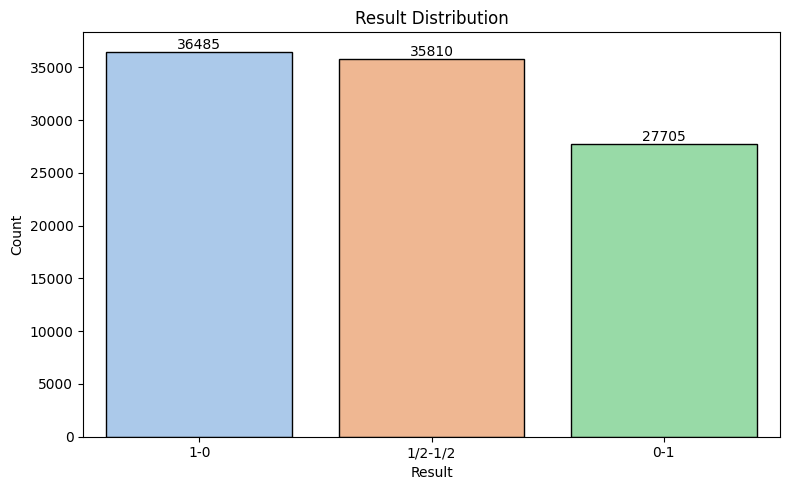

In [9]:
#A labeled bar chart of the result distribution


plt.figure(figsize=(8, 5))

data=df['result'].value_counts().index
values=list(df['result'].value_counts())
ax = sns.barplot(x=data,y=values,palette='pastel', edgecolor='black')

# Add labels on top of bars
for i, row in enumerate(data):
    ax.text(i, float(values[i])+ 0.1, values[i], ha='center', va='bottom')

# Titles and labels
plt.title('Result Distribution')
plt.xlabel('Result')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Data Preparation

In [10]:
#Retain only the following 6 columns
new_df=df[['w.mat.mean', 'b.mat.mean', 'w.mob.mean', 'b.mob.mean', 'half.moves', 'result']].copy()

new_df.head()

,w.mat.mean,b.mat.mean,w.mob.mean,b.mob.mean,half.moves,result
0,28.166667,28.135417,39.312500,27.125000,95,1-0
1,33.851852,33.703704,37.185185,33.074074,53,1-0
2,31.301587,31.920635,32.625000,37.451613,62,0-1
3,21.878261,23.260870,27.172414,32.035088,114,0-1
4,34.775510,34.959184,41.040000,32.958333,48,1/2-1/2


In [11]:
#Looking for nul values and empty values
for cols in new_df.columns:
    print(new_df[cols].loc[new_df[cols].isna()==True])
    

Series([], Name: w.mat.mean, dtype: float64)
Series([], Name: b.mat.mean, dtype: float64)
Series([], Name: w.mob.mean, dtype: float64)
Series([], Name: b.mob.mean, dtype: float64)
Series([], Name: half.moves, dtype: int64)
Series([], Name: result, dtype: object)


In [12]:
#Print the shape of new data 
new_df.shape

(100000, 6)

In [13]:
new_df.dtypes

w.mat.mean    float64
b.mat.mean    float64
w.mob.mean    float64
b.mob.mean    float64
half.moves      int64
result         object
dtype: object

In [14]:
#Look for the data characteristics
new_df.describe()

,w.mat.mean,b.mat.mean,w.mob.mean,b.mob.mean,half.moves
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,29.471540,29.456648,33.083914,30.808188,80.524530
std,5.700711,5.722296,4.899840,4.488267,33.794235
min,7.768683,9.127049,11.312500,12.272727,6.000000
25%,25.206546,25.148607,29.653061,27.731616,58.000000
50%,30.317267,30.308824,33.390244,31.000000,77.000000
75%,34.000000,34.017938,36.700000,33.978723,100.000000
max,39.000000,39.000000,50.842105,48.250000,369.000000


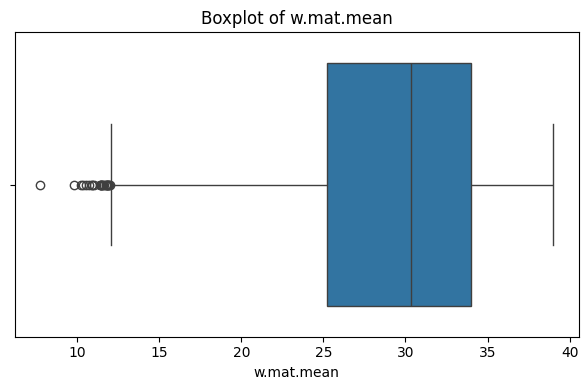

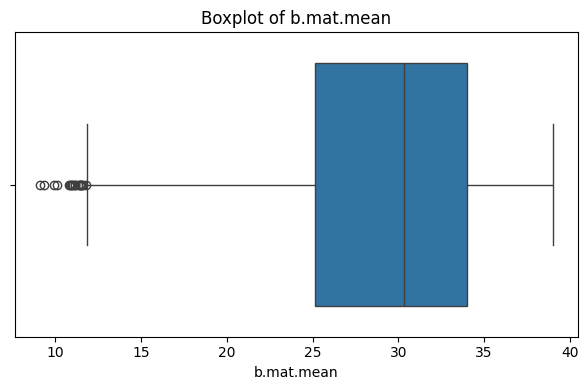

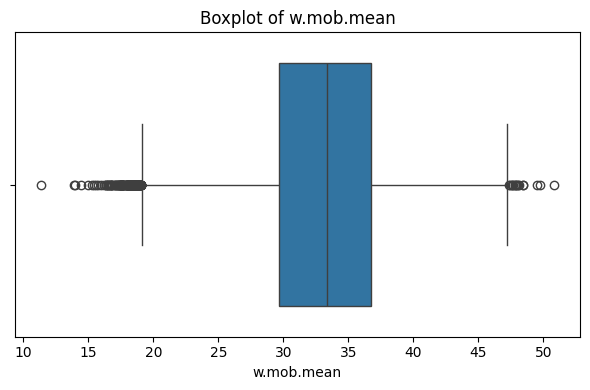

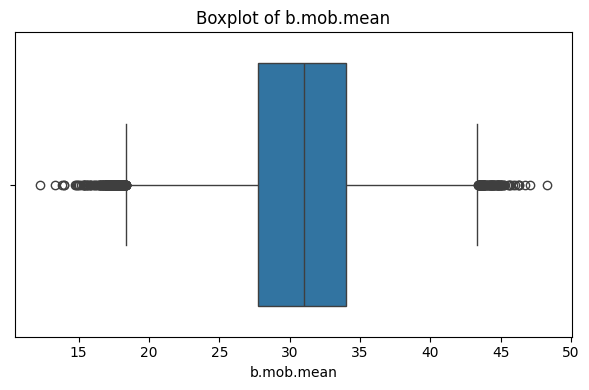

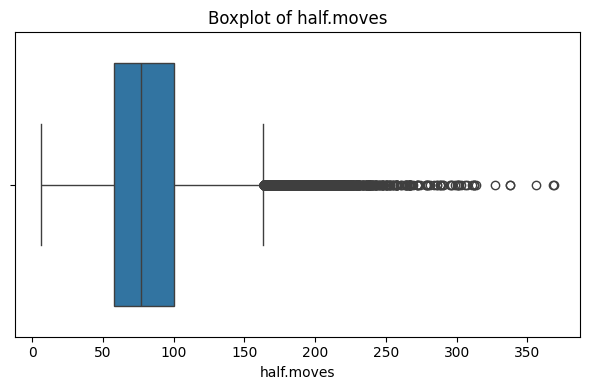

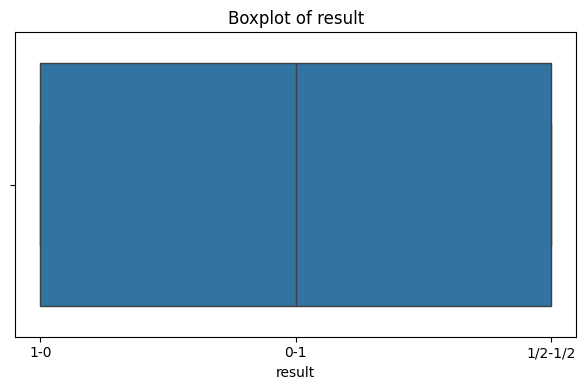

In [15]:
# looking for how the data is spread

for cols in new_df.columns:
    plt.figure(figsize=(6, 4))  # Create a new figure for each boxplot
    sns.boxplot(data=new_df, x=cols)
    plt.title(f'Boxplot of {cols}')
    plt.tight_layout()
    plt.show()

Looks like the data is spread too much and this needs to be scaled.

In [16]:
#Encode result to numeric using the following mapping
new_df.result=new_df.result.map({'1-0':int(1), '0-1':int(0), '1/2-1/2':int(2)})

In [17]:
# Perform an 85% training / 15% test split using train_test_split()
#Train test split
X_train,X_test,y_train,y_test =train_test_split(new_df.drop('result',axis=1),new_df['result'],test_size=0.15,random_state=42)

In [18]:
# Scale the 5 numeric predictor columns using StandardScaler() 
# Test upload
scalar=StandardScaler()

X_train=scalar.fit_transform(X_train)
X_test=scalar.transform(X_test)

In [19]:
# Setting up the Dataset and the Data Loader

class CustomDataSet(Dataset):
    def __init__(self,features,labels):
        self.features=torch.tensor(features,dtype=torch.float32)
        self.labels=torch.tensor(np.array(labels),dtype=torch.long)
    def __len__(self):
        return len( self.features)
    
    def __getitem__(self, index):
        return(self.features[index],self.labels[index])

train_dataset=CustomDataSet(X_train,y_train)
test_dataset=CustomDataSet(X_test,y_test)

train_loader=DataLoader(train_dataset,batch_size=128,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size=128,shuffle=False,pin_memory=True)

In [20]:
#Define the Neural network Class
class MyNN(nn.Module):
    def __init__(self,input_featutes):
        super().__init__()
        self.features=nn.Sequential(
            nn.Linear(input_featutes,50),
            nn.ReLU(),
            nn.Linear(50,3),
            # nn.Softmax(dim=1)
        )

    def forward(self,x):
        x=self.features(x)
        return x

In [21]:
#Define the Learning rate and Epochs
learning_rate=0.05
epochs = 100

In [22]:

#Deine the model with the criterion and optimizer

model=MyNN(X_train.shape[1])

model.to(device)

criterion= nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)


In [23]:
# training loop
train_losses = []
train_accuracies = []
total=0
correct=0

for epoch in range(epochs):
    total_epoch_loss=0

    for batch_features,batch_labels in train_loader:

        #move data to gpu
        batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)

        #Forward pass
        outputs=model(batch_features)

        #Calculate loss
        loss= criterion(outputs,batch_labels)

        #backpass
        optimizer.zero_grad()
        loss.backward()

        #update grads
        optimizer.step()

        total_epoch_loss= total_epoch_loss+loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
        # print(f'predicted:{predicted}Labels {batch_labels}')
    # Calculate average loss and accuracy for the epoch
    avg_loss=total_epoch_loss/len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch +1 }, Loss: {avg_loss}')

Epoch 1, Loss: 0.9491725909978823
Epoch 2, Loss: 0.9068320102261421
Epoch 3, Loss: 0.8799159352044413
Epoch 4, Loss: 0.8513026666820498
Epoch 5, Loss: 0.829006440567791
Epoch 6, Loss: 0.8170230410152808
Epoch 7, Loss: 0.8106344945448681
Epoch 8, Loss: 0.8074333405136166
Epoch 9, Loss: 0.8055501458340122
Epoch 10, Loss: 0.8045422957355814
Epoch 11, Loss: 0.8042315989508665
Epoch 12, Loss: 0.8029835375628077
Epoch 13, Loss: 0.8037387213312593
Epoch 14, Loss: 0.8023044422156829
Epoch 15, Loss: 0.8019580115949301
Epoch 16, Loss: 0.8014794917034923
Epoch 17, Loss: 0.8002887307701254
Epoch 18, Loss: 0.8007522508614046
Epoch 19, Loss: 0.7998446827544305
Epoch 20, Loss: 0.7997090780645385
Epoch 21, Loss: 0.7996115420994006
Epoch 22, Loss: 0.7991201379245385
Epoch 23, Loss: 0.798770999549923
Epoch 24, Loss: 0.7980339566567787
Epoch 25, Loss: 0.7981360180933673
Epoch 26, Loss: 0.7974063977263027
Epoch 27, Loss: 0.7973398274945137
Epoch 28, Loss: 0.7973339562129257
Epoch 29, Loss: 0.7977182325563

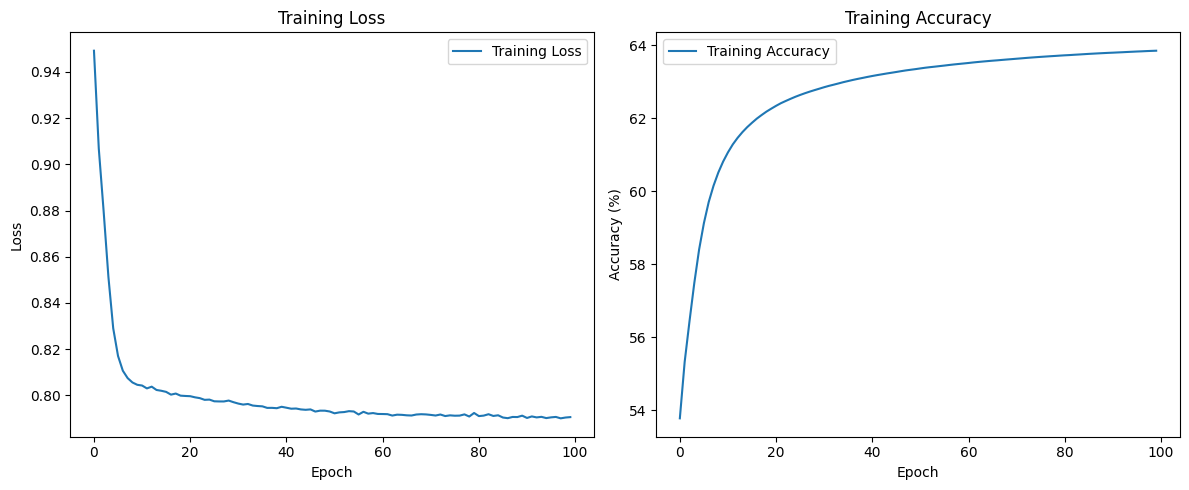

In [24]:
# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Evaluate and print test accuracy.

#Set model to eval model
model.eval()

#Evaluation Code

total=0
correct=0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        outputs=model(batch_features)
        _, predicted=torch.max(outputs,1)

        total = total + batch_labels.shape[0]
        correct= correct+(predicted==batch_labels).sum().item()
print(f'Evaluation accuracy {correct/total}')

Evaluation accuracy 0.6319333333333333


# Hyperparameter Tuning via Manual Grid Search

In [26]:
class MyNN(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_layers,neurons_per_layer,act_functn):
        super().__init__()

        layers =[]
        
        for i in range(hidden_layers):
            layers.append(nn.Linear(input_dim,neurons_per_layer))
            if act_functn=='relu':
                   layers.append(nn.ReLU())
            elif act_functn=='tanh':
                   layers.append(nn.Tanh())
            elif act_functn=='sigmoid':
                layers.append(nn.Sigmoid())
            # layers.append(nn.Dropout(drop_out_rate))
            input_dim=neurons_per_layer
        layers.append(nn.Linear(neurons_per_layer,output_dim))
        # layers.append(nn.Softmax())

        self.model=nn.Sequential(*layers)

    def forward (self,x):
        x=self.model(x)
        return (x)


In [27]:
search_space={'hidden_layers':[1,2,3],'neurons_per_layer':[40,50,60],'act_functn':['relu','tanh','sigmoid'],'optimizer_name':['Adam','SGD','RMSprop'],'learning_rate':[0.001, 0.01,0.02],'batch_size':[100,128,],'epochs':[75,100]}

#objective function

def objective(trial):
    hidden_layers=trial.suggest_categorical('hidden_layers',search_space['hidden_layers'])
    act_functn=trial.suggest_categorical('act_functn',search_space['act_functn'])
    optimizer_name=trial.suggest_categorical('optimizer_name',search_space['optimizer_name'])
    learning_rate=trial.suggest_categorical('learning_rate',search_space['learning_rate'])
    batch_size=trial.suggest_categorical('batch_size',search_space['batch_size'])
    epochs=trial.suggest_categorical('epochs',search_space['epochs'])
    neurons_per_layer=trial.suggest_categorical('neurons_per_layer',search_space['neurons_per_layer'])
    # dropout=trial.suggest_categorical('dropout',search_space['dropout'])

    input_shape=X_train.shape[1]
    output_shape=3

    model=MyNN(input_shape,output_shape,hidden_layers,neurons_per_layer,act_functn)
    model.to(device)

    #Loss Function
    criterion= nn.CrossEntropyLoss()
    

    if optimizer_name=='Adam':
        optimizer =  optim.Adam(model.parameters(),lr=learning_rate)

    elif optimizer_name=='SGD':
        optimizer =  optim.SGD(model.parameters(),lr=learning_rate)

    elif optimizer_name=='RMSprop':
        optimizer =  optim.RMSprop(model.parameters(),lr=learning_rate)
    
    # print(optimizer)


    train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,pin_memory=True)
    test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False,pin_memory=True)

    for epoch in range(epochs):
        total_epoch_loss=0
        total=0
        correct=0

        for batch_features,batch_labels in train_loader:

            #move data to gpu
            batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)

            #Forward pass
            outputs=model(batch_features)

            #Calculate loss
            loss= criterion(outputs,batch_labels)

            #backpass
            optimizer.zero_grad()
            loss.backward()

            #update grads
            optimizer.step()

            total_epoch_loss= total_epoch_loss+loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
            # print(f'predicted:{predicted}Labels {batch_labels}')
        # Calculate average loss and accuracy for the epoch
        avg_loss=total_epoch_loss/len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(epoch_accuracy)
        print(f'Epoch {epoch +1 }, Training Loss: {avg_loss}')

        # # Plot
        # plt.figure(figsize=(12, 5))

        # plt.subplot(1, 2, 1)
        # plt.plot(train_losses, label='Training Loss')
        # plt.xlabel('Epoch')
        # plt.ylabel('Loss')
        # plt.title('Training Loss')
        # plt.legend()

        # plt.subplot(1, 2, 2)
        # plt.plot(train_accuracies, label='Training Accuracy')
        # plt.xlabel('Epoch')
        # plt.ylabel('Accuracy (%)')
        # plt.title('Training Accuracy')
        # plt.legend()

        # plt.tight_layout()
        # plt.show()

        # Evaluate and print test accuracy.

    #Set model to eval model
    model.eval()

    #Evaluation Code

    total=0
    correct=0

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            outputs=model(batch_features)
            _, predicted=torch.max(outputs,1)

            total = total + batch_labels.shape[0]
            correct= correct+(predicted==batch_labels).sum().item()
    accuracy=correct/total
    
    # print(f'Evaluation accuracy with model parameters:  Learning rate: {learning_rate} batchsize : {batch_size} is : {accuracy}')

    return accuracy
    






In [ ]:
sampler = GridSampler(search_space)
study= optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective)

[I 2025-06-21 19:50:07,180] A new study created in memory with name: no-name-1138e45b-7014-4cb7-9146-c1d7b1b6497f


Epoch 1, Training Loss: 0.8970520065243083
Epoch 2, Training Loss: 0.8239295634111964
Epoch 3, Training Loss: 0.8153982796167073
Epoch 4, Training Loss: 0.8106156603734296
Epoch 5, Training Loss: 0.8061953522208938
Epoch 6, Training Loss: 0.8038895324656837
Epoch 7, Training Loss: 0.8008328090036722
Epoch 8, Training Loss: 0.7988826145803122
Epoch 9, Training Loss: 0.7977007387275983
Epoch 10, Training Loss: 0.796214593353128
Epoch 11, Training Loss: 0.7938896713400245
Epoch 12, Training Loss: 0.7938253042393161
Epoch 13, Training Loss: 0.7937515718596322
Epoch 14, Training Loss: 0.7926653149432705
Epoch 15, Training Loss: 0.7915581531094429
Epoch 16, Training Loss: 0.7920465119799277
Epoch 17, Training Loss: 0.790984418607296
Epoch 18, Training Loss: 0.791664175073007
Epoch 19, Training Loss: 0.7908638093704567
Epoch 20, Training Loss: 0.7901545426899329
Epoch 21, Training Loss: 0.7896836128449978
Epoch 22, Training Loss: 0.7896314208668874
Epoch 23, Training Loss: 0.7891108289697116


[I 2025-06-21 19:51:54,397] Trial 0 finished with value: 0.6303333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 0 with value: 0.6303333333333333.


Epoch 100, Training Loss: 0.7824159939038126
Epoch 1, Training Loss: 0.8387569329792396
Epoch 2, Training Loss: 0.8092809567774149
Epoch 3, Training Loss: 0.8023941652219099
Epoch 4, Training Loss: 0.7994877603717316
Epoch 5, Training Loss: 0.7972087045361225
Epoch 6, Training Loss: 0.7987153480823775
Epoch 7, Training Loss: 0.7963238350430826
Epoch 8, Training Loss: 0.7965555171321209
Epoch 9, Training Loss: 0.7951837360410762
Epoch 10, Training Loss: 0.7948780337670692
Epoch 11, Training Loss: 0.7955051086899033
Epoch 12, Training Loss: 0.7935089769219994
Epoch 13, Training Loss: 0.793039123725174
Epoch 14, Training Loss: 0.7929877187972678
Epoch 15, Training Loss: 0.7949486247578957
Epoch 16, Training Loss: 0.7923774960345792
Epoch 17, Training Loss: 0.7919384722422836
Epoch 18, Training Loss: 0.7918863327879655
Epoch 19, Training Loss: 0.7916340065181704
Epoch 20, Training Loss: 0.7922198449758658
Epoch 21, Training Loss: 0.7912349440997705
Epoch 22, Training Loss: 0.79078475523712

[I 2025-06-21 19:53:46,478] Trial 1 finished with value: 0.6359333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 1 with value: 0.6359333333333334.


Epoch 100, Training Loss: 0.7866457136053788
Epoch 1, Training Loss: 0.8476737241885242
Epoch 2, Training Loss: 0.8188646682570963
Epoch 3, Training Loss: 0.8144354329389685
Epoch 4, Training Loss: 0.811435117300819
Epoch 5, Training Loss: 0.8095071416742662
Epoch 6, Training Loss: 0.8059965398031123
Epoch 7, Training Loss: 0.8052741707072538
Epoch 8, Training Loss: 0.8033474967058967
Epoch 9, Training Loss: 0.8030135427503025
Epoch 10, Training Loss: 0.8023244657235987
Epoch 11, Training Loss: 0.8019973506646998
Epoch 12, Training Loss: 0.8007178033099455
Epoch 13, Training Loss: 0.8013947516329148
Epoch 14, Training Loss: 0.799403123995837
Epoch 15, Training Loss: 0.7998054341007681
Epoch 16, Training Loss: 0.799372454180437
Epoch 17, Training Loss: 0.798741902884315
Epoch 18, Training Loss: 0.7991880604800056
Epoch 19, Training Loss: 0.797943820883246
Epoch 20, Training Loss: 0.798230082357631
Epoch 21, Training Loss: 0.798059563777026
Epoch 22, Training Loss: 0.7970234301510979
Epo

[I 2025-06-21 19:55:06,784] Trial 2 finished with value: 0.6342 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 1 with value: 0.6359333333333334.


Epoch 75, Training Loss: 0.7929684786936816
Epoch 1, Training Loss: 1.0997589985062095
Epoch 2, Training Loss: 1.0919822248290567
Epoch 3, Training Loss: 1.0917056522649877
Epoch 4, Training Loss: 1.091445624547846
Epoch 5, Training Loss: 1.091177908112021
Epoch 6, Training Loss: 1.090905271137462
Epoch 7, Training Loss: 1.0906395010387195
Epoch 8, Training Loss: 1.0903885635207682
Epoch 9, Training Loss: 1.0901296917129966
Epoch 10, Training Loss: 1.0898601830706878
Epoch 11, Training Loss: 1.0895930966208962
Epoch 12, Training Loss: 1.0893385183109956
Epoch 13, Training Loss: 1.0890733257461997
Epoch 14, Training Loss: 1.0888041640730466
Epoch 15, Training Loss: 1.0885455594343298
Epoch 16, Training Loss: 1.088277618043563
Epoch 17, Training Loss: 1.0880047374613144
Epoch 18, Training Loss: 1.0877537655830383
Epoch 19, Training Loss: 1.0874648217593923
Epoch 20, Training Loss: 1.0872000677445355
Epoch 21, Training Loss: 1.0869022764879115
Epoch 22, Training Loss: 1.0866287495108211
E

[I 2025-06-21 19:56:25,746] Trial 3 finished with value: 0.45326666666666665 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 1 with value: 0.6359333333333334.


Epoch 75, Training Loss: 1.0599716575005476
Epoch 1, Training Loss: 0.9586070341222427
Epoch 2, Training Loss: 0.881836282716078
Epoch 3, Training Loss: 0.8751907443299013
Epoch 4, Training Loss: 0.8706529236541075
Epoch 5, Training Loss: 0.8691059955428628
Epoch 6, Training Loss: 0.8649999024587519
Epoch 7, Training Loss: 0.8645643719504861
Epoch 8, Training Loss: 0.865520677987267
Epoch 9, Training Loss: 0.863359901414198
Epoch 10, Training Loss: 0.862202774847255
Epoch 11, Training Loss: 0.8612418416668387
Epoch 12, Training Loss: 0.8617032296517316
Epoch 13, Training Loss: 0.8637326342218062
Epoch 14, Training Loss: 0.8601436037175796
Epoch 15, Training Loss: 0.8565851309018977
Epoch 16, Training Loss: 0.8594903882812052
Epoch 17, Training Loss: 0.8597786183918223
Epoch 18, Training Loss: 0.859518067556269
Epoch 19, Training Loss: 0.8577144129837261
Epoch 20, Training Loss: 0.8583113065186669
Epoch 21, Training Loss: 0.8556945915783153
Epoch 22, Training Loss: 0.8579675016683691
Ep

[I 2025-06-21 19:58:31,274] Trial 4 finished with value: 0.6126 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 1 with value: 0.6359333333333334.


Epoch 100, Training Loss: 0.8509169439708485
Epoch 1, Training Loss: 0.8956807327971739
Epoch 2, Training Loss: 0.8286908267526065
Epoch 3, Training Loss: 0.820452001024695
Epoch 4, Training Loss: 0.8170476494115941
Epoch 5, Training Loss: 0.8141092313037199
Epoch 6, Training Loss: 0.8124642787961399
Epoch 7, Training Loss: 0.8102742366229787
Epoch 8, Training Loss: 0.8093338793866774
Epoch 9, Training Loss: 0.8086588771202985
Epoch 10, Training Loss: 0.8078897171861985
Epoch 11, Training Loss: 0.8072045104643878
Epoch 12, Training Loss: 0.8072320788748124
Epoch 13, Training Loss: 0.8064673993867987
Epoch 14, Training Loss: 0.8057075086761923
Epoch 15, Training Loss: 0.8050142628305098
Epoch 16, Training Loss: 0.8054819508861093
Epoch 17, Training Loss: 0.8045559362102958
Epoch 18, Training Loss: 0.8044028390155119
Epoch 19, Training Loss: 0.804317626322017
Epoch 20, Training Loss: 0.803598920878242
Epoch 21, Training Loss: 0.8035935636127697
Epoch 22, Training Loss: 0.8026007021174711

[I 2025-06-21 19:59:54,633] Trial 5 finished with value: 0.6342666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 1 with value: 0.6359333333333334.


Epoch 75, Training Loss: 0.7924745570912081
Epoch 1, Training Loss: 0.8870471697695115
Epoch 2, Training Loss: 0.8198384574581595
Epoch 3, Training Loss: 0.8146695209951962
Epoch 4, Training Loss: 0.8099717455050525
Epoch 5, Training Loss: 0.8068451384235831
Epoch 6, Training Loss: 0.8032122735416188
Epoch 7, Training Loss: 0.8006625575879041
Epoch 8, Training Loss: 0.7975637564939612
Epoch 9, Training Loss: 0.7957404913621791
Epoch 10, Training Loss: 0.7946071809179642
Epoch 11, Training Loss: 0.7929290637549232
Epoch 12, Training Loss: 0.792027875956367
Epoch 13, Training Loss: 0.7922313190908993
Epoch 14, Training Loss: 0.7913271000806024
Epoch 15, Training Loss: 0.7901261719535378
Epoch 16, Training Loss: 0.7902688834246467
Epoch 17, Training Loss: 0.7896846563675824
Epoch 18, Training Loss: 0.7897601965595694
Epoch 19, Training Loss: 0.7898507865737466
Epoch 20, Training Loss: 0.7888060287167045
Epoch 21, Training Loss: 0.7885656208851758
Epoch 22, Training Loss: 0.788655400416430

[I 2025-06-21 20:01:29,036] Trial 6 finished with value: 0.6352 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 1 with value: 0.6359333333333334.


Epoch 75, Training Loss: 0.7832052444710451
Epoch 1, Training Loss: 0.9187073302448244
Epoch 2, Training Loss: 0.8333399237546706
Epoch 3, Training Loss: 0.8252241899196366
Epoch 4, Training Loss: 0.8190339973994664
Epoch 5, Training Loss: 0.8142380251920313
Epoch 6, Training Loss: 0.8126901716217959
Epoch 7, Training Loss: 0.8108289467661004
Epoch 8, Training Loss: 0.8100789607915663
Epoch 9, Training Loss: 0.8091871997467557
Epoch 10, Training Loss: 0.8079677795108996
Epoch 11, Training Loss: 0.8063698650750899
Epoch 12, Training Loss: 0.8074353229730649
Epoch 13, Training Loss: 0.8063604251782697
Epoch 14, Training Loss: 0.8056899266135423
Epoch 15, Training Loss: 0.8055447540785137
Epoch 16, Training Loss: 0.8046162552403328
Epoch 17, Training Loss: 0.804662727682214
Epoch 18, Training Loss: 0.8041678849915813
Epoch 19, Training Loss: 0.8034148553260287
Epoch 20, Training Loss: 0.80258525130444
Epoch 21, Training Loss: 0.8023285651565495
Epoch 22, Training Loss: 0.8033281558438351


[I 2025-06-21 20:02:41,345] Trial 7 finished with value: 0.625 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 1 with value: 0.6359333333333334.


Epoch 75, Training Loss: 0.793144740825309
Epoch 1, Training Loss: 1.104826642485226
Epoch 2, Training Loss: 1.080380716604345
Epoch 3, Training Loss: 1.0649471792052774
Epoch 4, Training Loss: 1.0508666892612681
Epoch 5, Training Loss: 1.0365746500211603
Epoch 6, Training Loss: 1.0221865876983194
Epoch 7, Training Loss: 1.0085104846253115
Epoch 8, Training Loss: 0.9964745567125433
Epoch 9, Training Loss: 0.9866450308350956
Epoch 10, Training Loss: 0.9790638873156379
Epoch 11, Training Loss: 0.9733993237860062
Epoch 12, Training Loss: 0.96921723372796
Epoch 13, Training Loss: 0.9660868437851177
Epoch 14, Training Loss: 0.9637171607858994
Epoch 15, Training Loss: 0.9618571050026837
Epoch 16, Training Loss: 0.9603512935077443
Epoch 17, Training Loss: 0.9590733191546272
Epoch 18, Training Loss: 0.9579592021773843
Epoch 19, Training Loss: 0.9569294754897847
Epoch 20, Training Loss: 0.955979611452888
Epoch 21, Training Loss: 0.9550368358808405
Epoch 22, Training Loss: 0.9541209171800052
Epo

[I 2025-06-21 20:04:07,150] Trial 8 finished with value: 0.6096 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 1 with value: 0.6359333333333334.


Epoch 75, Training Loss: 0.8407768461984747
Epoch 1, Training Loss: 0.8530972893076731
Epoch 2, Training Loss: 0.8352926956083542
Epoch 3, Training Loss: 0.822495656802242
Epoch 4, Training Loss: 0.8231831123954372
Epoch 5, Training Loss: 0.8268208259926703
Epoch 6, Training Loss: 0.8261285776482489
Epoch 7, Training Loss: 0.8297691270821077
Epoch 8, Training Loss: 0.8273386460497864
Epoch 9, Training Loss: 0.8323991774616385
Epoch 10, Training Loss: 0.8296769013082175
Epoch 11, Training Loss: 0.8295123821810673
Epoch 12, Training Loss: 0.8327281966245264
Epoch 13, Training Loss: 0.8339845712919881
Epoch 14, Training Loss: 0.8325187277973146
Epoch 15, Training Loss: 0.8343816266920333
Epoch 16, Training Loss: 0.8351100771050705
Epoch 17, Training Loss: 0.8335201180967173
Epoch 18, Training Loss: 0.8375446488982753
Epoch 19, Training Loss: 0.833743915790902
Epoch 20, Training Loss: 0.8391711370389264
Epoch 21, Training Loss: 0.8386286603777032
Epoch 22, Training Loss: 0.8384652004206091

[I 2025-06-21 20:05:42,167] Trial 9 finished with value: 0.6128666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 1 with value: 0.6359333333333334.


Epoch 75, Training Loss: 0.8428413582923717
Epoch 1, Training Loss: 1.0954412665086635
Epoch 2, Training Loss: 1.0823180417453542
Epoch 3, Training Loss: 1.0731082436617683
Epoch 4, Training Loss: 1.0646026720720179
Epoch 5, Training Loss: 1.055969704880434
Epoch 6, Training Loss: 1.0469598899168127
Epoch 7, Training Loss: 1.0375046906751746
Epoch 8, Training Loss: 1.027680474659976
Epoch 9, Training Loss: 1.017669490435544
Epoch 10, Training Loss: 1.0077656356727376
Epoch 11, Training Loss: 0.9982565931011649
Epoch 12, Training Loss: 0.989420079834321
Epoch 13, Training Loss: 0.9814496127296897
Epoch 14, Training Loss: 0.9744631113024319
Epoch 15, Training Loss: 0.9684633959040923
Epoch 16, Training Loss: 0.9633527689821579
Epoch 17, Training Loss: 0.9589967527109033
Epoch 18, Training Loss: 0.9552482531351202
Epoch 19, Training Loss: 0.9520066189064699
Epoch 20, Training Loss: 0.9491805007878472
Epoch 21, Training Loss: 0.9466604227178237
Epoch 22, Training Loss: 0.9443994042452644
E

[I 2025-06-21 20:07:00,422] Trial 10 finished with value: 0.5867333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 1 with value: 0.6359333333333334.


Epoch 75, Training Loss: 0.8768888932115891
Epoch 1, Training Loss: 1.0913441864171423
Epoch 2, Training Loss: 1.0911743171232984
Epoch 3, Training Loss: 1.0911125597200895
Epoch 4, Training Loss: 1.0910495379813632
Epoch 5, Training Loss: 1.0910144409738984
Epoch 6, Training Loss: 1.091010778649409
Epoch 7, Training Loss: 1.0908400675407925
Epoch 8, Training Loss: 1.0908526702034742
Epoch 9, Training Loss: 1.0908130294398257
Epoch 10, Training Loss: 1.0905802981297772
Epoch 11, Training Loss: 1.090697311279469
Epoch 12, Training Loss: 1.0904961670251718
Epoch 13, Training Loss: 1.090600774162694
Epoch 14, Training Loss: 1.090391454840065
Epoch 15, Training Loss: 1.090233460225557
Epoch 16, Training Loss: 1.0902808365068937
Epoch 17, Training Loss: 1.0900955209158416
Epoch 18, Training Loss: 1.090047700602309
Epoch 19, Training Loss: 1.09000649667324
Epoch 20, Training Loss: 1.0898593047507723
Epoch 21, Training Loss: 1.08953822591251
Epoch 22, Training Loss: 1.0893841169830552
Epoch 2

[I 2025-06-21 20:08:14,694] Trial 11 finished with value: 0.5757333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 1 with value: 0.6359333333333334.


Epoch 75, Training Loss: 0.8821230217030174
Epoch 1, Training Loss: 0.9963370984658263
Epoch 2, Training Loss: 0.9502772323170999
Epoch 3, Training Loss: 0.9410609470274215
Epoch 4, Training Loss: 0.9317529429170422
Epoch 5, Training Loss: 0.9208326943834921
Epoch 6, Training Loss: 0.9080958246288443
Epoch 7, Training Loss: 0.8928530870523668
Epoch 8, Training Loss: 0.8757372234996996
Epoch 9, Training Loss: 0.8594372527043622
Epoch 10, Training Loss: 0.8455883160569614
Epoch 11, Training Loss: 0.8359509723527091
Epoch 12, Training Loss: 0.829387785079784
Epoch 13, Training Loss: 0.8239752406464483
Epoch 14, Training Loss: 0.8207679591680828
Epoch 15, Training Loss: 0.8182898031141524
Epoch 16, Training Loss: 0.8167530121659874
Epoch 17, Training Loss: 0.814595171293818
Epoch 18, Training Loss: 0.8141136415022656
Epoch 19, Training Loss: 0.8129194184353478
Epoch 20, Training Loss: 0.8121669460956316
Epoch 21, Training Loss: 0.8117820988920398
Epoch 22, Training Loss: 0.811331804175126


[I 2025-06-21 20:09:25,224] Trial 12 finished with value: 0.6348666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 1 with value: 0.6359333333333334.


Epoch 75, Training Loss: 0.797729490215617
Epoch 1, Training Loss: 0.8979378280920141
Epoch 2, Training Loss: 0.8236030943253461
Epoch 3, Training Loss: 0.81659047554521
Epoch 4, Training Loss: 0.8089742484513451
Epoch 5, Training Loss: 0.8045957988851211
Epoch 6, Training Loss: 0.8008356745804057
Epoch 7, Training Loss: 0.7999219571842867
Epoch 8, Training Loss: 0.7974643545291004
Epoch 9, Training Loss: 0.7964552780459909
Epoch 10, Training Loss: 0.7949295766213361
Epoch 11, Training Loss: 0.7937259200741263
Epoch 12, Training Loss: 0.7933999417108648
Epoch 13, Training Loss: 0.7931438978279338
Epoch 14, Training Loss: 0.7918508977048537
Epoch 15, Training Loss: 0.7917565686562482
Epoch 16, Training Loss: 0.7907070016159731
Epoch 17, Training Loss: 0.7906033813252169
Epoch 18, Training Loss: 0.7902264698112712
Epoch 19, Training Loss: 0.7900801958056057
Epoch 20, Training Loss: 0.7889561601246105
Epoch 21, Training Loss: 0.7892312777042388
Epoch 22, Training Loss: 0.78921678592177
Ep

[I 2025-06-21 20:11:06,878] Trial 13 finished with value: 0.6357333333333334 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 1 with value: 0.6359333333333334.


Epoch 75, Training Loss: 0.7819114988691667
Epoch 1, Training Loss: 1.0908852445378023
Epoch 2, Training Loss: 1.0873445011587703
Epoch 3, Training Loss: 1.0838506739279803
Epoch 4, Training Loss: 1.0797414678685806
Epoch 5, Training Loss: 1.0745343418682323
Epoch 6, Training Loss: 1.067788290276247
Epoch 7, Training Loss: 1.0593073659784653
Epoch 8, Training Loss: 1.0484508397999932
Epoch 9, Training Loss: 1.035416154651081
Epoch 10, Training Loss: 1.0208879631407122
Epoch 11, Training Loss: 1.0065924072966856
Epoch 12, Training Loss: 0.994121946587282
Epoch 13, Training Loss: 0.9845158837823307
Epoch 14, Training Loss: 0.9775487145956825
Epoch 15, Training Loss: 0.9723636247831232
Epoch 16, Training Loss: 0.968365434478311
Epoch 17, Training Loss: 0.9656146156787873
Epoch 18, Training Loss: 0.9632089103670681
Epoch 19, Training Loss: 0.9612436614317053
Epoch 20, Training Loss: 0.9597570619863622
Epoch 21, Training Loss: 0.9584338288447436
Epoch 22, Training Loss: 0.9574603184531717
E

[I 2025-06-21 20:12:52,876] Trial 14 finished with value: 0.622 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 1 with value: 0.6359333333333334.


Epoch 100, Training Loss: 0.8186431520826676
Epoch 1, Training Loss: 0.8937367458203259
Epoch 2, Training Loss: 0.8251174194672528
Epoch 3, Training Loss: 0.8182513580602758
Epoch 4, Training Loss: 0.8154592842915479
Epoch 5, Training Loss: 0.8132885624380672
Epoch 6, Training Loss: 0.8111560580309699
Epoch 7, Training Loss: 0.8100027075935813
Epoch 8, Training Loss: 0.8089520391997169
Epoch 9, Training Loss: 0.8084493120277629
Epoch 10, Training Loss: 0.8078725997840657
Epoch 11, Training Loss: 0.8063098439048318
Epoch 12, Training Loss: 0.8060896223432877
Epoch 13, Training Loss: 0.8057015989107245
Epoch 14, Training Loss: 0.8055586211120381
Epoch 15, Training Loss: 0.8046651447520536
Epoch 16, Training Loss: 0.8045832900439992
Epoch 17, Training Loss: 0.8042266870947445
Epoch 18, Training Loss: 0.8038764114940867
Epoch 19, Training Loss: 0.8032376025003546
Epoch 20, Training Loss: 0.8034835199047538
Epoch 21, Training Loss: 0.8035544557431165
Epoch 22, Training Loss: 0.8031769152248

[I 2025-06-21 20:14:43,065] Trial 15 finished with value: 0.6382 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 15 with value: 0.6382.


Epoch 100, Training Loss: 0.792736442790312
Epoch 1, Training Loss: 1.0080608437341803
Epoch 2, Training Loss: 0.9300204603812274
Epoch 3, Training Loss: 0.8904402300189523
Epoch 4, Training Loss: 0.8288710086485919
Epoch 5, Training Loss: 0.813358710232903
Epoch 6, Training Loss: 0.8113130204817828
Epoch 7, Training Loss: 0.809894154141931
Epoch 8, Training Loss: 0.8086804447454564
Epoch 9, Training Loss: 0.8072158158526701
Epoch 10, Training Loss: 0.8065881188476787
Epoch 11, Training Loss: 0.8054130581547232
Epoch 12, Training Loss: 0.8047074283571805
Epoch 13, Training Loss: 0.8045059063154109
Epoch 14, Training Loss: 0.803103234277052
Epoch 15, Training Loss: 0.8022871959910673
Epoch 16, Training Loss: 0.8022303719380323
Epoch 17, Training Loss: 0.8018211922926062
Epoch 18, Training Loss: 0.8018049713443307
Epoch 19, Training Loss: 0.801310608106501
Epoch 20, Training Loss: 0.800772761667476
Epoch 21, Training Loss: 0.8005545739566579
Epoch 22, Training Loss: 0.7997009073986726
Ep

[I 2025-06-21 20:16:32,443] Trial 16 finished with value: 0.6364666666666666 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 15 with value: 0.6382.


Epoch 75, Training Loss: 0.7874928416224087
Epoch 1, Training Loss: 0.86289586160416
Epoch 2, Training Loss: 0.8164303312624307
Epoch 3, Training Loss: 0.8099589303920144
Epoch 4, Training Loss: 0.8075522766077429
Epoch 5, Training Loss: 0.8047793164289088
Epoch 6, Training Loss: 0.8036652066653832
Epoch 7, Training Loss: 0.8012732450227092
Epoch 8, Training Loss: 0.8000644924049091
Epoch 9, Training Loss: 0.8002742404328254
Epoch 10, Training Loss: 0.7988035644803728
Epoch 11, Training Loss: 0.7982856132034072
Epoch 12, Training Loss: 0.7973250688466811
Epoch 13, Training Loss: 0.7963051993147772
Epoch 14, Training Loss: 0.7975117877013701
Epoch 15, Training Loss: 0.7961156743809693
Epoch 16, Training Loss: 0.7948348533838315
Epoch 17, Training Loss: 0.7937948742755374
Epoch 18, Training Loss: 0.7941152614758427
Epoch 19, Training Loss: 0.7950316071510315
Epoch 20, Training Loss: 0.7936871260628664
Epoch 21, Training Loss: 0.7947081670725256
Epoch 22, Training Loss: 0.7929943074857382

[I 2025-06-21 20:18:34,888] Trial 17 finished with value: 0.6262666666666666 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 15 with value: 0.6382.


Epoch 100, Training Loss: 0.7894921326995792
Epoch 1, Training Loss: 1.035356332753834
Epoch 2, Training Loss: 0.967357263349949
Epoch 3, Training Loss: 0.9538981739739726
Epoch 4, Training Loss: 0.9438483856674423
Epoch 5, Training Loss: 0.9318290741820084
Epoch 6, Training Loss: 0.9155218562685458
Epoch 7, Training Loss: 0.8922137092826958
Epoch 8, Training Loss: 0.8635029471906505
Epoch 9, Training Loss: 0.8404298590538197
Epoch 10, Training Loss: 0.8264219603144136
Epoch 11, Training Loss: 0.8201450027917561
Epoch 12, Training Loss: 0.8172247882176162
Epoch 13, Training Loss: 0.8149443930253051
Epoch 14, Training Loss: 0.8129374674388341
Epoch 15, Training Loss: 0.8117526452344163
Epoch 16, Training Loss: 0.8113327881447354
Epoch 17, Training Loss: 0.8101178824453426
Epoch 18, Training Loss: 0.8096342586933222
Epoch 19, Training Loss: 0.8084153758852105
Epoch 20, Training Loss: 0.8086782453651715
Epoch 21, Training Loss: 0.8070351325479665
Epoch 22, Training Loss: 0.806630335266428

[I 2025-06-21 20:20:14,059] Trial 18 finished with value: 0.6283333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 15 with value: 0.6382.


Epoch 100, Training Loss: 0.7930538652534772
Epoch 1, Training Loss: 1.101733944416046
Epoch 2, Training Loss: 1.0909638096304501
Epoch 3, Training Loss: 1.090939277340384
Epoch 4, Training Loss: 1.0909201484567979
Epoch 5, Training Loss: 1.0909059085565456
Epoch 6, Training Loss: 1.0909149109615999
Epoch 7, Training Loss: 1.0909126152711757
Epoch 8, Training Loss: 1.0909021205060623
Epoch 9, Training Loss: 1.0909047867270076
Epoch 10, Training Loss: 1.0908938103563646
Epoch 11, Training Loss: 1.0908758599617903
Epoch 12, Training Loss: 1.0908819850753335
Epoch 13, Training Loss: 1.0908720792041104
Epoch 14, Training Loss: 1.0908709280631121
Epoch 15, Training Loss: 1.0908609429527731
Epoch 16, Training Loss: 1.0908414095990797
Epoch 17, Training Loss: 1.0908561773861156
Epoch 18, Training Loss: 1.090838782787323
Epoch 19, Training Loss: 1.0908122660132016
Epoch 20, Training Loss: 1.090833815125858
Epoch 21, Training Loss: 1.0908271943821626
Epoch 22, Training Loss: 1.0908128755232867


[I 2025-06-21 20:21:39,381] Trial 19 finished with value: 0.3558 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 15 with value: 0.6382.


Epoch 75, Training Loss: 1.0904775120230281
Epoch 1, Training Loss: 1.1048629154878504
Epoch 2, Training Loss: 1.0934301684884464
Epoch 3, Training Loss: 1.0869385926863726
Epoch 4, Training Loss: 1.0823987416660084
Epoch 5, Training Loss: 1.0785351294629715
Epoch 6, Training Loss: 1.0747753667831421
Epoch 7, Training Loss: 1.0708315336003023
Epoch 8, Training Loss: 1.0664964321080377
Epoch 9, Training Loss: 1.0616406632872188
Epoch 10, Training Loss: 1.0562426114082337
Epoch 11, Training Loss: 1.050270650807549
Epoch 12, Training Loss: 1.0437138993599835
Epoch 13, Training Loss: 1.03656708149349
Epoch 14, Training Loss: 1.0288436026432934
Epoch 15, Training Loss: 1.020568971633911
Epoch 16, Training Loss: 1.0117785955176635
Epoch 17, Training Loss: 1.00255677300341
Epoch 18, Training Loss: 0.9930768350292655
Epoch 19, Training Loss: 0.9836461782455445
Epoch 20, Training Loss: 0.974667259945589
Epoch 21, Training Loss: 0.9665300940064823
Epoch 22, Training Loss: 0.9595401873308069
Epoc

[I 2025-06-21 20:23:05,647] Trial 20 finished with value: 0.5946 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 15 with value: 0.6382.


Epoch 75, Training Loss: 0.8629913720663857
Epoch 1, Training Loss: 1.0914791687797099
Epoch 2, Training Loss: 1.0910569443422204
Epoch 3, Training Loss: 1.091036628414603
Epoch 4, Training Loss: 1.090926748864791
Epoch 5, Training Loss: 1.09077392578125
Epoch 6, Training Loss: 1.09073540280847
Epoch 7, Training Loss: 1.0906178578208474
Epoch 8, Training Loss: 1.0906102066881516
Epoch 9, Training Loss: 1.0904541321361767
Epoch 10, Training Loss: 1.0904077315330505
Epoch 11, Training Loss: 1.0902763565848856
Epoch 12, Training Loss: 1.09003007552203
Epoch 13, Training Loss: 1.0901211833953857
Epoch 14, Training Loss: 1.0900140693608453
Epoch 15, Training Loss: 1.0898784004940707
Epoch 16, Training Loss: 1.089739684637855
Epoch 17, Training Loss: 1.0895605055023643
Epoch 18, Training Loss: 1.089503759356106
Epoch 19, Training Loss: 1.0892176379876979
Epoch 20, Training Loss: 1.0891998718766605
Epoch 21, Training Loss: 1.088996668843662
Epoch 22, Training Loss: 1.0887655725198633
Epoch 23

[I 2025-06-21 20:24:32,354] Trial 21 finished with value: 0.5449333333333334 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 15 with value: 0.6382.


Epoch 75, Training Loss: 0.9375464214998133
Epoch 1, Training Loss: 0.862437156158335
Epoch 2, Training Loss: 0.826407981970731
Epoch 3, Training Loss: 0.822352135742412
Epoch 4, Training Loss: 0.8192166935696321
Epoch 5, Training Loss: 0.8163596900070414
Epoch 6, Training Loss: 0.8136035347686095
Epoch 7, Training Loss: 0.8124647905546076
Epoch 8, Training Loss: 0.8117841097186593
Epoch 9, Training Loss: 0.8104321883005254
Epoch 10, Training Loss: 0.8097610310245963
Epoch 11, Training Loss: 0.8095772219405455
Epoch 12, Training Loss: 0.8087583169516395
Epoch 13, Training Loss: 0.8086832275811364
Epoch 14, Training Loss: 0.8085326433882993
Epoch 15, Training Loss: 0.8082574373834274
Epoch 16, Training Loss: 0.807278288602829
Epoch 17, Training Loss: 0.8074330991857193
Epoch 18, Training Loss: 0.8073896336555481
Epoch 19, Training Loss: 0.8072929279944476
Epoch 20, Training Loss: 0.8070792585260728
Epoch 21, Training Loss: 0.8063293909325319
Epoch 22, Training Loss: 0.8059643520327175
E

[I 2025-06-21 20:25:53,966] Trial 22 finished with value: 0.6328 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 15 with value: 0.6382.


Epoch 75, Training Loss: 0.7984591215498307
Epoch 1, Training Loss: 1.0738670219393338
Epoch 2, Training Loss: 1.0236375516302445
Epoch 3, Training Loss: 0.9972075026175555
Epoch 4, Training Loss: 0.9811212904313031
Epoch 5, Training Loss: 0.9711734618860133
Epoch 6, Training Loss: 0.9650542696083293
Epoch 7, Training Loss: 0.9611670385388768
Epoch 8, Training Loss: 0.9585349695822772
Epoch 9, Training Loss: 0.9565953188783982
Epoch 10, Training Loss: 0.9550181059977587
Epoch 11, Training Loss: 0.9536167167214786
Epoch 12, Training Loss: 0.9523170697689056
Epoch 13, Training Loss: 0.9510607739757089
Epoch 14, Training Loss: 0.9498155764271231
Epoch 15, Training Loss: 0.9485784667379716
Epoch 16, Training Loss: 0.9473212120112251
Epoch 17, Training Loss: 0.9460684755269219
Epoch 18, Training Loss: 0.9447976749784807
Epoch 19, Training Loss: 0.9434992075667662
Epoch 20, Training Loss: 0.9421821104778964
Epoch 21, Training Loss: 0.9408353381297168
Epoch 22, Training Loss: 0.93946264757829

[I 2025-06-21 20:27:14,698] Trial 23 finished with value: 0.613 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 15 with value: 0.6382.


Epoch 75, Training Loss: 0.8369217178400825
Epoch 1, Training Loss: 0.976804845683715
Epoch 2, Training Loss: 0.9368996491852929
Epoch 3, Training Loss: 0.8990655312117408
Epoch 4, Training Loss: 0.8502699988729814
Epoch 5, Training Loss: 0.8238671628166647
Epoch 6, Training Loss: 0.8161121619448942
Epoch 7, Training Loss: 0.8134990318382488
Epoch 8, Training Loss: 0.8118002154546625
Epoch 9, Training Loss: 0.8105003925632028
Epoch 10, Training Loss: 0.8089218716761645
Epoch 11, Training Loss: 0.8080636448719922
Epoch 12, Training Loss: 0.807433758132598
Epoch 13, Training Loss: 0.8061697177325978
Epoch 14, Training Loss: 0.8060611310425927
Epoch 15, Training Loss: 0.8051344725664924
Epoch 16, Training Loss: 0.8045726359591765
Epoch 17, Training Loss: 0.8043374237593482
Epoch 18, Training Loss: 0.8038655096643111
Epoch 19, Training Loss: 0.8037746500968933
Epoch 20, Training Loss: 0.8033638255736407
Epoch 21, Training Loss: 0.8027856035092298
Epoch 22, Training Loss: 0.8027591297205756

[I 2025-06-21 20:28:49,970] Trial 24 finished with value: 0.6289333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 15 with value: 0.6382.


Epoch 75, Training Loss: 0.7958202094190261
Epoch 1, Training Loss: 0.845485756451026
Epoch 2, Training Loss: 0.8076210711235391
Epoch 3, Training Loss: 0.8036711793196829
Epoch 4, Training Loss: 0.7996031656301111
Epoch 5, Training Loss: 0.7991526849287793
Epoch 6, Training Loss: 0.7988443546725396
Epoch 7, Training Loss: 0.7956980839707798
Epoch 8, Training Loss: 0.7954755506121126
Epoch 9, Training Loss: 0.7958700780581711
Epoch 10, Training Loss: 0.7933354259433603
Epoch 11, Training Loss: 0.7943199534165232
Epoch 12, Training Loss: 0.7952441825902552
Epoch 13, Training Loss: 0.7935010109628949
Epoch 14, Training Loss: 0.7924716057633995
Epoch 15, Training Loss: 0.7927568053840695
Epoch 16, Training Loss: 0.7934760893197884
Epoch 17, Training Loss: 0.7920219741369549
Epoch 18, Training Loss: 0.7935296383119167
Epoch 19, Training Loss: 0.7919197691114326
Epoch 20, Training Loss: 0.7934652817876715
Epoch 21, Training Loss: 0.7908781746276339
Epoch 22, Training Loss: 0.791647190438177

[I 2025-06-21 20:30:17,612] Trial 25 finished with value: 0.6383333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 25 with value: 0.6383333333333333.


Epoch 75, Training Loss: 0.7876853318142711
Epoch 1, Training Loss: 0.9468834824131843
Epoch 2, Training Loss: 0.8912701499193234
Epoch 3, Training Loss: 0.8472911719092749
Epoch 4, Training Loss: 0.825049684908157
Epoch 5, Training Loss: 0.8161103020933338
Epoch 6, Training Loss: 0.8128614441792767
Epoch 7, Training Loss: 0.8116832727776434
Epoch 8, Training Loss: 0.8106891691236567
Epoch 9, Training Loss: 0.8094942982035472
Epoch 10, Training Loss: 0.8087511140601079
Epoch 11, Training Loss: 0.8085955923661253
Epoch 12, Training Loss: 0.807540646352266
Epoch 13, Training Loss: 0.8081376083811423
Epoch 14, Training Loss: 0.8074894992032445
Epoch 15, Training Loss: 0.8066395310530985
Epoch 16, Training Loss: 0.8064154360527382
Epoch 17, Training Loss: 0.8064971571578119
Epoch 18, Training Loss: 0.8056560286005637
Epoch 19, Training Loss: 0.8052151753490132
Epoch 20, Training Loss: 0.8050571030243895
Epoch 21, Training Loss: 0.8055138339673666
Epoch 22, Training Loss: 0.8042353516234491

[I 2025-06-21 20:31:50,435] Trial 26 finished with value: 0.6344 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 25 with value: 0.6383333333333333.


Epoch 100, Training Loss: 0.7965945229494482
Epoch 1, Training Loss: 0.8824911729733746
Epoch 2, Training Loss: 0.8347473488714462
Epoch 3, Training Loss: 0.8284740052725139
Epoch 4, Training Loss: 0.8236984200943681
Epoch 5, Training Loss: 0.8207422569282072
Epoch 6, Training Loss: 0.8193313491075559
Epoch 7, Training Loss: 0.8180953967840152
Epoch 8, Training Loss: 0.8184808784857729
Epoch 9, Training Loss: 0.8165675360457342
Epoch 10, Training Loss: 0.818130556353949
Epoch 11, Training Loss: 0.815820580676086
Epoch 12, Training Loss: 0.817747548110503
Epoch 13, Training Loss: 0.8155413574742195
Epoch 14, Training Loss: 0.8162386951589943
Epoch 15, Training Loss: 0.8142177959133808
Epoch 16, Training Loss: 0.8130985493050482
Epoch 17, Training Loss: 0.8131882577910459
Epoch 18, Training Loss: 0.812893625668117
Epoch 19, Training Loss: 0.8116979906433507
Epoch 20, Training Loss: 0.8132281034512627
Epoch 21, Training Loss: 0.8112550501536606
Epoch 22, Training Loss: 0.8117036885784981


[I 2025-06-21 20:33:23,992] Trial 27 finished with value: 0.6044666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 25 with value: 0.6383333333333333.


Epoch 100, Training Loss: 0.8021185707328911
Epoch 1, Training Loss: 1.000786070267957
Epoch 2, Training Loss: 0.9514377675558391
Epoch 3, Training Loss: 0.9384539613150116
Epoch 4, Training Loss: 0.922297039336728
Epoch 5, Training Loss: 0.9031465507091436
Epoch 6, Training Loss: 0.8831382109706564
Epoch 7, Training Loss: 0.8641323589740839
Epoch 8, Training Loss: 0.8489980625927
Epoch 9, Training Loss: 0.8373145757761217
Epoch 10, Training Loss: 0.8291390079304688
Epoch 11, Training Loss: 0.8229850803999076
Epoch 12, Training Loss: 0.8182472269337876
Epoch 13, Training Loss: 0.8153558563469048
Epoch 14, Training Loss: 0.8128049944576464
Epoch 15, Training Loss: 0.8119457699302444
Epoch 16, Training Loss: 0.8105690701563556
Epoch 17, Training Loss: 0.8098672467963139
Epoch 18, Training Loss: 0.8089694169230928
Epoch 19, Training Loss: 0.808877790691261
Epoch 20, Training Loss: 0.8084743793745687
Epoch 21, Training Loss: 0.8081493010198263
Epoch 22, Training Loss: 0.8079943725937291
Ep

[I 2025-06-21 20:35:04,683] Trial 28 finished with value: 0.6339333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 25 with value: 0.6383333333333333.


Epoch 100, Training Loss: 0.7989267412881206
Epoch 1, Training Loss: 1.0923220698973712
Epoch 2, Training Loss: 1.0907228084171519
Epoch 3, Training Loss: 1.090722778264214
Epoch 4, Training Loss: 1.0906846141815185
Epoch 5, Training Loss: 1.0906845866932589
Epoch 6, Training Loss: 1.0906549303671893
Epoch 7, Training Loss: 1.090658624312457
Epoch 8, Training Loss: 1.0906461255690632
Epoch 9, Training Loss: 1.0906393373713774
Epoch 10, Training Loss: 1.0906150325606851
Epoch 11, Training Loss: 1.0906060904615065
Epoch 12, Training Loss: 1.0906023805281695
Epoch 13, Training Loss: 1.090583888502682
Epoch 14, Training Loss: 1.0905649089813232
Epoch 15, Training Loss: 1.090547344824847
Epoch 16, Training Loss: 1.0905371255033156
Epoch 17, Training Loss: 1.0905235017047208
Epoch 18, Training Loss: 1.0905121116077199
Epoch 19, Training Loss: 1.0904837245099686
Epoch 20, Training Loss: 1.090462735260234
Epoch 21, Training Loss: 1.090483424242805
Epoch 22, Training Loss: 1.0904677552335402
Ep

[I 2025-06-21 20:37:03,099] Trial 29 finished with value: 0.3558 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 25 with value: 0.6383333333333333.


Epoch 100, Training Loss: 1.089133389977848
Epoch 1, Training Loss: 0.8518865121038337
Epoch 2, Training Loss: 0.8233124612865591
Epoch 3, Training Loss: 0.8209759057912611
Epoch 4, Training Loss: 0.8134761321813541
Epoch 5, Training Loss: 0.8124699241236637
Epoch 6, Training Loss: 0.812005545142898
Epoch 7, Training Loss: 0.8116612182972126
Epoch 8, Training Loss: 0.8115153318060968
Epoch 9, Training Loss: 0.811807113841064
Epoch 10, Training Loss: 0.8096099985273261
Epoch 11, Training Loss: 0.8094627678842473
Epoch 12, Training Loss: 0.8098357087687442
Epoch 13, Training Loss: 0.8103111993549461
Epoch 14, Training Loss: 0.8081119772186853
Epoch 15, Training Loss: 0.80947317870936
Epoch 16, Training Loss: 0.8085197853862791
Epoch 17, Training Loss: 0.8093092357305656
Epoch 18, Training Loss: 0.8098541378974915
Epoch 19, Training Loss: 0.8084081678462208
Epoch 20, Training Loss: 0.8086090313760858
Epoch 21, Training Loss: 0.8082453552941631
Epoch 22, Training Loss: 0.8087801781812108
E

[I 2025-06-21 20:38:42,342] Trial 30 finished with value: 0.6279333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 25 with value: 0.6383333333333333.


Epoch 100, Training Loss: 0.7985086987789413
Epoch 1, Training Loss: 0.8721430153005263
Epoch 2, Training Loss: 0.8169625957573161
Epoch 3, Training Loss: 0.8131398297057433
Epoch 4, Training Loss: 0.8108739439880147
Epoch 5, Training Loss: 0.8090919957441443
Epoch 6, Training Loss: 0.8069022699664621
Epoch 7, Training Loss: 0.8056146531946519
Epoch 8, Training Loss: 0.8044458318457884
Epoch 9, Training Loss: 0.8030237988864675
Epoch 10, Training Loss: 0.8025357530397528
Epoch 11, Training Loss: 0.8024632190956789
Epoch 12, Training Loss: 0.8020384092891918
Epoch 13, Training Loss: 0.8013263956238241
Epoch 14, Training Loss: 0.8007081890106201
Epoch 15, Training Loss: 0.8001689581310047
Epoch 16, Training Loss: 0.7994380386436687
Epoch 17, Training Loss: 0.7993266446450177
Epoch 18, Training Loss: 0.7985946677011602
Epoch 19, Training Loss: 0.7985040265672347
Epoch 20, Training Loss: 0.7974392611138961
Epoch 21, Training Loss: 0.7971573448882383
Epoch 22, Training Loss: 0.7967229615239

[I 2025-06-21 20:40:16,283] Trial 31 finished with value: 0.6411333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.78264997734743
Epoch 1, Training Loss: 0.8668791865943966
Epoch 2, Training Loss: 0.8185833193305739
Epoch 3, Training Loss: 0.8110906837578107
Epoch 4, Training Loss: 0.8078345111438207
Epoch 5, Training Loss: 0.8060288954498176
Epoch 6, Training Loss: 0.8041888176050401
Epoch 7, Training Loss: 0.8026125239250356
Epoch 8, Training Loss: 0.8009724361555917
Epoch 9, Training Loss: 0.8004988172896823
Epoch 10, Training Loss: 0.7985077693050069
Epoch 11, Training Loss: 0.7974671297503594
Epoch 12, Training Loss: 0.797432976199272
Epoch 13, Training Loss: 0.7965621631844599
Epoch 14, Training Loss: 0.7955707206761926
Epoch 15, Training Loss: 0.7953015541671811
Epoch 16, Training Loss: 0.7951139912569434
Epoch 17, Training Loss: 0.7951513077083386
Epoch 18, Training Loss: 0.7941199258754128
Epoch 19, Training Loss: 0.7945880863003265
Epoch 20, Training Loss: 0.7945046529734046
Epoch 21, Training Loss: 0.7926024958827442
Epoch 22, Training Loss: 0.7934743816691233


[I 2025-06-21 20:41:48,702] Trial 32 finished with value: 0.6102666666666666 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7889894501607221
Epoch 1, Training Loss: 0.9250819261809041
Epoch 2, Training Loss: 0.8500784442837077
Epoch 3, Training Loss: 0.8403463391433085
Epoch 4, Training Loss: 0.8342408822891407
Epoch 5, Training Loss: 0.8321248522378448
Epoch 6, Training Loss: 0.8298281020687935
Epoch 7, Training Loss: 0.8261937702508797
Epoch 8, Training Loss: 0.8267892042497047
Epoch 9, Training Loss: 0.8226929140270205
Epoch 10, Training Loss: 0.822552906570578
Epoch 11, Training Loss: 0.8224001146796951
Epoch 12, Training Loss: 0.8207536514988519
Epoch 13, Training Loss: 0.8207762786320277
Epoch 14, Training Loss: 0.8211923644058686
Epoch 15, Training Loss: 0.8195732236804819
Epoch 16, Training Loss: 0.8207643948999562
Epoch 17, Training Loss: 0.8218950734998947
Epoch 18, Training Loss: 0.8182462390204122
Epoch 19, Training Loss: 0.8182672714828548
Epoch 20, Training Loss: 0.8211712817500408
Epoch 21, Training Loss: 0.8186538404091857
Epoch 22, Training Loss: 0.820144792606956

[I 2025-06-21 20:43:10,176] Trial 33 finished with value: 0.46973333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.8171816998854615
Epoch 1, Training Loss: 1.077972828176685
Epoch 2, Training Loss: 1.0323962203542092
Epoch 3, Training Loss: 0.9711886094925098
Epoch 4, Training Loss: 0.9437032484470453
Epoch 5, Training Loss: 0.9312842599431375
Epoch 6, Training Loss: 0.9228131740613091
Epoch 7, Training Loss: 0.9142189024982595
Epoch 8, Training Loss: 0.9050676472204968
Epoch 9, Training Loss: 0.8938905493657392
Epoch 10, Training Loss: 0.8775529985141037
Epoch 11, Training Loss: 0.8567049089230989
Epoch 12, Training Loss: 0.8336263509173142
Epoch 13, Training Loss: 0.819368590985922
Epoch 14, Training Loss: 0.812514955656869
Epoch 15, Training Loss: 0.809072312466184
Epoch 16, Training Loss: 0.8072479665727543
Epoch 17, Training Loss: 0.8062674198831831
Epoch 18, Training Loss: 0.8050006239934075
Epoch 19, Training Loss: 0.8042042027738757
Epoch 20, Training Loss: 0.8036679175563325
Epoch 21, Training Loss: 0.8026806596526526
Epoch 22, Training Loss: 0.8026303646259738
E

[I 2025-06-21 20:44:52,772] Trial 34 finished with value: 0.6378666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7842646802278389
Epoch 1, Training Loss: 0.9116350833634684
Epoch 2, Training Loss: 0.8217721688119989
Epoch 3, Training Loss: 0.8114067434368277
Epoch 4, Training Loss: 0.8066784994942802
Epoch 5, Training Loss: 0.8043074363156368
Epoch 6, Training Loss: 0.8021825907821942
Epoch 7, Training Loss: 0.8012406432539001
Epoch 8, Training Loss: 0.7995953792019894
Epoch 9, Training Loss: 0.7989170016202711
Epoch 10, Training Loss: 0.7982265648088958
Epoch 11, Training Loss: 0.7977038013307671
Epoch 12, Training Loss: 0.7976320731908755
Epoch 13, Training Loss: 0.7961418613455349
Epoch 14, Training Loss: 0.7944323463547499
Epoch 15, Training Loss: 0.7947285929120573
Epoch 16, Training Loss: 0.7938589140884859
Epoch 17, Training Loss: 0.7939871534369045
Epoch 18, Training Loss: 0.7939892611109225
Epoch 19, Training Loss: 0.7934961573521894
Epoch 20, Training Loss: 0.7922736927082664
Epoch 21, Training Loss: 0.7926764318817541
Epoch 22, Training Loss: 0.7925751108872

[I 2025-06-21 20:46:53,484] Trial 35 finished with value: 0.6181333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7903677660719792
Epoch 1, Training Loss: 1.0156666798699172
Epoch 2, Training Loss: 0.957987654298768
Epoch 3, Training Loss: 0.9471953549779447
Epoch 4, Training Loss: 0.9400220023958307
Epoch 5, Training Loss: 0.931826056663255
Epoch 6, Training Loss: 0.9219122322878444
Epoch 7, Training Loss: 0.9110158897880325
Epoch 8, Training Loss: 0.8968541197310713
Epoch 9, Training Loss: 0.8818863044107766
Epoch 10, Training Loss: 0.8658318182579556
Epoch 11, Training Loss: 0.8504530176184231
Epoch 12, Training Loss: 0.838433812076884
Epoch 13, Training Loss: 0.8285566454543207
Epoch 14, Training Loss: 0.8224493386153888
Epoch 15, Training Loss: 0.8178479958297615
Epoch 16, Training Loss: 0.8149162084536445
Epoch 17, Training Loss: 0.813438253832939
Epoch 18, Training Loss: 0.8116768294707277
Epoch 19, Training Loss: 0.8110585662655364
Epoch 20, Training Loss: 0.8093937864877228
Epoch 21, Training Loss: 0.8093950163152881
Epoch 22, Training Loss: 0.8088183712242241


[I 2025-06-21 20:48:03,857] Trial 36 finished with value: 0.6264 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7984299283278616
Epoch 1, Training Loss: 1.0954436047632892
Epoch 2, Training Loss: 1.0901544522522086
Epoch 3, Training Loss: 1.0866924135308518
Epoch 4, Training Loss: 1.0840319075978788
Epoch 5, Training Loss: 1.0817050042905305
Epoch 6, Training Loss: 1.0795392671025785
Epoch 7, Training Loss: 1.0772095617495085
Epoch 8, Training Loss: 1.0749628257034416
Epoch 9, Training Loss: 1.0724780394618671
Epoch 10, Training Loss: 1.069454008116758
Epoch 11, Training Loss: 1.066327298673472
Epoch 12, Training Loss: 1.0628628244973664
Epoch 13, Training Loss: 1.0590479483281758
Epoch 14, Training Loss: 1.0547643975207681
Epoch 15, Training Loss: 1.050039821997621
Epoch 16, Training Loss: 1.0449394095212894
Epoch 17, Training Loss: 1.0392209325517927
Epoch 18, Training Loss: 1.033044555581602
Epoch 19, Training Loss: 1.0264718119363139
Epoch 20, Training Loss: 1.0194529141698565
Epoch 21, Training Loss: 1.01216566168276
Epoch 22, Training Loss: 1.004823220582833
Epoc

[I 2025-06-21 20:49:42,598] Trial 37 finished with value: 0.5818 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.8854962604386466
Epoch 1, Training Loss: 1.0609162106233485
Epoch 2, Training Loss: 1.0147252188009375
Epoch 3, Training Loss: 0.9868279312638676
Epoch 4, Training Loss: 0.9711815751300139
Epoch 5, Training Loss: 0.9629719944561229
Epoch 6, Training Loss: 0.9586096786751467
Epoch 7, Training Loss: 0.9560696816444397
Epoch 8, Training Loss: 0.9544019455769482
Epoch 9, Training Loss: 0.9530038301383748
Epoch 10, Training Loss: 0.9517502138193916
Epoch 11, Training Loss: 0.9504822641961714
Epoch 12, Training Loss: 0.9493614576844608
Epoch 13, Training Loss: 0.9482275117144865
Epoch 14, Training Loss: 0.946919335267123
Epoch 15, Training Loss: 0.9457618423069225
Epoch 16, Training Loss: 0.9444282693722669
Epoch 17, Training Loss: 0.94321573769345
Epoch 18, Training Loss: 0.9418460853660808
Epoch 19, Training Loss: 0.9404418399754693
Epoch 20, Training Loss: 0.9390916461804334
Epoch 21, Training Loss: 0.9376176600596484
Epoch 22, Training Loss: 0.9360695291266722

[I 2025-06-21 20:51:17,539] Trial 38 finished with value: 0.6242666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.8152592529268826
Epoch 1, Training Loss: 1.0813516621028676
Epoch 2, Training Loss: 1.0597293700891381
Epoch 3, Training Loss: 1.0401917179191813
Epoch 4, Training Loss: 1.0221852306057424
Epoch 5, Training Loss: 1.0067550091182484
Epoch 6, Training Loss: 0.9946829066557042
Epoch 7, Training Loss: 0.9857153612725875
Epoch 8, Training Loss: 0.9790069760995753
Epoch 9, Training Loss: 0.9738030885948854
Epoch 10, Training Loss: 0.9696306123453028
Epoch 11, Training Loss: 0.9662457641433267
Epoch 12, Training Loss: 0.9634922382410834
Epoch 13, Training Loss: 0.9612503621157478
Epoch 14, Training Loss: 0.9593960654735565
Epoch 15, Training Loss: 0.9578344934828141
Epoch 16, Training Loss: 0.956482182671042
Epoch 17, Training Loss: 0.9552547683435327
Epoch 18, Training Loss: 0.9540997121614568
Epoch 19, Training Loss: 0.9529989848417394
Epoch 20, Training Loss: 0.9519039919797112
Epoch 21, Training Loss: 0.9508113067991594
Epoch 22, Training Loss: 0.94970514241386

[I 2025-06-21 20:53:15,871] Trial 39 finished with value: 0.6282 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.8141510034308714
Epoch 1, Training Loss: 0.9118318266438362
Epoch 2, Training Loss: 0.8197410784269634
Epoch 3, Training Loss: 0.8043939976315749
Epoch 4, Training Loss: 0.8000558997007241
Epoch 5, Training Loss: 0.7998979111363117
Epoch 6, Training Loss: 0.7984138613356684
Epoch 7, Training Loss: 0.7961445588366429
Epoch 8, Training Loss: 0.7956108533350149
Epoch 9, Training Loss: 0.7948954750720719
Epoch 10, Training Loss: 0.7931238438850059
Epoch 11, Training Loss: 0.7927687106275917
Epoch 12, Training Loss: 0.7906081779558856
Epoch 13, Training Loss: 0.7901909025988184
Epoch 14, Training Loss: 0.7907489367893764
Epoch 15, Training Loss: 0.7894231748760194
Epoch 16, Training Loss: 0.7900774910037679
Epoch 17, Training Loss: 0.7888695652323557
Epoch 18, Training Loss: 0.7885035256694134
Epoch 19, Training Loss: 0.7884892771118566
Epoch 20, Training Loss: 0.7876343145406336
Epoch 21, Training Loss: 0.7873499774395075
Epoch 22, Training Loss: 0.7868958706246

[I 2025-06-21 20:55:08,405] Trial 40 finished with value: 0.6385333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7781242671765779
Epoch 1, Training Loss: 0.8713383176272973
Epoch 2, Training Loss: 0.8279364624417814
Epoch 3, Training Loss: 0.8219354463699169
Epoch 4, Training Loss: 0.8186810638671531
Epoch 5, Training Loss: 0.8163387554928773
Epoch 6, Training Loss: 0.8149720083502002
Epoch 7, Training Loss: 0.8126895920674604
Epoch 8, Training Loss: 0.8110674610711578
Epoch 9, Training Loss: 0.8097541913950353
Epoch 10, Training Loss: 0.8097582172630424
Epoch 11, Training Loss: 0.809599501028993
Epoch 12, Training Loss: 0.8089467707433199
Epoch 13, Training Loss: 0.8080537720730431
Epoch 14, Training Loss: 0.8066887689712352
Epoch 15, Training Loss: 0.8066233684245805
Epoch 16, Training Loss: 0.8063497918889039
Epoch 17, Training Loss: 0.805840133545094
Epoch 18, Training Loss: 0.8053330661658954
Epoch 19, Training Loss: 0.806187635794618
Epoch 20, Training Loss: 0.8056295758799503
Epoch 21, Training Loss: 0.8044591508413615
Epoch 22, Training Loss: 0.8044911923265099

[I 2025-06-21 20:56:44,637] Trial 41 finished with value: 0.6240666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.797134872845241
Epoch 1, Training Loss: 0.891886307870535
Epoch 2, Training Loss: 0.8178894469612523
Epoch 3, Training Loss: 0.8078566376427959
Epoch 4, Training Loss: 0.8042754908253376
Epoch 5, Training Loss: 0.8025061384179538
Epoch 6, Training Loss: 0.8013938350785047
Epoch 7, Training Loss: 0.8003046485714447
Epoch 8, Training Loss: 0.7985168556969865
Epoch 9, Training Loss: 0.7978029829218871
Epoch 10, Training Loss: 0.7970524381874199
Epoch 11, Training Loss: 0.7948994005533089
Epoch 12, Training Loss: 0.7940023415967038
Epoch 13, Training Loss: 0.7929426292727765
Epoch 14, Training Loss: 0.792920274125006
Epoch 15, Training Loss: 0.7912235585370458
Epoch 16, Training Loss: 0.790958335166587
Epoch 17, Training Loss: 0.7903655545155804
Epoch 18, Training Loss: 0.7906973297434642
Epoch 19, Training Loss: 0.7895054084017761
Epoch 20, Training Loss: 0.7892500710666628
Epoch 21, Training Loss: 0.7889707924728107
Epoch 22, Training Loss: 0.7884133819126545


[I 2025-06-21 20:58:30,823] Trial 42 finished with value: 0.6334 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7787880973708361
Epoch 1, Training Loss: 0.8603670067356941
Epoch 2, Training Loss: 0.8267578730905862
Epoch 3, Training Loss: 0.8230349455560957
Epoch 4, Training Loss: 0.8187019332907254
Epoch 5, Training Loss: 0.8161023122027404
Epoch 6, Training Loss: 0.8146585335408835
Epoch 7, Training Loss: 0.812843504525665
Epoch 8, Training Loss: 0.8114733031817845
Epoch 9, Training Loss: 0.8109247222878879
Epoch 10, Training Loss: 0.8095020712766432
Epoch 11, Training Loss: 0.8090980296296285
Epoch 12, Training Loss: 0.8079342376916928
Epoch 13, Training Loss: 0.8083991479156609
Epoch 14, Training Loss: 0.8076757835266285
Epoch 15, Training Loss: 0.807451725992045
Epoch 16, Training Loss: 0.8068801161041833
Epoch 17, Training Loss: 0.8077053096957673
Epoch 18, Training Loss: 0.8071597760781309
Epoch 19, Training Loss: 0.8063170878958882
Epoch 20, Training Loss: 0.8064696838084916
Epoch 21, Training Loss: 0.8062865065452748
Epoch 22, Training Loss: 0.806225433833617

[I 2025-06-21 21:00:04,946] Trial 43 finished with value: 0.6061333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7958801039179465
Epoch 1, Training Loss: 0.84992327115115
Epoch 2, Training Loss: 0.818792088803123
Epoch 3, Training Loss: 0.8152057474500993
Epoch 4, Training Loss: 0.8116587224427392
Epoch 5, Training Loss: 0.8166829051690944
Epoch 6, Training Loss: 0.8151591743441189
Epoch 7, Training Loss: 0.809773368064095
Epoch 8, Training Loss: 0.8112325598211849
Epoch 9, Training Loss: 0.8120298697667964
Epoch 10, Training Loss: 0.8110375111944536
Epoch 11, Training Loss: 0.8101337932137882
Epoch 12, Training Loss: 0.8080161080640905
Epoch 13, Training Loss: 0.8082910476011388
Epoch 14, Training Loss: 0.8115570226136376
Epoch 15, Training Loss: 0.8097106920270358
Epoch 16, Training Loss: 0.8076356490219341
Epoch 17, Training Loss: 0.809033416299259
Epoch 18, Training Loss: 0.812702092703651
Epoch 19, Training Loss: 0.8068540460923139
Epoch 20, Training Loss: 0.8095953685395858
Epoch 21, Training Loss: 0.8062773212264566
Epoch 22, Training Loss: 0.8076335933629204
Ep

[I 2025-06-21 21:01:45,586] Trial 44 finished with value: 0.608 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.8132002907640794
Epoch 1, Training Loss: 0.8420676433950438
Epoch 2, Training Loss: 0.8175475566010726
Epoch 3, Training Loss: 0.8120373817314779
Epoch 4, Training Loss: 0.811042485022007
Epoch 5, Training Loss: 0.8117919089202594
Epoch 6, Training Loss: 0.808350790443277
Epoch 7, Training Loss: 0.8050255862393774
Epoch 8, Training Loss: 0.8056121326030645
Epoch 9, Training Loss: 0.8051270885575087
Epoch 10, Training Loss: 0.804545892001991
Epoch 11, Training Loss: 0.8039058160064811
Epoch 12, Training Loss: 0.8044962536123462
Epoch 13, Training Loss: 0.8012567628595165
Epoch 14, Training Loss: 0.8026077252581604
Epoch 15, Training Loss: 0.8022046609032423
Epoch 16, Training Loss: 0.8037891487429912
Epoch 17, Training Loss: 0.8021834533913691
Epoch 18, Training Loss: 0.8012574749781673
Epoch 19, Training Loss: 0.8011877978654732
Epoch 20, Training Loss: 0.8019863869910849
Epoch 21, Training Loss: 0.802001714975314
Epoch 22, Training Loss: 0.7996206945942756
E

[I 2025-06-21 21:03:26,045] Trial 45 finished with value: 0.6373333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7954543719614359
Epoch 1, Training Loss: 0.8941116538468529
Epoch 2, Training Loss: 0.8171536992577946
Epoch 3, Training Loss: 0.8123393303506514
Epoch 4, Training Loss: 0.809811787815655
Epoch 5, Training Loss: 0.8076015480125651
Epoch 6, Training Loss: 0.8072746933207793
Epoch 7, Training Loss: 0.8070131517157835
Epoch 8, Training Loss: 0.8061126991580514
Epoch 9, Training Loss: 0.805586436215569
Epoch 10, Training Loss: 0.8047669555860407
Epoch 11, Training Loss: 0.8039993837300469
Epoch 12, Training Loss: 0.8031739289620343
Epoch 13, Training Loss: 0.8045048126052408
Epoch 14, Training Loss: 0.8034074523869683
Epoch 15, Training Loss: 0.8024444359190324
Epoch 16, Training Loss: 0.8032914843980004
Epoch 17, Training Loss: 0.8024200525704552
Epoch 18, Training Loss: 0.8025953977949479
Epoch 19, Training Loss: 0.802725127023809
Epoch 20, Training Loss: 0.8016905161913703
Epoch 21, Training Loss: 0.8024125543061424
Epoch 22, Training Loss: 0.8016925110536464

[I 2025-06-21 21:05:19,787] Trial 46 finished with value: 0.6362666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7917295820572797
Epoch 1, Training Loss: 0.9017731706898912
Epoch 2, Training Loss: 0.8285176425948179
Epoch 3, Training Loss: 0.8199384998558159
Epoch 4, Training Loss: 0.8172732810328778
Epoch 5, Training Loss: 0.8137768936336489
Epoch 6, Training Loss: 0.8128645002393794
Epoch 7, Training Loss: 0.8112797461954274
Epoch 8, Training Loss: 0.808848408962551
Epoch 9, Training Loss: 0.8094159098496114
Epoch 10, Training Loss: 0.8079063465720728
Epoch 11, Training Loss: 0.8078999050577781
Epoch 12, Training Loss: 0.8065481120482423
Epoch 13, Training Loss: 0.806148262041852
Epoch 14, Training Loss: 0.8062247464531347
Epoch 15, Training Loss: 0.805581335555342
Epoch 16, Training Loss: 0.8047035989904763
Epoch 17, Training Loss: 0.8046346672495505
Epoch 18, Training Loss: 0.8042034738942196
Epoch 19, Training Loss: 0.8041430724294563
Epoch 20, Training Loss: 0.80317202053572
Epoch 21, Training Loss: 0.8037556246707314
Epoch 22, Training Loss: 0.8034882269407574
E

[I 2025-06-21 21:06:56,572] Trial 47 finished with value: 0.5954 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7911041579748455
Epoch 1, Training Loss: 0.8620370610315997
Epoch 2, Training Loss: 0.8279384583458864
Epoch 3, Training Loss: 0.8246878329972576
Epoch 4, Training Loss: 0.8200462639779973
Epoch 5, Training Loss: 0.8196226137025016
Epoch 6, Training Loss: 0.8154946573694846
Epoch 7, Training Loss: 0.8136472474363513
Epoch 8, Training Loss: 0.8119265554542828
Epoch 9, Training Loss: 0.8111563267564414
Epoch 10, Training Loss: 0.8096647944665493
Epoch 11, Training Loss: 0.8092960709916022
Epoch 12, Training Loss: 0.8083802474172492
Epoch 13, Training Loss: 0.8079920762463619
Epoch 14, Training Loss: 0.8080080991400812
Epoch 15, Training Loss: 0.8070118616398115
Epoch 16, Training Loss: 0.807108928207168
Epoch 17, Training Loss: 0.8070371927175307
Epoch 18, Training Loss: 0.8070262006350926
Epoch 19, Training Loss: 0.8066946927766154
Epoch 20, Training Loss: 0.8054269757934083
Epoch 21, Training Loss: 0.8053849482446684
Epoch 22, Training Loss: 0.80631021368772

[I 2025-06-21 21:08:11,088] Trial 48 finished with value: 0.6024666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7979005811806011
Epoch 1, Training Loss: 0.9508346915245056
Epoch 2, Training Loss: 0.832166194019461
Epoch 3, Training Loss: 0.8199221197823833
Epoch 4, Training Loss: 0.8168890705682281
Epoch 5, Training Loss: 0.8139178210631349
Epoch 6, Training Loss: 0.8120630606672817
Epoch 7, Training Loss: 0.8110477204609634
Epoch 8, Training Loss: 0.8102578928596095
Epoch 9, Training Loss: 0.8083727126731012
Epoch 10, Training Loss: 0.806055277989323
Epoch 11, Training Loss: 0.8077007672840492
Epoch 12, Training Loss: 0.8057332213659932
Epoch 13, Training Loss: 0.8057656452171784
Epoch 14, Training Loss: 0.8052278381541259
Epoch 15, Training Loss: 0.8044556131936553
Epoch 16, Training Loss: 0.8040833224031262
Epoch 17, Training Loss: 0.8053194915441643
Epoch 18, Training Loss: 0.8050619797599047
Epoch 19, Training Loss: 0.803362928924704
Epoch 20, Training Loss: 0.8042226067162994
Epoch 21, Training Loss: 0.8044004222504179
Epoch 22, Training Loss: 0.804233778150458
E

[I 2025-06-21 21:09:47,699] Trial 49 finished with value: 0.5558 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.8000982624247558
Epoch 1, Training Loss: 0.9037872005911435
Epoch 2, Training Loss: 0.8134005047994501
Epoch 3, Training Loss: 0.8065627848400789
Epoch 4, Training Loss: 0.8036794939461877
Epoch 5, Training Loss: 0.8021386672468747
Epoch 6, Training Loss: 0.7998091296588673
Epoch 7, Training Loss: 0.7984848399723278
Epoch 8, Training Loss: 0.7963924264907837
Epoch 9, Training Loss: 0.7943457951966454
Epoch 10, Training Loss: 0.7934080544640036
Epoch 11, Training Loss: 0.792010140208637
Epoch 12, Training Loss: 0.7914860465246089
Epoch 13, Training Loss: 0.790341979896321
Epoch 14, Training Loss: 0.7895503798653097
Epoch 15, Training Loss: 0.7886559975147247
Epoch 16, Training Loss: 0.7888028841860154
Epoch 17, Training Loss: 0.7881966031298918
Epoch 18, Training Loss: 0.7875271991421194
Epoch 19, Training Loss: 0.7872306409302879
Epoch 20, Training Loss: 0.7871000656660865
Epoch 21, Training Loss: 0.7862948457633748
Epoch 22, Training Loss: 0.7857753252281862

[I 2025-06-21 21:12:01,396] Trial 50 finished with value: 0.6407333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7786268698467927
Epoch 1, Training Loss: 0.8645040812211878
Epoch 2, Training Loss: 0.8063661160889793
Epoch 3, Training Loss: 0.7999063294074115
Epoch 4, Training Loss: 0.7947841215834898
Epoch 5, Training Loss: 0.7928108374511494
Epoch 6, Training Loss: 0.790526168276282
Epoch 7, Training Loss: 0.7896712585056529
Epoch 8, Training Loss: 0.7884937790562124
Epoch 9, Training Loss: 0.7873137854828554
Epoch 10, Training Loss: 0.7864849915223963
Epoch 11, Training Loss: 0.7863167212991153
Epoch 12, Training Loss: 0.7859813312221976
Epoch 13, Training Loss: 0.7844169017847846
Epoch 14, Training Loss: 0.7842975052665262
Epoch 15, Training Loss: 0.7848097179216497
Epoch 16, Training Loss: 0.7843992050956278
Epoch 17, Training Loss: 0.7834154219487134
Epoch 18, Training Loss: 0.7840207324308508
Epoch 19, Training Loss: 0.7832000217017006
Epoch 20, Training Loss: 0.7832883667945861
Epoch 21, Training Loss: 0.7825677899753346
Epoch 22, Training Loss: 0.7822896334003


[I 2025-06-21 21:14:37,393] Trial 51 finished with value: 0.6384666666666666 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.770746452107149
Epoch 1, Training Loss: 1.0246566695378239
Epoch 2, Training Loss: 0.9609803935638944
Epoch 3, Training Loss: 0.9511939574005013
Epoch 4, Training Loss: 0.9438611079875688
Epoch 5, Training Loss: 0.9344628104589936
Epoch 6, Training Loss: 0.92171432685135
Epoch 7, Training Loss: 0.9042630718166667
Epoch 8, Training Loss: 0.8790046782421886
Epoch 9, Training Loss: 0.8535814326508601
Epoch 10, Training Loss: 0.8365733213890764
Epoch 11, Training Loss: 0.8272708715352797
Epoch 12, Training Loss: 0.8222646574328717
Epoch 13, Training Loss: 0.8187237684888051
Epoch 14, Training Loss: 0.8159891319454164
Epoch 15, Training Loss: 0.8144476644974902
Epoch 16, Training Loss: 0.8129849929558604
Epoch 17, Training Loss: 0.8112611346675042
Epoch 18, Training Loss: 0.8106718886167483
Epoch 19, Training Loss: 0.809735211483518
Epoch 20, Training Loss: 0.8089975301484417
Epoch 21, Training Loss: 0.8081432003723947
Epoch 22, Training Loss: 0.8080969802419046


[I 2025-06-21 21:15:57,450] Trial 52 finished with value: 0.6346666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7954725190212852
Epoch 1, Training Loss: 0.8621705049626968
Epoch 2, Training Loss: 0.8335090781660641
Epoch 3, Training Loss: 0.8331396670201245
Epoch 4, Training Loss: 0.8374747126943924
Epoch 5, Training Loss: 0.8365498925657834
Epoch 6, Training Loss: 0.8390111231803894
Epoch 7, Training Loss: 0.8357374752269072
Epoch 8, Training Loss: 0.8366474371096667
Epoch 9, Training Loss: 0.8388281015788808
Epoch 10, Training Loss: 0.8407925889071296
Epoch 11, Training Loss: 0.84217229310204
Epoch 12, Training Loss: 0.846906475389705
Epoch 13, Training Loss: 0.840782587668475
Epoch 14, Training Loss: 0.8443904677559347
Epoch 15, Training Loss: 0.8475307863600113
Epoch 16, Training Loss: 0.8474631536708158
Epoch 17, Training Loss: 0.84660601012847
Epoch 18, Training Loss: 0.8432250043925117
Epoch 19, Training Loss: 0.8447656019294963
Epoch 20, Training Loss: 0.8446528785368975
Epoch 21, Training Loss: 0.8432688846307642
Epoch 22, Training Loss: 0.847542671736549
Epoc

[I 2025-06-21 21:18:28,940] Trial 53 finished with value: 0.5938666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.8605345761775971
Epoch 1, Training Loss: 0.9039904513753446
Epoch 2, Training Loss: 0.8320056105914869
Epoch 3, Training Loss: 0.8218776269962913
Epoch 4, Training Loss: 0.8177217038950526
Epoch 5, Training Loss: 0.8152724300112043
Epoch 6, Training Loss: 0.8129234304105429
Epoch 7, Training Loss: 0.8101325932301973
Epoch 8, Training Loss: 0.8087911380861038
Epoch 9, Training Loss: 0.8085040355087223
Epoch 10, Training Loss: 0.8069232731833493
Epoch 11, Training Loss: 0.807254073315097
Epoch 12, Training Loss: 0.804904172967251
Epoch 13, Training Loss: 0.8062983489574347
Epoch 14, Training Loss: 0.8047011514355366
Epoch 15, Training Loss: 0.8060860307593095
Epoch 16, Training Loss: 0.8042802750616145
Epoch 17, Training Loss: 0.8039887278599847
Epoch 18, Training Loss: 0.8041881300452957
Epoch 19, Training Loss: 0.804412147066647
Epoch 20, Training Loss: 0.8027055276515789
Epoch 21, Training Loss: 0.8031910630993377
Epoch 22, Training Loss: 0.8038466604132402

[I 2025-06-21 21:20:02,576] Trial 54 finished with value: 0.6056666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7994050013391595
Epoch 1, Training Loss: 0.8432142187778214
Epoch 2, Training Loss: 0.8137017415878468
Epoch 3, Training Loss: 0.8062344141472552
Epoch 4, Training Loss: 0.8070035194095813
Epoch 5, Training Loss: 0.806106684440957
Epoch 6, Training Loss: 0.8032331515971879
Epoch 7, Training Loss: 0.8025540416402028
Epoch 8, Training Loss: 0.8044015343027904
Epoch 9, Training Loss: 0.8021541618763056
Epoch 10, Training Loss: 0.8009154939113703
Epoch 11, Training Loss: 0.7981462290412501
Epoch 12, Training Loss: 0.7994849412064803
Epoch 13, Training Loss: 0.8023103531141926
Epoch 14, Training Loss: 0.7996314423424857
Epoch 15, Training Loss: 0.7989994753572277
Epoch 16, Training Loss: 0.8001394469935195
Epoch 17, Training Loss: 0.7989101797118223
Epoch 18, Training Loss: 0.797539883852005
Epoch 19, Training Loss: 0.7977754214652499
Epoch 20, Training Loss: 0.798040217026732
Epoch 21, Training Loss: 0.7988981561553209
Epoch 22, Training Loss: 0.7979180728582511


[I 2025-06-21 21:21:59,893] Trial 55 finished with value: 0.6392 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7946126279078032
Epoch 1, Training Loss: 0.842030758337867
Epoch 2, Training Loss: 0.8178482820216875
Epoch 3, Training Loss: 0.8133993555728655
Epoch 4, Training Loss: 0.8097276459959216
Epoch 5, Training Loss: 0.8098212022530406
Epoch 6, Training Loss: 0.8088862991870794
Epoch 7, Training Loss: 0.8074560497936449
Epoch 8, Training Loss: 0.8058409847711262
Epoch 9, Training Loss: 0.8066733561064068
Epoch 10, Training Loss: 0.8056320027301186
Epoch 11, Training Loss: 0.8058414857190355
Epoch 12, Training Loss: 0.8047108874285132
Epoch 13, Training Loss: 0.8023882640483684
Epoch 14, Training Loss: 0.8045900069681325
Epoch 15, Training Loss: 0.8035361721103352
Epoch 16, Training Loss: 0.802220510629783
Epoch 17, Training Loss: 0.8025931321588674
Epoch 18, Training Loss: 0.8022805200483566
Epoch 19, Training Loss: 0.8016901167711817
Epoch 20, Training Loss: 0.8012755747576406
Epoch 21, Training Loss: 0.8024613454825896
Epoch 22, Training Loss: 0.801276255191717

[I 2025-06-21 21:23:38,335] Trial 56 finished with value: 0.6309333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7961688061405842
Epoch 1, Training Loss: 0.8464398155535074
Epoch 2, Training Loss: 0.8116440571340403
Epoch 3, Training Loss: 0.8075373794799461
Epoch 4, Training Loss: 0.8060988025557726
Epoch 5, Training Loss: 0.8045471351397665
Epoch 6, Training Loss: 0.8035465245856378
Epoch 7, Training Loss: 0.8018721351049897
Epoch 8, Training Loss: 0.8024516819114972
Epoch 9, Training Loss: 0.8022549719738781
Epoch 10, Training Loss: 0.8007156392685453
Epoch 11, Training Loss: 0.8006327700794191
Epoch 12, Training Loss: 0.7986896135753259
Epoch 13, Training Loss: 0.7984689635441715
Epoch 14, Training Loss: 0.7983688128621955
Epoch 15, Training Loss: 0.7984708174727017
Epoch 16, Training Loss: 0.7999413259047314
Epoch 17, Training Loss: 0.7965887821706614
Epoch 18, Training Loss: 0.7965417624416208
Epoch 19, Training Loss: 0.7967856334564382
Epoch 20, Training Loss: 0.7973576165679702
Epoch 21, Training Loss: 0.7961632968787861
Epoch 22, Training Loss: 0.7953789816315

[I 2025-06-21 21:25:17,334] Trial 57 finished with value: 0.6337333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7910044660245565
Epoch 1, Training Loss: 1.091357802089892
Epoch 2, Training Loss: 1.091246845847682
Epoch 3, Training Loss: 1.0911652107884113
Epoch 4, Training Loss: 1.0909292896887413
Epoch 5, Training Loss: 1.0910161272923748
Epoch 6, Training Loss: 1.0907781749739682
Epoch 7, Training Loss: 1.0905914428538845
Epoch 8, Training Loss: 1.0906621941946504
Epoch 9, Training Loss: 1.0905083270897542
Epoch 10, Training Loss: 1.0903049176796935
Epoch 11, Training Loss: 1.0901106956309843
Epoch 12, Training Loss: 1.0899861767776031
Epoch 13, Training Loss: 1.0897607918072465
Epoch 14, Training Loss: 1.08945874594208
Epoch 15, Training Loss: 1.0892151943723063
Epoch 16, Training Loss: 1.0888773871543713
Epoch 17, Training Loss: 1.088410308665799
Epoch 18, Training Loss: 1.0879835116235834
Epoch 19, Training Loss: 1.0872821097983454
Epoch 20, Training Loss: 1.0864712374550956
Epoch 21, Training Loss: 1.085501944212089
Epoch 22, Training Loss: 1.0843255310130298
Ep

[I 2025-06-21 21:26:34,187] Trial 58 finished with value: 0.5993333333333334 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.8421679746835752
Epoch 1, Training Loss: 0.8978747304220845
Epoch 2, Training Loss: 0.8243358589652786
Epoch 3, Training Loss: 0.8162536278703159
Epoch 4, Training Loss: 0.8123843787308026
Epoch 5, Training Loss: 0.8092902302742004
Epoch 6, Training Loss: 0.8062950609321881
Epoch 7, Training Loss: 0.8036405604584773
Epoch 8, Training Loss: 0.8008296642984662
Epoch 9, Training Loss: 0.7992799669280088
Epoch 10, Training Loss: 0.7969936458688033
Epoch 11, Training Loss: 0.7961832831676742
Epoch 12, Training Loss: 0.7945456658987174
Epoch 13, Training Loss: 0.792972072040228
Epoch 14, Training Loss: 0.7930365426199777
Epoch 15, Training Loss: 0.7921284924772449
Epoch 16, Training Loss: 0.7918632536006153
Epoch 17, Training Loss: 0.7913682484985294
Epoch 18, Training Loss: 0.7917208374891066
Epoch 19, Training Loss: 0.7911606661359171
Epoch 20, Training Loss: 0.789911393025764
Epoch 21, Training Loss: 0.7895114928259885
Epoch 22, Training Loss: 0.7897312505800921

[I 2025-06-21 21:28:23,156] Trial 59 finished with value: 0.6329333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7828866422624516
Epoch 1, Training Loss: 0.86189509352347
Epoch 2, Training Loss: 0.8166445009690478
Epoch 3, Training Loss: 0.8131875702313014
Epoch 4, Training Loss: 0.8113700840706216
Epoch 5, Training Loss: 0.808673910449322
Epoch 6, Training Loss: 0.8064142687876422
Epoch 7, Training Loss: 0.8052651053084466
Epoch 8, Training Loss: 0.8035727463270489
Epoch 9, Training Loss: 0.8028470279578875
Epoch 10, Training Loss: 0.802845969773773
Epoch 11, Training Loss: 0.8015814763262756
Epoch 12, Training Loss: 0.8010082083537167
Epoch 13, Training Loss: 0.8003824532480168
Epoch 14, Training Loss: 0.8007086164072941
Epoch 15, Training Loss: 0.7996917481709244
Epoch 16, Training Loss: 0.7988716156859147
Epoch 17, Training Loss: 0.7983030956490595
Epoch 18, Training Loss: 0.7974930080256067
Epoch 19, Training Loss: 0.796728711827357
Epoch 20, Training Loss: 0.7963897221070483
Epoch 21, Training Loss: 0.795343904387682
Epoch 22, Training Loss: 0.7949884139505544
Ep

[I 2025-06-21 21:29:46,674] Trial 60 finished with value: 0.6330666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7822355602020608
Epoch 1, Training Loss: 0.8955137081005994
Epoch 2, Training Loss: 0.8148737517525168
Epoch 3, Training Loss: 0.8084799831053789
Epoch 4, Training Loss: 0.8061559469559614
Epoch 5, Training Loss: 0.8054853501740624
Epoch 6, Training Loss: 0.7999678486936233
Epoch 7, Training Loss: 0.7968086814880371
Epoch 8, Training Loss: 0.7962619413347806
Epoch 9, Training Loss: 0.7945041242066552
Epoch 10, Training Loss: 0.795259366386077
Epoch 11, Training Loss: 0.792781640291214
Epoch 12, Training Loss: 0.7919813909250147
Epoch 13, Training Loss: 0.7928084426066455
Epoch 14, Training Loss: 0.7895788056008956
Epoch 15, Training Loss: 0.7905230419776019
Epoch 16, Training Loss: 0.7903387641906738
Epoch 17, Training Loss: 0.7900729388349197
Epoch 18, Training Loss: 0.7888319762314067
Epoch 19, Training Loss: 0.7890163844473221
Epoch 20, Training Loss: 0.7884341817042407
Epoch 21, Training Loss: 0.7877289425625521
Epoch 22, Training Loss: 0.7893572594137753

[I 2025-06-21 21:32:15,065] Trial 61 finished with value: 0.6379333333333334 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7777518227521111
Epoch 1, Training Loss: 0.9773657161348006
Epoch 2, Training Loss: 0.9353904792140512
Epoch 3, Training Loss: 0.9266819007256452
Epoch 4, Training Loss: 0.920235300765318
Epoch 5, Training Loss: 0.914478839004741
Epoch 6, Training Loss: 0.9088744682424209
Epoch 7, Training Loss: 0.90324475218268
Epoch 8, Training Loss: 0.8972679432700662
Epoch 9, Training Loss: 0.8909301837752847
Epoch 10, Training Loss: 0.8839890887456782
Epoch 11, Training Loss: 0.8765730387323043
Epoch 12, Training Loss: 0.8685950986076804
Epoch 13, Training Loss: 0.8603241502537446
Epoch 14, Training Loss: 0.8525914138204911
Epoch 15, Training Loss: 0.84517393098158
Epoch 16, Training Loss: 0.8388237420250387
Epoch 17, Training Loss: 0.8330209051160251
Epoch 18, Training Loss: 0.8280198911358329
Epoch 19, Training Loss: 0.8236617270637961
Epoch 20, Training Loss: 0.8200580103958355
Epoch 21, Training Loss: 0.817035560537787
Epoch 22, Training Loss: 0.8145154582752901
Epo

[I 2025-06-21 21:33:49,788] Trial 62 finished with value: 0.6348666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7969109302408555
Epoch 1, Training Loss: 0.9268274404948815
Epoch 2, Training Loss: 0.8347619991553458
Epoch 3, Training Loss: 0.826586899990426
Epoch 4, Training Loss: 0.8204436795155805
Epoch 5, Training Loss: 0.8188213201393758
Epoch 6, Training Loss: 0.8159264197923187
Epoch 7, Training Loss: 0.8124878523045016
Epoch 8, Training Loss: 0.812246010536538
Epoch 9, Training Loss: 0.81121005420398
Epoch 10, Training Loss: 0.8098741259790004
Epoch 11, Training Loss: 0.8089396293898274
Epoch 12, Training Loss: 0.8089681997335046
Epoch 13, Training Loss: 0.8082675964312446
Epoch 14, Training Loss: 0.8059645137392488
Epoch 15, Training Loss: 0.8065282025731596
Epoch 16, Training Loss: 0.8062511127694209
Epoch 17, Training Loss: 0.8084743740863369
Epoch 18, Training Loss: 0.8050700172445828
Epoch 19, Training Loss: 0.805140363184133
Epoch 20, Training Loss: 0.8058417085418128
Epoch 21, Training Loss: 0.8056375783188898
Epoch 22, Training Loss: 0.8040841042547298
E

[I 2025-06-21 21:35:53,551] Trial 63 finished with value: 0.5736 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7999134831858757
Epoch 1, Training Loss: 0.8941092904175029
Epoch 2, Training Loss: 0.8157955331662122
Epoch 3, Training Loss: 0.8117005963185254
Epoch 4, Training Loss: 0.8093595978792976
Epoch 5, Training Loss: 0.8077323439541985
Epoch 6, Training Loss: 0.8056471593940959
Epoch 7, Training Loss: 0.8052118342764237
Epoch 8, Training Loss: 0.8034681643457974
Epoch 9, Training Loss: 0.8026546170431025
Epoch 10, Training Loss: 0.8017518676729763
Epoch 11, Training Loss: 0.801773755199769
Epoch 12, Training Loss: 0.8006445729031282
Epoch 13, Training Loss: 0.7994092783507178
Epoch 14, Training Loss: 0.7999023271308225
Epoch 15, Training Loss: 0.7989041545811821
Epoch 16, Training Loss: 0.7987590443386751
Epoch 17, Training Loss: 0.7982005615094129
Epoch 18, Training Loss: 0.7980262334907756
Epoch 19, Training Loss: 0.7973216206185958
Epoch 20, Training Loss: 0.7969153764668633
Epoch 21, Training Loss: 0.796989364343531
Epoch 22, Training Loss: 0.795960412235821

[I 2025-06-21 21:37:33,090] Trial 64 finished with value: 0.6388666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7827628681940191
Epoch 1, Training Loss: 0.8431157316179837
Epoch 2, Training Loss: 0.8162910833779503
Epoch 3, Training Loss: 0.8068939478257123
Epoch 4, Training Loss: 0.8042947051805608
Epoch 5, Training Loss: 0.8028951234677258
Epoch 6, Training Loss: 0.8020222311160143
Epoch 7, Training Loss: 0.8026696272457348
Epoch 8, Training Loss: 0.8016957303355722
Epoch 9, Training Loss: 0.798935863200356
Epoch 10, Training Loss: 0.7987886247214149
Epoch 11, Training Loss: 0.7999153933805578
Epoch 12, Training Loss: 0.8000017574254205
Epoch 13, Training Loss: 0.7986568910935345
Epoch 14, Training Loss: 0.798836118964588
Epoch 15, Training Loss: 0.7991949833140654
Epoch 16, Training Loss: 0.7981111468287075
Epoch 17, Training Loss: 0.7956569060157327
Epoch 18, Training Loss: 0.7969477778322557
Epoch 19, Training Loss: 0.7989195225519292
Epoch 20, Training Loss: 0.7978526853112613
Epoch 21, Training Loss: 0.796913905915092
Epoch 22, Training Loss: 0.7960560161927167


[I 2025-06-21 21:39:16,050] Trial 65 finished with value: 0.636 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7942381673700669
Epoch 1, Training Loss: 1.0081431859417966
Epoch 2, Training Loss: 0.9298286349253547
Epoch 3, Training Loss: 0.9143111079259026
Epoch 4, Training Loss: 0.9006180141205178
Epoch 5, Training Loss: 0.8819332522557194
Epoch 6, Training Loss: 0.8566331799765279
Epoch 7, Training Loss: 0.8308358336749829
Epoch 8, Training Loss: 0.8155656923476915
Epoch 9, Training Loss: 0.8101106542393677
Epoch 10, Training Loss: 0.8070447836603437
Epoch 11, Training Loss: 0.8054634807701397
Epoch 12, Training Loss: 0.8043744855357292
Epoch 13, Training Loss: 0.8029332546363199
Epoch 14, Training Loss: 0.8026099115386045
Epoch 15, Training Loss: 0.80162129518681
Epoch 16, Training Loss: 0.8007113395776964
Epoch 17, Training Loss: 0.7988677848998765
Epoch 18, Training Loss: 0.798940480382819
Epoch 19, Training Loss: 0.7980909793896782
Epoch 20, Training Loss: 0.7979960853892162
Epoch 21, Training Loss: 0.7972734596496238
Epoch 22, Training Loss: 0.7964477020995061


[I 2025-06-21 21:40:25,875] Trial 66 finished with value: 0.6286 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7841393451941641
Epoch 1, Training Loss: 0.9291108918891233
Epoch 2, Training Loss: 0.8603846450412974
Epoch 3, Training Loss: 0.8259960074985728
Epoch 4, Training Loss: 0.8150098144306857
Epoch 5, Training Loss: 0.8117334205964032
Epoch 6, Training Loss: 0.8101677722790662
Epoch 7, Training Loss: 0.8091417614151449
Epoch 8, Training Loss: 0.8083043826327604
Epoch 9, Training Loss: 0.8076561589802013
Epoch 10, Training Loss: 0.8073545493799097
Epoch 11, Training Loss: 0.8066276405839359
Epoch 12, Training Loss: 0.8063409080224878
Epoch 13, Training Loss: 0.8056498923722435
Epoch 14, Training Loss: 0.8057120108604431
Epoch 15, Training Loss: 0.8053612566695494
Epoch 16, Training Loss: 0.8049515321675469
Epoch 17, Training Loss: 0.8050107248390422
Epoch 18, Training Loss: 0.8047971653938294
Epoch 19, Training Loss: 0.8044797733250786
Epoch 20, Training Loss: 0.8040262166892781
Epoch 21, Training Loss: 0.8037359314806322
Epoch 22, Training Loss: 0.80361169548595

[I 2025-06-21 21:42:15,025] Trial 67 finished with value: 0.6344 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7971861764262704
Epoch 1, Training Loss: 0.8850557373551762
Epoch 2, Training Loss: 0.821954381536035
Epoch 3, Training Loss: 0.8154962635040284
Epoch 4, Training Loss: 0.8086114724243388
Epoch 5, Training Loss: 0.8045169259520139
Epoch 6, Training Loss: 0.8008301852029912
Epoch 7, Training Loss: 0.7993667294698603
Epoch 8, Training Loss: 0.7973966023501228
Epoch 9, Training Loss: 0.7962929411495433
Epoch 10, Training Loss: 0.7945137469908771
Epoch 11, Training Loss: 0.7937358513299156
Epoch 12, Training Loss: 0.7932333072494058
Epoch 13, Training Loss: 0.792708408762427
Epoch 14, Training Loss: 0.7926244586355546
Epoch 15, Training Loss: 0.7918104534289416
Epoch 16, Training Loss: 0.7914043294682223
Epoch 17, Training Loss: 0.7917521638729993
Epoch 18, Training Loss: 0.7906885487893048
Epoch 19, Training Loss: 0.7906201575784122
Epoch 20, Training Loss: 0.7904060274011948
Epoch 21, Training Loss: 0.790157314118217
Epoch 22, Training Loss: 0.7889172486697926

[I 2025-06-21 21:43:50,276] Trial 68 finished with value: 0.6330666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7841910929539624
Epoch 1, Training Loss: 0.8687829087551375
Epoch 2, Training Loss: 0.819012889557315
Epoch 3, Training Loss: 0.8117080597949208
Epoch 4, Training Loss: 0.8044920079690173
Epoch 5, Training Loss: 0.8001356782769798
Epoch 6, Training Loss: 0.7956941276564634
Epoch 7, Training Loss: 0.7942960373441079
Epoch 8, Training Loss: 0.7934528911024108
Epoch 9, Training Loss: 0.7912123028048895
Epoch 10, Training Loss: 0.7900868239259361
Epoch 11, Training Loss: 0.7906638656343733
Epoch 12, Training Loss: 0.7886735571954483
Epoch 13, Training Loss: 0.7896965360731111
Epoch 14, Training Loss: 0.7886523734358021
Epoch 15, Training Loss: 0.7897173164482404
Epoch 16, Training Loss: 0.7881513540009807
Epoch 17, Training Loss: 0.7887149515008568
Epoch 18, Training Loss: 0.7885338667640113
Epoch 19, Training Loss: 0.7885454018313186
Epoch 20, Training Loss: 0.7869540850918992
Epoch 21, Training Loss: 0.7863440683013514
Epoch 22, Training Loss: 0.786776464146779

[I 2025-06-21 21:45:29,943] Trial 69 finished with value: 0.6374666666666666 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7797753928299237
Epoch 1, Training Loss: 0.9222095033000497
Epoch 2, Training Loss: 0.8288726328401005
Epoch 3, Training Loss: 0.8205049856270061
Epoch 4, Training Loss: 0.8152310834912693
Epoch 5, Training Loss: 0.8140854860754574
Epoch 6, Training Loss: 0.8119112939694348
Epoch 7, Training Loss: 0.8105930490353528
Epoch 8, Training Loss: 0.8105405078915988
Epoch 9, Training Loss: 0.8085707063534681
Epoch 10, Training Loss: 0.8083502013543072
Epoch 11, Training Loss: 0.8076239160229178
Epoch 12, Training Loss: 0.8080700830852284
Epoch 13, Training Loss: 0.806842242900063
Epoch 14, Training Loss: 0.8072242325894973
Epoch 15, Training Loss: 0.8054175052923315
Epoch 16, Training Loss: 0.8064089402731727
Epoch 17, Training Loss: 0.8055886164132287
Epoch 18, Training Loss: 0.8051939598953023
Epoch 19, Training Loss: 0.8048803377151489
Epoch 20, Training Loss: 0.8050336278186125
Epoch 21, Training Loss: 0.804662468363257
Epoch 22, Training Loss: 0.8034046438161064

[I 2025-06-21 21:47:17,194] Trial 70 finished with value: 0.6303333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.8016940569176393
Epoch 1, Training Loss: 1.0792338654574225
Epoch 2, Training Loss: 1.0429458919693442
Epoch 3, Training Loss: 1.0200276083805981
Epoch 4, Training Loss: 1.0028437670539407
Epoch 5, Training Loss: 0.9899396081531749
Epoch 6, Training Loss: 0.9806058073745054
Epoch 7, Training Loss: 0.9740915128763984
Epoch 8, Training Loss: 0.9696348346682155
Epoch 9, Training Loss: 0.9665782178149503
Epoch 10, Training Loss: 0.9644072192556717
Epoch 11, Training Loss: 0.9627982052634744
Epoch 12, Training Loss: 0.9614960119303535
Epoch 13, Training Loss: 0.9604205966697019
Epoch 14, Training Loss: 0.9594309387487524
Epoch 15, Training Loss: 0.95852414727211
Epoch 16, Training Loss: 0.957645335407818
Epoch 17, Training Loss: 0.9567839075537289
Epoch 18, Training Loss: 0.9559408267806558
Epoch 19, Training Loss: 0.9551008242018083
Epoch 20, Training Loss: 0.9542647985851064
Epoch 21, Training Loss: 0.9534289866335252
Epoch 22, Training Loss: 0.9525911693012014


[I 2025-06-21 21:49:06,458] Trial 71 finished with value: 0.615 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.8335582585895762
Epoch 1, Training Loss: 0.9419795528390353
Epoch 2, Training Loss: 0.8708819682436778
Epoch 3, Training Loss: 0.829847093318638
Epoch 4, Training Loss: 0.8173571334745651
Epoch 5, Training Loss: 0.8122795534313173
Epoch 6, Training Loss: 0.8104855860982623
Epoch 7, Training Loss: 0.809347991566909
Epoch 8, Training Loss: 0.8078379087878349
Epoch 9, Training Loss: 0.8075381237761419
Epoch 10, Training Loss: 0.8072263284733421
Epoch 11, Training Loss: 0.8061835029967745
Epoch 12, Training Loss: 0.8059380915828217
Epoch 13, Training Loss: 0.8059060408656759
Epoch 14, Training Loss: 0.8059391904594306
Epoch 15, Training Loss: 0.8049645412237124
Epoch 16, Training Loss: 0.8051839987138161
Epoch 17, Training Loss: 0.8049854650533289
Epoch 18, Training Loss: 0.803989052772522
Epoch 19, Training Loss: 0.80393519634591
Epoch 20, Training Loss: 0.8040347238232318
Epoch 21, Training Loss: 0.8031399679363223
Epoch 22, Training Loss: 0.8035232042011462
E

[I 2025-06-21 21:50:25,224] Trial 72 finished with value: 0.6348 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.797418367056022
Epoch 1, Training Loss: 0.8526901982111089
Epoch 2, Training Loss: 0.817125256762785
Epoch 3, Training Loss: 0.8101486840668847
Epoch 4, Training Loss: 0.807231149743585
Epoch 5, Training Loss: 0.8040972131140092
Epoch 6, Training Loss: 0.8026779814327465
Epoch 7, Training Loss: 0.8014445533471949
Epoch 8, Training Loss: 0.8001840841770173
Epoch 9, Training Loss: 0.7988997663469876
Epoch 10, Training Loss: 0.7985176029626061
Epoch 11, Training Loss: 0.7974891391922446
Epoch 12, Training Loss: 0.7970791351093965
Epoch 13, Training Loss: 0.7973279749645906
Epoch 14, Training Loss: 0.7964259413410636
Epoch 15, Training Loss: 0.795630719240974
Epoch 16, Training Loss: 0.7949812708882724
Epoch 17, Training Loss: 0.7951313744573032
Epoch 18, Training Loss: 0.7951012898893918
Epoch 19, Training Loss: 0.7944599758877474
Epoch 20, Training Loss: 0.7942061724382289
Epoch 21, Training Loss: 0.7937162707132451
Epoch 22, Training Loss: 0.7940953085001777
E

[I 2025-06-21 21:52:12,837] Trial 73 finished with value: 0.6365333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.792047829207252
Epoch 1, Training Loss: 0.9747619696224437
Epoch 2, Training Loss: 0.9315305273673113
Epoch 3, Training Loss: 0.8934339461607091
Epoch 4, Training Loss: 0.8511096617053536
Epoch 5, Training Loss: 0.8247794551007888
Epoch 6, Training Loss: 0.8165320231634028
Epoch 7, Training Loss: 0.814085786412744
Epoch 8, Training Loss: 0.8130177212462706
Epoch 9, Training Loss: 0.8120951801187852
Epoch 10, Training Loss: 0.8112172220033758
Epoch 11, Training Loss: 0.8106031816145953
Epoch 12, Training Loss: 0.8097225270551793
Epoch 13, Training Loss: 0.8084714206527261
Epoch 14, Training Loss: 0.8079638758827659
Epoch 15, Training Loss: 0.8072207282571232
Epoch 16, Training Loss: 0.8065428513639114
Epoch 17, Training Loss: 0.805700784851523
Epoch 18, Training Loss: 0.8045243601238027
Epoch 19, Training Loss: 0.8041395696471719
Epoch 20, Training Loss: 0.8040088328193216
Epoch 21, Training Loss: 0.8033513252174153
Epoch 22, Training Loss: 0.8033349957185633


[I 2025-06-21 21:54:23,002] Trial 74 finished with value: 0.6364 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7916396162790411
Epoch 1, Training Loss: 1.0500299986671
Epoch 2, Training Loss: 0.9877625291487749
Epoch 3, Training Loss: 0.9664463164525874
Epoch 4, Training Loss: 0.9597684856022105
Epoch 5, Training Loss: 0.9566259004088009
Epoch 6, Training Loss: 0.954269630838843
Epoch 7, Training Loss: 0.951895777127322
Epoch 8, Training Loss: 0.9494445328151478
Epoch 9, Training Loss: 0.9470487243287704
Epoch 10, Training Loss: 0.9445477416936089
Epoch 11, Training Loss: 0.9417795754881466
Epoch 12, Training Loss: 0.9388326897340662
Epoch 13, Training Loss: 0.9358873470390544
Epoch 14, Training Loss: 0.9326286881811479
Epoch 15, Training Loss: 0.9292023423840018
Epoch 16, Training Loss: 0.9257062474419089
Epoch 17, Training Loss: 0.9218625418578877
Epoch 18, Training Loss: 0.9178249174707076
Epoch 19, Training Loss: 0.9135543310642242
Epoch 20, Training Loss: 0.9092393498560961
Epoch 21, Training Loss: 0.9046878746677848
Epoch 22, Training Loss: 0.9000851437624763
E

[I 2025-06-21 21:55:35,009] Trial 75 finished with value: 0.6292666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.8096406206663918
Epoch 1, Training Loss: 0.9961499518021605
Epoch 2, Training Loss: 0.9436995490153033
Epoch 3, Training Loss: 0.9207747450448517
Epoch 4, Training Loss: 0.8782913056531347
Epoch 5, Training Loss: 0.8414399276102396
Epoch 6, Training Loss: 0.8298812790024549
Epoch 7, Training Loss: 0.8228808453656677
Epoch 8, Training Loss: 0.8182920877198527
Epoch 9, Training Loss: 0.8145641656746542
Epoch 10, Training Loss: 0.813163998073205
Epoch 11, Training Loss: 0.8118249396632489
Epoch 12, Training Loss: 0.8106268099376134
Epoch 13, Training Loss: 0.8089984762937503
Epoch 14, Training Loss: 0.8077677624566214
Epoch 15, Training Loss: 0.8064322248437351
Epoch 16, Training Loss: 0.8058936171961907
Epoch 17, Training Loss: 0.8059700524000297
Epoch 18, Training Loss: 0.8040040156895056
Epoch 19, Training Loss: 0.8040310925110838
Epoch 20, Training Loss: 0.8028178006186522
Epoch 21, Training Loss: 0.8033665691103254
Epoch 22, Training Loss: 0.801606535911560

[I 2025-06-21 21:57:20,349] Trial 76 finished with value: 0.6376666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7837845715365015
Epoch 1, Training Loss: 1.0528135913961074
Epoch 2, Training Loss: 0.9953846662184771
Epoch 3, Training Loss: 0.969751398563385
Epoch 4, Training Loss: 0.9614571135885576
Epoch 5, Training Loss: 0.9580277572659885
Epoch 6, Training Loss: 0.955870864391327
Epoch 7, Training Loss: 0.953715580701828
Epoch 8, Training Loss: 0.9515380001068116
Epoch 9, Training Loss: 0.9493267947785995
Epoch 10, Training Loss: 0.9469467581720913
Epoch 11, Training Loss: 0.9445286103557138
Epoch 12, Training Loss: 0.941740296307732
Epoch 13, Training Loss: 0.9389876950488371
Epoch 14, Training Loss: 0.9358753232394947
Epoch 15, Training Loss: 0.9326075156997232
Epoch 16, Training Loss: 0.9290709542526918
Epoch 17, Training Loss: 0.925351408439524
Epoch 18, Training Loss: 0.9213773735130535
Epoch 19, Training Loss: 0.917077863146277
Epoch 20, Training Loss: 0.9128583246118882
Epoch 21, Training Loss: 0.9082313815285178
Epoch 22, Training Loss: 0.9035107982859892
Ep

[I 2025-06-21 21:58:30,975] Trial 77 finished with value: 0.6293333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.8091926430954652
Epoch 1, Training Loss: 0.8822341935774859
Epoch 2, Training Loss: 0.8226302688963273
Epoch 3, Training Loss: 0.8139853146496941
Epoch 4, Training Loss: 0.8098417032466215
Epoch 5, Training Loss: 0.80467077683
Epoch 6, Training Loss: 0.802077380138285
Epoch 7, Training Loss: 0.7995285348331227
Epoch 8, Training Loss: 0.7973484117844526
Epoch 9, Training Loss: 0.7956108525921317
Epoch 10, Training Loss: 0.794837587370592
Epoch 11, Training Loss: 0.7938626829315635
Epoch 12, Training Loss: 0.7925919573447283
Epoch 13, Training Loss: 0.7920888886732214
Epoch 14, Training Loss: 0.7919134935210733
Epoch 15, Training Loss: 0.7909923714048722
Epoch 16, Training Loss: 0.7909423852668089
Epoch 17, Training Loss: 0.7905022295082317
Epoch 18, Training Loss: 0.7904454748069539
Epoch 19, Training Loss: 0.7897710320528816
Epoch 20, Training Loss: 0.7898928754469927
Epoch 21, Training Loss: 0.7893007160635556
Epoch 22, Training Loss: 0.7891389145570643
Epoc

[I 2025-06-21 22:00:06,925] Trial 78 finished with value: 0.6362666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7840345743824454
Epoch 1, Training Loss: 0.9876600012358497
Epoch 2, Training Loss: 0.9326138167521533
Epoch 3, Training Loss: 0.891417779712116
Epoch 4, Training Loss: 0.8364716592255761
Epoch 5, Training Loss: 0.8204082044433145
Epoch 6, Training Loss: 0.817036637208041
Epoch 7, Training Loss: 0.8155154047292822
Epoch 8, Training Loss: 0.8139154638963587
Epoch 9, Training Loss: 0.8129209825571846
Epoch 10, Training Loss: 0.8119302589051863
Epoch 11, Training Loss: 0.810847104437211
Epoch 12, Training Loss: 0.8098987289737253
Epoch 13, Training Loss: 0.8087217436818516
Epoch 14, Training Loss: 0.8076847879325643
Epoch 15, Training Loss: 0.8068183768496794
Epoch 16, Training Loss: 0.8062905233747819
Epoch 17, Training Loss: 0.8057897875589483
Epoch 18, Training Loss: 0.8051838595726911
Epoch 19, Training Loss: 0.8044375838952906
Epoch 20, Training Loss: 0.8038591458516963
Epoch 21, Training Loss: 0.8033109399851631
Epoch 22, Training Loss: 0.8031649784480824


[I 2025-06-21 22:02:28,896] Trial 79 finished with value: 0.6396 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.783892370111802
Epoch 1, Training Loss: 1.0775932359695435
Epoch 2, Training Loss: 1.0221043427551495
Epoch 3, Training Loss: 0.9509181416034699
Epoch 4, Training Loss: 0.9283497017271378
Epoch 5, Training Loss: 0.9146253841063555
Epoch 6, Training Loss: 0.9001442597192877
Epoch 7, Training Loss: 0.8806678563707016
Epoch 8, Training Loss: 0.8531929063095766
Epoch 9, Training Loss: 0.8278920935883242
Epoch 10, Training Loss: 0.814871094156714
Epoch 11, Training Loss: 0.8104104067297543
Epoch 12, Training Loss: 0.8077878755681654
Epoch 13, Training Loss: 0.8059452043561375
Epoch 14, Training Loss: 0.8039385705835679
Epoch 15, Training Loss: 0.8029480739200816
Epoch 16, Training Loss: 0.8021623051166534
Epoch 17, Training Loss: 0.8013481053885292
Epoch 18, Training Loss: 0.8004742735974929
Epoch 19, Training Loss: 0.8003249291111442
Epoch 20, Training Loss: 0.7995696672972511
Epoch 21, Training Loss: 0.7991717996316797
Epoch 22, Training Loss: 0.798927576541900

[I 2025-06-21 22:04:26,488] Trial 80 finished with value: 0.6378 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7827849651084227
Epoch 1, Training Loss: 0.8479843557329106
Epoch 2, Training Loss: 0.8169809885491106
Epoch 3, Training Loss: 0.8147844353116545
Epoch 4, Training Loss: 0.8120912259682677
Epoch 5, Training Loss: 0.8117787595978356
Epoch 6, Training Loss: 0.809598343981836
Epoch 7, Training Loss: 0.8064908750971457
Epoch 8, Training Loss: 0.8085729028945579
Epoch 9, Training Loss: 0.8058640337528142
Epoch 10, Training Loss: 0.803684153413414
Epoch 11, Training Loss: 0.8027662014602719
Epoch 12, Training Loss: 0.8050226441003326
Epoch 13, Training Loss: 0.8020103709142011
Epoch 14, Training Loss: 0.8046521513981927
Epoch 15, Training Loss: 0.8032871200626058
Epoch 16, Training Loss: 0.8030336202535414
Epoch 17, Training Loss: 0.8019623013367331
Epoch 18, Training Loss: 0.8005931514546387
Epoch 19, Training Loss: 0.8013909560397156
Epoch 20, Training Loss: 0.801019191024895
Epoch 21, Training Loss: 0.8006135687792212
Epoch 22, Training Loss: 0.8012897858942362

[I 2025-06-21 22:06:08,623] Trial 81 finished with value: 0.6327333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7969996317884975
Epoch 1, Training Loss: 1.0703776042264206
Epoch 2, Training Loss: 1.0462160671563974
Epoch 3, Training Loss: 1.0268615435836908
Epoch 4, Training Loss: 1.010318150376915
Epoch 5, Training Loss: 0.9971833902194087
Epoch 6, Training Loss: 0.986491840943358
Epoch 7, Training Loss: 0.9782230372715713
Epoch 8, Training Loss: 0.9724539056756443
Epoch 9, Training Loss: 0.9681392865969722
Epoch 10, Training Loss: 0.9644820022403746
Epoch 11, Training Loss: 0.9619853017025424
Epoch 12, Training Loss: 0.9595849151898147
Epoch 13, Training Loss: 0.9582560818894466
Epoch 14, Training Loss: 0.957038728814376
Epoch 15, Training Loss: 0.9560784900995125
Epoch 16, Training Loss: 0.9552039814174623
Epoch 17, Training Loss: 0.9540458205050992
Epoch 18, Training Loss: 0.9532322434554422
Epoch 19, Training Loss: 0.9520961184250681
Epoch 20, Training Loss: 0.9510871375413765
Epoch 21, Training Loss: 0.9507752528764252
Epoch 22, Training Loss: 0.9493808334035084

[I 2025-06-21 22:07:45,133] Trial 82 finished with value: 0.6088 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.8453251530353288
Epoch 1, Training Loss: 0.850746539550669
Epoch 2, Training Loss: 0.8144807295939501
Epoch 3, Training Loss: 0.8084626966364243
Epoch 4, Training Loss: 0.8059999249261969
Epoch 5, Training Loss: 0.8034508451293496
Epoch 6, Training Loss: 0.80101715073866
Epoch 7, Training Loss: 0.8002764680105097
Epoch 8, Training Loss: 0.7998176045978771
Epoch 9, Training Loss: 0.7986227378424476
Epoch 10, Training Loss: 0.7978687386653003
Epoch 11, Training Loss: 0.796985802860821
Epoch 12, Training Loss: 0.7963333861266866
Epoch 13, Training Loss: 0.7968520081043243
Epoch 14, Training Loss: 0.796453017837861
Epoch 15, Training Loss: 0.79549368353451
Epoch 16, Training Loss: 0.7949125930141
Epoch 17, Training Loss: 0.7945812299672295
Epoch 18, Training Loss: 0.7955832184062285
Epoch 19, Training Loss: 0.7937801256600548
Epoch 20, Training Loss: 0.7944720896552591
Epoch 21, Training Loss: 0.7944244826541228
Epoch 22, Training Loss: 0.7939472567333895
Epoch 

[I 2025-06-21 22:09:56,797] Trial 83 finished with value: 0.6380666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7902221781366011
Epoch 1, Training Loss: 1.0055884469720655
Epoch 2, Training Loss: 0.9546770002608909
Epoch 3, Training Loss: 0.9404385120348823
Epoch 4, Training Loss: 0.9329105701661647
Epoch 5, Training Loss: 0.9258946949377992
Epoch 6, Training Loss: 0.9205430138380007
Epoch 7, Training Loss: 0.9152564994374612
Epoch 8, Training Loss: 0.9098082863298574
Epoch 9, Training Loss: 0.9049845460662268
Epoch 10, Training Loss: 0.8999360305922371
Epoch 11, Training Loss: 0.8946959497337055
Epoch 12, Training Loss: 0.8890585160793218
Epoch 13, Training Loss: 0.8828889097486223
Epoch 14, Training Loss: 0.8764215960538477
Epoch 15, Training Loss: 0.8698489983279006
Epoch 16, Training Loss: 0.8638519809658366
Epoch 17, Training Loss: 0.8572129600926449
Epoch 18, Training Loss: 0.8516235776413652
Epoch 19, Training Loss: 0.8462300629544078
Epoch 20, Training Loss: 0.8405980248200265
Epoch 21, Training Loss: 0.8353993604954024
Epoch 22, Training Loss: 0.8318075081459

[I 2025-06-21 22:11:01,054] Trial 84 finished with value: 0.6332666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7989993028174666
Epoch 1, Training Loss: 0.8992162190881887
Epoch 2, Training Loss: 0.8181784598450912
Epoch 3, Training Loss: 0.8108022221048972
Epoch 4, Training Loss: 0.8069087083178356
Epoch 5, Training Loss: 0.8038572011137367
Epoch 6, Training Loss: 0.801633263799481
Epoch 7, Training Loss: 0.7998285689748319
Epoch 8, Training Loss: 0.798899957918583
Epoch 9, Training Loss: 0.7963709514840205
Epoch 10, Training Loss: 0.7944744825811314
Epoch 11, Training Loss: 0.7930435622545113
Epoch 12, Training Loss: 0.7908638569645415
Epoch 13, Training Loss: 0.7920432842763743
Epoch 14, Training Loss: 0.7916634389332362
Epoch 15, Training Loss: 0.790278270728606
Epoch 16, Training Loss: 0.7901539785521371
Epoch 17, Training Loss: 0.7887652311109958
Epoch 18, Training Loss: 0.7898091619176076
Epoch 19, Training Loss: 0.7894287090552481
Epoch 20, Training Loss: 0.7887818160809968
Epoch 21, Training Loss: 0.7880527084035085
Epoch 22, Training Loss: 0.7881319141925726


[I 2025-06-21 22:12:59,482] Trial 85 finished with value: 0.6402 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7792135911776608
Epoch 1, Training Loss: 0.8717470396266264
Epoch 2, Training Loss: 0.8069219154470108
Epoch 3, Training Loss: 0.8010373103618622
Epoch 4, Training Loss: 0.7975983205963584
Epoch 5, Training Loss: 0.794544488472097
Epoch 6, Training Loss: 0.7919646777124966
Epoch 7, Training Loss: 0.7901472628817838
Epoch 8, Training Loss: 0.7891376278680914
Epoch 9, Training Loss: 0.7877787991832285
Epoch 10, Training Loss: 0.7865732827607324
Epoch 11, Training Loss: 0.7862221473104813
Epoch 12, Training Loss: 0.7863500196092269
Epoch 13, Training Loss: 0.7852150438112371
Epoch 14, Training Loss: 0.7850070101373335
Epoch 15, Training Loss: 0.78422649250311
Epoch 16, Training Loss: 0.78403128119076
Epoch 17, Training Loss: 0.7839968122454251
Epoch 18, Training Loss: 0.7828915970465716
Epoch 19, Training Loss: 0.7828907387396868
Epoch 20, Training Loss: 0.7819945694418514
Epoch 21, Training Loss: 0.7821121582564186
Epoch 22, Training Loss: 0.7820568415697883
E

[I 2025-06-21 22:14:57,648] Trial 86 finished with value: 0.6392666666666666 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7730265533222872
Epoch 1, Training Loss: 0.9145884686842897
Epoch 2, Training Loss: 0.8213540080794715
Epoch 3, Training Loss: 0.8127409311613643
Epoch 4, Training Loss: 0.8106776676679912
Epoch 5, Training Loss: 0.808520900217214
Epoch 6, Training Loss: 0.8081155495536059
Epoch 7, Training Loss: 0.8064399379536622
Epoch 8, Training Loss: 0.8046209032374217
Epoch 9, Training Loss: 0.8060325792857579
Epoch 10, Training Loss: 0.8034984170942379
Epoch 11, Training Loss: 0.8043784337832516
Epoch 12, Training Loss: 0.8032018041252194
Epoch 13, Training Loss: 0.8042439418627804
Epoch 14, Training Loss: 0.8044519968498919
Epoch 15, Training Loss: 0.8028742980239982
Epoch 16, Training Loss: 0.8033239029403916
Epoch 17, Training Loss: 0.8022896138348974
Epoch 18, Training Loss: 0.8026301763111487
Epoch 19, Training Loss: 0.8034729120426608
Epoch 20, Training Loss: 0.8021281963004205
Epoch 21, Training Loss: 0.8025921982033808
Epoch 22, Training Loss: 0.803102166222450

[I 2025-06-21 22:16:14,309] Trial 87 finished with value: 0.6333333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7955615986558727
Epoch 1, Training Loss: 0.871953157046262
Epoch 2, Training Loss: 0.812916183050941
Epoch 3, Training Loss: 0.8067936674987568
Epoch 4, Training Loss: 0.8025917712379904
Epoch 5, Training Loss: 0.8000949522326974
Epoch 6, Training Loss: 0.7975136191003462
Epoch 7, Training Loss: 0.7935500459110035
Epoch 8, Training Loss: 0.7914959453835206
Epoch 9, Training Loss: 0.7903933973873363
Epoch 10, Training Loss: 0.789850563582252
Epoch 11, Training Loss: 0.7881100661614362
Epoch 12, Training Loss: 0.7899713474862716
Epoch 13, Training Loss: 0.7884612701219671
Epoch 14, Training Loss: 0.7877171773069045
Epoch 15, Training Loss: 0.7884224036160637
Epoch 16, Training Loss: 0.7870456159816068
Epoch 17, Training Loss: 0.7868110537528992
Epoch 18, Training Loss: 0.7879475467345294
Epoch 19, Training Loss: 0.7870258334804984
Epoch 20, Training Loss: 0.7868116117224974
Epoch 21, Training Loss: 0.7861442789610694
Epoch 22, Training Loss: 0.786334400878233
E

[I 2025-06-21 22:18:07,859] Trial 88 finished with value: 0.6386666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7798414785020492
Epoch 1, Training Loss: 0.8496125266964274
Epoch 2, Training Loss: 0.8178528644984826
Epoch 3, Training Loss: 0.8134590774550474
Epoch 4, Training Loss: 0.8132394241211109
Epoch 5, Training Loss: 0.806808638931217
Epoch 6, Training Loss: 0.8076851556175634
Epoch 7, Training Loss: 0.8065123254195192
Epoch 8, Training Loss: 0.811392220966798
Epoch 9, Training Loss: 0.8069924860072315
Epoch 10, Training Loss: 0.8097686128508775
Epoch 11, Training Loss: 0.8064344899994986
Epoch 12, Training Loss: 0.8075268771415366
Epoch 13, Training Loss: 0.8053137105210383
Epoch 14, Training Loss: 0.8046422663487887
Epoch 15, Training Loss: 0.8057105003442979
Epoch 16, Training Loss: 0.804903565313583
Epoch 17, Training Loss: 0.8051400389886441
Epoch 18, Training Loss: 0.8042261743007746
Epoch 19, Training Loss: 0.8038119878984036
Epoch 20, Training Loss: 0.8045278747278944
Epoch 21, Training Loss: 0.8046010309592225
Epoch 22, Training Loss: 0.8041249960885012


[I 2025-06-21 22:20:07,535] Trial 89 finished with value: 0.6143333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.8032651357184676
Epoch 1, Training Loss: 0.8482961962097569
Epoch 2, Training Loss: 0.814524928833309
Epoch 3, Training Loss: 0.8125535669183372
Epoch 4, Training Loss: 0.8088299718118251
Epoch 5, Training Loss: 0.8074836299831706
Epoch 6, Training Loss: 0.8087464890981976
Epoch 7, Training Loss: 0.8066863605850622
Epoch 8, Training Loss: 0.8063577335579951
Epoch 9, Training Loss: 0.8058887660055232
Epoch 10, Training Loss: 0.8060755136317777
Epoch 11, Training Loss: 0.8024127205511681
Epoch 12, Training Loss: 0.803093984073266
Epoch 13, Training Loss: 0.8019527042718758
Epoch 14, Training Loss: 0.8015930624832784
Epoch 15, Training Loss: 0.7995562539961105
Epoch 16, Training Loss: 0.8007744714729768
Epoch 17, Training Loss: 0.7999183552605765
Epoch 18, Training Loss: 0.799000985371439
Epoch 19, Training Loss: 0.7999999099208001
Epoch 20, Training Loss: 0.8000558425609331
Epoch 21, Training Loss: 0.7991998875947823
Epoch 22, Training Loss: 0.7985372823880131

[I 2025-06-21 22:21:49,583] Trial 90 finished with value: 0.6325333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.796620808328901
Epoch 1, Training Loss: 0.8487308419451994
Epoch 2, Training Loss: 0.8227440717641045
Epoch 3, Training Loss: 0.8191272432663862
Epoch 4, Training Loss: 0.8122186805220212
Epoch 5, Training Loss: 0.8187253485707676
Epoch 6, Training Loss: 0.8116093211314257
Epoch 7, Training Loss: 0.8142752139007344
Epoch 8, Training Loss: 0.8121138586717493
Epoch 9, Training Loss: 0.8107349507247701
Epoch 10, Training Loss: 0.8123165225281435
Epoch 11, Training Loss: 0.8122966271989486
Epoch 12, Training Loss: 0.8131031818950878
Epoch 13, Training Loss: 0.8125408760940327
Epoch 14, Training Loss: 0.8117572945005753
Epoch 15, Training Loss: 0.8094546264760635
Epoch 16, Training Loss: 0.8133805145936853
Epoch 17, Training Loss: 0.8142759262113011
Epoch 18, Training Loss: 0.8119625726868125
Epoch 19, Training Loss: 0.812402844358893
Epoch 20, Training Loss: 0.8127850967295029
Epoch 21, Training Loss: 0.8130509680158952
Epoch 22, Training Loss: 0.8104696960308972

[I 2025-06-21 22:24:09,972] Trial 91 finished with value: 0.6280666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.822698398477891
Epoch 1, Training Loss: 0.8480146189998178
Epoch 2, Training Loss: 0.8206290617409875
Epoch 3, Training Loss: 0.8171875876538893
Epoch 4, Training Loss: 0.8171981459505417
Epoch 5, Training Loss: 0.8122292443583994
Epoch 6, Training Loss: 0.8134571704443764
Epoch 7, Training Loss: 0.8119103883294498
Epoch 8, Training Loss: 0.8130531482135548
Epoch 9, Training Loss: 0.8108032457968768
Epoch 10, Training Loss: 0.8114001555302564
Epoch 11, Training Loss: 0.8106849351349998
Epoch 12, Training Loss: 0.8121604908213896
Epoch 13, Training Loss: 0.8096825558297774
Epoch 14, Training Loss: 0.8122705880333395
Epoch 15, Training Loss: 0.8089624523415285
Epoch 16, Training Loss: 0.8094260358810424
Epoch 17, Training Loss: 0.8097189887832192
Epoch 18, Training Loss: 0.809214159600875
Epoch 19, Training Loss: 0.8085518101383659
Epoch 20, Training Loss: 0.8101097112543443
Epoch 21, Training Loss: 0.8089992352794199
Epoch 22, Training Loss: 0.810266182212268

[I 2025-06-21 22:25:38,887] Trial 92 finished with value: 0.633 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7986613561125363
Epoch 1, Training Loss: 0.9805706723292071
Epoch 2, Training Loss: 0.9470673893627367
Epoch 3, Training Loss: 0.9330025211312717
Epoch 4, Training Loss: 0.9146739663038038
Epoch 5, Training Loss: 0.8937053018942811
Epoch 6, Training Loss: 0.8733359785008251
Epoch 7, Training Loss: 0.8552398578564924
Epoch 8, Training Loss: 0.8408287395211987
Epoch 9, Training Loss: 0.83082511398129
Epoch 10, Training Loss: 0.823914138804701
Epoch 11, Training Loss: 0.8195078418667155
Epoch 12, Training Loss: 0.8162994651866139
Epoch 13, Training Loss: 0.813799160136316
Epoch 14, Training Loss: 0.8121928911460073
Epoch 15, Training Loss: 0.8119942194537113
Epoch 16, Training Loss: 0.8106176590560971
Epoch 17, Training Loss: 0.809932135460072
Epoch 18, Training Loss: 0.8098354996595167
Epoch 19, Training Loss: 0.8096299417933127
Epoch 20, Training Loss: 0.8086900003870627
Epoch 21, Training Loss: 0.8085917689746484
Epoch 22, Training Loss: 0.8082754766134391
Ep

[I 2025-06-21 22:27:17,239] Trial 93 finished with value: 0.6344666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7988590547016688
Epoch 1, Training Loss: 1.0064777087448236
Epoch 2, Training Loss: 0.9464196320763207
Epoch 3, Training Loss: 0.9255302124453667
Epoch 4, Training Loss: 0.894423204346707
Epoch 5, Training Loss: 0.8541961009341075
Epoch 6, Training Loss: 0.8272247740200588
Epoch 7, Training Loss: 0.8160078876896908
Epoch 8, Training Loss: 0.8122755284148051
Epoch 9, Training Loss: 0.8106654994021681
Epoch 10, Training Loss: 0.8105938749205798
Epoch 11, Training Loss: 0.8104517507373838
Epoch 12, Training Loss: 0.8091770565599428
Epoch 13, Training Loss: 0.8083478671267517
Epoch 14, Training Loss: 0.8072820096087635
Epoch 15, Training Loss: 0.8068331901292155
Epoch 16, Training Loss: 0.8065762335196474
Epoch 17, Training Loss: 0.8051014547061203
Epoch 18, Training Loss: 0.804802776010413
Epoch 19, Training Loss: 0.8037931464220348
Epoch 20, Training Loss: 0.803485139420158
Epoch 21, Training Loss: 0.8035911169267238
Epoch 22, Training Loss: 0.8025516589781395

[I 2025-06-21 22:28:44,174] Trial 94 finished with value: 0.6357333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7958769039103859
Epoch 1, Training Loss: 0.8864087591493937
Epoch 2, Training Loss: 0.8252429548062776
Epoch 3, Training Loss: 0.8202992426721674
Epoch 4, Training Loss: 0.8157485102352343
Epoch 5, Training Loss: 0.8143338340565675
Epoch 6, Training Loss: 0.812774968685064
Epoch 7, Training Loss: 0.8109146517918522
Epoch 8, Training Loss: 0.8103610844540416
Epoch 9, Training Loss: 0.8082477081090884
Epoch 10, Training Loss: 0.8082963094675452
Epoch 11, Training Loss: 0.8069222258894067
Epoch 12, Training Loss: 0.807545172451134
Epoch 13, Training Loss: 0.8064714644188271
Epoch 14, Training Loss: 0.8057618233494293
Epoch 15, Training Loss: 0.8055229051668841
Epoch 16, Training Loss: 0.8050587332338319
Epoch 17, Training Loss: 0.8048477821780327
Epoch 18, Training Loss: 0.8051707834229433
Epoch 19, Training Loss: 0.8040250851695699
Epoch 20, Training Loss: 0.8033108168078544
Epoch 21, Training Loss: 0.8036173436874734
Epoch 22, Training Loss: 0.8032777342581211

[I 2025-06-21 22:30:19,907] Trial 95 finished with value: 0.6198 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.791598493622658
Epoch 1, Training Loss: 0.8642249413798837
Epoch 2, Training Loss: 0.8226365566954893
Epoch 3, Training Loss: 0.816446018078748
Epoch 4, Training Loss: 0.8107783713060267
Epoch 5, Training Loss: 0.810617015431909
Epoch 6, Training Loss: 0.8073383062727311
Epoch 7, Training Loss: 0.8061927993157331
Epoch 8, Training Loss: 0.8041356788663303
Epoch 9, Training Loss: 0.804503061841516
Epoch 10, Training Loss: 0.8038056188471177
Epoch 11, Training Loss: 0.8029276234262129
Epoch 12, Training Loss: 0.8021606744738186
Epoch 13, Training Loss: 0.8020942338073955
Epoch 14, Training Loss: 0.8004207698737874
Epoch 15, Training Loss: 0.8005197473834542
Epoch 16, Training Loss: 0.8003615625465618
Epoch 17, Training Loss: 0.799850036536946
Epoch 18, Training Loss: 0.799988131312763
Epoch 19, Training Loss: 0.7998182339528027
Epoch 20, Training Loss: 0.7990574808681712
Epoch 21, Training Loss: 0.7992606942092672
Epoch 22, Training Loss: 0.7984347777506885
Ep

[I 2025-06-21 22:31:55,602] Trial 96 finished with value: 0.6312 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7944413643023547
Epoch 1, Training Loss: 0.8536384843377506
Epoch 2, Training Loss: 0.8214206255884732
Epoch 3, Training Loss: 0.816607459713431
Epoch 4, Training Loss: 0.8145952437204473
Epoch 5, Training Loss: 0.8135866628674899
Epoch 6, Training Loss: 0.8110540037295397
Epoch 7, Training Loss: 0.8105987649805405
Epoch 8, Training Loss: 0.80965620952494
Epoch 9, Training Loss: 0.8097011022006764
Epoch 10, Training Loss: 0.813467140267877
Epoch 11, Training Loss: 0.8079164570219377
Epoch 12, Training Loss: 0.8099664784179015
Epoch 13, Training Loss: 0.8067907081632053
Epoch 14, Training Loss: 0.8092981269780327
Epoch 15, Training Loss: 0.8080503139075111
Epoch 16, Training Loss: 0.8112670676147237
Epoch 17, Training Loss: 0.805955133788726
Epoch 18, Training Loss: 0.8079825948967653
Epoch 19, Training Loss: 0.8099295021505917
Epoch 20, Training Loss: 0.8056172806375167
Epoch 21, Training Loss: 0.8110860519549425
Epoch 22, Training Loss: 0.8048492187612197
Ep

[I 2025-06-21 22:34:14,559] Trial 97 finished with value: 0.6280666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.8079973205398111
Epoch 1, Training Loss: 1.0888918605962195
Epoch 2, Training Loss: 1.0843242313628807
Epoch 3, Training Loss: 1.0787024055208478
Epoch 4, Training Loss: 1.0710173943885286
Epoch 5, Training Loss: 1.0596978445698444
Epoch 6, Training Loss: 1.0436427361983105
Epoch 7, Training Loss: 1.022803228869474
Epoch 8, Training Loss: 0.9994545425687518
Epoch 9, Training Loss: 0.9798147201538085
Epoch 10, Training Loss: 0.9675853263166614
Epoch 11, Training Loss: 0.9623212901273168
Epoch 12, Training Loss: 0.9584180593490601
Epoch 13, Training Loss: 0.9561612430371736
Epoch 14, Training Loss: 0.9550241249844544
Epoch 15, Training Loss: 0.953504098447642
Epoch 16, Training Loss: 0.9523069605791479
Epoch 17, Training Loss: 0.9509950257781753
Epoch 18, Training Loss: 0.9493901120092636
Epoch 19, Training Loss: 0.9479974497529797
Epoch 20, Training Loss: 0.946744439834939
Epoch 21, Training Loss: 0.9445891567638942
Epoch 22, Training Loss: 0.9431761327542757

[I 2025-06-21 22:35:25,536] Trial 98 finished with value: 0.6250666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.813167959765384
Epoch 1, Training Loss: 0.9297226477834515
Epoch 2, Training Loss: 0.8521580932731915
Epoch 3, Training Loss: 0.8414505937045678
Epoch 4, Training Loss: 0.8365504476360809
Epoch 5, Training Loss: 0.8312258834229376
Epoch 6, Training Loss: 0.8287700020280996
Epoch 7, Training Loss: 0.8302121072783506
Epoch 8, Training Loss: 0.8254175197809263
Epoch 9, Training Loss: 0.8226293682155753
Epoch 10, Training Loss: 0.8247677533250106
Epoch 11, Training Loss: 0.8229762344432057
Epoch 12, Training Loss: 0.8227046948626525
Epoch 13, Training Loss: 0.8209817076087894
Epoch 14, Training Loss: 0.820065899271714
Epoch 15, Training Loss: 0.8197254482964824
Epoch 16, Training Loss: 0.8203504818722718
Epoch 17, Training Loss: 0.8183788163769514
Epoch 18, Training Loss: 0.8171650145286904
Epoch 19, Training Loss: 0.8184852975651734
Epoch 20, Training Loss: 0.8179133307664914
Epoch 21, Training Loss: 0.8188001889035218
Epoch 22, Training Loss: 0.818256064599618


[I 2025-06-21 22:37:13,602] Trial 99 finished with value: 0.6088666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.8255881902866794
Epoch 1, Training Loss: 1.0917481883127886
Epoch 2, Training Loss: 1.0577581022018776
Epoch 3, Training Loss: 1.034137166890883
Epoch 4, Training Loss: 1.0159965581463692
Epoch 5, Training Loss: 1.0014532878882902
Epoch 6, Training Loss: 0.9895866887013715
Epoch 7, Training Loss: 0.9805641477269338
Epoch 8, Training Loss: 0.9721303711260172
Epoch 9, Training Loss: 0.9657660138338132
Epoch 10, Training Loss: 0.9604944666525475
Epoch 11, Training Loss: 0.9561370073404527
Epoch 12, Training Loss: 0.9524806829323446
Epoch 13, Training Loss: 0.9492532713968951
Epoch 14, Training Loss: 0.9464282885529941
Epoch 15, Training Loss: 0.9439690153401598
Epoch 16, Training Loss: 0.9421480851065843
Epoch 17, Training Loss: 0.9405074976440659
Epoch 18, Training Loss: 0.9388081071968365
Epoch 19, Training Loss: 0.938321742617098
Epoch 20, Training Loss: 0.9364482696791341
Epoch 21, Training Loss: 0.9351204790567097
Epoch 22, Training Loss: 0.933968813168375

[I 2025-06-21 22:38:37,281] Trial 100 finished with value: 0.5818 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.8868685388027278
Epoch 1, Training Loss: 0.8723776435852051
Epoch 2, Training Loss: 0.818268924110076
Epoch 3, Training Loss: 0.8129439827975105
Epoch 4, Training Loss: 0.8123756129601423
Epoch 5, Training Loss: 0.8087150683823754
Epoch 6, Training Loss: 0.8076990018171423
Epoch 7, Training Loss: 0.8072572508279015
Epoch 8, Training Loss: 0.8062864875092226
Epoch 9, Training Loss: 0.8071561875764062
Epoch 10, Training Loss: 0.8052280296998865
Epoch 11, Training Loss: 0.8053137362704558
Epoch 12, Training Loss: 0.8059512682522044
Epoch 13, Training Loss: 0.8047487660015331
Epoch 14, Training Loss: 0.8041649304418003
Epoch 15, Training Loss: 0.8034745081733254
Epoch 16, Training Loss: 0.8038035878714394
Epoch 17, Training Loss: 0.80341751778827
Epoch 18, Training Loss: 0.8034565613550299
Epoch 19, Training Loss: 0.8034804081916809
Epoch 20, Training Loss: 0.8027085487281574
Epoch 21, Training Loss: 0.8027185086642995
Epoch 22, Training Loss: 0.801460832567776


[I 2025-06-21 22:40:05,950] Trial 101 finished with value: 0.6386666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7930424370485194
Epoch 1, Training Loss: 1.0042002245895845
Epoch 2, Training Loss: 0.9574921114104135
Epoch 3, Training Loss: 0.9499694352759455
Epoch 4, Training Loss: 0.9434615543910435
Epoch 5, Training Loss: 0.9372496131667517
Epoch 6, Training Loss: 0.9310496165340109
Epoch 7, Training Loss: 0.925478318400849
Epoch 8, Training Loss: 0.9184060478568974
Epoch 9, Training Loss: 0.911869858530231
Epoch 10, Training Loss: 0.9044232536079292
Epoch 11, Training Loss: 0.8976495148544025
Epoch 12, Training Loss: 0.8899728893337393
Epoch 13, Training Loss: 0.8825032640220527
Epoch 14, Training Loss: 0.875428595220236
Epoch 15, Training Loss: 0.8682470355715071
Epoch 16, Training Loss: 0.8613553187900916
Epoch 17, Training Loss: 0.8550311189845092
Epoch 18, Training Loss: 0.8487686863519195
Epoch 19, Training Loss: 0.8436319395115501
Epoch 20, Training Loss: 0.8394880823622969
Epoch 21, Training Loss: 0.8349138813807552
Epoch 22, Training Loss: 0.8313327035509555


[I 2025-06-21 22:41:28,904] Trial 102 finished with value: 0.6346 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.8010007668258552
Epoch 1, Training Loss: 0.8625323190408595
Epoch 2, Training Loss: 0.827230935236987
Epoch 3, Training Loss: 0.821609320710687
Epoch 4, Training Loss: 0.8179437392599442
Epoch 5, Training Loss: 0.8145379396045909
Epoch 6, Training Loss: 0.8127398650085225
Epoch 7, Training Loss: 0.8127830167377696
Epoch 8, Training Loss: 0.8111016822562498
Epoch 9, Training Loss: 0.8110675478682798
Epoch 10, Training Loss: 0.810585231220021
Epoch 11, Training Loss: 0.8093266004674575
Epoch 12, Training Loss: 0.8087243030351751
Epoch 13, Training Loss: 0.8090728231738595
Epoch 14, Training Loss: 0.8084203544083763
Epoch 15, Training Loss: 0.8080974021378685
Epoch 16, Training Loss: 0.8078457907368155
Epoch 17, Training Loss: 0.8078487169742584
Epoch 18, Training Loss: 0.806863586622126
Epoch 19, Training Loss: 0.8069386971698088
Epoch 20, Training Loss: 0.8066363291880664
Epoch 21, Training Loss: 0.8064504348530489
Epoch 22, Training Loss: 0.8062989335200366


[I 2025-06-21 22:43:18,843] Trial 103 finished with value: 0.6364 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.795210897992639
Epoch 1, Training Loss: 0.9155542272679946
Epoch 2, Training Loss: 0.8590190828547758
Epoch 3, Training Loss: 0.8250845259077408
Epoch 4, Training Loss: 0.8110141535366283
Epoch 5, Training Loss: 0.8053947668215807
Epoch 6, Training Loss: 0.8031052680576549
Epoch 7, Training Loss: 0.8022162483720219
Epoch 8, Training Loss: 0.801506102996714
Epoch 9, Training Loss: 0.8006745410666746
Epoch 10, Training Loss: 0.8001826675499186
Epoch 11, Training Loss: 0.7998284238927504
Epoch 12, Training Loss: 0.7992465118099662
Epoch 13, Training Loss: 0.799220558755538
Epoch 14, Training Loss: 0.7988490979110493
Epoch 15, Training Loss: 0.7987073767886442
Epoch 16, Training Loss: 0.798335420033511
Epoch 17, Training Loss: 0.7981186434801887
Epoch 18, Training Loss: 0.7979273487539852
Epoch 19, Training Loss: 0.7975901653486139
Epoch 20, Training Loss: 0.7976543018397163
Epoch 21, Training Loss: 0.7973862151538624
Epoch 22, Training Loss: 0.7973946330126594


[I 2025-06-21 22:44:40,557] Trial 104 finished with value: 0.6396666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7876648815239177
Epoch 1, Training Loss: 0.9997740643365043
Epoch 2, Training Loss: 0.942969306519157
Epoch 3, Training Loss: 0.9154792537366537
Epoch 4, Training Loss: 0.8710976791561098
Epoch 5, Training Loss: 0.830708864846624
Epoch 6, Training Loss: 0.8201655127052078
Epoch 7, Training Loss: 0.8163741446079168
Epoch 8, Training Loss: 0.8151618419733263
Epoch 9, Training Loss: 0.8139579023633684
Epoch 10, Training Loss: 0.8126484524934812
Epoch 11, Training Loss: 0.8114598310083375
Epoch 12, Training Loss: 0.811710738597956
Epoch 13, Training Loss: 0.8100603876257302
Epoch 14, Training Loss: 0.8097385160008768
Epoch 15, Training Loss: 0.8091199520835303
Epoch 16, Training Loss: 0.8080125375797874
Epoch 17, Training Loss: 0.8070170355022401
Epoch 18, Training Loss: 0.8062819220965967
Epoch 19, Training Loss: 0.805757024503292
Epoch 20, Training Loss: 0.8051674753203428
Epoch 21, Training Loss: 0.8045173435282886
Epoch 22, Training Loss: 0.8041755427095226
E

[I 2025-06-21 22:46:09,478] Trial 105 finished with value: 0.6304 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7932363976213269
Epoch 1, Training Loss: 0.8622489361202016
Epoch 2, Training Loss: 0.8259447525529301
Epoch 3, Training Loss: 0.8228479766845703
Epoch 4, Training Loss: 0.8207009173140807
Epoch 5, Training Loss: 0.8173164043707006
Epoch 6, Training Loss: 0.8145987979804769
Epoch 7, Training Loss: 0.8134786822515375
Epoch 8, Training Loss: 0.8119032400495866
Epoch 9, Training Loss: 0.8116145848526675
Epoch 10, Training Loss: 0.8102200610497419
Epoch 11, Training Loss: 0.8093432982528911
Epoch 12, Training Loss: 0.808530837507809
Epoch 13, Training Loss: 0.8076908119285808
Epoch 14, Training Loss: 0.8067115362251506
Epoch 15, Training Loss: 0.806995067876928
Epoch 16, Training Loss: 0.8064028057631324
Epoch 17, Training Loss: 0.8057548907925101
Epoch 18, Training Loss: 0.8061430952128242
Epoch 19, Training Loss: 0.8057572725941153
Epoch 20, Training Loss: 0.8052737319469452
Epoch 21, Training Loss: 0.8047902351267198
Epoch 22, Training Loss: 0.8046401922141805

[I 2025-06-21 22:47:58,765] Trial 106 finished with value: 0.6332666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.8006260965150945
Epoch 1, Training Loss: 0.8841496550050894
Epoch 2, Training Loss: 0.8172830257200657
Epoch 3, Training Loss: 0.8088025141479378
Epoch 4, Training Loss: 0.8074886517417162
Epoch 5, Training Loss: 0.8066292175673004
Epoch 6, Training Loss: 0.8043512043200041
Epoch 7, Training Loss: 0.8028587356545871
Epoch 8, Training Loss: 0.8001207196622863
Epoch 9, Training Loss: 0.7976178594997951
Epoch 10, Training Loss: 0.795726237978254
Epoch 11, Training Loss: 0.7935132982587456
Epoch 12, Training Loss: 0.7932688153776011
Epoch 13, Training Loss: 0.7911873212434295
Epoch 14, Training Loss: 0.7925247097373905
Epoch 15, Training Loss: 0.7925696080788633
Epoch 16, Training Loss: 0.7901708794715709
Epoch 17, Training Loss: 0.7914222917162386
Epoch 18, Training Loss: 0.7892638429663235
Epoch 19, Training Loss: 0.7900398859404083
Epoch 20, Training Loss: 0.789730946103433
Epoch 21, Training Loss: 0.7886200536462598
Epoch 22, Training Loss: 0.788252763730242

[I 2025-06-21 22:49:27,613] Trial 107 finished with value: 0.6398 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7799901546392226
Epoch 1, Training Loss: 0.9048946395852512
Epoch 2, Training Loss: 0.8253809924412491
Epoch 3, Training Loss: 0.8172663384810426
Epoch 4, Training Loss: 0.8159936153799071
Epoch 5, Training Loss: 0.8129274493769596
Epoch 6, Training Loss: 0.8123133161014184
Epoch 7, Training Loss: 0.8101524647913481
Epoch 8, Training Loss: 0.8094968365547353
Epoch 9, Training Loss: 0.8084267698732533
Epoch 10, Training Loss: 0.8072716768522908
Epoch 11, Training Loss: 0.8063762210365525
Epoch 12, Training Loss: 0.8069246932976228
Epoch 13, Training Loss: 0.8062181712093209
Epoch 14, Training Loss: 0.8063432027522782
Epoch 15, Training Loss: 0.805331249703142
Epoch 16, Training Loss: 0.8049351682340292
Epoch 17, Training Loss: 0.8041909490312849
Epoch 18, Training Loss: 0.8042572144278907
Epoch 19, Training Loss: 0.8039953747190031
Epoch 20, Training Loss: 0.803463075573283
Epoch 21, Training Loss: 0.8025675032371865
Epoch 22, Training Loss: 0.8035663372591922

[I 2025-06-21 22:51:01,232] Trial 108 finished with value: 0.6162666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7919850859426915
Epoch 1, Training Loss: 0.8484807860582395
Epoch 2, Training Loss: 0.8179687966977743
Epoch 3, Training Loss: 0.8171640176522105
Epoch 4, Training Loss: 0.8151383728013003
Epoch 5, Training Loss: 0.813385352156216
Epoch 6, Training Loss: 0.8100743146767294
Epoch 7, Training Loss: 0.811676553855265
Epoch 8, Training Loss: 0.8108227970456718
Epoch 9, Training Loss: 0.8090294829884866
Epoch 10, Training Loss: 0.810656802457078
Epoch 11, Training Loss: 0.8081453614665154
Epoch 12, Training Loss: 0.8142017956066848
Epoch 13, Training Loss: 0.8074470439351591
Epoch 14, Training Loss: 0.8065120439780386
Epoch 15, Training Loss: 0.8086840128540096
Epoch 16, Training Loss: 0.8106486752517241
Epoch 17, Training Loss: 0.8054383052022833
Epoch 18, Training Loss: 0.8078579679467625
Epoch 19, Training Loss: 0.809381479786751
Epoch 20, Training Loss: 0.8073356969015939
Epoch 21, Training Loss: 0.8061415205324503
Epoch 22, Training Loss: 0.8088301733920449


[I 2025-06-21 22:52:58,942] Trial 109 finished with value: 0.5724666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.8221071676204079
Epoch 1, Training Loss: 0.8834381654683281
Epoch 2, Training Loss: 0.8146192345899694
Epoch 3, Training Loss: 0.81050956270274
Epoch 4, Training Loss: 0.8094987508829902
Epoch 5, Training Loss: 0.8083463971755084
Epoch 6, Training Loss: 0.8055996378730325
Epoch 7, Training Loss: 0.8025661005693323
Epoch 8, Training Loss: 0.7982352131955763
Epoch 9, Training Loss: 0.7969589764230391
Epoch 10, Training Loss: 0.7951170269881978
Epoch 11, Training Loss: 0.7936517458803514
Epoch 12, Training Loss: 0.7941870415911955
Epoch 13, Training Loss: 0.7927072527829339
Epoch 14, Training Loss: 0.7915047430290896
Epoch 15, Training Loss: 0.7924658840544083
Epoch 16, Training Loss: 0.7907539022670073
Epoch 17, Training Loss: 0.790765791570439
Epoch 18, Training Loss: 0.7894098932602827
Epoch 19, Training Loss: 0.7898670386566835
Epoch 20, Training Loss: 0.7889928002918468
Epoch 21, Training Loss: 0.7886031914458556
Epoch 22, Training Loss: 0.7889644423653098

[I 2025-06-21 22:55:10,700] Trial 110 finished with value: 0.6367333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7802153373465819
Epoch 1, Training Loss: 0.8699948067951919
Epoch 2, Training Loss: 0.8139798155404572
Epoch 3, Training Loss: 0.80875596650561
Epoch 4, Training Loss: 0.8045335220215016
Epoch 5, Training Loss: 0.8015997775515219
Epoch 6, Training Loss: 0.797238464552657
Epoch 7, Training Loss: 0.7941361491841481
Epoch 8, Training Loss: 0.7937375895959095
Epoch 9, Training Loss: 0.7916557524437294
Epoch 10, Training Loss: 0.7896650584120499
Epoch 11, Training Loss: 0.7883697435820013
Epoch 12, Training Loss: 0.7893773929517072
Epoch 13, Training Loss: 0.7880608279902236
Epoch 14, Training Loss: 0.7884600723596443
Epoch 15, Training Loss: 0.7871350079550778
Epoch 16, Training Loss: 0.7873384381595411
Epoch 17, Training Loss: 0.7871601154929713
Epoch 18, Training Loss: 0.7877611820859121
Epoch 19, Training Loss: 0.7863277563475128
Epoch 20, Training Loss: 0.7870963046425268
Epoch 21, Training Loss: 0.7867219002623307
Epoch 22, Training Loss: 0.7861167741897411

[I 2025-06-21 22:57:20,578] Trial 111 finished with value: 0.6379333333333334 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7785364471880117
Epoch 1, Training Loss: 0.8452699386372285
Epoch 2, Training Loss: 0.8165113125829135
Epoch 3, Training Loss: 0.8111273867242477
Epoch 4, Training Loss: 0.8080539757363936
Epoch 5, Training Loss: 0.8075120630685021
Epoch 6, Training Loss: 0.8046267980687758
Epoch 7, Training Loss: 0.8055429744720459
Epoch 8, Training Loss: 0.8030554007081424
Epoch 9, Training Loss: 0.8028537716585047
Epoch 10, Training Loss: 0.8043340295202592
Epoch 11, Training Loss: 0.8046531154828913
Epoch 12, Training Loss: 0.802066915806602
Epoch 13, Training Loss: 0.8025764267584857
Epoch 14, Training Loss: 0.8036252897627213
Epoch 15, Training Loss: 0.8016957161707037
Epoch 16, Training Loss: 0.7998575495972353
Epoch 17, Training Loss: 0.8018739663152133
Epoch 18, Training Loss: 0.8002589830230264
Epoch 19, Training Loss: 0.8010132014751434
Epoch 20, Training Loss: 0.8023985814346987
Epoch 21, Training Loss: 0.7999600988977096
Epoch 22, Training Loss: 0.80080732415704

[I 2025-06-21 22:59:12,578] Trial 112 finished with value: 0.6315333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.799932791555629
Epoch 1, Training Loss: 0.8953405656312642
Epoch 2, Training Loss: 0.8237799870340448
Epoch 3, Training Loss: 0.816500619121064
Epoch 4, Training Loss: 0.8121979077059523
Epoch 5, Training Loss: 0.808692149022468
Epoch 6, Training Loss: 0.8049711832426545
Epoch 7, Training Loss: 0.8024783032281059
Epoch 8, Training Loss: 0.8007624078513984
Epoch 9, Training Loss: 0.7991872878002941
Epoch 10, Training Loss: 0.7978775957473239
Epoch 11, Training Loss: 0.7960190608985442
Epoch 12, Training Loss: 0.7949311179325993
Epoch 13, Training Loss: 0.7945244453903427
Epoch 14, Training Loss: 0.7926895540459712
Epoch 15, Training Loss: 0.7923881335366041
Epoch 16, Training Loss: 0.7913630706027038
Epoch 17, Training Loss: 0.7907668158524018
Epoch 18, Training Loss: 0.7908760705388578
Epoch 19, Training Loss: 0.7906217996339152
Epoch 20, Training Loss: 0.7900485515594482
Epoch 21, Training Loss: 0.7896317155737625
Epoch 22, Training Loss: 0.7897278368024898


[I 2025-06-21 23:00:32,258] Trial 113 finished with value: 0.6384 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.783996680087613
Epoch 1, Training Loss: 0.8463555122123045
Epoch 2, Training Loss: 0.8136104608984555
Epoch 3, Training Loss: 0.805374189895742
Epoch 4, Training Loss: 0.8031732432982501
Epoch 5, Training Loss: 0.8016798637895023
Epoch 6, Training Loss: 0.8010295857401455
Epoch 7, Training Loss: 0.8005582870455349
Epoch 8, Training Loss: 0.7994683635234833
Epoch 9, Training Loss: 0.7999722513731788
Epoch 10, Training Loss: 0.7982026572788463
Epoch 11, Training Loss: 0.798888401073568
Epoch 12, Training Loss: 0.7985719582613777
Epoch 13, Training Loss: 0.7982475984797758
Epoch 14, Training Loss: 0.7979722268441144
Epoch 15, Training Loss: 0.7970220243930817
Epoch 16, Training Loss: 0.7975484964426826
Epoch 17, Training Loss: 0.7973422841464772
Epoch 18, Training Loss: 0.7975530032550587
Epoch 19, Training Loss: 0.7969827389015871
Epoch 20, Training Loss: 0.7974604946024277
Epoch 21, Training Loss: 0.7960007418604458
Epoch 22, Training Loss: 0.7962154380714193


[I 2025-06-21 23:02:12,321] Trial 114 finished with value: 0.6364666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7937282263531404
Epoch 1, Training Loss: 0.9856951771062963
Epoch 2, Training Loss: 0.9455099924171673
Epoch 3, Training Loss: 0.9344935711692361
Epoch 4, Training Loss: 0.9213781245315776
Epoch 5, Training Loss: 0.904863276832244
Epoch 6, Training Loss: 0.8847374408385333
Epoch 7, Training Loss: 0.8636216113847844
Epoch 8, Training Loss: 0.8451492329204784
Epoch 9, Training Loss: 0.8321662540996776
Epoch 10, Training Loss: 0.8237457048892974
Epoch 11, Training Loss: 0.8186974551397211
Epoch 12, Training Loss: 0.8156752584261052
Epoch 13, Training Loss: 0.8137095412086038
Epoch 14, Training Loss: 0.8119015726622413
Epoch 15, Training Loss: 0.8113630586511948
Epoch 16, Training Loss: 0.810284574101953
Epoch 17, Training Loss: 0.8095475487849292
Epoch 18, Training Loss: 0.8089887076265672
Epoch 19, Training Loss: 0.8082998380240272
Epoch 20, Training Loss: 0.8076561014792498
Epoch 21, Training Loss: 0.8069898149546455
Epoch 22, Training Loss: 0.8063911888879888

[I 2025-06-21 23:03:33,033] Trial 115 finished with value: 0.6351333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7964795708656311
Epoch 1, Training Loss: 1.0914549467258883
Epoch 2, Training Loss: 1.0911286336138732
Epoch 3, Training Loss: 1.0908597946166991
Epoch 4, Training Loss: 1.0908040303036683
Epoch 5, Training Loss: 1.0906195106362937
Epoch 6, Training Loss: 1.090440213232112
Epoch 7, Training Loss: 1.0902491800767138
Epoch 8, Training Loss: 1.090155481754389
Epoch 9, Training Loss: 1.089829685096454
Epoch 10, Training Loss: 1.0896057012385891
Epoch 11, Training Loss: 1.0892967005421343
Epoch 12, Training Loss: 1.088984665655552
Epoch 13, Training Loss: 1.0884195161045045
Epoch 14, Training Loss: 1.0879415295177832
Epoch 15, Training Loss: 1.0871679969300005
Epoch 16, Training Loss: 1.0862132741096324
Epoch 17, Training Loss: 1.0852397097680802
Epoch 18, Training Loss: 1.083772819562066
Epoch 19, Training Loss: 1.0816910998265545
Epoch 20, Training Loss: 1.07919082336856
Epoch 21, Training Loss: 1.0755221705687674
Epoch 22, Training Loss: 1.070282168316662
Epoch

[I 2025-06-21 23:05:12,500] Trial 116 finished with value: 0.6277333333333334 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.814621739279955
Epoch 1, Training Loss: 1.0897894012226779
Epoch 2, Training Loss: 1.0718769377820632
Epoch 3, Training Loss: 1.0601047058666453
Epoch 4, Training Loss: 1.0487777848804698
Epoch 5, Training Loss: 1.037098908214008
Epoch 6, Training Loss: 1.025032459076713
Epoch 7, Training Loss: 1.0127664596894208
Epoch 8, Training Loss: 1.0006700047324686
Epoch 9, Training Loss: 0.9892231992413016
Epoch 10, Training Loss: 0.9788903429227717
Epoch 11, Training Loss: 0.9699245054581586
Epoch 12, Training Loss: 0.9624027162439683
Epoch 13, Training Loss: 0.9562836926123676
Epoch 14, Training Loss: 0.9513786607630113
Epoch 15, Training Loss: 0.9474690282344818
Epoch 16, Training Loss: 0.9443277078516343
Epoch 17, Training Loss: 0.9417509944298688
Epoch 18, Training Loss: 0.9395849328181323
Epoch 19, Training Loss: 0.9377077297603382
Epoch 20, Training Loss: 0.9360422977279215
Epoch 21, Training Loss: 0.9345094589626088
Epoch 22, Training Loss: 0.9330770338984097

[I 2025-06-21 23:06:33,770] Trial 117 finished with value: 0.5975333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.8639805766414194
Epoch 1, Training Loss: 0.8777491124938516
Epoch 2, Training Loss: 0.8527428719576667
Epoch 3, Training Loss: 0.8559610175385195
Epoch 4, Training Loss: 0.8574628302630256
Epoch 5, Training Loss: 0.8614341484097874
Epoch 6, Training Loss: 0.8571088759338155
Epoch 7, Training Loss: 0.8573333003240473
Epoch 8, Training Loss: 0.8508049423554365
Epoch 9, Training Loss: 0.8634317298496471
Epoch 10, Training Loss: 0.8576555022772621
Epoch 11, Training Loss: 0.8669507091886857
Epoch 12, Training Loss: 0.8659883812595817
Epoch 13, Training Loss: 0.8653707103869495
Epoch 14, Training Loss: 0.8608878953316632
Epoch 15, Training Loss: 0.8589461174431969
Epoch 16, Training Loss: 0.8574057125343996
Epoch 17, Training Loss: 0.8768321682425106
Epoch 18, Training Loss: 0.886552167710136
Epoch 19, Training Loss: 0.8733623424698325
Epoch 20, Training Loss: 0.8637672771425808
Epoch 21, Training Loss: 0.8601697048720192
Epoch 22, Training Loss: 0.858353037273182

[I 2025-06-21 23:08:27,721] Trial 118 finished with value: 0.6052 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.861720556231106
Epoch 1, Training Loss: 0.8973941117875717
Epoch 2, Training Loss: 0.8123541209276984
Epoch 3, Training Loss: 0.8041777978223913
Epoch 4, Training Loss: 0.8011320704572341
Epoch 5, Training Loss: 0.7996866426748388
Epoch 6, Training Loss: 0.7965186728449429
Epoch 7, Training Loss: 0.7962291641796336
Epoch 8, Training Loss: 0.7938465932537527
Epoch 9, Training Loss: 0.7928224490670597
Epoch 10, Training Loss: 0.7912583410739898
Epoch 11, Training Loss: 0.7900538177349988
Epoch 12, Training Loss: 0.7889825263444115
Epoch 13, Training Loss: 0.7895877731547636
Epoch 14, Training Loss: 0.7881553046142353
Epoch 15, Training Loss: 0.7879419405320112
Epoch 16, Training Loss: 0.7877585157927345
Epoch 17, Training Loss: 0.7877185613267562
Epoch 18, Training Loss: 0.7870023441314697
Epoch 19, Training Loss: 0.7857406995576971
Epoch 20, Training Loss: 0.7861811280250549
Epoch 21, Training Loss: 0.7852577838476966
Epoch 22, Training Loss: 0.785822143554687

[I 2025-06-21 23:10:07,553] Trial 119 finished with value: 0.6397333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7789551751052632
Epoch 1, Training Loss: 0.9759270860868342
Epoch 2, Training Loss: 0.9233105660887325
Epoch 3, Training Loss: 0.9064877245005439
Epoch 4, Training Loss: 0.8917884109300726
Epoch 5, Training Loss: 0.8760421561493593
Epoch 6, Training Loss: 0.8596458278684055
Epoch 7, Training Loss: 0.84448090244742
Epoch 8, Training Loss: 0.8320340516987969
Epoch 9, Training Loss: 0.8229583855236278
Epoch 10, Training Loss: 0.8168250489234924
Epoch 11, Training Loss: 0.8125894531081704
Epoch 12, Training Loss: 0.8095369946255403
Epoch 13, Training Loss: 0.8075708957980661
Epoch 14, Training Loss: 0.8060467322433696
Epoch 15, Training Loss: 0.8051155666744008
Epoch 16, Training Loss: 0.804432023342918
Epoch 17, Training Loss: 0.8039166040280286
Epoch 18, Training Loss: 0.8033815458942862
Epoch 19, Training Loss: 0.8027421973733341
Epoch 20, Training Loss: 0.802458729393342
Epoch 21, Training Loss: 0.8020847177505493
Epoch 22, Training Loss: 0.8018446378146901
E

[I 2025-06-21 23:11:41,683] Trial 120 finished with value: 0.6351333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7932972905916326
Epoch 1, Training Loss: 1.0610874312064227
Epoch 2, Training Loss: 1.0016741306641523
Epoch 3, Training Loss: 0.9732957175198723
Epoch 4, Training Loss: 0.9632397905518026
Epoch 5, Training Loss: 0.9594070630915025
Epoch 6, Training Loss: 0.956922939454808
Epoch 7, Training Loss: 0.9547967489326702
Epoch 8, Training Loss: 0.952609703540802
Epoch 9, Training Loss: 0.9503549019028159
Epoch 10, Training Loss: 0.9480303724373088
Epoch 11, Training Loss: 0.9455729739105
Epoch 12, Training Loss: 0.9430209753092598
Epoch 13, Training Loss: 0.9404086564568912
Epoch 14, Training Loss: 0.9375366565059213
Epoch 15, Training Loss: 0.9343906031636631
Epoch 16, Training Loss: 0.9311503090577967
Epoch 17, Training Loss: 0.9277077903467066
Epoch 18, Training Loss: 0.9241632427187527
Epoch 19, Training Loss: 0.9202977749880622
Epoch 20, Training Loss: 0.9162306600458482
Epoch 21, Training Loss: 0.9120675166915445
Epoch 22, Training Loss: 0.9075778189827414
E

[I 2025-06-21 23:13:12,323] Trial 121 finished with value: 0.6319333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.8050854564414305
Epoch 1, Training Loss: 0.8681188241879743
Epoch 2, Training Loss: 0.8205245331714027
Epoch 3, Training Loss: 0.8124323762449107
Epoch 4, Training Loss: 0.8101729277381323
Epoch 5, Training Loss: 0.8066585117712953
Epoch 6, Training Loss: 0.8041991390680012
Epoch 7, Training Loss: 0.8035608262047732
Epoch 8, Training Loss: 0.8016361094058905
Epoch 9, Training Loss: 0.8006509287913043
Epoch 10, Training Loss: 0.7992889186493436
Epoch 11, Training Loss: 0.8003577415208171
Epoch 12, Training Loss: 0.7987612809453691
Epoch 13, Training Loss: 0.7997766799496528
Epoch 14, Training Loss: 0.7978626690412822
Epoch 15, Training Loss: 0.799004828750639
Epoch 16, Training Loss: 0.7978893635864545
Epoch 17, Training Loss: 0.7978215480209293
Epoch 18, Training Loss: 0.797165622567772
Epoch 19, Training Loss: 0.7966214344913798
Epoch 20, Training Loss: 0.7963353742334179
Epoch 21, Training Loss: 0.7962366563933236
Epoch 22, Training Loss: 0.796815692213244

[I 2025-06-21 23:15:13,963] Trial 122 finished with value: 0.6124666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7889805458093945
Epoch 1, Training Loss: 0.9916534352302552
Epoch 2, Training Loss: 0.9481626864040599
Epoch 3, Training Loss: 0.9297694232183344
Epoch 4, Training Loss: 0.9050491225018221
Epoch 5, Training Loss: 0.8779724267651053
Epoch 6, Training Loss: 0.8543248964758481
Epoch 7, Training Loss: 0.8371892196290633
Epoch 8, Training Loss: 0.8264770052713506
Epoch 9, Training Loss: 0.8201220680685605
Epoch 10, Training Loss: 0.8163930714130402
Epoch 11, Training Loss: 0.8140637488926158
Epoch 12, Training Loss: 0.8123123349161709
Epoch 13, Training Loss: 0.8110419673078201
Epoch 14, Training Loss: 0.8103726321809432
Epoch 15, Training Loss: 0.8095212531089783
Epoch 16, Training Loss: 0.8092224520795486
Epoch 17, Training Loss: 0.8087703804408802
Epoch 18, Training Loss: 0.8082522510781007
Epoch 19, Training Loss: 0.8082635502254262
Epoch 20, Training Loss: 0.8077614284262937
Epoch 21, Training Loss: 0.8074298134972068
Epoch 22, Training Loss: 0.8073060839316

[I 2025-06-21 23:17:09,364] Trial 123 finished with value: 0.6352666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7987954330444336
Epoch 1, Training Loss: 1.0989299015437854
Epoch 2, Training Loss: 1.0894175241975224
Epoch 3, Training Loss: 1.0832546949386597
Epoch 4, Training Loss: 1.0776629436717313
Epoch 5, Training Loss: 1.072502485443564
Epoch 6, Training Loss: 1.0677099972612718
Epoch 7, Training Loss: 1.0631916551028981
Epoch 8, Training Loss: 1.0588912874109604
Epoch 9, Training Loss: 1.0547972886702595
Epoch 10, Training Loss: 1.0508761253076442
Epoch 11, Training Loss: 1.047087701769436
Epoch 12, Training Loss: 1.0434520045448752
Epoch 13, Training Loss: 1.039923529695062
Epoch 14, Training Loss: 1.036509181541555
Epoch 15, Training Loss: 1.0331981161762687
Epoch 16, Training Loss: 1.0299844627520618
Epoch 17, Training Loss: 1.026882476315779
Epoch 18, Training Loss: 1.023855647129171
Epoch 19, Training Loss: 1.020949791249107
Epoch 20, Training Loss: 1.0181172626860002
Epoch 21, Training Loss: 1.0153909087882322
Epoch 22, Training Loss: 1.012750327797497
Epoc

[I 2025-06-21 23:18:41,264] Trial 124 finished with value: 0.5262 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.9589499981263104
Epoch 1, Training Loss: 1.0964161924754872
Epoch 2, Training Loss: 1.0910481420685263
Epoch 3, Training Loss: 1.0910342107099644
Epoch 4, Training Loss: 1.0910297005316791
Epoch 5, Training Loss: 1.0910312736735623
Epoch 6, Training Loss: 1.0910274436894585
Epoch 7, Training Loss: 1.0910160505070405
Epoch 8, Training Loss: 1.0910091318803674
Epoch 9, Training Loss: 1.0910097722446217
Epoch 10, Training Loss: 1.091003495244419
Epoch 11, Training Loss: 1.0909989557546729
Epoch 12, Training Loss: 1.0909676469073577
Epoch 13, Training Loss: 1.0909901273951812
Epoch 14, Training Loss: 1.0909779610353358
Epoch 15, Training Loss: 1.090967934552361
Epoch 16, Training Loss: 1.0909652764656965
Epoch 17, Training Loss: 1.0909489588176502
Epoch 18, Training Loss: 1.0909376065871295
Epoch 19, Training Loss: 1.0909506142840666
Epoch 20, Training Loss: 1.0909319571887746
Epoch 21, Training Loss: 1.0909336491192088
Epoch 22, Training Loss: 1.090931408685796

[I 2025-06-21 23:20:36,716] Trial 125 finished with value: 0.3558 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 1.0904298367219813
Epoch 1, Training Loss: 0.9154466581523867
Epoch 2, Training Loss: 0.8691201932448194
Epoch 3, Training Loss: 0.8367837305355789
Epoch 4, Training Loss: 0.8179751769044346
Epoch 5, Training Loss: 0.8096948465010277
Epoch 6, Training Loss: 0.8047337953309367
Epoch 7, Training Loss: 0.8042051515184847
Epoch 8, Training Loss: 0.8026272587310103
Epoch 9, Training Loss: 0.8023405897886233
Epoch 10, Training Loss: 0.8006824969349051
Epoch 11, Training Loss: 0.799991532196676
Epoch 12, Training Loss: 0.7995821889181782
Epoch 13, Training Loss: 0.7998117283770912
Epoch 14, Training Loss: 0.799264168918581
Epoch 15, Training Loss: 0.7992579063078514
Epoch 16, Training Loss: 0.7987303503473898
Epoch 17, Training Loss: 0.7993259771425921
Epoch 18, Training Loss: 0.7990462285235412
Epoch 19, Training Loss: 0.7982639633623281
Epoch 20, Training Loss: 0.7981661618204046
Epoch 21, Training Loss: 0.7984844582421439
Epoch 22, Training Loss: 0.797180754170381

[I 2025-06-21 23:22:12,539] Trial 126 finished with value: 0.6353333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.7877075346788965
Epoch 1, Training Loss: 0.9230888232062845
Epoch 2, Training Loss: 0.8321495762292077
Epoch 3, Training Loss: 0.8067984475808985
Epoch 4, Training Loss: 0.8023449791178984
Epoch 5, Training Loss: 0.80097153635586
Epoch 6, Training Loss: 0.7989175825259265
Epoch 7, Training Loss: 0.7980444132580476
Epoch 8, Training Loss: 0.7965606433503768
Epoch 9, Training Loss: 0.7952000696518842
Epoch 10, Training Loss: 0.7934366416931152
Epoch 11, Training Loss: 0.7925477718605715
Epoch 12, Training Loss: 0.7917653081697577
Epoch 13, Training Loss: 0.7909754046271829
Epoch 14, Training Loss: 0.7901117612333859
Epoch 15, Training Loss: 0.7892375448872061
Epoch 16, Training Loss: 0.7888481362426982
Epoch 17, Training Loss: 0.7885819021393271
Epoch 18, Training Loss: 0.7871364920279559
Epoch 19, Training Loss: 0.7875170606725356
Epoch 20, Training Loss: 0.7872944871117087
Epoch 21, Training Loss: 0.786919357215657
Epoch 22, Training Loss: 0.7862700088585124

[I 2025-06-21 23:23:51,185] Trial 127 finished with value: 0.6396 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.779733045241412
Epoch 1, Training Loss: 0.8464762987050795
Epoch 2, Training Loss: 0.8161458210837572
Epoch 3, Training Loss: 0.8120716613038141
Epoch 4, Training Loss: 0.8080511094035959
Epoch 5, Training Loss: 0.809033379160372
Epoch 6, Training Loss: 0.8064647434349347
Epoch 7, Training Loss: 0.8074373656645754
Epoch 8, Training Loss: 0.8056801013928607
Epoch 9, Training Loss: 0.8081737927028111
Epoch 10, Training Loss: 0.8066714834449883
Epoch 11, Training Loss: 0.8051917381752702
Epoch 12, Training Loss: 0.8054385619055956
Epoch 13, Training Loss: 0.8046582640561842
Epoch 14, Training Loss: 0.8051420479788816
Epoch 15, Training Loss: 0.8047484749241879
Epoch 16, Training Loss: 0.8057847503432654
Epoch 17, Training Loss: 0.8013931311162791
Epoch 18, Training Loss: 0.8039337457570814
Epoch 19, Training Loss: 0.8060112109757904
Epoch 20, Training Loss: 0.802632585055846
Epoch 21, Training Loss: 0.8036765033141114
Epoch 22, Training Loss: 0.8032823650460494


[I 2025-06-21 23:25:18,078] Trial 128 finished with value: 0.6304666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.8062205603248195
Epoch 1, Training Loss: 1.091696035772338
Epoch 2, Training Loss: 1.091131819818253
Epoch 3, Training Loss: 1.0910230849918565
Epoch 4, Training Loss: 1.091058539806452
Epoch 5, Training Loss: 1.0909652066410036
Epoch 6, Training Loss: 1.0908723483408305
Epoch 7, Training Loss: 1.0907271700694148
Epoch 8, Training Loss: 1.0906910582592613
Epoch 9, Training Loss: 1.0905400337133193
Epoch 10, Training Loss: 1.0904638681196628
Epoch 11, Training Loss: 1.0904282356563368
Epoch 12, Training Loss: 1.0901820051938969
Epoch 13, Training Loss: 1.0901525395257132
Epoch 14, Training Loss: 1.0898931211098692
Epoch 15, Training Loss: 1.0895765704319889
Epoch 16, Training Loss: 1.0895858036844355
Epoch 17, Training Loss: 1.0892950253379077
Epoch 18, Training Loss: 1.0890006068953895
Epoch 19, Training Loss: 1.0886147719576842
Epoch 20, Training Loss: 1.0883484250620792
Epoch 21, Training Loss: 1.0878532762814286
Epoch 22, Training Loss: 1.0871954609576922


[I 2025-06-21 23:26:59,963] Trial 129 finished with value: 0.6134666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.8284035874488659
Epoch 1, Training Loss: 0.8790924880737648
Epoch 2, Training Loss: 0.8278626082535077
Epoch 3, Training Loss: 0.8175444516024195
Epoch 4, Training Loss: 0.8141274065003359
Epoch 5, Training Loss: 0.8118910149524087
Epoch 6, Training Loss: 0.809943972135845
Epoch 7, Training Loss: 0.8080681924084971
Epoch 8, Training Loss: 0.8065423599759439
Epoch 9, Training Loss: 0.8068592331463234
Epoch 10, Training Loss: 0.8053849020398649
Epoch 11, Training Loss: 0.8051918802404763
Epoch 12, Training Loss: 0.8036898854083585
Epoch 13, Training Loss: 0.8037635543292626
Epoch 14, Training Loss: 0.8027231765868968
Epoch 15, Training Loss: 0.8038140141874328
Epoch 16, Training Loss: 0.8011848929233121
Epoch 17, Training Loss: 0.8008147861724509
Epoch 18, Training Loss: 0.8003414579800197
Epoch 19, Training Loss: 0.8004048294590828
Epoch 20, Training Loss: 0.8006435385324004
Epoch 21, Training Loss: 0.7996759082141676
Epoch 22, Training Loss: 0.79957640838802

[I 2025-06-21 23:28:22,112] Trial 130 finished with value: 0.5082666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7952067979296348
Epoch 1, Training Loss: 0.8649110319919155
Epoch 2, Training Loss: 0.82754096016848
Epoch 3, Training Loss: 0.8211582025190941
Epoch 4, Training Loss: 0.8189597428293156
Epoch 5, Training Loss: 0.8171546201060589
Epoch 6, Training Loss: 0.8160955554560612
Epoch 7, Training Loss: 0.8131445306584351
Epoch 8, Training Loss: 0.8121941831775178
Epoch 9, Training Loss: 0.8118056027512801
Epoch 10, Training Loss: 0.810411887061327
Epoch 11, Training Loss: 0.8096711723428024
Epoch 12, Training Loss: 0.8084879271966174
Epoch 13, Training Loss: 0.8083585140400363
Epoch 14, Training Loss: 0.8074044141554295
Epoch 15, Training Loss: 0.8077398501840749
Epoch 16, Training Loss: 0.8071832389759838
Epoch 17, Training Loss: 0.807463814979209
Epoch 18, Training Loss: 0.8062056562954322
Epoch 19, Training Loss: 0.8079954902032265
Epoch 20, Training Loss: 0.8063065549484769
Epoch 21, Training Loss: 0.8061183340567395
Epoch 22, Training Loss: 0.8056845325276367
E

[I 2025-06-21 23:29:32,757] Trial 131 finished with value: 0.6225333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7985433795398339
Epoch 1, Training Loss: 0.8993964561842438
Epoch 2, Training Loss: 0.8412660038560853
Epoch 3, Training Loss: 0.8334472564826334
Epoch 4, Training Loss: 0.8276834041552437
Epoch 5, Training Loss: 0.8250107792983378
Epoch 6, Training Loss: 0.8249087776456561
Epoch 7, Training Loss: 0.821506669109029
Epoch 8, Training Loss: 0.8217512688242403
Epoch 9, Training Loss: 0.8214274850106777
Epoch 10, Training Loss: 0.8200483061317214
Epoch 11, Training Loss: 0.8193170626360671
Epoch 12, Training Loss: 0.8184547307796048
Epoch 13, Training Loss: 0.817422926874089
Epoch 14, Training Loss: 0.818306537319843
Epoch 15, Training Loss: 0.8174102094836702
Epoch 16, Training Loss: 0.8186205759980625
Epoch 17, Training Loss: 0.8161439214433942
Epoch 18, Training Loss: 0.8195833822838345
Epoch 19, Training Loss: 0.8161560965659923
Epoch 20, Training Loss: 0.8185723909758087
Epoch 21, Training Loss: 0.8181597136017075
Epoch 22, Training Loss: 0.8158053537060443


[I 2025-06-21 23:31:35,259] Trial 132 finished with value: 0.49706666666666666 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.8178656550278341
Epoch 1, Training Loss: 1.0579714322090148
Epoch 2, Training Loss: 1.0120044729288886
Epoch 3, Training Loss: 0.9876360535621643
Epoch 4, Training Loss: 0.9752758785556345
Epoch 5, Training Loss: 0.968976308668361
Epoch 6, Training Loss: 0.9656889625857858
Epoch 7, Training Loss: 0.9636437033204471
Epoch 8, Training Loss: 0.9621751381369198
Epoch 9, Training Loss: 0.960875140989528
Epoch 10, Training Loss: 0.9595547125620001
Epoch 11, Training Loss: 0.9583649575710297
Epoch 12, Training Loss: 0.957196286425871
Epoch 13, Training Loss: 0.9560271622152889
Epoch 14, Training Loss: 0.9547089536049786
Epoch 15, Training Loss: 0.953569288183661
Epoch 16, Training Loss: 0.9522463318179636
Epoch 17, Training Loss: 0.9509557015054366
Epoch 18, Training Loss: 0.9495305540982415
Epoch 19, Training Loss: 0.9482233037668116
Epoch 20, Training Loss: 0.9467438721656799
Epoch 21, Training Loss: 0.9453363651387832
Epoch 22, Training Loss: 0.9439005141398485


[I 2025-06-21 23:32:45,544] Trial 133 finished with value: 0.6146666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.8343880904422086
Epoch 1, Training Loss: 0.9897787014344581
Epoch 2, Training Loss: 0.9437426099203583
Epoch 3, Training Loss: 0.9212045878395998
Epoch 4, Training Loss: 0.8902391698127402
Epoch 5, Training Loss: 0.8547245972138598
Epoch 6, Training Loss: 0.8295878702536561
Epoch 7, Training Loss: 0.8182781819114111
Epoch 8, Training Loss: 0.8139454525216181
Epoch 9, Training Loss: 0.811917485688862
Epoch 10, Training Loss: 0.8107184864524611
Epoch 11, Training Loss: 0.8101106456347874
Epoch 12, Training Loss: 0.8096452344629101
Epoch 13, Training Loss: 0.808188341613999
Epoch 14, Training Loss: 0.8077409477162182
Epoch 15, Training Loss: 0.80701447895595
Epoch 16, Training Loss: 0.8065873067181809
Epoch 17, Training Loss: 0.8064817221541154
Epoch 18, Training Loss: 0.8056607780599953
Epoch 19, Training Loss: 0.8050121028620497
Epoch 20, Training Loss: 0.8044917941093445
Epoch 21, Training Loss: 0.8046738334168169
Epoch 22, Training Loss: 0.8034760203576625
E

[I 2025-06-21 23:34:07,403] Trial 134 finished with value: 0.6346 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.7965282299016652
Epoch 1, Training Loss: 1.0954022702048807
Epoch 2, Training Loss: 1.0863727775742027
Epoch 3, Training Loss: 1.0801195133433623
Epoch 4, Training Loss: 1.0746916705019334
Epoch 5, Training Loss: 1.0691752513717203
Epoch 6, Training Loss: 1.0630372752862818
Epoch 7, Training Loss: 1.0559902320188634
Epoch 8, Training Loss: 1.047886938347536
Epoch 9, Training Loss: 1.0386085370007683
Epoch 10, Training Loss: 1.028081786141676
Epoch 11, Training Loss: 1.0164404902738684
Epoch 12, Training Loss: 1.0040843024674584
Epoch 13, Training Loss: 0.9915710539677564
Epoch 14, Training Loss: 0.9795357098298915
Epoch 15, Training Loss: 0.96863933486097
Epoch 16, Training Loss: 0.9593145312982447
Epoch 17, Training Loss: 0.9517311021860908
Epoch 18, Training Loss: 0.9458181452049929
Epoch 19, Training Loss: 0.9412558075259714
Epoch 20, Training Loss: 0.937733746696921
Epoch 21, Training Loss: 0.934953066180734
Epoch 22, Training Loss: 0.9326743078933043
Epo

[I 2025-06-21 23:36:07,059] Trial 135 finished with value: 0.6314666666666666 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.8041356294996598
Epoch 1, Training Loss: 1.064073636672076
Epoch 2, Training Loss: 1.019068968225928
Epoch 3, Training Loss: 0.9916019047007841
Epoch 4, Training Loss: 0.9755599462985992
Epoch 5, Training Loss: 0.9668123670886545
Epoch 6, Training Loss: 0.9620618688358981
Epoch 7, Training Loss: 0.9592115226913901
Epoch 8, Training Loss: 0.9573971199288088
Epoch 9, Training Loss: 0.9558839039942798
Epoch 10, Training Loss: 0.9544839335189146
Epoch 11, Training Loss: 0.9533558051025166
Epoch 12, Training Loss: 0.9520943169734057
Epoch 13, Training Loss: 0.950859366164488
Epoch 14, Training Loss: 0.9495644994343029
Epoch 15, Training Loss: 0.9481783214737387
Epoch 16, Training Loss: 0.9469056285128874
Epoch 17, Training Loss: 0.9453460959125968
Epoch 18, Training Loss: 0.9440384213363423
Epoch 19, Training Loss: 0.9425608090793385
Epoch 20, Training Loss: 0.9410384471276227
Epoch 21, Training Loss: 0.9393993548084708
Epoch 22, Training Loss: 0.9378104435696322

[I 2025-06-21 23:37:17,562] Trial 136 finished with value: 0.6180666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 31 with value: 0.6411333333333333.


Epoch 75, Training Loss: 0.8291383518892176
Epoch 1, Training Loss: 0.989186594002229
Epoch 2, Training Loss: 0.8806427828351358
Epoch 3, Training Loss: 0.8753638480838977
Epoch 4, Training Loss: 0.8684259576456888
Epoch 5, Training Loss: 0.8629842259830102
Epoch 6, Training Loss: 0.863427746475191
Epoch 7, Training Loss: 0.8576140211040812
Epoch 8, Training Loss: 0.859672805151545
Epoch 9, Training Loss: 0.8576834169993723
Epoch 10, Training Loss: 0.8566161463135167
Epoch 11, Training Loss: 0.8548757390868394
Epoch 12, Training Loss: 0.8578942600945781
Epoch 13, Training Loss: 0.8525864455932961
Epoch 14, Training Loss: 0.8555324904900744
Epoch 15, Training Loss: 0.8552425080672242
Epoch 16, Training Loss: 0.8512626918634973
Epoch 17, Training Loss: 0.8544327142543362
Epoch 18, Training Loss: 0.8512466305180599
Epoch 19, Training Loss: 0.8533788583332435
Epoch 20, Training Loss: 0.8536561369895935
Epoch 21, Training Loss: 0.8500561404945259
Epoch 22, Training Loss: 0.8511812422508583


[I 2025-06-21 23:39:10,889] Trial 137 finished with value: 0.4371333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 31 with value: 0.6411333333333333.


Epoch 100, Training Loss: 0.8432427287998056
Epoch 1, Training Loss: 0.986862937001621
Epoch 2, Training Loss: 0.9154107908641591
Epoch 3, Training Loss: 0.8471483222877279
Epoch 4, Training Loss: 0.8176561495837044
Epoch 5, Training Loss: 0.8138893654065974
Epoch 6, Training Loss: 0.8121338058920468
Epoch 7, Training Loss: 0.8094958727500018
Epoch 8, Training Loss: 0.8079810264531304
Epoch 9, Training Loss: 0.8069289173098172
Epoch 10, Training Loss: 0.8054415899164536
Epoch 11, Training Loss: 0.804869908024283
Epoch 12, Training Loss: 0.8040194125035229
Epoch 13, Training Loss: 0.803579892761567
Epoch 14, Training Loss: 0.8027325783757603
Epoch 15, Training Loss: 0.8033956886039061
Epoch 16, Training Loss: 0.8020253785217509
Epoch 17, Training Loss: 0.8022053821647869
Epoch 18, Training Loss: 0.8017766507232891
Epoch 19, Training Loss: 0.801307541622835
Epoch 20, Training Loss: 0.8009792634318856
Epoch 21, Training Loss: 0.8005578025649576
Epoch 22, Training Loss: 0.8001564330914441


[I 2025-06-21 23:41:44,042] Trial 138 finished with value: 0.6412 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 138 with value: 0.6412.


Epoch 100, Training Loss: 0.7822145945885602
Epoch 1, Training Loss: 0.8676833955680623
Epoch 2, Training Loss: 0.8363751499793108
Epoch 3, Training Loss: 0.8447263299717622
Epoch 4, Training Loss: 0.8460313138541053
Epoch 5, Training Loss: 0.8417058890006122
Epoch 6, Training Loss: 0.8442810377653908
Epoch 7, Training Loss: 0.847964657054228
Epoch 8, Training Loss: 0.8525887242485495
Epoch 9, Training Loss: 0.8521385914437911
Epoch 10, Training Loss: 0.8530381373096915
Epoch 11, Training Loss: 0.855676226756152
Epoch 12, Training Loss: 0.8522981133180506
Epoch 13, Training Loss: 0.8495772433280945
Epoch 14, Training Loss: 0.8466916464356815
Epoch 15, Training Loss: 0.8480899370417876
Epoch 16, Training Loss: 0.852384755821789
Epoch 17, Training Loss: 0.8543052843739005
Epoch 18, Training Loss: 0.850796270721099
Epoch 19, Training Loss: 0.8515459672843708
Epoch 20, Training Loss: 0.8575190917183371
Epoch 21, Training Loss: 0.8517010823418112
Epoch 22, Training Loss: 0.8450572531363544


[I 2025-06-21 23:43:38,901] Trial 139 finished with value: 0.6103333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 138 with value: 0.6412.


Epoch 75, Training Loss: 0.8644144826776841
Epoch 1, Training Loss: 0.8913880313845242
Epoch 2, Training Loss: 0.815701292402604
Epoch 3, Training Loss: 0.810400420216953
Epoch 4, Training Loss: 0.8051055378072403
Epoch 5, Training Loss: 0.7994332782661213
Epoch 6, Training Loss: 0.7962823351691751
Epoch 7, Training Loss: 0.7972205603823942
Epoch 8, Training Loss: 0.794414930343628
Epoch 9, Training Loss: 0.793688873683705
Epoch 10, Training Loss: 0.7935608826665317
Epoch 11, Training Loss: 0.7934615323824041
Epoch 12, Training Loss: 0.79108226684963
Epoch 13, Training Loss: 0.790959552526474
Epoch 14, Training Loss: 0.79049872230081
Epoch 15, Training Loss: 0.7905336797938627
Epoch 16, Training Loss: 0.7901604613837074
Epoch 17, Training Loss: 0.7893271747056175
Epoch 18, Training Loss: 0.788073899605695
Epoch 19, Training Loss: 0.7899346202962538
Epoch 20, Training Loss: 0.7893456908534555
Epoch 21, Training Loss: 0.7889949601538041
Epoch 22, Training Loss: 0.786777883347343
Epoch 23

[I 2025-06-21 23:46:12,962] Trial 140 finished with value: 0.6372 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 138 with value: 0.6412.


Epoch 100, Training Loss: 0.7732350589247311
Epoch 1, Training Loss: 1.0080650427287683
Epoch 2, Training Loss: 0.9592148216147172
Epoch 3, Training Loss: 0.9495392039306182
Epoch 4, Training Loss: 0.9423369983085116
Epoch 5, Training Loss: 0.9360623042386277
Epoch 6, Training Loss: 0.9296955882158494
Epoch 7, Training Loss: 0.9233923709482179
Epoch 8, Training Loss: 0.9169379257618037
Epoch 9, Training Loss: 0.9102012362695278
Epoch 10, Training Loss: 0.902975669032649
Epoch 11, Training Loss: 0.895302048751286
Epoch 12, Training Loss: 0.8872415726346181
Epoch 13, Training Loss: 0.8800851967101707
Epoch 14, Training Loss: 0.872882400329848
Epoch 15, Training Loss: 0.865704263601088
Epoch 16, Training Loss: 0.8586114594810887
Epoch 17, Training Loss: 0.8524790274469476
Epoch 18, Training Loss: 0.8466930590177837
Epoch 19, Training Loss: 0.841402726782892
Epoch 20, Training Loss: 0.8366998142765877
Epoch 21, Training Loss: 0.8327940903211895
Epoch 22, Training Loss: 0.8292477012576913
E

[I 2025-06-21 23:47:15,794] Trial 141 finished with value: 0.6343333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 138 with value: 0.6412.


Epoch 75, Training Loss: 0.8028891285559289
Epoch 1, Training Loss: 0.9776467673760608
Epoch 2, Training Loss: 0.9457698443778475
Epoch 3, Training Loss: 0.9326588939903374
Epoch 4, Training Loss: 0.9160540566408545
Epoch 5, Training Loss: 0.8969621044352538
Epoch 6, Training Loss: 0.8774389864806842
Epoch 7, Training Loss: 0.8597612572791881
Epoch 8, Training Loss: 0.845910720538376
Epoch 9, Training Loss: 0.8351668567585766
Epoch 10, Training Loss: 0.8276371481723355
Epoch 11, Training Loss: 0.8220932302618386
Epoch 12, Training Loss: 0.8176961642010767
Epoch 13, Training Loss: 0.8154307640584788
Epoch 14, Training Loss: 0.8131338013742203
Epoch 15, Training Loss: 0.8121831512092648
Epoch 16, Training Loss: 0.8118303505997909
Epoch 17, Training Loss: 0.8106844450298109
Epoch 18, Training Loss: 0.8104696998022553
Epoch 19, Training Loss: 0.8097752478785981
Epoch 20, Training Loss: 0.8090840476796143
Epoch 21, Training Loss: 0.8089657936777387
Epoch 22, Training Loss: 0.808527090406059

[I 2025-06-21 23:48:49,951] Trial 142 finished with value: 0.6344666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 138 with value: 0.6412.


Epoch 100, Training Loss: 0.7995319953538421
Epoch 1, Training Loss: 0.8718124346625536
Epoch 2, Training Loss: 0.8198072238524158
Epoch 3, Training Loss: 0.8157077121555357
Epoch 4, Training Loss: 0.8114284224976275
Epoch 5, Training Loss: 0.8115697400014203
Epoch 6, Training Loss: 0.8089618920383597
Epoch 7, Training Loss: 0.8086785726081159
Epoch 8, Training Loss: 0.8074045495879382
Epoch 9, Training Loss: 0.8078082472758186
Epoch 10, Training Loss: 0.8063026358310441
Epoch 11, Training Loss: 0.8070787595627004
Epoch 12, Training Loss: 0.8058556622132322
Epoch 13, Training Loss: 0.8064207579856528
Epoch 14, Training Loss: 0.8058335481729723
Epoch 15, Training Loss: 0.8056423563706248
Epoch 16, Training Loss: 0.8043351370589178
Epoch 17, Training Loss: 0.8050729835840096
Epoch 18, Training Loss: 0.8037653580644077
Epoch 19, Training Loss: 0.8043873159508956
Epoch 20, Training Loss: 0.8032506171922038
Epoch 21, Training Loss: 0.8033939133013102
Epoch 22, Training Loss: 0.8036883247526

[I 2025-06-21 23:50:04,827] Trial 143 finished with value: 0.6384 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 138 with value: 0.6412.


Epoch 75, Training Loss: 0.7921857626814591
Epoch 1, Training Loss: 1.0376772589253305
Epoch 2, Training Loss: 0.9610781155134502
Epoch 3, Training Loss: 0.9379663985474666
Epoch 4, Training Loss: 0.9275260658192456
Epoch 5, Training Loss: 0.9205950396401542
Epoch 6, Training Loss: 0.9142282707350594
Epoch 7, Training Loss: 0.907550625245374
Epoch 8, Training Loss: 0.8999799038234509
Epoch 9, Training Loss: 0.8920258929854945
Epoch 10, Training Loss: 0.8820063019157353
Epoch 11, Training Loss: 0.8709228049543567
Epoch 12, Training Loss: 0.8574737091709796
Epoch 13, Training Loss: 0.8444585516040487
Epoch 14, Training Loss: 0.8318275694560288
Epoch 15, Training Loss: 0.8221581671470987
Epoch 16, Training Loss: 0.815820640639255
Epoch 17, Training Loss: 0.8116234795491498
Epoch 18, Training Loss: 0.8093298980167933
Epoch 19, Training Loss: 0.8069073034408397
Epoch 20, Training Loss: 0.8055042290149774
Epoch 21, Training Loss: 0.804447497102551
Epoch 22, Training Loss: 0.8032297663222578


[I 2025-06-21 23:51:14,843] Trial 144 finished with value: 0.6359333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 138 with value: 0.6412.


Epoch 75, Training Loss: 0.7914227594110302
Epoch 1, Training Loss: 1.0947070413962343
Epoch 2, Training Loss: 1.0758471523012434
Epoch 3, Training Loss: 1.0604944286489846
Epoch 4, Training Loss: 1.0462630216340374
Epoch 5, Training Loss: 1.0325452102754349
Epoch 6, Training Loss: 1.0193152062874988
Epoch 7, Training Loss: 1.0074547077480116
Epoch 8, Training Loss: 0.9969095373512211
Epoch 9, Training Loss: 0.9883408757977019
Epoch 10, Training Loss: 0.9810617825142423
Epoch 11, Training Loss: 0.9754381867279683
Epoch 12, Training Loss: 0.9711166830887472
Epoch 13, Training Loss: 0.9676390133405987
Epoch 14, Training Loss: 0.9654166032497148
Epoch 15, Training Loss: 0.9630959855882745
Epoch 16, Training Loss: 0.961657842926513
Epoch 17, Training Loss: 0.960473742700161
Epoch 18, Training Loss: 0.959200568396346
Epoch 19, Training Loss: 0.9579887926130366
Epoch 20, Training Loss: 0.9569637787073179
Epoch 21, Training Loss: 0.956119954586029
Epoch 22, Training Loss: 0.9553212888258741
E

[I 2025-06-21 23:52:58,014] Trial 145 finished with value: 0.6200666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 138 with value: 0.6412.


Epoch 100, Training Loss: 0.8241094900253124
Epoch 1, Training Loss: 0.909601757666644
Epoch 2, Training Loss: 0.8475695840050192
Epoch 3, Training Loss: 0.8393498614255119
Epoch 4, Training Loss: 0.8377863151185653
Epoch 5, Training Loss: 0.8352601234351887
Epoch 6, Training Loss: 0.8335153849685893
Epoch 7, Training Loss: 0.831787570364335
Epoch 8, Training Loss: 0.8324148265053244
Epoch 9, Training Loss: 0.8313650782669292
Epoch 10, Training Loss: 0.8293615447773653
Epoch 11, Training Loss: 0.829108072308933
Epoch 12, Training Loss: 0.8296068849984337
Epoch 13, Training Loss: 0.8285188296261956
Epoch 14, Training Loss: 0.8287910802224103
Epoch 15, Training Loss: 0.8269950817613041
Epoch 16, Training Loss: 0.83052329231711
Epoch 17, Training Loss: 0.829179126515108
Epoch 18, Training Loss: 0.8284538354593165
Epoch 19, Training Loss: 0.8292686730272629
Epoch 20, Training Loss: 0.8299180187898524
Epoch 21, Training Loss: 0.8296671194889966
Epoch 22, Training Loss: 0.8289940188211553
Ep

[I 2025-06-21 23:54:46,208] Trial 146 finished with value: 0.6123333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 138 with value: 0.6412.


Epoch 75, Training Loss: 0.826470395747353
Epoch 1, Training Loss: 0.8496972210267011
Epoch 2, Training Loss: 0.8108639707284815
Epoch 3, Training Loss: 0.8062835148502798
Epoch 4, Training Loss: 0.8020381486415863
Epoch 5, Training Loss: 0.8020351946353912
Epoch 6, Training Loss: 0.8010668004260344
Epoch 7, Training Loss: 0.798583409575855
Epoch 8, Training Loss: 0.7977005326747895
Epoch 9, Training Loss: 0.7974913428110235
Epoch 10, Training Loss: 0.7964633551064659
Epoch 11, Training Loss: 0.796992072427974
Epoch 12, Training Loss: 0.7951469084094552
Epoch 13, Training Loss: 0.7965215688593248
Epoch 14, Training Loss: 0.7944513666629791
Epoch 15, Training Loss: 0.7944409597621245
Epoch 16, Training Loss: 0.7935917701440699
Epoch 17, Training Loss: 0.793840162894305
Epoch 18, Training Loss: 0.7945875316507676
Epoch 19, Training Loss: 0.7940121552523445
Epoch 20, Training Loss: 0.793834861797445
Epoch 21, Training Loss: 0.7932885787767523
Epoch 22, Training Loss: 0.7933968601507299
Ep

[I 2025-06-21 23:57:14,795] Trial 147 finished with value: 0.634 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 138 with value: 0.6412.


Epoch 100, Training Loss: 0.7873372824753032
Epoch 1, Training Loss: 1.0590470225670758
Epoch 2, Training Loss: 1.0156946761467878
Epoch 3, Training Loss: 0.989027799578274
Epoch 4, Training Loss: 0.9737997926683987
Epoch 5, Training Loss: 0.9658827156179092
Epoch 6, Training Loss: 0.9616564632163328
Epoch 7, Training Loss: 0.9592659399088691
Epoch 8, Training Loss: 0.9576610679486218
Epoch 9, Training Loss: 0.9563324911454144
Epoch 10, Training Loss: 0.9551832347056445
Epoch 11, Training Loss: 0.9540589387977825
Epoch 12, Training Loss: 0.9530822228684145
Epoch 13, Training Loss: 0.9519646998713999
Epoch 14, Training Loss: 0.950831940314349
Epoch 15, Training Loss: 0.9495975686522091
Epoch 16, Training Loss: 0.9485190726729
Epoch 17, Training Loss: 0.9472273286651163
Epoch 18, Training Loss: 0.9459494394414565
Epoch 19, Training Loss: 0.9447467929475448
Epoch 20, Training Loss: 0.9434445569795721
Epoch 21, Training Loss: 0.9421455090186175
Epoch 22, Training Loss: 0.9406853720721077
E

[I 2025-06-21 23:58:47,605] Trial 148 finished with value: 0.6243333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 138 with value: 0.6412.


Epoch 100, Training Loss: 0.8153602194786072
Epoch 1, Training Loss: 1.0849987338360092
Epoch 2, Training Loss: 1.041793728412542
Epoch 3, Training Loss: 1.0176093367705668
Epoch 4, Training Loss: 1.002019955609974
Epoch 5, Training Loss: 0.9909212706680585
Epoch 6, Training Loss: 0.9829785658900899
Epoch 7, Training Loss: 0.9770160829214225
Epoch 8, Training Loss: 0.9726640480801575
Epoch 9, Training Loss: 0.9691179595495525
Epoch 10, Training Loss: 0.9665584719270692
Epoch 11, Training Loss: 0.9641407357122666
Epoch 12, Training Loss: 0.9621983761177924
Epoch 13, Training Loss: 0.960761180676912
Epoch 14, Training Loss: 0.9594247514143922
Epoch 15, Training Loss: 0.9590910059168822
Epoch 16, Training Loss: 0.95818041043174
Epoch 17, Training Loss: 0.9569543087392821
Epoch 18, Training Loss: 0.9556248507105318
Epoch 19, Training Loss: 0.9547609536271346
Epoch 20, Training Loss: 0.9542064919507594
Epoch 21, Training Loss: 0.9534471562034206
Epoch 22, Training Loss: 0.9526511901303342
E

[I 2025-06-21 23:59:57,642] Trial 149 finished with value: 0.5849333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 138 with value: 0.6412.


Epoch 75, Training Loss: 0.8867983141339811
Epoch 1, Training Loss: 0.8506541944952573
Epoch 2, Training Loss: 0.820791692313026
Epoch 3, Training Loss: 0.8170699253503014
Epoch 4, Training Loss: 0.8150580146733453
Epoch 5, Training Loss: 0.8143321793219622
Epoch 6, Training Loss: 0.813740647540373
Epoch 7, Training Loss: 0.811310859077117
Epoch 8, Training Loss: 0.811555556269253
Epoch 9, Training Loss: 0.8115649740836199
Epoch 10, Training Loss: 0.8110615816537071
Epoch 11, Training Loss: 0.81094217524809
Epoch 12, Training Loss: 0.8101423966884613
Epoch 13, Training Loss: 0.8124168539047241
Epoch 14, Training Loss: 0.8101413699458627
Epoch 15, Training Loss: 0.8101540928027209
Epoch 16, Training Loss: 0.8096633984762079
Epoch 17, Training Loss: 0.8079434645877165
Epoch 18, Training Loss: 0.8092800232943367
Epoch 19, Training Loss: 0.8073800939672133
Epoch 20, Training Loss: 0.8083053922653198
Epoch 21, Training Loss: 0.8082798905232373
Epoch 22, Training Loss: 0.8077184506724863
Epo

[I 2025-06-22 00:01:26,223] Trial 150 finished with value: 0.6294666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 138 with value: 0.6412.


Epoch 75, Training Loss: 0.7991892573412727
Epoch 1, Training Loss: 1.0920542799725252
Epoch 2, Training Loss: 1.0910161753261791
Epoch 3, Training Loss: 1.090782863673042
Epoch 4, Training Loss: 1.09053231085048
Epoch 5, Training Loss: 1.0903053955470814
Epoch 6, Training Loss: 1.0900673717610976
Epoch 7, Training Loss: 1.089820850877201
Epoch 8, Training Loss: 1.0895862217510448
Epoch 9, Training Loss: 1.0893522662274977
Epoch 10, Training Loss: 1.089115309154286
Epoch 11, Training Loss: 1.088879951028263
Epoch 12, Training Loss: 1.088632395547979
Epoch 13, Training Loss: 1.0883966214516583
Epoch 14, Training Loss: 1.0881353198780732
Epoch 15, Training Loss: 1.0878994206821218
Epoch 16, Training Loss: 1.087652914944817
Epoch 17, Training Loss: 1.0874035138242384
Epoch 18, Training Loss: 1.0871617247076595
Epoch 19, Training Loss: 1.086897046285517
Epoch 20, Training Loss: 1.0866526255888098
Epoch 21, Training Loss: 1.086380085804883
Epoch 22, Training Loss: 1.0861191227856803
Epoch 2

[I 2025-06-22 00:02:45,197] Trial 151 finished with value: 0.4586 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 138 with value: 0.6412.


Epoch 75, Training Loss: 1.0616015918114605
Epoch 1, Training Loss: 1.0229671472893622
Epoch 2, Training Loss: 0.9569102469243501
Epoch 3, Training Loss: 0.9386818185784763
Epoch 4, Training Loss: 0.9289867013020623
Epoch 5, Training Loss: 0.9224935796027793
Epoch 6, Training Loss: 0.9172930092739879
Epoch 7, Training Loss: 0.9124546373697152
Epoch 8, Training Loss: 0.9076197660058961
Epoch 9, Training Loss: 0.9029550520100988
Epoch 10, Training Loss: 0.8983578929327485
Epoch 11, Training Loss: 0.8937659170394553
Epoch 12, Training Loss: 0.8885888753977037
Epoch 13, Training Loss: 0.8825291495574148
Epoch 14, Training Loss: 0.8773112733561294
Epoch 15, Training Loss: 0.8710361691345846
Epoch 16, Training Loss: 0.8648362588165398
Epoch 17, Training Loss: 0.8589304036663887
Epoch 18, Training Loss: 0.8526305169987499
Epoch 19, Training Loss: 0.8470838773519473
Epoch 20, Training Loss: 0.8418612628951109
Epoch 21, Training Loss: 0.8364054744404957
Epoch 22, Training Loss: 0.83190374123422

[I 2025-06-22 00:04:08,075] Trial 152 finished with value: 0.6358 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 138 with value: 0.6412.


Epoch 100, Training Loss: 0.7974553779551857
Epoch 1, Training Loss: 0.8663721152614144
Epoch 2, Training Loss: 0.8139295744895935
Epoch 3, Training Loss: 0.8068403987323537
Epoch 4, Training Loss: 0.8043722297864802
Epoch 5, Training Loss: 0.8008345328359043
Epoch 6, Training Loss: 0.7981859031845542
Epoch 7, Training Loss: 0.7970122323316686
Epoch 8, Training Loss: 0.7961952422646915
Epoch 9, Training Loss: 0.7972690209220438
Epoch 10, Training Loss: 0.7952735326570624
Epoch 11, Training Loss: 0.794194257329492
Epoch 12, Training Loss: 0.7927692587936626
Epoch 13, Training Loss: 0.7937286011611714
Epoch 14, Training Loss: 0.7935764811319463
Epoch 15, Training Loss: 0.7927697173286887
Epoch 16, Training Loss: 0.7917789516028236
Epoch 17, Training Loss: 0.7915123550330891
Epoch 18, Training Loss: 0.7927852629914003
Epoch 19, Training Loss: 0.7914465986981112
Epoch 20, Training Loss: 0.7909246214698342
Epoch 21, Training Loss: 0.7908949593936696
Epoch 22, Training Loss: 0.78974783343427

[I 2025-06-22 00:05:47,570] Trial 153 finished with value: 0.6365333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 138 with value: 0.6412.


Epoch 75, Training Loss: 0.7842382934514214
Epoch 1, Training Loss: 1.0856341761701247
Epoch 2, Training Loss: 1.068420833419351
Epoch 3, Training Loss: 1.054228412473903
Epoch 4, Training Loss: 1.040616731082692
Epoch 5, Training Loss: 1.026992117026273
Epoch 6, Training Loss: 1.0134506600744584
Epoch 7, Training Loss: 1.0005082557481877
Epoch 8, Training Loss: 0.9889207510387197
Epoch 9, Training Loss: 0.9793490805345423
Epoch 10, Training Loss: 0.9719983283912434
Epoch 11, Training Loss: 0.9666606769141028
Epoch 12, Training Loss: 0.9628745567097383
Epoch 13, Training Loss: 0.9601420695641462
Epoch 14, Training Loss: 0.958082320059047
Epoch 15, Training Loss: 0.9564111404559191
Epoch 16, Training Loss: 0.9549668647962458
Epoch 17, Training Loss: 0.9536322195389692
Epoch 18, Training Loss: 0.952348659880021
Epoch 19, Training Loss: 0.9510931081631604
Epoch 20, Training Loss: 0.9498436528794906
Epoch 21, Training Loss: 0.9485841443959404
Epoch 22, Training Loss: 0.9472960889339447
Epo

[I 2025-06-22 00:07:45,999] Trial 154 finished with value: 0.6279333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 138 with value: 0.6412.


Epoch 100, Training Loss: 0.8125592861456029
Epoch 1, Training Loss: 0.8803726128269644
Epoch 2, Training Loss: 0.8175093341574949
Epoch 3, Training Loss: 0.8107386905305526
Epoch 4, Training Loss: 0.8058817077384276
Epoch 5, Training Loss: 0.8026153722230126
Epoch 6, Training Loss: 0.8006711759987999
Epoch 7, Training Loss: 0.7987659984476426
Epoch 8, Training Loss: 0.7977214241027832
Epoch 9, Training Loss: 0.7963982393461115
Epoch 10, Training Loss: 0.7970627311398001
Epoch 11, Training Loss: 0.7957881569862366
Epoch 12, Training Loss: 0.7953861600511214
Epoch 13, Training Loss: 0.7937712656750399
Epoch 14, Training Loss: 0.794087941716699
Epoch 15, Training Loss: 0.7942599263611961
Epoch 16, Training Loss: 0.7927662659392637
Epoch 17, Training Loss: 0.7934901686976937
Epoch 18, Training Loss: 0.7925251490929548
Epoch 19, Training Loss: 0.7923491110521205
Epoch 20, Training Loss: 0.7923881452925065
Epoch 21, Training Loss: 0.7922164745190564
Epoch 22, Training Loss: 0.79106113020111

[I 2025-06-22 00:09:37,047] Trial 155 finished with value: 0.6362666666666666 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 138 with value: 0.6412.


Epoch 75, Training Loss: 0.7843802384067984
Epoch 1, Training Loss: 0.8527812177077272
Epoch 2, Training Loss: 0.8209294030540868
Epoch 3, Training Loss: 0.8165706297508756
Epoch 4, Training Loss: 0.814146505979667
Epoch 5, Training Loss: 0.8129269976364939
Epoch 6, Training Loss: 0.8109188523507656
Epoch 7, Training Loss: 0.8086696628341101
Epoch 8, Training Loss: 0.8089172561365859
Epoch 9, Training Loss: 0.8098827620197956
Epoch 10, Training Loss: 0.8067309936186424
Epoch 11, Training Loss: 0.807021791415107
Epoch 12, Training Loss: 0.807008385389371
Epoch 13, Training Loss: 0.8054679225261946
Epoch 14, Training Loss: 0.8066844367443171
Epoch 15, Training Loss: 0.8041555506842477
Epoch 16, Training Loss: 0.8052211716659087
Epoch 17, Training Loss: 0.8056479789260634
Epoch 18, Training Loss: 0.8052029840031961
Epoch 19, Training Loss: 0.803822522324727
Epoch 20, Training Loss: 0.8060041975257988
Epoch 21, Training Loss: 0.8039034357644561
Epoch 22, Training Loss: 0.8046492026264506
E

[I 2025-06-22 00:11:16,334] Trial 156 finished with value: 0.6355333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 138 with value: 0.6412.


Epoch 100, Training Loss: 0.7940529134040488
Epoch 1, Training Loss: 0.9838226025946
Epoch 2, Training Loss: 0.946891571633956
Epoch 3, Training Loss: 0.93557573984651
Epoch 4, Training Loss: 0.922271711545832
Epoch 5, Training Loss: 0.9058152606908013
Epoch 6, Training Loss: 0.886116343386033
Epoch 7, Training Loss: 0.8647849837471457
Epoch 8, Training Loss: 0.8456851933984195
Epoch 9, Training Loss: 0.8314908750618205
Epoch 10, Training Loss: 0.8224192657891441
Epoch 11, Training Loss: 0.8170600698975956
Epoch 12, Training Loss: 0.8138099519645466
Epoch 13, Training Loss: 0.8117831427910749
Epoch 14, Training Loss: 0.8102448752347161
Epoch 15, Training Loss: 0.8094403467458837
Epoch 16, Training Loss: 0.8085181007665746
Epoch 17, Training Loss: 0.8078215390093186
Epoch 18, Training Loss: 0.8073540241578046
Epoch 19, Training Loss: 0.8067061875848209
Epoch 20, Training Loss: 0.8059495376839357
Epoch 21, Training Loss: 0.8056054760428036
Epoch 22, Training Loss: 0.8049939951475928
Epoc

[I 2025-06-22 00:12:38,779] Trial 157 finished with value: 0.6351333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 138 with value: 0.6412.


Epoch 75, Training Loss: 0.7974294402318842
Epoch 1, Training Loss: 1.0803328399097218
Epoch 2, Training Loss: 1.0530191866089316
Epoch 3, Training Loss: 1.0309180591386908
Epoch 4, Training Loss: 1.0110946255571702
Epoch 5, Training Loss: 0.9942312594021068
Epoch 6, Training Loss: 0.9814294005141538
Epoch 7, Training Loss: 0.9726945604296292
Epoch 8, Training Loss: 0.9670788104393903
Epoch 9, Training Loss: 0.9634872000357684
Epoch 10, Training Loss: 0.9610842988771551
Epoch 11, Training Loss: 0.9593274687318241
Epoch 12, Training Loss: 0.957927560525782
Epoch 13, Training Loss: 0.9567194325783673
Epoch 14, Training Loss: 0.9556104994521422
Epoch 15, Training Loss: 0.9545490875664879
Epoch 16, Training Loss: 0.9535284258337582
Epoch 17, Training Loss: 0.9525232369759503
Epoch 18, Training Loss: 0.951517647154191
Epoch 19, Training Loss: 0.9505156179736642
Epoch 20, Training Loss: 0.9495021654577817
Epoch 21, Training Loss: 0.9484710625339957
Epoch 22, Training Loss: 0.9474643614011652

[I 2025-06-22 00:14:10,661] Trial 158 finished with value: 0.6174666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 138 with value: 0.6412.


Epoch 75, Training Loss: 0.827406002072727
Epoch 1, Training Loss: 0.9285826851339901
Epoch 2, Training Loss: 0.8886944239279803
Epoch 3, Training Loss: 0.8523344675933614
Epoch 4, Training Loss: 0.8258548742182115
Epoch 5, Training Loss: 0.8130187293361215
Epoch 6, Training Loss: 0.8071720579792472
Epoch 7, Training Loss: 0.8048687206997591
Epoch 8, Training Loss: 0.8031748106900384
Epoch 9, Training Loss: 0.802780371203142
Epoch 10, Training Loss: 0.801825520361171
Epoch 11, Training Loss: 0.8015027549687553
Epoch 12, Training Loss: 0.8011541849024155
Epoch 13, Training Loss: 0.8009293932774487
Epoch 14, Training Loss: 0.8004424864404341
Epoch 15, Training Loss: 0.8002761041416842
Epoch 16, Training Loss: 0.7999290181608761
Epoch 17, Training Loss: 0.7997055049503551
Epoch 18, Training Loss: 0.7997294480660383
Epoch 19, Training Loss: 0.7993674910769744
Epoch 20, Training Loss: 0.7990172881238601
Epoch 21, Training Loss: 0.7991347964370952
Epoch 22, Training Loss: 0.7987472078379463


[I 2025-06-22 00:15:34,154] Trial 159 finished with value: 0.6362666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 138 with value: 0.6412.


Epoch 75, Training Loss: 0.7914180259844836
Epoch 1, Training Loss: 1.0597703949849409
Epoch 2, Training Loss: 0.9446666401131709
Epoch 3, Training Loss: 0.9147871925418538
Epoch 4, Training Loss: 0.8878392676661785
Epoch 5, Training Loss: 0.8424652660699715
Epoch 6, Training Loss: 0.8167133684445145
Epoch 7, Training Loss: 0.81078329453791
Epoch 8, Training Loss: 0.8080303773844153
Epoch 9, Training Loss: 0.8072041527669233
Epoch 10, Training Loss: 0.8059941530227661
Epoch 11, Training Loss: 0.8050381856753414
Epoch 12, Training Loss: 0.8032862045711144
Epoch 13, Training Loss: 0.8029877465470393
Epoch 14, Training Loss: 0.8016524942297685
Epoch 15, Training Loss: 0.8006537191849902
Epoch 16, Training Loss: 0.7999909845509924
Epoch 17, Training Loss: 0.7995519878272723
Epoch 18, Training Loss: 0.7986959973224124
Epoch 19, Training Loss: 0.7968147822788784
Epoch 20, Training Loss: 0.7964291266928938
Epoch 21, Training Loss: 0.7959718926060468
Epoch 22, Training Loss: 0.7963199193316295

[I 2025-06-22 00:17:18,083] Trial 160 finished with value: 0.6352 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 138 with value: 0.6412.


Epoch 100, Training Loss: 0.780218505949006
Epoch 1, Training Loss: 0.8918544898313635
Epoch 2, Training Loss: 0.8282820463180542
Epoch 3, Training Loss: 0.8199033356414122
Epoch 4, Training Loss: 0.8157450158455792
Epoch 5, Training Loss: 0.8137854836267584
Epoch 6, Training Loss: 0.8127163647202884
Epoch 7, Training Loss: 0.8107100213976467
Epoch 8, Training Loss: 0.8096539925126468
Epoch 9, Training Loss: 0.8080066859020907
Epoch 10, Training Loss: 0.8079289096944472
Epoch 11, Training Loss: 0.8070599409411935
Epoch 12, Training Loss: 0.8069006568544052
Epoch 13, Training Loss: 0.8064008675603306
Epoch 14, Training Loss: 0.8054250283101025
Epoch 15, Training Loss: 0.8051810856426463
Epoch 16, Training Loss: 0.8043643588879529
Epoch 17, Training Loss: 0.804284693703932
Epoch 18, Training Loss: 0.803977875288795
Epoch 19, Training Loss: 0.8034489437411814
Epoch 20, Training Loss: 0.8030730906654807
Epoch 21, Training Loss: 0.8023521601452547
Epoch 22, Training Loss: 0.8020607143289903

[I 2025-06-22 00:18:41,426] Trial 161 finished with value: 0.6328666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 138 with value: 0.6412.


Epoch 75, Training Loss: 0.7931631982326508
Epoch 1, Training Loss: 0.8799740879675921
Epoch 2, Training Loss: 0.820851942651412
Epoch 3, Training Loss: 0.81224556481137
Epoch 4, Training Loss: 0.8065666622274063
Epoch 5, Training Loss: 0.8033155380277073
Epoch 6, Training Loss: 0.8009178884590373
Epoch 7, Training Loss: 0.7993572061903337
Epoch 8, Training Loss: 0.7986298395605649
Epoch 9, Training Loss: 0.7972437850166769
Epoch 10, Training Loss: 0.7963894880519193
Epoch 11, Training Loss: 0.7961081773393295
Epoch 12, Training Loss: 0.7960131020405713
Epoch 13, Training Loss: 0.7947902134586783
Epoch 14, Training Loss: 0.7939130883357104
Epoch 15, Training Loss: 0.7937168047708624
Epoch 16, Training Loss: 0.7930428749673507
Epoch 17, Training Loss: 0.7930806765836828
Epoch 18, Training Loss: 0.7928202842964845
Epoch 19, Training Loss: 0.7928394518179052
Epoch 20, Training Loss: 0.7919485306739807
Epoch 21, Training Loss: 0.7916779161902034
Epoch 22, Training Loss: 0.7919663004314198


[I 2025-06-22 00:20:16,380] Trial 162 finished with value: 0.6331333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 138 with value: 0.6412.


Epoch 75, Training Loss: 0.7889840236130883
Epoch 1, Training Loss: 1.0467342514740794
Epoch 2, Training Loss: 0.9740714372548842
Epoch 3, Training Loss: 0.941105580329895
Epoch 4, Training Loss: 0.9276051685326081
Epoch 5, Training Loss: 0.9175885596669706
Epoch 6, Training Loss: 0.9074383317079759
Epoch 7, Training Loss: 0.8970072536540211
Epoch 8, Training Loss: 0.8846646890604406
Epoch 9, Training Loss: 0.8713576067659191
Epoch 10, Training Loss: 0.8563695083883472
Epoch 11, Training Loss: 0.8421119071487198
Epoch 12, Training Loss: 0.8289246413044463
Epoch 13, Training Loss: 0.8195042824386654
Epoch 14, Training Loss: 0.8141262559962452
Epoch 15, Training Loss: 0.8104362355139022
Epoch 16, Training Loss: 0.807918443715662
Epoch 17, Training Loss: 0.8066854470654538
Epoch 18, Training Loss: 0.8058657555651844
Epoch 19, Training Loss: 0.8046850948405445
Epoch 20, Training Loss: 0.8040454952340377
Epoch 21, Training Loss: 0.8029380506142638
Epoch 22, Training Loss: 0.8034082229872396

[I 2025-06-22 00:21:49,569] Trial 163 finished with value: 0.6329333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 138 with value: 0.6412.


Epoch 100, Training Loss: 0.7909125560208371
Epoch 1, Training Loss: 0.9621487464624293
Epoch 2, Training Loss: 0.9321903960845049
Epoch 3, Training Loss: 0.9135447591192583
Epoch 4, Training Loss: 0.894745981202406
Epoch 5, Training Loss: 0.8763195667547338
Epoch 6, Training Loss: 0.8597961825482986
Epoch 7, Training Loss: 0.8459869915597579
Epoch 8, Training Loss: 0.8353028497976416
Epoch 9, Training Loss: 0.8278458725704866
Epoch 10, Training Loss: 0.8224786305427552
Epoch 11, Training Loss: 0.8187946229121265
Epoch 12, Training Loss: 0.8161976262401132
Epoch 13, Training Loss: 0.8142070448398591
Epoch 14, Training Loss: 0.8126332442199483
Epoch 15, Training Loss: 0.8115887094946469
Epoch 16, Training Loss: 0.8106411928990308
Epoch 17, Training Loss: 0.8098029854017146
Epoch 18, Training Loss: 0.8090821771060719
Epoch 19, Training Loss: 0.8084634107701919
Epoch 20, Training Loss: 0.8078244740121505
Epoch 21, Training Loss: 0.8073556143396041
Epoch 22, Training Loss: 0.80689391746240

[I 2025-06-22 00:23:23,499] Trial 164 finished with value: 0.6332 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 138 with value: 0.6412.


Epoch 100, Training Loss: 0.7974749387011808
Epoch 1, Training Loss: 0.83949103474617
Epoch 2, Training Loss: 0.8108147849756129
Epoch 3, Training Loss: 0.8070350139982561
Epoch 4, Training Loss: 0.80402817066978
Epoch 5, Training Loss: 0.8020312321186066
Epoch 6, Training Loss: 0.8009072448225583
Epoch 7, Training Loss: 0.8001722629631267
Epoch 8, Training Loss: 0.7982316783596488
Epoch 9, Training Loss: 0.798420135974884
Epoch 10, Training Loss: 0.7969037739669576
Epoch 11, Training Loss: 0.7970943447421579
Epoch 12, Training Loss: 0.7971764108012704
Epoch 13, Training Loss: 0.7951667055662941
Epoch 14, Training Loss: 0.7953562133452472
Epoch 15, Training Loss: 0.7956203424930572
Epoch 16, Training Loss: 0.7942254259305842
Epoch 17, Training Loss: 0.793080184880425
Epoch 18, Training Loss: 0.7952641490627738
Epoch 19, Training Loss: 0.7929863342818092
Epoch 20, Training Loss: 0.7933913540138918
Epoch 21, Training Loss: 0.792810956660439
Epoch 22, Training Loss: 0.7930942991200616
Epo

[I 2025-06-22 00:25:59,335] Trial 165 finished with value: 0.6417333333333334 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7872726011276245
Epoch 1, Training Loss: 1.0913182468342602
Epoch 2, Training Loss: 1.090580021349111
Epoch 3, Training Loss: 1.0904907755385664
Epoch 4, Training Loss: 1.090374127187227
Epoch 5, Training Loss: 1.0904337723452346
Epoch 6, Training Loss: 1.0902917815330333
Epoch 7, Training Loss: 1.0901367295057254
Epoch 8, Training Loss: 1.090043140174751
Epoch 9, Training Loss: 1.0899494400598053
Epoch 10, Training Loss: 1.0897671098995927
Epoch 11, Training Loss: 1.089569846669534
Epoch 12, Training Loss: 1.089271486970715
Epoch 13, Training Loss: 1.0891614869124908
Epoch 14, Training Loss: 1.0890709197610842
Epoch 15, Training Loss: 1.0889224900338883
Epoch 16, Training Loss: 1.0884522809121842
Epoch 17, Training Loss: 1.0884293337513629
Epoch 18, Training Loss: 1.088078022182436
Epoch 19, Training Loss: 1.0875503332095038
Epoch 20, Training Loss: 1.0873303843620128
Epoch 21, Training Loss: 1.0868467225167984
Epoch 22, Training Loss: 1.0864571730893358
Ep

[I 2025-06-22 00:27:46,891] Trial 166 finished with value: 0.5538 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.921227322574845
Epoch 1, Training Loss: 0.8624821848729077
Epoch 2, Training Loss: 0.8251957279794356
Epoch 3, Training Loss: 0.8158059997418348
Epoch 4, Training Loss: 0.8124501277418698
Epoch 5, Training Loss: 0.8100104181906757
Epoch 6, Training Loss: 0.8079337895617765
Epoch 7, Training Loss: 0.8064354498947368
Epoch 8, Training Loss: 0.8058498780867632
Epoch 9, Training Loss: 0.8050397428344278
Epoch 10, Training Loss: 0.8042738195026622
Epoch 11, Training Loss: 0.8034383289253011
Epoch 12, Training Loss: 0.8026195967898649
Epoch 13, Training Loss: 0.802301639809328
Epoch 14, Training Loss: 0.801903271114125
Epoch 15, Training Loss: 0.801005148046157
Epoch 16, Training Loss: 0.8002225336607764
Epoch 17, Training Loss: 0.80044285234283
Epoch 18, Training Loss: 0.7997578423163471
Epoch 19, Training Loss: 0.799431132218417
Epoch 20, Training Loss: 0.7986110767196206
Epoch 21, Training Loss: 0.7980256462097168
Epoch 22, Training Loss: 0.7989319773982553
Epo

[I 2025-06-22 00:29:52,592] Trial 167 finished with value: 0.6304 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7935437972405378
Epoch 1, Training Loss: 0.8409220873861385
Epoch 2, Training Loss: 0.8093637335569339
Epoch 3, Training Loss: 0.8025609441269609
Epoch 4, Training Loss: 0.8015804353513216
Epoch 5, Training Loss: 0.8012148904621152
Epoch 6, Training Loss: 0.7991147173974747
Epoch 7, Training Loss: 0.7962182873173764
Epoch 8, Training Loss: 0.7987660243995207
Epoch 9, Training Loss: 0.7967571438703321
Epoch 10, Training Loss: 0.795311879573908
Epoch 11, Training Loss: 0.7952936997090964
Epoch 12, Training Loss: 0.794510042936282
Epoch 13, Training Loss: 0.7939891488032234
Epoch 14, Training Loss: 0.7942317478638843
Epoch 15, Training Loss: 0.7922951676791772
Epoch 16, Training Loss: 0.7936064524758131
Epoch 17, Training Loss: 0.7938369214982914
Epoch 18, Training Loss: 0.7925513342807168
Epoch 19, Training Loss: 0.7918505181943564
Epoch 20, Training Loss: 0.7923267914836568
Epoch 21, Training Loss: 0.7911369455488104
Epoch 22, Training Loss: 0.794093625886099

[I 2025-06-22 00:32:01,043] Trial 168 finished with value: 0.636 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7874696240389257
Epoch 1, Training Loss: 1.1091932703466976
Epoch 2, Training Loss: 1.0926040007086362
Epoch 3, Training Loss: 1.0852575850486756
Epoch 4, Training Loss: 1.0786043095588684
Epoch 5, Training Loss: 1.0724447926353007
Epoch 6, Training Loss: 1.0667154385061826
Epoch 7, Training Loss: 1.0612979050243603
Epoch 8, Training Loss: 1.056233989350936
Epoch 9, Training Loss: 1.0513786655313828
Epoch 10, Training Loss: 1.046744531883913
Epoch 11, Training Loss: 1.0423402370424832
Epoch 12, Training Loss: 1.03809157687075
Epoch 13, Training Loss: 1.0340117997281693
Epoch 14, Training Loss: 1.0301036196596483
Epoch 15, Training Loss: 1.0263347256884856
Epoch 16, Training Loss: 1.0227383977525375
Epoch 17, Training Loss: 1.0192670445582446
Epoch 18, Training Loss: 1.0159298271291397
Epoch 19, Training Loss: 1.012721005117192
Epoch 20, Training Loss: 1.0096637033714968
Epoch 21, Training Loss: 1.0067238503343918
Epoch 22, Training Loss: 1.0038895564920762
E

[I 2025-06-22 00:33:11,299] Trial 169 finished with value: 0.5277333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.956715574685265
Epoch 1, Training Loss: 0.98702743880889
Epoch 2, Training Loss: 0.9341258708168478
Epoch 3, Training Loss: 0.9024379933581633
Epoch 4, Training Loss: 0.8611600506305694
Epoch 5, Training Loss: 0.8321580279574675
Epoch 6, Training Loss: 0.8208892472351299
Epoch 7, Training Loss: 0.8166068438221427
Epoch 8, Training Loss: 0.8140451151483199
Epoch 9, Training Loss: 0.8122403932318968
Epoch 10, Training Loss: 0.8104755556583405
Epoch 11, Training Loss: 0.8092463832743028
Epoch 12, Training Loss: 0.8081640384477727
Epoch 13, Training Loss: 0.806968031911289
Epoch 14, Training Loss: 0.8061861893008737
Epoch 15, Training Loss: 0.8053506426951464
Epoch 16, Training Loss: 0.8044606320998248
Epoch 17, Training Loss: 0.8038622622630175
Epoch 18, Training Loss: 0.8033973307469312
Epoch 19, Training Loss: 0.8028405432140125
Epoch 20, Training Loss: 0.8021938438275281
Epoch 21, Training Loss: 0.8018002248511595
Epoch 22, Training Loss: 0.8015866912813747
E

[I 2025-06-22 00:34:58,789] Trial 170 finished with value: 0.6357333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7894169708560494
Epoch 1, Training Loss: 0.8620880772296647
Epoch 2, Training Loss: 0.8113612110453441
Epoch 3, Training Loss: 0.8087707185207453
Epoch 4, Training Loss: 0.8052595574156682
Epoch 5, Training Loss: 0.8050851121880954
Epoch 6, Training Loss: 0.8045263466082121
Epoch 7, Training Loss: 0.8027768372593069
Epoch 8, Training Loss: 0.8028985167804518
Epoch 9, Training Loss: 0.800338478016674
Epoch 10, Training Loss: 0.8009041476070433
Epoch 11, Training Loss: 0.8002347884321571
Epoch 12, Training Loss: 0.7987737935288508
Epoch 13, Training Loss: 0.7987234515803201
Epoch 14, Training Loss: 0.7994993139926653
Epoch 15, Training Loss: 0.7971885862207054
Epoch 16, Training Loss: 0.798704759429272
Epoch 17, Training Loss: 0.7970041635789369
Epoch 18, Training Loss: 0.7969109346543936
Epoch 19, Training Loss: 0.7972207953159074
Epoch 20, Training Loss: 0.7971614461196096
Epoch 21, Training Loss: 0.7972858839465263
Epoch 22, Training Loss: 0.796897495151462

[I 2025-06-22 00:36:37,278] Trial 171 finished with value: 0.6392666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7914427397842694
Epoch 1, Training Loss: 0.9159723147223977
Epoch 2, Training Loss: 0.8474475856388316
Epoch 3, Training Loss: 0.8218029801985797
Epoch 4, Training Loss: 0.8147199055727791
Epoch 5, Training Loss: 0.8121175203603856
Epoch 6, Training Loss: 0.8108757206271676
Epoch 7, Training Loss: 0.809769476371653
Epoch 8, Training Loss: 0.8087716794715208
Epoch 9, Training Loss: 0.8082017943438362
Epoch 10, Training Loss: 0.807890613710179
Epoch 11, Training Loss: 0.8074884885900161
Epoch 12, Training Loss: 0.8069973375516779
Epoch 13, Training Loss: 0.8067637582386241
Epoch 14, Training Loss: 0.8062286485643948
Epoch 15, Training Loss: 0.8058666950814865
Epoch 16, Training Loss: 0.8059680865091436
Epoch 17, Training Loss: 0.8053332335808698
Epoch 18, Training Loss: 0.805130780023687
Epoch 19, Training Loss: 0.8049539174753076
Epoch 20, Training Loss: 0.804268469319624
Epoch 21, Training Loss: 0.8044108150285832
Epoch 22, Training Loss: 0.8042612795970019


[I 2025-06-22 00:38:01,257] Trial 172 finished with value: 0.6336 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7979008838709662
Epoch 1, Training Loss: 1.0933538837993846
Epoch 2, Training Loss: 1.088226090739755
Epoch 3, Training Loss: 1.0835572457313538
Epoch 4, Training Loss: 1.0791192377314849
Epoch 5, Training Loss: 1.0748949387494255
Epoch 6, Training Loss: 1.070835275369532
Epoch 7, Training Loss: 1.066918586843154
Epoch 8, Training Loss: 1.0631514090650223
Epoch 9, Training Loss: 1.0594883962238537
Epoch 10, Training Loss: 1.0559193507362814
Epoch 11, Training Loss: 1.0524586883713218
Epoch 12, Training Loss: 1.049055634947384
Epoch 13, Training Loss: 1.0457734286785125
Epoch 14, Training Loss: 1.0425381093165453
Epoch 15, Training Loss: 1.0393587505817414
Epoch 16, Training Loss: 1.0362898161130794
Epoch 17, Training Loss: 1.0332702237718245
Epoch 18, Training Loss: 1.0303189901043388
Epoch 19, Training Loss: 1.0274199449314791
Epoch 20, Training Loss: 1.0246128645363977
Epoch 21, Training Loss: 1.0218586131404428
Epoch 22, Training Loss: 1.0191617138946758
E

[I 2025-06-22 00:39:09,586] Trial 173 finished with value: 0.5266666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.9610099445371066
Epoch 1, Training Loss: 0.9748418537308188
Epoch 2, Training Loss: 0.9296841940459083
Epoch 3, Training Loss: 0.8803420799620011
Epoch 4, Training Loss: 0.835339925289154
Epoch 5, Training Loss: 0.821017156418632
Epoch 6, Training Loss: 0.8154721408731798
Epoch 7, Training Loss: 0.8126092918480143
Epoch 8, Training Loss: 0.8107261877901414
Epoch 9, Training Loss: 0.8092443971774157
Epoch 10, Training Loss: 0.8075938253542956
Epoch 11, Training Loss: 0.8064895212650299
Epoch 12, Training Loss: 0.8052465532106512
Epoch 13, Training Loss: 0.805149274854099
Epoch 14, Training Loss: 0.8035795633231892
Epoch 15, Training Loss: 0.8032309946593116
Epoch 16, Training Loss: 0.8024476692255805
Epoch 17, Training Loss: 0.8014155891362359
Epoch 18, Training Loss: 0.8016035747528076
Epoch 19, Training Loss: 0.8010460309421314
Epoch 20, Training Loss: 0.800572379547007
Epoch 21, Training Loss: 0.8004518416348626
Epoch 22, Training Loss: 0.8002087282433229
E

[I 2025-06-22 00:41:10,921] Trial 174 finished with value: 0.6398 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.783121123384027
Epoch 1, Training Loss: 1.0896689273360978
Epoch 2, Training Loss: 1.0864134365454652
Epoch 3, Training Loss: 1.0824848085417784
Epoch 4, Training Loss: 1.0771523993714411
Epoch 5, Training Loss: 1.0693197216306414
Epoch 6, Training Loss: 1.0578201503681957
Epoch 7, Training Loss: 1.042244339527044
Epoch 8, Training Loss: 1.023674102026717
Epoch 9, Training Loss: 1.0061402310106091
Epoch 10, Training Loss: 0.992288953558843
Epoch 11, Training Loss: 0.9826713987759181
Epoch 12, Training Loss: 0.9751895422325995
Epoch 13, Training Loss: 0.9693157156607262
Epoch 14, Training Loss: 0.9645248720520421
Epoch 15, Training Loss: 0.9608764660089536
Epoch 16, Training Loss: 0.9590194021848808
Epoch 17, Training Loss: 0.9565950387402584
Epoch 18, Training Loss: 0.9550885650448333
Epoch 19, Training Loss: 0.9537652833121163
Epoch 20, Training Loss: 0.9518019807966132
Epoch 21, Training Loss: 0.9506549730336755
Epoch 22, Training Loss: 0.9492275272993217


[I 2025-06-22 00:42:18,881] Trial 175 finished with value: 0.6268666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.812039505897608
Epoch 1, Training Loss: 0.8738432752384859
Epoch 2, Training Loss: 0.8119462847709655
Epoch 3, Training Loss: 0.8063271303737864
Epoch 4, Training Loss: 0.803768487327239
Epoch 5, Training Loss: 0.8016744754594916
Epoch 6, Training Loss: 0.7990376974554623
Epoch 7, Training Loss: 0.796627061437158
Epoch 8, Training Loss: 0.7951683401360231
Epoch 9, Training Loss: 0.793744608444326
Epoch 10, Training Loss: 0.7920988489599788
Epoch 11, Training Loss: 0.7913002599688137
Epoch 12, Training Loss: 0.7898828257532681
Epoch 13, Training Loss: 0.7893142864984625
Epoch 14, Training Loss: 0.7892267159854665
Epoch 15, Training Loss: 0.7887388351384331
Epoch 16, Training Loss: 0.7875858774605919
Epoch 17, Training Loss: 0.7874712455272674
Epoch 18, Training Loss: 0.7871305316336015
Epoch 19, Training Loss: 0.786362960619085
Epoch 20, Training Loss: 0.7862096182037802
Epoch 21, Training Loss: 0.7858326741527109
Epoch 22, Training Loss: 0.7853077185153962
Ep

[I 2025-06-22 00:44:25,750] Trial 176 finished with value: 0.6406 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7772736886669608
Epoch 1, Training Loss: 0.8777849797019385
Epoch 2, Training Loss: 0.8189464667685946
Epoch 3, Training Loss: 0.8137162559014514
Epoch 4, Training Loss: 0.8097501800472575
Epoch 5, Training Loss: 0.8101422276712001
Epoch 6, Training Loss: 0.8083244675980474
Epoch 7, Training Loss: 0.8078855777145328
Epoch 8, Training Loss: 0.8070555714736307
Epoch 9, Training Loss: 0.8064916811491314
Epoch 10, Training Loss: 0.8055796425145372
Epoch 11, Training Loss: 0.8063811752132903
Epoch 12, Training Loss: 0.8060533327267583
Epoch 13, Training Loss: 0.8053731849319057
Epoch 14, Training Loss: 0.8044863706244562
Epoch 15, Training Loss: 0.8053683335619761
Epoch 16, Training Loss: 0.8049099706169358
Epoch 17, Training Loss: 0.8042827833864026
Epoch 18, Training Loss: 0.8033289697833528
Epoch 19, Training Loss: 0.803781805450755
Epoch 20, Training Loss: 0.8034794797574667
Epoch 21, Training Loss: 0.8029951490853963
Epoch 22, Training Loss: 0.80290955529177

[I 2025-06-22 00:46:05,252] Trial 177 finished with value: 0.6377333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7908789648149247
Epoch 1, Training Loss: 1.0335682375290816
Epoch 2, Training Loss: 0.9560587388627669
Epoch 3, Training Loss: 0.9324964777862325
Epoch 4, Training Loss: 0.922254629836363
Epoch 5, Training Loss: 0.9138704166692846
Epoch 6, Training Loss: 0.9056440476109
Epoch 7, Training Loss: 0.8959952657362994
Epoch 8, Training Loss: 0.8837339064654182
Epoch 9, Training Loss: 0.868100675204221
Epoch 10, Training Loss: 0.8501388486693887
Epoch 11, Training Loss: 0.8332443215566523
Epoch 12, Training Loss: 0.8208163022994995
Epoch 13, Training Loss: 0.8133862792043125
Epoch 14, Training Loss: 0.8091068500630996
Epoch 15, Training Loss: 0.8063313191077288
Epoch 16, Training Loss: 0.8052903223738951
Epoch 17, Training Loss: 0.8039743149280548
Epoch 18, Training Loss: 0.8033384791542502
Epoch 19, Training Loss: 0.8027703477354611
Epoch 20, Training Loss: 0.8022153972878175
Epoch 21, Training Loss: 0.8018667340979857
Epoch 22, Training Loss: 0.8010802454808179
E

[I 2025-06-22 00:47:25,132] Trial 178 finished with value: 0.6377333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7886637411398046
Epoch 1, Training Loss: 0.9926619043027548
Epoch 2, Training Loss: 0.9400085297742284
Epoch 3, Training Loss: 0.9081955905247452
Epoch 4, Training Loss: 0.8549952676421717
Epoch 5, Training Loss: 0.8241999933594152
Epoch 6, Training Loss: 0.8170789389681995
Epoch 7, Training Loss: 0.8147965882057534
Epoch 8, Training Loss: 0.8141756566843592
Epoch 9, Training Loss: 0.8125249531932344
Epoch 10, Training Loss: 0.8119014240745315
Epoch 11, Training Loss: 0.8119779548250643
Epoch 12, Training Loss: 0.8096498939327728
Epoch 13, Training Loss: 0.8093215847373905
Epoch 14, Training Loss: 0.8082465950707743
Epoch 15, Training Loss: 0.8077189242929445
Epoch 16, Training Loss: 0.8075711906404424
Epoch 17, Training Loss: 0.8064269323994343
Epoch 18, Training Loss: 0.8053176461305833
Epoch 19, Training Loss: 0.8056901257737239
Epoch 20, Training Loss: 0.8048363155888435
Epoch 21, Training Loss: 0.8051770839476048
Epoch 22, Training Loss: 0.80458557489223

[I 2025-06-22 00:48:57,059] Trial 179 finished with value: 0.6378 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7878242552728582
Epoch 1, Training Loss: 0.9127658872676075
Epoch 2, Training Loss: 0.8281949270936779
Epoch 3, Training Loss: 0.8179261149320387
Epoch 4, Training Loss: 0.8103412943675106
Epoch 5, Training Loss: 0.8054136605191051
Epoch 6, Training Loss: 0.801997002802397
Epoch 7, Training Loss: 0.8002900358429529
Epoch 8, Training Loss: 0.7981621655306421
Epoch 9, Training Loss: 0.7963277918951852
Epoch 10, Training Loss: 0.7959201155748582
Epoch 11, Training Loss: 0.7940552977691019
Epoch 12, Training Loss: 0.7929008473130993
Epoch 13, Training Loss: 0.7930389228620027
Epoch 14, Training Loss: 0.791371674645216
Epoch 15, Training Loss: 0.791368439771179
Epoch 16, Training Loss: 0.7909674067246286
Epoch 17, Training Loss: 0.7897710269555114
Epoch 18, Training Loss: 0.7909382286824678
Epoch 19, Training Loss: 0.7893718507953156
Epoch 20, Training Loss: 0.7884881735744332
Epoch 21, Training Loss: 0.7892380954627704
Epoch 22, Training Loss: 0.7889089957215732


[I 2025-06-22 00:50:28,924] Trial 180 finished with value: 0.6358 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7797442627132387
Epoch 1, Training Loss: 0.9140949998182409
Epoch 2, Training Loss: 0.8309514115838443
Epoch 3, Training Loss: 0.8229939922164469
Epoch 4, Training Loss: 0.8186678892023423
Epoch 5, Training Loss: 0.8160028861550723
Epoch 6, Training Loss: 0.8151498331041898
Epoch 7, Training Loss: 0.8122391759648042
Epoch 8, Training Loss: 0.8121207104710971
Epoch 9, Training Loss: 0.8099208007139318
Epoch 10, Training Loss: 0.8083734575439901
Epoch 11, Training Loss: 0.8075806720817791
Epoch 12, Training Loss: 0.8068931900753694
Epoch 13, Training Loss: 0.8067222377833199
Epoch 14, Training Loss: 0.8057949243573581
Epoch 15, Training Loss: 0.8063344529095818
Epoch 16, Training Loss: 0.8053657298228319
Epoch 17, Training Loss: 0.805654456615448
Epoch 18, Training Loss: 0.8045082018655889
Epoch 19, Training Loss: 0.805588208436966
Epoch 20, Training Loss: 0.8050131839163163
Epoch 21, Training Loss: 0.8053813095653758
Epoch 22, Training Loss: 0.8047717208020827

[I 2025-06-22 00:52:53,200] Trial 181 finished with value: 0.6301333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.801873432748458
Epoch 1, Training Loss: 1.0469023035554326
Epoch 2, Training Loss: 0.9543386289652656
Epoch 3, Training Loss: 0.9287184739112854
Epoch 4, Training Loss: 0.9136651302786435
Epoch 5, Training Loss: 0.8922834819204667
Epoch 6, Training Loss: 0.8491274814745959
Epoch 7, Training Loss: 0.8186265244203456
Epoch 8, Training Loss: 0.8115696506640491
Epoch 9, Training Loss: 0.8091940541127148
Epoch 10, Training Loss: 0.8072134249350604
Epoch 11, Training Loss: 0.8053009817179512
Epoch 12, Training Loss: 0.8041250845263986
Epoch 13, Training Loss: 0.802524289523854
Epoch 14, Training Loss: 0.8021860045545242
Epoch 15, Training Loss: 0.8004771740296308
Epoch 16, Training Loss: 0.7995948839187622
Epoch 17, Training Loss: 0.7988140146872577
Epoch 18, Training Loss: 0.7979257903379553
Epoch 19, Training Loss: 0.7970444062176872
Epoch 20, Training Loss: 0.7966189216866213
Epoch 21, Training Loss: 0.795344376003041
Epoch 22, Training Loss: 0.7946016472227433

[I 2025-06-22 00:54:47,740] Trial 182 finished with value: 0.639 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7807684276384466
Epoch 1, Training Loss: 1.0336396140210768
Epoch 2, Training Loss: 0.9488690356647267
Epoch 3, Training Loss: 0.928713968781864
Epoch 4, Training Loss: 0.9197396453689126
Epoch 5, Training Loss: 0.9118347363612231
Epoch 6, Training Loss: 0.9039671727489023
Epoch 7, Training Loss: 0.894737767682356
Epoch 8, Training Loss: 0.8828411575625924
Epoch 9, Training Loss: 0.8665114095631767
Epoch 10, Training Loss: 0.8475692617191988
Epoch 11, Training Loss: 0.8309340475587284
Epoch 12, Training Loss: 0.8190434905360727
Epoch 13, Training Loss: 0.8121330797672272
Epoch 14, Training Loss: 0.8085752770479988
Epoch 15, Training Loss: 0.8064214737275067
Epoch 16, Training Loss: 0.8051107522319345
Epoch 17, Training Loss: 0.8042564080041997
Epoch 18, Training Loss: 0.803392862291897
Epoch 19, Training Loss: 0.8029711926684661
Epoch 20, Training Loss: 0.8022455546435188
Epoch 21, Training Loss: 0.8017246553477119
Epoch 22, Training Loss: 0.8011859527756187

[I 2025-06-22 00:56:08,216] Trial 183 finished with value: 0.6364 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7883191934753867
Epoch 1, Training Loss: 1.0909930940235362
Epoch 2, Training Loss: 1.0907753853236928
Epoch 3, Training Loss: 1.090697100162506
Epoch 4, Training Loss: 1.0906008717593025
Epoch 5, Training Loss: 1.0905267073126401
Epoch 6, Training Loss: 1.0904986799464507
Epoch 7, Training Loss: 1.0904009488049675
Epoch 8, Training Loss: 1.090324653036454
Epoch 9, Training Loss: 1.0902129169071422
Epoch 10, Training Loss: 1.0900492332963383
Epoch 11, Training Loss: 1.0899916323493508
Epoch 12, Training Loss: 1.0899041805547827
Epoch 13, Training Loss: 1.0897983172360588
Epoch 14, Training Loss: 1.089596227197086
Epoch 15, Training Loss: 1.0894648881519542
Epoch 16, Training Loss: 1.089326639175415
Epoch 17, Training Loss: 1.0890754810501548
Epoch 18, Training Loss: 1.088835574458627
Epoch 19, Training Loss: 1.0886318954299479
Epoch 20, Training Loss: 1.0883299523241379
Epoch 21, Training Loss: 1.088195580033695
Epoch 22, Training Loss: 1.0877977200115427
Epo

[I 2025-06-22 00:58:03,343] Trial 184 finished with value: 0.5836666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.8819614286983715
Epoch 1, Training Loss: 0.8752233251593167
Epoch 2, Training Loss: 0.8121708886963981
Epoch 3, Training Loss: 0.8046542624781903
Epoch 4, Training Loss: 0.8013699464331893
Epoch 5, Training Loss: 0.799990875649273
Epoch 6, Training Loss: 0.7980228208957758
Epoch 7, Training Loss: 0.795809869300154
Epoch 8, Training Loss: 0.793628504222497
Epoch 9, Training Loss: 0.7925281300580591
Epoch 10, Training Loss: 0.7907329032743784
Epoch 11, Training Loss: 0.7900419705792477
Epoch 12, Training Loss: 0.7898508541566088
Epoch 13, Training Loss: 0.7886871306519759
Epoch 14, Training Loss: 0.7878326879408126
Epoch 15, Training Loss: 0.7880652882999047
Epoch 16, Training Loss: 0.7876716757179203
Epoch 17, Training Loss: 0.7867864228729019
Epoch 18, Training Loss: 0.7867911304746356
Epoch 19, Training Loss: 0.7860634516056318
Epoch 20, Training Loss: 0.7862791159995517
Epoch 21, Training Loss: 0.7855042755155635
Epoch 22, Training Loss: 0.7849048394009583

[I 2025-06-22 00:59:55,915] Trial 185 finished with value: 0.6366 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7759278939182597
Epoch 1, Training Loss: 0.9312133279061855
Epoch 2, Training Loss: 0.8763089825336198
Epoch 3, Training Loss: 0.8354181354207204
Epoch 4, Training Loss: 0.8136073570502432
Epoch 5, Training Loss: 0.8063559507068835
Epoch 6, Training Loss: 0.8044854435705601
Epoch 7, Training Loss: 0.8013103331838335
Epoch 8, Training Loss: 0.8007975838238135
Epoch 9, Training Loss: 0.8007448096920673
Epoch 10, Training Loss: 0.8000656021268744
Epoch 11, Training Loss: 0.7993283836465133
Epoch 12, Training Loss: 0.7991012581308982
Epoch 13, Training Loss: 0.7987065764298117
Epoch 14, Training Loss: 0.7986265995448694
Epoch 15, Training Loss: 0.7981643751151579
Epoch 16, Training Loss: 0.7979115289853032
Epoch 17, Training Loss: 0.79838669613788
Epoch 18, Training Loss: 0.797296921292642
Epoch 19, Training Loss: 0.797539584708393
Epoch 20, Training Loss: 0.7970948437999066
Epoch 21, Training Loss: 0.7980336586335548
Epoch 22, Training Loss: 0.79676589938931
Ep

[I 2025-06-22 01:01:35,986] Trial 186 finished with value: 0.6368 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7893250180366344
Epoch 1, Training Loss: 0.9745490275827565
Epoch 2, Training Loss: 0.9305209296986573
Epoch 3, Training Loss: 0.9185678508048667
Epoch 4, Training Loss: 0.9086699121876767
Epoch 5, Training Loss: 0.8982946756190824
Epoch 6, Training Loss: 0.8873456467363171
Epoch 7, Training Loss: 0.8762110300530168
Epoch 8, Training Loss: 0.8644740283937382
Epoch 9, Training Loss: 0.8533661483822013
Epoch 10, Training Loss: 0.8421144597512439
Epoch 11, Training Loss: 0.8328420458879686
Epoch 12, Training Loss: 0.825442227833253
Epoch 13, Training Loss: 0.820166774441425
Epoch 14, Training Loss: 0.8159176492153254
Epoch 15, Training Loss: 0.8129525905264947
Epoch 16, Training Loss: 0.8107119579960529
Epoch 17, Training Loss: 0.8084021052919832
Epoch 18, Training Loss: 0.8072890115859813
Epoch 19, Training Loss: 0.805929298329174
Epoch 20, Training Loss: 0.8050141544270336
Epoch 21, Training Loss: 0.804960802802466
Epoch 22, Training Loss: 0.8034349709525144


[I 2025-06-22 01:02:58,460] Trial 187 finished with value: 0.6332 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7929610793751881
Epoch 1, Training Loss: 1.091795932264889
Epoch 2, Training Loss: 1.0878262216904584
Epoch 3, Training Loss: 1.0844480973131516
Epoch 4, Training Loss: 1.0802858006252962
Epoch 5, Training Loss: 1.0752516017240636
Epoch 6, Training Loss: 1.0686998454262229
Epoch 7, Training Loss: 1.0601846801533419
Epoch 8, Training Loss: 1.0495737273552839
Epoch 9, Training Loss: 1.0367784314997055
Epoch 10, Training Loss: 1.022877605452257
Epoch 11, Training Loss: 1.0093039642362034
Epoch 12, Training Loss: 0.9976409238226274
Epoch 13, Training Loss: 0.9884398644811967
Epoch 14, Training Loss: 0.9813985669612885
Epoch 15, Training Loss: 0.975992166294771
Epoch 16, Training Loss: 0.971625845712774
Epoch 17, Training Loss: 0.968040645683513
Epoch 18, Training Loss: 0.9649970034991994
Epoch 19, Training Loss: 0.962433421050801
Epoch 20, Training Loss: 0.9604619602596058
Epoch 21, Training Loss: 0.9587265269896563
Epoch 22, Training Loss: 0.9573414169339572
Ep

[I 2025-06-22 01:04:43,598] Trial 188 finished with value: 0.6207333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.8195398483556859
Epoch 1, Training Loss: 0.8967321076787504
Epoch 2, Training Loss: 0.8244925668365077
Epoch 3, Training Loss: 0.8143958878696413
Epoch 4, Training Loss: 0.8092528159457042
Epoch 5, Training Loss: 0.8051096260995794
Epoch 6, Training Loss: 0.8021638702629204
Epoch 7, Training Loss: 0.8006416128990346
Epoch 8, Training Loss: 0.799742146900722
Epoch 9, Training Loss: 0.7983387133232633
Epoch 10, Training Loss: 0.7961167449341681
Epoch 11, Training Loss: 0.7966904740584524
Epoch 12, Training Loss: 0.7958319967850707
Epoch 13, Training Loss: 0.7943621381781155
Epoch 14, Training Loss: 0.7939256331974403
Epoch 15, Training Loss: 0.7941638774441597
Epoch 16, Training Loss: 0.7922706061736086
Epoch 17, Training Loss: 0.7930733719266447
Epoch 18, Training Loss: 0.7925535723679048
Epoch 19, Training Loss: 0.7919709581181519
Epoch 20, Training Loss: 0.7914136485497755
Epoch 21, Training Loss: 0.7910560209948317
Epoch 22, Training Loss: 0.79076248604552

[I 2025-06-22 01:06:06,876] Trial 189 finished with value: 0.6216666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7854886769352103
Epoch 1, Training Loss: 0.9526230324479871
Epoch 2, Training Loss: 0.881659904458469
Epoch 3, Training Loss: 0.836507288853925
Epoch 4, Training Loss: 0.819404173255863
Epoch 5, Training Loss: 0.8146110648499396
Epoch 6, Training Loss: 0.8113317045054041
Epoch 7, Training Loss: 0.8103427146610461
Epoch 8, Training Loss: 0.8098554090449684
Epoch 9, Training Loss: 0.8086835037496753
Epoch 10, Training Loss: 0.8085698575005495
Epoch 11, Training Loss: 0.8082807680717985
Epoch 12, Training Loss: 0.8066172606066654
Epoch 13, Training Loss: 0.8067093109726009
Epoch 14, Training Loss: 0.8063898540977249
Epoch 15, Training Loss: 0.8060737432393813
Epoch 16, Training Loss: 0.8057149439826048
Epoch 17, Training Loss: 0.8049508162010881
Epoch 18, Training Loss: 0.8052183229224126
Epoch 19, Training Loss: 0.8050574900512408
Epoch 20, Training Loss: 0.8043365046493989
Epoch 21, Training Loss: 0.8037855486224469
Epoch 22, Training Loss: 0.803912767969576
E

[I 2025-06-22 01:07:22,285] Trial 190 finished with value: 0.6354 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7976265842753245
Epoch 1, Training Loss: 0.8417541201675639
Epoch 2, Training Loss: 0.815585032561246
Epoch 3, Training Loss: 0.8147009174964007
Epoch 4, Training Loss: 0.8098627253840951
Epoch 5, Training Loss: 0.8110302911085241
Epoch 6, Training Loss: 0.8099102638048284
Epoch 7, Training Loss: 0.8080142707684461
Epoch 8, Training Loss: 0.8058567522553837
Epoch 9, Training Loss: 0.8057155467482174
Epoch 10, Training Loss: 0.8060141611099243
Epoch 11, Training Loss: 0.805614554531434
Epoch 12, Training Loss: 0.8055352033587063
Epoch 13, Training Loss: 0.8041972223450156
Epoch 14, Training Loss: 0.8038060247898102
Epoch 15, Training Loss: 0.8037255866387311
Epoch 16, Training Loss: 0.8036580274385564
Epoch 17, Training Loss: 0.8040776899982901
Epoch 18, Training Loss: 0.8036422323479372
Epoch 19, Training Loss: 0.804186204180998
Epoch 20, Training Loss: 0.8030123822829303
Epoch 21, Training Loss: 0.8039595660742591
Epoch 22, Training Loss: 0.8043695613215951


[I 2025-06-22 01:08:50,122] Trial 191 finished with value: 0.633 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7982288850055022
Epoch 1, Training Loss: 0.8507116356316735
Epoch 2, Training Loss: 0.8191008293628692
Epoch 3, Training Loss: 0.8158556497097016
Epoch 4, Training Loss: 0.8148120394875021
Epoch 5, Training Loss: 0.8125424794589772
Epoch 6, Training Loss: 0.8102412336012896
Epoch 7, Training Loss: 0.8101086025378283
Epoch 8, Training Loss: 0.808369376449024
Epoch 9, Training Loss: 0.8077181142919204
Epoch 10, Training Loss: 0.8073561940473669
Epoch 11, Training Loss: 0.8070650911331176
Epoch 12, Training Loss: 0.80638058942907
Epoch 13, Training Loss: 0.8062272168608273
Epoch 14, Training Loss: 0.8054206832717447
Epoch 15, Training Loss: 0.8058536891376271
Epoch 16, Training Loss: 0.8048843786996953
Epoch 17, Training Loss: 0.8050572262090795
Epoch 18, Training Loss: 0.8055482763402603
Epoch 19, Training Loss: 0.8048456007592818
Epoch 20, Training Loss: 0.8056685728185317
Epoch 21, Training Loss: 0.8054090932537528
Epoch 22, Training Loss: 0.8048635922459995


[I 2025-06-22 01:10:48,165] Trial 192 finished with value: 0.6362666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7948463633481194
Epoch 1, Training Loss: 0.9994934284597411
Epoch 2, Training Loss: 0.9587395901966812
Epoch 3, Training Loss: 0.9502403041473905
Epoch 4, Training Loss: 0.9436381884087297
Epoch 5, Training Loss: 0.936422872632966
Epoch 6, Training Loss: 0.92904407045895
Epoch 7, Training Loss: 0.921624369639203
Epoch 8, Training Loss: 0.9136509750122415
Epoch 9, Training Loss: 0.9061158790624231
Epoch 10, Training Loss: 0.8982050337289509
Epoch 11, Training Loss: 0.8905990728758332
Epoch 12, Training Loss: 0.8831921264641267
Epoch 13, Training Loss: 0.8752196190052463
Epoch 14, Training Loss: 0.8680224118376136
Epoch 15, Training Loss: 0.8615386561343544
Epoch 16, Training Loss: 0.8547084279526446
Epoch 17, Training Loss: 0.8498762398734129
Epoch 18, Training Loss: 0.8444802951095696
Epoch 19, Training Loss: 0.8394062029687982
Epoch 20, Training Loss: 0.8350855449088534
Epoch 21, Training Loss: 0.8315071416080446
Epoch 22, Training Loss: 0.8288178733416967


[I 2025-06-22 01:11:50,280] Trial 193 finished with value: 0.6335333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.8032235860824585
Epoch 1, Training Loss: 1.109108012780211
Epoch 2, Training Loss: 1.0838919731011067
Epoch 3, Training Loss: 1.069675348217326
Epoch 4, Training Loss: 1.0584511457529282
Epoch 5, Training Loss: 1.0482453715532345
Epoch 6, Training Loss: 1.0381988380188332
Epoch 7, Training Loss: 1.0279114762643227
Epoch 8, Training Loss: 1.0176982077440822
Epoch 9, Training Loss: 1.0076086253151857
Epoch 10, Training Loss: 0.9980080069455886
Epoch 11, Training Loss: 0.9886446914278475
Epoch 12, Training Loss: 0.9799497813210452
Epoch 13, Training Loss: 0.9718684191990615
Epoch 14, Training Loss: 0.9651361374030436
Epoch 15, Training Loss: 0.9590486915487992
Epoch 16, Training Loss: 0.9543942948033038
Epoch 17, Training Loss: 0.9497359042777155
Epoch 18, Training Loss: 0.946148815639037
Epoch 19, Training Loss: 0.9432797648852929
Epoch 20, Training Loss: 0.9407409442994827
Epoch 21, Training Loss: 0.9386475200939896
Epoch 22, Training Loss: 0.9369186310839832


[I 2025-06-22 01:13:00,298] Trial 194 finished with value: 0.5814 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.8880802450323464
Epoch 1, Training Loss: 0.9168104219436646
Epoch 2, Training Loss: 0.8496177485409905
Epoch 3, Training Loss: 0.8417240413497477
Epoch 4, Training Loss: 0.8365104365348816
Epoch 5, Training Loss: 0.8344941518587224
Epoch 6, Training Loss: 0.8324059117541593
Epoch 7, Training Loss: 0.8329160622288199
Epoch 8, Training Loss: 0.8285679418199202
Epoch 9, Training Loss: 0.8290334991146536
Epoch 10, Training Loss: 0.8276530486695907
Epoch 11, Training Loss: 0.8259138213185703
Epoch 12, Training Loss: 0.828371276995715
Epoch 13, Training Loss: 0.8268954769302816
Epoch 14, Training Loss: 0.8255047682453605
Epoch 15, Training Loss: 0.8264978274177103
Epoch 16, Training Loss: 0.8256889037524953
Epoch 17, Training Loss: 0.8252761460051817
Epoch 18, Training Loss: 0.826877553953844
Epoch 19, Training Loss: 0.8259593418766471
Epoch 20, Training Loss: 0.8254074949376723
Epoch 21, Training Loss: 0.8267275745728436
Epoch 22, Training Loss: 0.8239417823623209

[I 2025-06-22 01:15:06,369] Trial 195 finished with value: 0.6164 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.8289405321373658
Epoch 1, Training Loss: 0.8777821681779974
Epoch 2, Training Loss: 0.8169459216734942
Epoch 3, Training Loss: 0.8085303479783675
Epoch 4, Training Loss: 0.8037433237889233
Epoch 5, Training Loss: 0.8009044921398163
Epoch 6, Training Loss: 0.7992052884662852
Epoch 7, Training Loss: 0.7977961746384116
Epoch 8, Training Loss: 0.7967137842318591
Epoch 9, Training Loss: 0.7957096792669858
Epoch 10, Training Loss: 0.7957752223575817
Epoch 11, Training Loss: 0.7948633915536544
Epoch 12, Training Loss: 0.7930663852831896
Epoch 13, Training Loss: 0.7921476100472843
Epoch 14, Training Loss: 0.7924855373186224
Epoch 15, Training Loss: 0.7918419488037334
Epoch 16, Training Loss: 0.7914886048260857
Epoch 17, Training Loss: 0.7909279523877537
Epoch 18, Training Loss: 0.7915342351969551
Epoch 19, Training Loss: 0.7916486062021817
Epoch 20, Training Loss: 0.7905040721332326
Epoch 21, Training Loss: 0.7898530418031355
Epoch 22, Training Loss: 0.7900854912926

[I 2025-06-22 01:17:34,715] Trial 196 finished with value: 0.6392 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7820263080035939
Epoch 1, Training Loss: 0.8702701008319855
Epoch 2, Training Loss: 0.8129946185560788
Epoch 3, Training Loss: 0.8052436851753908
Epoch 4, Training Loss: 0.8000934621165781
Epoch 5, Training Loss: 0.7963636829572566
Epoch 6, Training Loss: 0.7939481404949637
Epoch 7, Training Loss: 0.7925452369802138
Epoch 8, Training Loss: 0.7909574047256919
Epoch 9, Training Loss: 0.7899094744289623
Epoch 10, Training Loss: 0.7883723073847153
Epoch 11, Training Loss: 0.7880935349183924
Epoch 12, Training Loss: 0.7873120153651518
Epoch 13, Training Loss: 0.7872450556474574
Epoch 14, Training Loss: 0.7860218110505273
Epoch 15, Training Loss: 0.7856932114152347
Epoch 16, Training Loss: 0.7856637986968545
Epoch 17, Training Loss: 0.7850864150243647
Epoch 18, Training Loss: 0.7849108203018413
Epoch 19, Training Loss: 0.7840629410042482
Epoch 20, Training Loss: 0.7841750395298004
Epoch 21, Training Loss: 0.783812890403411
Epoch 22, Training Loss: 0.78323890391518

[I 2025-06-22 01:19:23,463] Trial 197 finished with value: 0.6383333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7739207655542037
Epoch 1, Training Loss: 1.005480019415126
Epoch 2, Training Loss: 0.9222818516282474
Epoch 3, Training Loss: 0.8928361295251286
Epoch 4, Training Loss: 0.8425678602386923
Epoch 5, Training Loss: 0.8140678049536312
Epoch 6, Training Loss: 0.8088962048642776
Epoch 7, Training Loss: 0.8057096569678363
Epoch 8, Training Loss: 0.8048090226509992
Epoch 9, Training Loss: 0.8030981680926155
Epoch 10, Training Loss: 0.8018674026517307
Epoch 11, Training Loss: 0.8009262896285337
Epoch 12, Training Loss: 0.8001917765421026
Epoch 13, Training Loss: 0.7991969208857592
Epoch 14, Training Loss: 0.7985668298777412
Epoch 15, Training Loss: 0.7973915663186242
Epoch 16, Training Loss: 0.7969720902863671
Epoch 17, Training Loss: 0.7959941255345064
Epoch 18, Training Loss: 0.7957528849209056
Epoch 19, Training Loss: 0.7949596320881563
Epoch 20, Training Loss: 0.7941649178897633
Epoch 21, Training Loss: 0.7933305853955885
Epoch 22, Training Loss: 0.792782177013509

[I 2025-06-22 01:20:53,163] Trial 198 finished with value: 0.6390666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.780154173374176
Epoch 1, Training Loss: 1.0911430887709883
Epoch 2, Training Loss: 1.08939893586295
Epoch 3, Training Loss: 1.08803433493564
Epoch 4, Training Loss: 1.0866095668391178
Epoch 5, Training Loss: 1.084869587152524
Epoch 6, Training Loss: 1.0830428686357083
Epoch 7, Training Loss: 1.0806388690059345
Epoch 8, Training Loss: 1.0780501932129825
Epoch 9, Training Loss: 1.0747752060567526
Epoch 10, Training Loss: 1.070833202591516
Epoch 11, Training Loss: 1.0661061034166723
Epoch 12, Training Loss: 1.0603014868901188
Epoch 13, Training Loss: 1.0532062709779668
Epoch 14, Training Loss: 1.0452249279595855
Epoch 15, Training Loss: 1.0358464621063461
Epoch 16, Training Loss: 1.0261562643194557
Epoch 17, Training Loss: 1.0163156452931856
Epoch 18, Training Loss: 1.0072259804359953
Epoch 19, Training Loss: 0.9993805937300947
Epoch 20, Training Loss: 0.992703080087676
Epoch 21, Training Loss: 0.9879278216146885
Epoch 22, Training Loss: 0.9836190552639782
Epoch

[I 2025-06-22 01:22:25,034] Trial 199 finished with value: 0.5975333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.8578219035514315
Epoch 1, Training Loss: 1.113621970047628
Epoch 2, Training Loss: 1.091423966293048
Epoch 3, Training Loss: 1.0785157477945313
Epoch 4, Training Loss: 1.0685258010276277
Epoch 5, Training Loss: 1.059692644983306
Epoch 6, Training Loss: 1.0513815273915914
Epoch 7, Training Loss: 1.0430185305444817
Epoch 8, Training Loss: 1.0345600094114031
Epoch 9, Training Loss: 1.0260923790752439
Epoch 10, Training Loss: 1.017844816078817
Epoch 11, Training Loss: 1.009735147397321
Epoch 12, Training Loss: 1.0014452975495418
Epoch 13, Training Loss: 0.9937502784836562
Epoch 14, Training Loss: 0.9870389124504606
Epoch 15, Training Loss: 0.9803487180767203
Epoch 16, Training Loss: 0.9746469372197202
Epoch 17, Training Loss: 0.9693960495461199
Epoch 18, Training Loss: 0.9652719391019721
Epoch 19, Training Loss: 0.9613345243877038
Epoch 20, Training Loss: 0.958482999998824
Epoch 21, Training Loss: 0.9560440522387512
Epoch 22, Training Loss: 0.9537952310160587
Ep

[I 2025-06-22 01:23:33,464] Trial 200 finished with value: 0.5632666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.9140590203435798
Epoch 1, Training Loss: 0.9773596868479162
Epoch 2, Training Loss: 0.9232491593611868
Epoch 3, Training Loss: 0.9103525730900298
Epoch 4, Training Loss: 0.8993575071033678
Epoch 5, Training Loss: 0.8880613586060087
Epoch 6, Training Loss: 0.8755082194070171
Epoch 7, Training Loss: 0.8631733578846867
Epoch 8, Training Loss: 0.851565624896745
Epoch 9, Training Loss: 0.8406083997927214
Epoch 10, Training Loss: 0.8312012033354967
Epoch 11, Training Loss: 0.8238324081091056
Epoch 12, Training Loss: 0.8187804359242432
Epoch 13, Training Loss: 0.8147021582252101
Epoch 14, Training Loss: 0.8118274745188261
Epoch 15, Training Loss: 0.8089013433546052
Epoch 16, Training Loss: 0.8073838951892423
Epoch 17, Training Loss: 0.806699069729425
Epoch 18, Training Loss: 0.8056124211253977
Epoch 19, Training Loss: 0.8048325415840722
Epoch 20, Training Loss: 0.804919131357867
Epoch 21, Training Loss: 0.8034965490040026
Epoch 22, Training Loss: 0.8030281924663629


[I 2025-06-22 01:24:34,256] Trial 201 finished with value: 0.6348666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7948816808542811
Epoch 1, Training Loss: 0.8914664429776809
Epoch 2, Training Loss: 0.8139912147381726
Epoch 3, Training Loss: 0.8130400175908032
Epoch 4, Training Loss: 0.8060186085981481
Epoch 5, Training Loss: 0.803189835618524
Epoch 6, Training Loss: 0.7975633162610671
Epoch 7, Training Loss: 0.796916498857386
Epoch 8, Training Loss: 0.7946246658353244
Epoch 9, Training Loss: 0.7931820242545184
Epoch 10, Training Loss: 0.7923106261561899
Epoch 11, Training Loss: 0.7931655544393202
Epoch 12, Training Loss: 0.7908138357190525
Epoch 13, Training Loss: 0.7909994424791897
Epoch 14, Training Loss: 0.7908502293334287
Epoch 15, Training Loss: 0.7904503607048707
Epoch 16, Training Loss: 0.7899807876699111
Epoch 17, Training Loss: 0.7886326993914211
Epoch 18, Training Loss: 0.7885205588621251
Epoch 19, Training Loss: 0.7889067575510811
Epoch 20, Training Loss: 0.7884813079413245
Epoch 21, Training Loss: 0.7875381819640889
Epoch 22, Training Loss: 0.787882800803465


[I 2025-06-22 01:26:25,627] Trial 202 finished with value: 0.6392666666666666 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7790801081937903
Epoch 1, Training Loss: 1.0930104470790778
Epoch 2, Training Loss: 1.0920560040868315
Epoch 3, Training Loss: 1.0919015871851068
Epoch 4, Training Loss: 1.091588977225741
Epoch 5, Training Loss: 1.0915458845912962
Epoch 6, Training Loss: 1.0913021354746997
Epoch 7, Training Loss: 1.091253680214846
Epoch 8, Training Loss: 1.0909189864208824
Epoch 9, Training Loss: 1.0906738795732196
Epoch 10, Training Loss: 1.0905725878880437
Epoch 11, Training Loss: 1.0902741113103422
Epoch 12, Training Loss: 1.0900910067379026
Epoch 13, Training Loss: 1.0898871556260532
Epoch 14, Training Loss: 1.0897426838265325
Epoch 15, Training Loss: 1.0895324918560516
Epoch 16, Training Loss: 1.0893080888834215
Epoch 17, Training Loss: 1.0892345218730153
Epoch 18, Training Loss: 1.088975191116333
Epoch 19, Training Loss: 1.088837970826859
Epoch 20, Training Loss: 1.0884826722897982
Epoch 21, Training Loss: 1.088360397797778
Epoch 22, Training Loss: 1.0881439252007277
Ep

[I 2025-06-22 01:27:34,387] Trial 203 finished with value: 0.4311333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 1.0720626698400741
Epoch 1, Training Loss: 0.8497617652541712
Epoch 2, Training Loss: 0.813361072181759
Epoch 3, Training Loss: 0.808304616652037
Epoch 4, Training Loss: 0.8042894899396968
Epoch 5, Training Loss: 0.8027049512791454
Epoch 6, Training Loss: 0.8021450708683272
Epoch 7, Training Loss: 0.7998054086713863
Epoch 8, Training Loss: 0.7990390929064356
Epoch 9, Training Loss: 0.7985890795413713
Epoch 10, Training Loss: 0.7970871626882625
Epoch 11, Training Loss: 0.7971953660921943
Epoch 12, Training Loss: 0.7976709286073097
Epoch 13, Training Loss: 0.7968585286821638
Epoch 14, Training Loss: 0.7953031947738246
Epoch 15, Training Loss: 0.7951195893431069
Epoch 16, Training Loss: 0.7944398793062769
Epoch 17, Training Loss: 0.7945323614249552
Epoch 18, Training Loss: 0.7941679409572057
Epoch 19, Training Loss: 0.7934367591277101
Epoch 20, Training Loss: 0.7932175193065988
Epoch 21, Training Loss: 0.7941385944086806
Epoch 22, Training Loss: 0.7938884623068616

[I 2025-06-22 01:28:58,896] Trial 204 finished with value: 0.5718666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7900871958051409
Epoch 1, Training Loss: 0.8410230794347319
Epoch 2, Training Loss: 0.8104743118572952
Epoch 3, Training Loss: 0.8044021421805361
Epoch 4, Training Loss: 0.8023415954489457
Epoch 5, Training Loss: 0.8001461969282394
Epoch 6, Training Loss: 0.7956363193074564
Epoch 7, Training Loss: 0.7965684366405459
Epoch 8, Training Loss: 0.7980951501014537
Epoch 9, Training Loss: 0.7959906436446914
Epoch 10, Training Loss: 0.7971528652019071
Epoch 11, Training Loss: 0.7943704148880522
Epoch 12, Training Loss: 0.7938905896100783
Epoch 13, Training Loss: 0.7946086751787286
Epoch 14, Training Loss: 0.7943529587042959
Epoch 15, Training Loss: 0.7944705996298252
Epoch 16, Training Loss: 0.7940301716775823
Epoch 17, Training Loss: 0.7933063010972246
Epoch 18, Training Loss: 0.7925450612727861
Epoch 19, Training Loss: 0.7915162018367222
Epoch 20, Training Loss: 0.7914233806438016
Epoch 21, Training Loss: 0.7910973881420337
Epoch 22, Training Loss: 0.79070966198928

[I 2025-06-22 01:31:11,569] Trial 205 finished with value: 0.6388666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7872690216042941
Epoch 1, Training Loss: 0.8789851428870868
Epoch 2, Training Loss: 0.8171228433013858
Epoch 3, Training Loss: 0.8089810602647022
Epoch 4, Training Loss: 0.8049373590856567
Epoch 5, Training Loss: 0.8017719801207234
Epoch 6, Training Loss: 0.7997043859689755
Epoch 7, Training Loss: 0.7976165935509187
Epoch 8, Training Loss: 0.7964914779017742
Epoch 9, Training Loss: 0.7966268214964329
Epoch 10, Training Loss: 0.7941415891611486
Epoch 11, Training Loss: 0.7935656859462422
Epoch 12, Training Loss: 0.7936456453531309
Epoch 13, Training Loss: 0.793508894102914
Epoch 14, Training Loss: 0.7917164852744655
Epoch 15, Training Loss: 0.7913788730040529
Epoch 16, Training Loss: 0.7917030694789456
Epoch 17, Training Loss: 0.79069312568894
Epoch 18, Training Loss: 0.7906058441427417
Epoch 19, Training Loss: 0.7903817619596208
Epoch 20, Training Loss: 0.790353936898081
Epoch 21, Training Loss: 0.7904121320946772
Epoch 22, Training Loss: 0.7902094147259131


[I 2025-06-22 01:33:19,904] Trial 206 finished with value: 0.6340666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7788628242965928
Epoch 1, Training Loss: 1.0824321576527187
Epoch 2, Training Loss: 1.0507791493172036
Epoch 3, Training Loss: 1.0251349311125906
Epoch 4, Training Loss: 1.0044998367029923
Epoch 5, Training Loss: 0.9890921977229584
Epoch 6, Training Loss: 0.9781093391260707
Epoch 7, Training Loss: 0.9713827013969422
Epoch 8, Training Loss: 0.9666122903501181
Epoch 9, Training Loss: 0.9633600782631035
Epoch 10, Training Loss: 0.9613785308106502
Epoch 11, Training Loss: 0.9597213599914894
Epoch 12, Training Loss: 0.9584184925358995
Epoch 13, Training Loss: 0.9579505177368796
Epoch 14, Training Loss: 0.9567302316651308
Epoch 15, Training Loss: 0.955476521190844
Epoch 16, Training Loss: 0.9552219594331612
Epoch 17, Training Loss: 0.9540318316983101
Epoch 18, Training Loss: 0.953302392296325
Epoch 19, Training Loss: 0.9524451092669838
Epoch 20, Training Loss: 0.9511433274226081
Epoch 21, Training Loss: 0.9503726377523035
Epoch 22, Training Loss: 0.949167173070118

[I 2025-06-22 01:34:21,882] Trial 207 finished with value: 0.5985333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.8653927196237378
Epoch 1, Training Loss: 0.8972243831569987
Epoch 2, Training Loss: 0.8268226626224088
Epoch 3, Training Loss: 0.8129640642861674
Epoch 4, Training Loss: 0.8081349638171662
Epoch 5, Training Loss: 0.8045336197193403
Epoch 6, Training Loss: 0.8004550014223372
Epoch 7, Training Loss: 0.7977448131805076
Epoch 8, Training Loss: 0.7953971058802497
Epoch 9, Training Loss: 0.7939140425588852
Epoch 10, Training Loss: 0.7926046154552833
Epoch 11, Training Loss: 0.7915333279989716
Epoch 12, Training Loss: 0.7898783588767948
Epoch 13, Training Loss: 0.7893883731132163
Epoch 14, Training Loss: 0.7881600337817256
Epoch 15, Training Loss: 0.7879847805302842
Epoch 16, Training Loss: 0.7869038787103237
Epoch 17, Training Loss: 0.7868848414349376
Epoch 18, Training Loss: 0.7869012272447572
Epoch 19, Training Loss: 0.785918174650436
Epoch 20, Training Loss: 0.7856881113876973
Epoch 21, Training Loss: 0.7857569121776666
Epoch 22, Training Loss: 0.784841687338692

[I 2025-06-22 01:36:23,011] Trial 208 finished with value: 0.6353333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.775597994309619
Epoch 1, Training Loss: 0.9264986824288087
Epoch 2, Training Loss: 0.8805626813103171
Epoch 3, Training Loss: 0.8451323563211104
Epoch 4, Training Loss: 0.8222646455203786
Epoch 5, Training Loss: 0.8113555810732
Epoch 6, Training Loss: 0.8065923981806811
Epoch 7, Training Loss: 0.8041720329312717
Epoch 8, Training Loss: 0.8030273383505204
Epoch 9, Training Loss: 0.8019469162295846
Epoch 10, Training Loss: 0.8012315860215355
Epoch 11, Training Loss: 0.8005736749312456
Epoch 12, Training Loss: 0.8003375563200782
Epoch 13, Training Loss: 0.7998066233887392
Epoch 14, Training Loss: 0.7993470327994403
Epoch 15, Training Loss: 0.799425554485882
Epoch 16, Training Loss: 0.7990995113989886
Epoch 17, Training Loss: 0.7989098892492407
Epoch 18, Training Loss: 0.798594143741271
Epoch 19, Training Loss: 0.7982877415769241
Epoch 20, Training Loss: 0.798189611715429
Epoch 21, Training Loss: 0.7979031749332652
Epoch 22, Training Loss: 0.7980223893418031
Epo

[I 2025-06-22 01:37:45,866] Trial 209 finished with value: 0.6362 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7898017255698934
Epoch 1, Training Loss: 0.8537046041909386
Epoch 2, Training Loss: 0.8154625455772175
Epoch 3, Training Loss: 0.8135530710220337
Epoch 4, Training Loss: 0.8112102554124945
Epoch 5, Training Loss: 0.8091402776802288
Epoch 6, Training Loss: 0.8076915369314306
Epoch 7, Training Loss: 0.8056552368051866
Epoch 8, Training Loss: 0.8048748121542089
Epoch 9, Training Loss: 0.8034377079150256
Epoch 10, Training Loss: 0.8027361179099364
Epoch 11, Training Loss: 0.8021336837375865
Epoch 12, Training Loss: 0.8014702534675598
Epoch 13, Training Loss: 0.7999193786172306
Epoch 14, Training Loss: 0.7995508407143985
Epoch 15, Training Loss: 0.7996278004786548
Epoch 16, Training Loss: 0.7985685400401845
Epoch 17, Training Loss: 0.7976042714539696
Epoch 18, Training Loss: 0.7972433710098267
Epoch 19, Training Loss: 0.7964366621830884
Epoch 20, Training Loss: 0.7956303543203017
Epoch 21, Training Loss: 0.7943661109138938
Epoch 22, Training Loss: 0.79371191655888

[I 2025-06-22 01:39:55,775] Trial 210 finished with value: 0.6388 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7812593264439527
Epoch 1, Training Loss: 0.9076938236566414
Epoch 2, Training Loss: 0.8275401885348155
Epoch 3, Training Loss: 0.8207228383623568
Epoch 4, Training Loss: 0.8169622760966309
Epoch 5, Training Loss: 0.8135176223919804
Epoch 6, Training Loss: 0.8125766007523788
Epoch 7, Training Loss: 0.8094542278383011
Epoch 8, Training Loss: 0.8098500248184778
Epoch 9, Training Loss: 0.8095102678564258
Epoch 10, Training Loss: 0.8077165035376871
Epoch 11, Training Loss: 0.8067144609035406
Epoch 12, Training Loss: 0.8061493587673159
Epoch 13, Training Loss: 0.8057610254538686
Epoch 14, Training Loss: 0.8053524917229674
Epoch 15, Training Loss: 0.8048425103488721
Epoch 16, Training Loss: 0.804670330456325
Epoch 17, Training Loss: 0.8042694958529077
Epoch 18, Training Loss: 0.8053814544713587
Epoch 19, Training Loss: 0.8053191743398967
Epoch 20, Training Loss: 0.8035243666261659
Epoch 21, Training Loss: 0.8038305346230815
Epoch 22, Training Loss: 0.80301430870715

[I 2025-06-22 01:41:07,434] Trial 211 finished with value: 0.5942 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7961375398743421
Epoch 1, Training Loss: 0.9031541653145525
Epoch 2, Training Loss: 0.8284713651900901
Epoch 3, Training Loss: 0.8187683574239114
Epoch 4, Training Loss: 0.8145583918220118
Epoch 5, Training Loss: 0.8115529746937572
Epoch 6, Training Loss: 0.8097630038297265
Epoch 7, Training Loss: 0.8082839858263059
Epoch 8, Training Loss: 0.8063512853213719
Epoch 9, Training Loss: 0.8054612401732825
Epoch 10, Training Loss: 0.8059023879524461
Epoch 11, Training Loss: 0.8045002179934566
Epoch 12, Training Loss: 0.8050872707725467
Epoch 13, Training Loss: 0.8031186871062544
Epoch 14, Training Loss: 0.8040590988065963
Epoch 15, Training Loss: 0.8039011850392908
Epoch 16, Training Loss: 0.8028591441032582
Epoch 17, Training Loss: 0.8030848505801724
Epoch 18, Training Loss: 0.8023575622336309
Epoch 19, Training Loss: 0.8017767880195962
Epoch 20, Training Loss: 0.8012789010105277
Epoch 21, Training Loss: 0.801746684536898
Epoch 22, Training Loss: 0.801312829856585

[I 2025-06-22 01:42:33,694] Trial 212 finished with value: 0.6061333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7985538646690827
Epoch 1, Training Loss: 0.8651981024882373
Epoch 2, Training Loss: 0.8220558845996857
Epoch 3, Training Loss: 0.8132746330429526
Epoch 4, Training Loss: 0.8109440005526823
Epoch 5, Training Loss: 0.8099142256905051
Epoch 6, Training Loss: 0.8097705064100378
Epoch 7, Training Loss: 0.8084471851937911
Epoch 8, Training Loss: 0.80883144308539
Epoch 9, Training Loss: 0.8065952035258798
Epoch 10, Training Loss: 0.8067782941986533
Epoch 11, Training Loss: 0.8052127871793859
Epoch 12, Training Loss: 0.8060500653351055
Epoch 13, Training Loss: 0.8051272940635681
Epoch 14, Training Loss: 0.8034643407428966
Epoch 15, Training Loss: 0.8050319509646472
Epoch 16, Training Loss: 0.8046453062927021
Epoch 17, Training Loss: 0.8037647659638348
Epoch 18, Training Loss: 0.8029211594777949
Epoch 19, Training Loss: 0.8025583262303296
Epoch 20, Training Loss: 0.802221851419
Epoch 21, Training Loss: 0.802037589970757
Epoch 22, Training Loss: 0.8020477262665243
Epoc

[I 2025-06-22 01:44:31,957] Trial 213 finished with value: 0.6387333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7918564687756932
Epoch 1, Training Loss: 1.1006519826720742
Epoch 2, Training Loss: 1.04919022546095
Epoch 3, Training Loss: 1.022766027660931
Epoch 4, Training Loss: 1.0041579855189604
Epoch 5, Training Loss: 0.9903779686198515
Epoch 6, Training Loss: 0.9799220545852886
Epoch 7, Training Loss: 0.9718360106384053
Epoch 8, Training Loss: 0.965521813210319
Epoch 9, Training Loss: 0.960493767752367
Epoch 10, Training Loss: 0.9564237126182107
Epoch 11, Training Loss: 0.9530974756970125
Epoch 12, Training Loss: 0.9503147240947275
Epoch 13, Training Loss: 0.9479410177819869
Epoch 14, Training Loss: 0.9458739657261792
Epoch 15, Training Loss: 0.9440484460662393
Epoch 16, Training Loss: 0.9423812664957607
Epoch 17, Training Loss: 0.9408694952375749
Epoch 18, Training Loss: 0.9394783102764803
Epoch 19, Training Loss: 0.9381850300115697
Epoch 20, Training Loss: 0.936980513123905
Epoch 21, Training Loss: 0.9358669261371388
Epoch 22, Training Loss: 0.9348185733486625
Ep

[I 2025-06-22 01:46:04,749] Trial 214 finished with value: 0.5846 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.8827578330039978
Epoch 1, Training Loss: 0.8765345000682917
Epoch 2, Training Loss: 0.8282309245346184
Epoch 3, Training Loss: 0.8207350142916342
Epoch 4, Training Loss: 0.8168844714200586
Epoch 5, Training Loss: 0.8122703773634774
Epoch 6, Training Loss: 0.8101465486046067
Epoch 7, Training Loss: 0.8094076604771435
Epoch 8, Training Loss: 0.8079691901242823
Epoch 9, Training Loss: 0.8077051019310055
Epoch 10, Training Loss: 0.8049465022589031
Epoch 11, Training Loss: 0.8041413969563362
Epoch 12, Training Loss: 0.803279779817825
Epoch 13, Training Loss: 0.8042253371468164
Epoch 14, Training Loss: 0.8030960369827156
Epoch 15, Training Loss: 0.8025760283147482
Epoch 16, Training Loss: 0.8026331907824467
Epoch 17, Training Loss: 0.8019908476592903
Epoch 18, Training Loss: 0.7997473201805487
Epoch 19, Training Loss: 0.801375556978068
Epoch 20, Training Loss: 0.8006332153664496
Epoch 21, Training Loss: 0.8000546213827635
Epoch 22, Training Loss: 0.798290230412232

[I 2025-06-22 01:47:55,870] Trial 215 finished with value: 0.5598666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7942246831449351
Epoch 1, Training Loss: 0.8500901095306173
Epoch 2, Training Loss: 0.8180424234446357
Epoch 3, Training Loss: 0.8130586403958938
Epoch 4, Training Loss: 0.8100570046200471
Epoch 5, Training Loss: 0.8079944429678075
Epoch 6, Training Loss: 0.8110221286380992
Epoch 7, Training Loss: 0.808216021972544
Epoch 8, Training Loss: 0.8064791969692006
Epoch 9, Training Loss: 0.8058750248656553
Epoch 10, Training Loss: 0.8051173822318807
Epoch 11, Training Loss: 0.8061640125863693
Epoch 12, Training Loss: 0.8052706796281478
Epoch 13, Training Loss: 0.8052325098654803
Epoch 14, Training Loss: 0.803472431898117
Epoch 15, Training Loss: 0.8023455772680395
Epoch 16, Training Loss: 0.8019383045505075
Epoch 17, Training Loss: 0.8028021407828612
Epoch 18, Training Loss: 0.8029673086194431
Epoch 19, Training Loss: 0.803285342945772
Epoch 20, Training Loss: 0.8014632250280941
Epoch 21, Training Loss: 0.8022929235065684
Epoch 22, Training Loss: 0.8007959862316356

[I 2025-06-22 01:49:49,404] Trial 216 finished with value: 0.6352 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7987798955861259
Epoch 1, Training Loss: 0.8672422732625689
Epoch 2, Training Loss: 0.827043584594153
Epoch 3, Training Loss: 0.8180250952118322
Epoch 4, Training Loss: 0.8106101690378404
Epoch 5, Training Loss: 0.8096063369198849
Epoch 6, Training Loss: 0.8065833028994108
Epoch 7, Training Loss: 0.8060525682635773
Epoch 8, Training Loss: 0.8039012428513147
Epoch 9, Training Loss: 0.8035509253803053
Epoch 10, Training Loss: 0.8036084713792442
Epoch 11, Training Loss: 0.8017129145170513
Epoch 12, Training Loss: 0.8009429251789151
Epoch 13, Training Loss: 0.8012926662774911
Epoch 14, Training Loss: 0.8001760577796994
Epoch 15, Training Loss: 0.7999436000235995
Epoch 16, Training Loss: 0.7985817578502168
Epoch 17, Training Loss: 0.8007956968214279
Epoch 18, Training Loss: 0.7987719974123446
Epoch 19, Training Loss: 0.7983944361371206
Epoch 20, Training Loss: 0.7992788719055348
Epoch 21, Training Loss: 0.7993094091128586
Epoch 22, Training Loss: 0.798077494757516

[I 2025-06-22 01:51:38,745] Trial 217 finished with value: 0.6124666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7923678527201029
Epoch 1, Training Loss: 0.9067367976769469
Epoch 2, Training Loss: 0.820334461846746
Epoch 3, Training Loss: 0.8129047409036105
Epoch 4, Training Loss: 0.8105401763342377
Epoch 5, Training Loss: 0.8089391209129104
Epoch 6, Training Loss: 0.805616919976428
Epoch 7, Training Loss: 0.8038618474974668
Epoch 8, Training Loss: 0.8037715647453653
Epoch 9, Training Loss: 0.803908113787945
Epoch 10, Training Loss: 0.8010436683669127
Epoch 11, Training Loss: 0.8006296679489595
Epoch 12, Training Loss: 0.8016343581049066
Epoch 13, Training Loss: 0.8004538760149389
Epoch 14, Training Loss: 0.8002725188893484
Epoch 15, Training Loss: 0.7998091045178866
Epoch 16, Training Loss: 0.7989375370785706
Epoch 17, Training Loss: 0.7986296458351881
Epoch 18, Training Loss: 0.7981810793840796
Epoch 19, Training Loss: 0.7978946505632616
Epoch 20, Training Loss: 0.7970372364037019
Epoch 21, Training Loss: 0.7968273265917498
Epoch 22, Training Loss: 0.7970327557477735

[I 2025-06-22 01:53:05,524] Trial 218 finished with value: 0.6385333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7831832144493447
Epoch 1, Training Loss: 0.9436891106296988
Epoch 2, Training Loss: 0.8722408599012038
Epoch 3, Training Loss: 0.8291157860615674
Epoch 4, Training Loss: 0.8163578662451576
Epoch 5, Training Loss: 0.812289602616254
Epoch 6, Training Loss: 0.8102792337361504
Epoch 7, Training Loss: 0.8091037450117223
Epoch 8, Training Loss: 0.808783958939945
Epoch 9, Training Loss: 0.8081032119779026
Epoch 10, Training Loss: 0.8075936283083524
Epoch 11, Training Loss: 0.8069059972202076
Epoch 12, Training Loss: 0.8065132810087765
Epoch 13, Training Loss: 0.8057842172594631
Epoch 14, Training Loss: 0.8054139935970306
Epoch 15, Training Loss: 0.8053680659742917
Epoch 16, Training Loss: 0.8054923647992751
Epoch 17, Training Loss: 0.8049391257762909
Epoch 18, Training Loss: 0.8047236595434301
Epoch 19, Training Loss: 0.8043511848589954
Epoch 20, Training Loss: 0.8038497491443859
Epoch 21, Training Loss: 0.8038678072480594
Epoch 22, Training Loss: 0.8035570299625396

[I 2025-06-22 01:55:03,518] Trial 219 finished with value: 0.6344 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7971680880995358
Epoch 1, Training Loss: 0.9853067395266365
Epoch 2, Training Loss: 0.9512863151466145
Epoch 3, Training Loss: 0.9417916773347293
Epoch 4, Training Loss: 0.932471607502769
Epoch 5, Training Loss: 0.9231879373858957
Epoch 6, Training Loss: 0.9137340896971086
Epoch 7, Training Loss: 0.9040707660422606
Epoch 8, Training Loss: 0.8945329913672279
Epoch 9, Training Loss: 0.885091096723781
Epoch 10, Training Loss: 0.8758168047315934
Epoch 11, Training Loss: 0.8668592153577244
Epoch 12, Training Loss: 0.8587471682885114
Epoch 13, Training Loss: 0.8510920451669132
Epoch 14, Training Loss: 0.8443278477472418
Epoch 15, Training Loss: 0.8383070110573488
Epoch 16, Training Loss: 0.8331933510303497
Epoch 17, Training Loss: 0.8287833192769218
Epoch 18, Training Loss: 0.8252243186445797
Epoch 19, Training Loss: 0.8221716474084293
Epoch 20, Training Loss: 0.819605416059494
Epoch 21, Training Loss: 0.8176005676213433
Epoch 22, Training Loss: 0.8159356268013225

[I 2025-06-22 01:56:14,230] Trial 220 finished with value: 0.6318 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.8025177525071536
Epoch 1, Training Loss: 0.8640346714328317
Epoch 2, Training Loss: 0.8155181882661932
Epoch 3, Training Loss: 0.8088413490267361
Epoch 4, Training Loss: 0.8037291886525996
Epoch 5, Training Loss: 0.798765779172673
Epoch 6, Training Loss: 0.7953518626970403
Epoch 7, Training Loss: 0.792480984435362
Epoch 8, Training Loss: 0.7919791363968569
Epoch 9, Training Loss: 0.7906926227317137
Epoch 10, Training Loss: 0.7899083096139571
Epoch 11, Training Loss: 0.7896275417944965
Epoch 12, Training Loss: 0.7891388076193192
Epoch 13, Training Loss: 0.7886892661627601
Epoch 14, Training Loss: 0.7882568191079532
Epoch 15, Training Loss: 0.7880118437374339
Epoch 16, Training Loss: 0.7880482675748713
Epoch 17, Training Loss: 0.7881039488315582
Epoch 18, Training Loss: 0.7869036350530737
Epoch 19, Training Loss: 0.7869244443669039
Epoch 20, Training Loss: 0.787294082220863
Epoch 21, Training Loss: 0.7869175942505107
Epoch 22, Training Loss: 0.7870215376685648


[I 2025-06-22 01:58:47,587] Trial 221 finished with value: 0.6402666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7796686258736779
Epoch 1, Training Loss: 1.0436083237031348
Epoch 2, Training Loss: 0.909323645534372
Epoch 3, Training Loss: 0.8957104278686351
Epoch 4, Training Loss: 0.8880381290177654
Epoch 5, Training Loss: 0.8878849348627535
Epoch 6, Training Loss: 0.8778848059195324
Epoch 7, Training Loss: 0.8812562007653085
Epoch 8, Training Loss: 0.8774598342135437
Epoch 9, Training Loss: 0.8797389501915839
Epoch 10, Training Loss: 0.87803022928704
Epoch 11, Training Loss: 0.8776417718794113
Epoch 12, Training Loss: 0.8725475166973314
Epoch 13, Training Loss: 0.8780011076676218
Epoch 14, Training Loss: 0.877199939856852
Epoch 15, Training Loss: 0.8742975644599226
Epoch 16, Training Loss: 0.8826397487095424
Epoch 17, Training Loss: 0.8711021918999521
Epoch 18, Training Loss: 0.8727944642081297
Epoch 19, Training Loss: 0.8724207307163038
Epoch 20, Training Loss: 0.8701799267216732
Epoch 21, Training Loss: 0.8687030865733785
Epoch 22, Training Loss: 0.871915470388599
E

[I 2025-06-22 02:00:53,553] Trial 222 finished with value: 0.49966666666666665 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.8741016924829411
Epoch 1, Training Loss: 1.0808306785190807
Epoch 2, Training Loss: 1.0582287312956418
Epoch 3, Training Loss: 1.041028160908643
Epoch 4, Training Loss: 1.0265464140387142
Epoch 5, Training Loss: 1.0139730337086845
Epoch 6, Training Loss: 1.002913998926387
Epoch 7, Training Loss: 0.993141650241964
Epoch 8, Training Loss: 0.9845127091688268
Epoch 9, Training Loss: 0.9769437766075134
Epoch 10, Training Loss: 0.9703317370835473
Epoch 11, Training Loss: 0.9645977425575256
Epoch 12, Training Loss: 0.9596548003308913
Epoch 13, Training Loss: 0.9553974202099969
Epoch 14, Training Loss: 0.9517385841117185
Epoch 15, Training Loss: 0.9485791390783647
Epoch 16, Training Loss: 0.9458363864001106
Epoch 17, Training Loss: 0.9434447471534505
Epoch 18, Training Loss: 0.9413290499238407
Epoch 19, Training Loss: 0.939438851370531
Epoch 20, Training Loss: 0.9377385586850784
Epoch 21, Training Loss: 0.9361863170651828
Epoch 22, Training Loss: 0.9347646152973175


[I 2025-06-22 02:02:03,411] Trial 223 finished with value: 0.5801333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.8923570813150967
Epoch 1, Training Loss: 0.9686263034218237
Epoch 2, Training Loss: 0.9389073391606036
Epoch 3, Training Loss: 0.9241635978670049
Epoch 4, Training Loss: 0.9087273332409392
Epoch 5, Training Loss: 0.8934552173865469
Epoch 6, Training Loss: 0.878953616780446
Epoch 7, Training Loss: 0.8641640915010208
Epoch 8, Training Loss: 0.8514721648585527
Epoch 9, Training Loss: 0.8421692493266629
Epoch 10, Training Loss: 0.8335407268732113
Epoch 11, Training Loss: 0.8274568248512153
Epoch 12, Training Loss: 0.8231707414290063
Epoch 13, Training Loss: 0.8194448852897587
Epoch 14, Training Loss: 0.8171105814159365
Epoch 15, Training Loss: 0.814971857949307
Epoch 16, Training Loss: 0.8140264243111575
Epoch 17, Training Loss: 0.8118191286585384
Epoch 18, Training Loss: 0.8115029180856576
Epoch 19, Training Loss: 0.8106355374917051
Epoch 20, Training Loss: 0.8100345431413866
Epoch 21, Training Loss: 0.8088045038675007
Epoch 22, Training Loss: 0.8083035212710388

[I 2025-06-22 02:03:27,079] Trial 224 finished with value: 0.6334666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7981836624611589
Epoch 1, Training Loss: 0.8703377380791832
Epoch 2, Training Loss: 0.8224215420554666
Epoch 3, Training Loss: 0.8162592545677634
Epoch 4, Training Loss: 0.8112215293154997
Epoch 5, Training Loss: 0.807071866498274
Epoch 6, Training Loss: 0.8027605044140536
Epoch 7, Training Loss: 0.7983362800233504
Epoch 8, Training Loss: 0.7958691772993873
Epoch 9, Training Loss: 0.7931152911045972
Epoch 10, Training Loss: 0.7920707617787753
Epoch 11, Training Loss: 0.7915288043723386
Epoch 12, Training Loss: 0.7904003526182736
Epoch 13, Training Loss: 0.7898813909642837
Epoch 14, Training Loss: 0.7894153775187099
Epoch 15, Training Loss: 0.7890761806684382
Epoch 16, Training Loss: 0.789111980901045
Epoch 17, Training Loss: 0.788340038061142
Epoch 18, Training Loss: 0.7882936756751117
Epoch 19, Training Loss: 0.7878671659441555
Epoch 20, Training Loss: 0.7877694040887496
Epoch 21, Training Loss: 0.7877876051734476
Epoch 22, Training Loss: 0.7876225153137656

[I 2025-06-22 02:05:12,868] Trial 225 finished with value: 0.6400666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7815026171067182
Epoch 1, Training Loss: 0.845772375737814
Epoch 2, Training Loss: 0.8116525003784582
Epoch 3, Training Loss: 0.8067065936282165
Epoch 4, Training Loss: 0.8019933076729452
Epoch 5, Training Loss: 0.7987267905608155
Epoch 6, Training Loss: 0.8004455900730048
Epoch 7, Training Loss: 0.7986986162070941
Epoch 8, Training Loss: 0.7972515808908562
Epoch 9, Training Loss: 0.7954511314406431
Epoch 10, Training Loss: 0.7946741277113893
Epoch 11, Training Loss: 0.7948974601308206
Epoch 12, Training Loss: 0.7958371093398646
Epoch 13, Training Loss: 0.7936112688000041
Epoch 14, Training Loss: 0.7955240440547915
Epoch 15, Training Loss: 0.7929560634874759
Epoch 16, Training Loss: 0.7927093461940163
Epoch 17, Training Loss: 0.7943707939377405
Epoch 18, Training Loss: 0.7930772035641778
Epoch 19, Training Loss: 0.7912129969525158
Epoch 20, Training Loss: 0.791706991643834
Epoch 21, Training Loss: 0.7921825007388467
Epoch 22, Training Loss: 0.7913981042410198

[I 2025-06-22 02:06:54,857] Trial 226 finished with value: 0.6336 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7885242163686824
Epoch 1, Training Loss: 1.0888497707539035
Epoch 2, Training Loss: 1.0826725002518274
Epoch 3, Training Loss: 1.0748591279624997
Epoch 4, Training Loss: 1.0638083737595636
Epoch 5, Training Loss: 1.0479683607144463
Epoch 6, Training Loss: 1.0276786002001368
Epoch 7, Training Loss: 1.0069332490290017
Epoch 8, Training Loss: 0.9909744755666059
Epoch 9, Training Loss: 0.9808142502505081
Epoch 10, Training Loss: 0.9741642271665703
Epoch 11, Training Loss: 0.9692939171217438
Epoch 12, Training Loss: 0.9654460543976691
Epoch 13, Training Loss: 0.9631973633192535
Epoch 14, Training Loss: 0.9608094277238487
Epoch 15, Training Loss: 0.9592567513759871
Epoch 16, Training Loss: 0.9583196320928129
Epoch 17, Training Loss: 0.9566314138864216
Epoch 18, Training Loss: 0.9555297726079037
Epoch 19, Training Loss: 0.9541579721565533
Epoch 20, Training Loss: 0.9531103655807954
Epoch 21, Training Loss: 0.9520350285042497
Epoch 22, Training Loss: 0.95041314327627

[I 2025-06-22 02:08:28,932] Trial 227 finished with value: 0.6284666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.8085598673139299
Epoch 1, Training Loss: 0.9735283272406634
Epoch 2, Training Loss: 0.9424597515779383
Epoch 3, Training Loss: 0.9225812960372252
Epoch 4, Training Loss: 0.8991023645681493
Epoch 5, Training Loss: 0.8746801146338967
Epoch 6, Training Loss: 0.8536841377090005
Epoch 7, Training Loss: 0.8381872333498562
Epoch 8, Training Loss: 0.8277865771686329
Epoch 9, Training Loss: 0.8214297556175905
Epoch 10, Training Loss: 0.8174185748661266
Epoch 11, Training Loss: 0.814946182124755
Epoch 12, Training Loss: 0.8131696672299329
Epoch 13, Training Loss: 0.8119932754600749
Epoch 14, Training Loss: 0.8112902218454024
Epoch 15, Training Loss: 0.8102274888403276
Epoch 16, Training Loss: 0.8097106280747582
Epoch 17, Training Loss: 0.8093165272824905
Epoch 18, Training Loss: 0.8090422422745649
Epoch 19, Training Loss: 0.8084109013922074
Epoch 20, Training Loss: 0.8082141480726355
Epoch 21, Training Loss: 0.807603598762961
Epoch 22, Training Loss: 0.807513951133279

[I 2025-06-22 02:10:20,495] Trial 228 finished with value: 0.6343333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.798268915344687
Epoch 1, Training Loss: 0.8587143980755525
Epoch 2, Training Loss: 0.8156056629910189
Epoch 3, Training Loss: 0.8075514165794149
Epoch 4, Training Loss: 0.8022205659922431
Epoch 5, Training Loss: 0.796757999237846
Epoch 6, Training Loss: 0.7939994037852568
Epoch 7, Training Loss: 0.7917945949470295
Epoch 8, Training Loss: 0.7917399316675523
Epoch 9, Training Loss: 0.7911432708010954
Epoch 10, Training Loss: 0.7891783369288725
Epoch 11, Training Loss: 0.788551031701705
Epoch 12, Training Loss: 0.7911100757823271
Epoch 13, Training Loss: 0.7884977401004118
Epoch 14, Training Loss: 0.7879792097736807
Epoch 15, Training Loss: 0.7885618162856383
Epoch 16, Training Loss: 0.7869893646941466
Epoch 17, Training Loss: 0.787203568500631
Epoch 18, Training Loss: 0.7867137056238511
Epoch 19, Training Loss: 0.7865480034491595
Epoch 20, Training Loss: 0.7861475224354688
Epoch 21, Training Loss: 0.78528052463251
Epoch 22, Training Loss: 0.7860154485001284
Ep

[I 2025-06-22 02:12:16,498] Trial 229 finished with value: 0.6388 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7788928066281712
Epoch 1, Training Loss: 0.8785804370571585
Epoch 2, Training Loss: 0.8344208386365105
Epoch 3, Training Loss: 0.8251535532053779
Epoch 4, Training Loss: 0.8241437740185682
Epoch 5, Training Loss: 0.8223749839558321
Epoch 6, Training Loss: 0.8199411419559928
Epoch 7, Training Loss: 0.8183183576780207
Epoch 8, Training Loss: 0.8176314872853896
Epoch 9, Training Loss: 0.8167806513870464
Epoch 10, Training Loss: 0.8172991791893455
Epoch 11, Training Loss: 0.8161353454870336
Epoch 12, Training Loss: 0.8155879695275251
Epoch 13, Training Loss: 0.8145577237886541
Epoch 14, Training Loss: 0.8161915842925801
Epoch 15, Training Loss: 0.8145675287527196
Epoch 16, Training Loss: 0.8140163304525263
Epoch 17, Training Loss: 0.8133860515846926
Epoch 18, Training Loss: 0.8137089256679311
Epoch 19, Training Loss: 0.8125265182467067
Epoch 20, Training Loss: 0.8112851311879999
Epoch 21, Training Loss: 0.8118831094573525
Epoch 22, Training Loss: 0.81207966152359

[I 2025-06-22 02:14:08,679] Trial 230 finished with value: 0.6374 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.8015832770571989
Epoch 1, Training Loss: 0.8772954077580396
Epoch 2, Training Loss: 0.8146966868989608
Epoch 3, Training Loss: 0.8080038580473732
Epoch 4, Training Loss: 0.8030428750374737
Epoch 5, Training Loss: 0.7991557319725261
Epoch 6, Training Loss: 0.7956286483652452
Epoch 7, Training Loss: 0.7929440115479862
Epoch 8, Training Loss: 0.7909815047768985
Epoch 9, Training Loss: 0.7896747693594764
Epoch 10, Training Loss: 0.7888504615250755
Epoch 11, Training Loss: 0.7883389271006864
Epoch 12, Training Loss: 0.7871806627161363
Epoch 13, Training Loss: 0.7867426686427172
Epoch 14, Training Loss: 0.7856755234213436
Epoch 15, Training Loss: 0.7854342909420238
Epoch 16, Training Loss: 0.7851553913424997
Epoch 17, Training Loss: 0.784651783213896
Epoch 18, Training Loss: 0.7843573459456948
Epoch 19, Training Loss: 0.7843077136488522
Epoch 20, Training Loss: 0.7835295133730944
Epoch 21, Training Loss: 0.7837848309909596
Epoch 22, Training Loss: 0.78320677967632

[I 2025-06-22 02:16:29,554] Trial 231 finished with value: 0.6384 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7720858949773451
Epoch 1, Training Loss: 1.0989547146890397
Epoch 2, Training Loss: 1.083479745226695
Epoch 3, Training Loss: 1.0725495476471751
Epoch 4, Training Loss: 1.0631672061475597
Epoch 5, Training Loss: 1.054215694011602
Epoch 6, Training Loss: 1.0451540073954073
Epoch 7, Training Loss: 1.0362412137196477
Epoch 8, Training Loss: 1.0273314095081243
Epoch 9, Training Loss: 1.0186049527691718
Epoch 10, Training Loss: 1.009780188072893
Epoch 11, Training Loss: 1.0014546987705661
Epoch 12, Training Loss: 0.9929716629193241
Epoch 13, Training Loss: 0.9854734200283997
Epoch 14, Training Loss: 0.9781273532630805
Epoch 15, Training Loss: 0.9718578186250271
Epoch 16, Training Loss: 0.9661533777875112
Epoch 17, Training Loss: 0.9609742039128354
Epoch 18, Training Loss: 0.9564566618517826
Epoch 19, Training Loss: 0.9531068404814355
Epoch 20, Training Loss: 0.949434419054734
Epoch 21, Training Loss: 0.9464019147973312
Epoch 22, Training Loss: 0.9442262740959798


[I 2025-06-22 02:18:00,596] Trial 232 finished with value: 0.5996666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.8540169968640894
Epoch 1, Training Loss: 0.8791250083025764
Epoch 2, Training Loss: 0.8154217365910025
Epoch 3, Training Loss: 0.8103324287779191
Epoch 4, Training Loss: 0.808681588383282
Epoch 5, Training Loss: 0.8046640812649446
Epoch 6, Training Loss: 0.8016978322758395
Epoch 7, Training Loss: 0.798795192452038
Epoch 8, Training Loss: 0.7967924359966727
Epoch 9, Training Loss: 0.7957343218607061
Epoch 10, Training Loss: 0.7943333828449249
Epoch 11, Training Loss: 0.7928635271857767
Epoch 12, Training Loss: 0.793395517503514
Epoch 13, Training Loss: 0.7913003409610075
Epoch 14, Training Loss: 0.7918081064785228
Epoch 15, Training Loss: 0.7910639992882224
Epoch 16, Training Loss: 0.7898238354570726
Epoch 17, Training Loss: 0.7898749135522282
Epoch 18, Training Loss: 0.7897261859388912
Epoch 19, Training Loss: 0.7898413453382604
Epoch 20, Training Loss: 0.7893052120068494
Epoch 21, Training Loss: 0.7881194431641523
Epoch 22, Training Loss: 0.7874530271221609

[I 2025-06-22 02:20:17,387] Trial 233 finished with value: 0.6376666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7795773548939648
Epoch 1, Training Loss: 0.9253570411485784
Epoch 2, Training Loss: 0.8319390208580915
Epoch 3, Training Loss: 0.8224338808480431
Epoch 4, Training Loss: 0.8164900194897371
Epoch 5, Training Loss: 0.8121117506307715
Epoch 6, Training Loss: 0.8075778086045209
Epoch 7, Training Loss: 0.8058627036739798
Epoch 8, Training Loss: 0.8037177132157718
Epoch 9, Training Loss: 0.8027917845810161
Epoch 10, Training Loss: 0.8021518039002138
Epoch 11, Training Loss: 0.8014611394265119
Epoch 12, Training Loss: 0.8003977198460522
Epoch 13, Training Loss: 0.7997008218484767
Epoch 14, Training Loss: 0.7985071979550754
Epoch 15, Training Loss: 0.7984706695640789
Epoch 16, Training Loss: 0.797397257860969
Epoch 17, Training Loss: 0.7968774102715885
Epoch 18, Training Loss: 0.796790734389249
Epoch 19, Training Loss: 0.7972548580870908
Epoch 20, Training Loss: 0.7956663198330823
Epoch 21, Training Loss: 0.7965916546653299
Epoch 22, Training Loss: 0.795827976184732

[I 2025-06-22 02:22:41,314] Trial 234 finished with value: 0.6369333333333334 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7925929730779985
Epoch 1, Training Loss: 1.0074261270071332
Epoch 2, Training Loss: 0.935457954639779
Epoch 3, Training Loss: 0.9194530565935867
Epoch 4, Training Loss: 0.9028713774860353
Epoch 5, Training Loss: 0.880827786510152
Epoch 6, Training Loss: 0.8520257875435334
Epoch 7, Training Loss: 0.826589286237731
Epoch 8, Training Loss: 0.8132220039690348
Epoch 9, Training Loss: 0.8083197989858183
Epoch 10, Training Loss: 0.8055020948101703
Epoch 11, Training Loss: 0.8053041256460032
Epoch 12, Training Loss: 0.8043133763442362
Epoch 13, Training Loss: 0.8037919310698832
Epoch 14, Training Loss: 0.8026215780050234
Epoch 15, Training Loss: 0.8016773188920846
Epoch 16, Training Loss: 0.8010115646778193
Epoch 17, Training Loss: 0.8008566756893818
Epoch 18, Training Loss: 0.8008029817638541
Epoch 19, Training Loss: 0.7993858942411896
Epoch 20, Training Loss: 0.7997181940795783
Epoch 21, Training Loss: 0.7992971205173578
Epoch 22, Training Loss: 0.7990477861318374

[I 2025-06-22 02:24:15,088] Trial 235 finished with value: 0.6314666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7837067415839747
Epoch 1, Training Loss: 1.0929315520408458
Epoch 2, Training Loss: 1.090911272593907
Epoch 3, Training Loss: 1.0908108714827918
Epoch 4, Training Loss: 1.0907732065458944
Epoch 5, Training Loss: 1.0906572623360427
Epoch 6, Training Loss: 1.0904942967837914
Epoch 7, Training Loss: 1.0904909938797915
Epoch 8, Training Loss: 1.0904457529684655
Epoch 9, Training Loss: 1.090412948364602
Epoch 10, Training Loss: 1.0902551659964081
Epoch 11, Training Loss: 1.0901625972045095
Epoch 12, Training Loss: 1.0900288585433386
Epoch 13, Training Loss: 1.0900169904966999
Epoch 14, Training Loss: 1.0898399252640574
Epoch 15, Training Loss: 1.0895751001243303
Epoch 16, Training Loss: 1.0896767881579865
Epoch 17, Training Loss: 1.089443734893225
Epoch 18, Training Loss: 1.089226738313087
Epoch 19, Training Loss: 1.0893288931452243
Epoch 20, Training Loss: 1.0889509460979834
Epoch 21, Training Loss: 1.0888866440694136
Epoch 22, Training Loss: 1.088818135297388
E

[I 2025-06-22 02:25:30,508] Trial 236 finished with value: 0.49866666666666665 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.9839039571303174
Epoch 1, Training Loss: 0.8847456993776209
Epoch 2, Training Loss: 0.8185038573601666
Epoch 3, Training Loss: 0.8129405399631051
Epoch 4, Training Loss: 0.8100835894135868
Epoch 5, Training Loss: 0.8076711655364317
Epoch 6, Training Loss: 0.8061672951894648
Epoch 7, Training Loss: 0.8050611499477835
Epoch 8, Training Loss: 0.8034872348869548
Epoch 9, Training Loss: 0.8026752107984879
Epoch 10, Training Loss: 0.8022626805305481
Epoch 11, Training Loss: 0.80160059837734
Epoch 12, Training Loss: 0.8013880223386428
Epoch 13, Training Loss: 0.8007247999135185
Epoch 14, Training Loss: 0.8004371586266686
Epoch 15, Training Loss: 0.7997764164559982
Epoch 16, Training Loss: 0.7993701250412885
Epoch 17, Training Loss: 0.7992978102319381
Epoch 18, Training Loss: 0.7988617423702689
Epoch 19, Training Loss: 0.7982225788340849
Epoch 20, Training Loss: 0.7978563848663779
Epoch 21, Training Loss: 0.7973256097120397
Epoch 22, Training Loss: 0.7969767951264101

[I 2025-06-22 02:27:36,748] Trial 237 finished with value: 0.6406 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7821895662476035
Epoch 1, Training Loss: 1.0635165798036676
Epoch 2, Training Loss: 0.9643252816415371
Epoch 3, Training Loss: 0.9229620862724189
Epoch 4, Training Loss: 0.9036397823713775
Epoch 5, Training Loss: 0.876337564798226
Epoch 6, Training Loss: 0.8368366139275687
Epoch 7, Training Loss: 0.8154477071045036
Epoch 8, Training Loss: 0.8098981975612783
Epoch 9, Training Loss: 0.8080498839679517
Epoch 10, Training Loss: 0.8056159628065009
Epoch 11, Training Loss: 0.8042301070421262
Epoch 12, Training Loss: 0.8026657696057083
Epoch 13, Training Loss: 0.8007792453120526
Epoch 14, Training Loss: 0.8014987000845428
Epoch 15, Training Loss: 0.8003405111176627
Epoch 16, Training Loss: 0.7998467491085368
Epoch 17, Training Loss: 0.7986476569247425
Epoch 18, Training Loss: 0.7981680574273704
Epoch 19, Training Loss: 0.7977075946958442
Epoch 20, Training Loss: 0.7968387060595634
Epoch 21, Training Loss: 0.7971029850773346
Epoch 22, Training Loss: 0.79610247522368

[I 2025-06-22 02:29:15,848] Trial 238 finished with value: 0.6342666666666666 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7811664172581264
Epoch 1, Training Loss: 1.082485198133132
Epoch 2, Training Loss: 1.061277361056384
Epoch 3, Training Loss: 1.0419640463240007
Epoch 4, Training Loss: 1.0231700210711536
Epoch 5, Training Loss: 1.0052808049145867
Epoch 6, Training Loss: 0.9894929880254408
Epoch 7, Training Loss: 0.9768446360616123
Epoch 8, Training Loss: 0.9675872983652003
Epoch 9, Training Loss: 0.961216575678657
Epoch 10, Training Loss: 0.9568971143049352
Epoch 11, Training Loss: 0.9538879032695995
Epoch 12, Training Loss: 0.9516452916930703
Epoch 13, Training Loss: 0.9498486376509947
Epoch 14, Training Loss: 0.9482743972189286
Epoch 15, Training Loss: 0.9468201409367955
Epoch 16, Training Loss: 0.94542124320479
Epoch 17, Training Loss: 0.9440318846001344
Epoch 18, Training Loss: 0.9426524153176477
Epoch 19, Training Loss: 0.9412520618999706
Epoch 20, Training Loss: 0.9398104969894184
Epoch 21, Training Loss: 0.9383566577995525
Epoch 22, Training Loss: 0.9368621415250442
E

[I 2025-06-22 02:30:45,274] Trial 239 finished with value: 0.624 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.8199408801864175
Epoch 1, Training Loss: 1.0977286584237043
Epoch 2, Training Loss: 1.090694996469161
Epoch 3, Training Loss: 1.0904488274630377
Epoch 4, Training Loss: 1.0901960473902086
Epoch 5, Training Loss: 1.089953525907853
Epoch 6, Training Loss: 1.089714566819808
Epoch 7, Training Loss: 1.0894544869310716
Epoch 8, Training Loss: 1.0892181473619797
Epoch 9, Training Loss: 1.0889686827098621
Epoch 10, Training Loss: 1.0887282774027656
Epoch 11, Training Loss: 1.0884720805112054
Epoch 12, Training Loss: 1.0882073302829967
Epoch 13, Training Loss: 1.087968719847062
Epoch 14, Training Loss: 1.0877098516856922
Epoch 15, Training Loss: 1.0874551129341126
Epoch 16, Training Loss: 1.0871917288443622
Epoch 17, Training Loss: 1.0869064378738402
Epoch 18, Training Loss: 1.0866596684736365
Epoch 19, Training Loss: 1.0863834740133846
Epoch 20, Training Loss: 1.0861075364842134
Epoch 21, Training Loss: 1.0858297979130465
Epoch 22, Training Loss: 1.0855528417755576
E

[I 2025-06-22 02:32:32,424] Trial 240 finished with value: 0.46313333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 1.0285563921928407
Epoch 1, Training Loss: 1.0047629794653725
Epoch 2, Training Loss: 0.8941106032623964
Epoch 3, Training Loss: 0.8850934723545524
Epoch 4, Training Loss: 0.8762926645138684
Epoch 5, Training Loss: 0.8745211412626154
Epoch 6, Training Loss: 0.8753132516496321
Epoch 7, Training Loss: 0.8702464063027325
Epoch 8, Training Loss: 0.8694561330009909
Epoch 9, Training Loss: 0.87162368164343
Epoch 10, Training Loss: 0.8718130506487454
Epoch 11, Training Loss: 0.8697015927118413
Epoch 12, Training Loss: 0.8680495508979349
Epoch 13, Training Loss: 0.8676551824457506
Epoch 14, Training Loss: 0.8691585880868575
Epoch 15, Training Loss: 0.8664736722497379
Epoch 16, Training Loss: 0.868075942993164
Epoch 17, Training Loss: 0.8676923148071065
Epoch 18, Training Loss: 0.8673422626888051
Epoch 19, Training Loss: 0.8682555740019854
Epoch 20, Training Loss: 0.867413435122546
Epoch 21, Training Loss: 0.8680660243595347
Epoch 22, Training Loss: 0.8669558365204755


[I 2025-06-22 02:34:54,516] Trial 241 finished with value: 0.604 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.8722388519960291
Epoch 1, Training Loss: 0.8775630432016709
Epoch 2, Training Loss: 0.8559206119705649
Epoch 3, Training Loss: 0.8534798089896931
Epoch 4, Training Loss: 0.8518952199992011
Epoch 5, Training Loss: 0.8564422110950246
Epoch 6, Training Loss: 0.8601496052040773
Epoch 7, Training Loss: 0.8601320174161126
Epoch 8, Training Loss: 0.8565295389119316
Epoch 9, Training Loss: 0.8564949997733621
Epoch 10, Training Loss: 0.861442657919491
Epoch 11, Training Loss: 0.857463910299189
Epoch 12, Training Loss: 0.8574651267248041
Epoch 13, Training Loss: 0.8590252430298749
Epoch 14, Training Loss: 0.8590776478543001
Epoch 15, Training Loss: 0.8630143318456762
Epoch 16, Training Loss: 0.8521780655664556
Epoch 17, Training Loss: 0.8570181749848759
Epoch 18, Training Loss: 0.8567241456228144
Epoch 19, Training Loss: 0.857381664724911
Epoch 20, Training Loss: 0.8491322929718915
Epoch 21, Training Loss: 0.8536879828396966
Epoch 22, Training Loss: 0.8554654112984152

[I 2025-06-22 02:37:30,839] Trial 242 finished with value: 0.6088666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.8591233824281131
Epoch 1, Training Loss: 0.8853534047042623
Epoch 2, Training Loss: 0.8308636726351345
Epoch 3, Training Loss: 0.8214647011897144
Epoch 4, Training Loss: 0.8173522658207837
Epoch 5, Training Loss: 0.8136252039320329
Epoch 6, Training Loss: 0.8113151867249433
Epoch 7, Training Loss: 0.8101677410041584
Epoch 8, Training Loss: 0.8086462981560651
Epoch 9, Training Loss: 0.8081793815949384
Epoch 10, Training Loss: 0.8080865780746236
Epoch 11, Training Loss: 0.8076385077308206
Epoch 12, Training Loss: 0.8070515270092908
Epoch 13, Training Loss: 0.8061480982163373
Epoch 14, Training Loss: 0.8055520076611463
Epoch 15, Training Loss: 0.8052054488658905
Epoch 16, Training Loss: 0.8043720526555005
Epoch 17, Training Loss: 0.8049708197397344
Epoch 18, Training Loss: 0.8037314009666443
Epoch 19, Training Loss: 0.8039397828719195
Epoch 20, Training Loss: 0.802191650797339
Epoch 21, Training Loss: 0.8027767723448136
Epoch 22, Training Loss: 0.80311796405736

[I 2025-06-22 02:39:08,419] Trial 243 finished with value: 0.6369333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7995110076315263
Epoch 1, Training Loss: 0.9475822176252092
Epoch 2, Training Loss: 0.8943482445146804
Epoch 3, Training Loss: 0.8548064124315304
Epoch 4, Training Loss: 0.825310864932555
Epoch 5, Training Loss: 0.8121505757023517
Epoch 6, Training Loss: 0.806947251997496
Epoch 7, Training Loss: 0.8050845078955916
Epoch 8, Training Loss: 0.8035779812282189
Epoch 9, Training Loss: 0.8026115840539
Epoch 10, Training Loss: 0.801992098191627
Epoch 11, Training Loss: 0.8014436432293484
Epoch 12, Training Loss: 0.800655842813334
Epoch 13, Training Loss: 0.8007746157789589
Epoch 14, Training Loss: 0.8003928179131414
Epoch 15, Training Loss: 0.7999698195242344
Epoch 16, Training Loss: 0.7992800579035193
Epoch 17, Training Loss: 0.7995517442100927
Epoch 18, Training Loss: 0.7991419404072869
Epoch 19, Training Loss: 0.7988886705914834
Epoch 20, Training Loss: 0.7980701471629895
Epoch 21, Training Loss: 0.7986091108250438
Epoch 22, Training Loss: 0.7980700867516654
Epoc

[I 2025-06-22 02:40:21,597] Trial 244 finished with value: 0.6363333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7908063312222187
Epoch 1, Training Loss: 0.8462247265908951
Epoch 2, Training Loss: 0.814487298001024
Epoch 3, Training Loss: 0.8117523928333942
Epoch 4, Training Loss: 0.8072319376737551
Epoch 5, Training Loss: 0.8059332575116839
Epoch 6, Training Loss: 0.8043648257291407
Epoch 7, Training Loss: 0.8020204242010762
Epoch 8, Training Loss: 0.8014514107453196
Epoch 9, Training Loss: 0.7989515643370779
Epoch 10, Training Loss: 0.8010775109879056
Epoch 11, Training Loss: 0.8002439958708627
Epoch 12, Training Loss: 0.7993448717253548
Epoch 13, Training Loss: 0.7988023684437113
Epoch 14, Training Loss: 0.8010270411806896
Epoch 15, Training Loss: 0.7987878077908566
Epoch 16, Training Loss: 0.7982606679873359
Epoch 17, Training Loss: 0.8000452860853726
Epoch 18, Training Loss: 0.7992589506887852
Epoch 19, Training Loss: 0.7973858064278624
Epoch 20, Training Loss: 0.7976867127239256
Epoch 21, Training Loss: 0.7968844999944357
Epoch 22, Training Loss: 0.798435311299517

[I 2025-06-22 02:42:31,208] Trial 245 finished with value: 0.639 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7920905160724668
Epoch 1, Training Loss: 1.0899977698045618
Epoch 2, Training Loss: 1.0557403941715464
Epoch 3, Training Loss: 1.033505608965369
Epoch 4, Training Loss: 1.0162894227224237
Epoch 5, Training Loss: 1.002121970022426
Epoch 6, Training Loss: 0.9904666590690613
Epoch 7, Training Loss: 0.9811209241782918
Epoch 8, Training Loss: 0.9738742243542391
Epoch 9, Training Loss: 0.9684321861407336
Epoch 10, Training Loss: 0.9644202655904434
Epoch 11, Training Loss: 0.9614794055153342
Epoch 12, Training Loss: 0.9592867761499742
Epoch 13, Training Loss: 0.9576061541893903
Epoch 14, Training Loss: 0.9562703086348141
Epoch 15, Training Loss: 0.9551360687087563
Epoch 16, Training Loss: 0.9541476064569809
Epoch 17, Training Loss: 0.9532390540487626
Epoch 18, Training Loss: 0.9523805872833028
Epoch 19, Training Loss: 0.9515527004354141
Epoch 20, Training Loss: 0.9507466650710387
Epoch 21, Training Loss: 0.9499374442942002
Epoch 22, Training Loss: 0.949139066163231

[I 2025-06-22 02:43:51,280] Trial 246 finished with value: 0.5901333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.8761383407256182
Epoch 1, Training Loss: 0.9344184485593237
Epoch 2, Training Loss: 0.8271351829507297
Epoch 3, Training Loss: 0.8185376711357805
Epoch 4, Training Loss: 0.8112015596906045
Epoch 5, Training Loss: 0.806443480979231
Epoch 6, Training Loss: 0.805415559890575
Epoch 7, Training Loss: 0.8012438266797173
Epoch 8, Training Loss: 0.8006990153090399
Epoch 9, Training Loss: 0.7992423587275627
Epoch 10, Training Loss: 0.7983551213615819
Epoch 11, Training Loss: 0.7971326034768184
Epoch 12, Training Loss: 0.7963475947093247
Epoch 13, Training Loss: 0.7952612994308759
Epoch 14, Training Loss: 0.7940261359501603
Epoch 15, Training Loss: 0.7947757762177546
Epoch 16, Training Loss: 0.7935944124271995
Epoch 17, Training Loss: 0.7921046599409634
Epoch 18, Training Loss: 0.7932017381926229
Epoch 19, Training Loss: 0.7919004137354686
Epoch 20, Training Loss: 0.7923402102370011
Epoch 21, Training Loss: 0.791546148554723
Epoch 22, Training Loss: 0.7918291626119972


[I 2025-06-22 02:45:23,978] Trial 247 finished with value: 0.6164666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7868975986215405
Epoch 1, Training Loss: 0.8975546565476585
Epoch 2, Training Loss: 0.8236241658996133
Epoch 3, Training Loss: 0.8140424642843359
Epoch 4, Training Loss: 0.8084812738614924
Epoch 5, Training Loss: 0.8042696626046124
Epoch 6, Training Loss: 0.8009115106218001
Epoch 7, Training Loss: 0.7982992736031027
Epoch 8, Training Loss: 0.7975902893262751
Epoch 9, Training Loss: 0.7956560086502749
Epoch 10, Training Loss: 0.794940333927379
Epoch 11, Training Loss: 0.7938214106419507
Epoch 12, Training Loss: 0.7939755295304691
Epoch 13, Training Loss: 0.7933223589027629
Epoch 14, Training Loss: 0.791750108424355
Epoch 15, Training Loss: 0.7913514791516697
Epoch 16, Training Loss: 0.7905946083629832
Epoch 17, Training Loss: 0.7904269689672133
Epoch 18, Training Loss: 0.7902683443181655
Epoch 19, Training Loss: 0.7898117033874288
Epoch 20, Training Loss: 0.7893433865378885
Epoch 21, Training Loss: 0.7887385643930996
Epoch 22, Training Loss: 0.7885555966461406

[I 2025-06-22 02:47:42,086] Trial 248 finished with value: 0.64 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7799673967501697
Epoch 1, Training Loss: 0.8565710090156785
Epoch 2, Training Loss: 0.8262970451125525
Epoch 3, Training Loss: 0.8273725476480068
Epoch 4, Training Loss: 0.8435651512074291
Epoch 5, Training Loss: 0.8394265934040672
Epoch 6, Training Loss: 0.8322421112454923
Epoch 7, Training Loss: 0.8435420905737052
Epoch 8, Training Loss: 0.840134126261661
Epoch 9, Training Loss: 0.8419978358691796
Epoch 10, Training Loss: 0.8404297084736645
Epoch 11, Training Loss: 0.8382561989296647
Epoch 12, Training Loss: 0.8347431462510188
Epoch 13, Training Loss: 0.8456950807929935
Epoch 14, Training Loss: 0.8404876845223563
Epoch 15, Training Loss: 0.8432361650287656
Epoch 16, Training Loss: 0.8428047517188509
Epoch 17, Training Loss: 0.8440373331980597
Epoch 18, Training Loss: 0.8494353314091388
Epoch 19, Training Loss: 0.8449131260240884
Epoch 20, Training Loss: 0.8375285370009286
Epoch 21, Training Loss: 0.8426736707974197
Epoch 22, Training Loss: 0.84344873786868

[I 2025-06-22 02:49:21,185] Trial 249 finished with value: 0.6084 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.8503897134522747
Epoch 1, Training Loss: 0.8830680297729664
Epoch 2, Training Loss: 0.829801947461035
Epoch 3, Training Loss: 0.8218690459889577
Epoch 4, Training Loss: 0.8170233141210742
Epoch 5, Training Loss: 0.8133403942100984
Epoch 6, Training Loss: 0.8101840779297333
Epoch 7, Training Loss: 0.8102402511395906
Epoch 8, Training Loss: 0.8085865756622831
Epoch 9, Training Loss: 0.8076746090014179
Epoch 10, Training Loss: 0.8055538313729422
Epoch 11, Training Loss: 0.8052438137226535
Epoch 12, Training Loss: 0.8042304574995113
Epoch 13, Training Loss: 0.8028264315504777
Epoch 14, Training Loss: 0.8033780670703802
Epoch 15, Training Loss: 0.8016166185974178
Epoch 16, Training Loss: 0.8014579259363332
Epoch 17, Training Loss: 0.8025442239037134
Epoch 18, Training Loss: 0.8022894359172735
Epoch 19, Training Loss: 0.8024838784583529
Epoch 20, Training Loss: 0.8027610387120928
Epoch 21, Training Loss: 0.7997124670143414
Epoch 22, Training Loss: 0.801448912100684

[I 2025-06-22 02:50:45,512] Trial 250 finished with value: 0.6257333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7946956514415885
Epoch 1, Training Loss: 1.1171368717250967
Epoch 2, Training Loss: 1.061593042638965
Epoch 3, Training Loss: 1.027489619774926
Epoch 4, Training Loss: 1.0051972424177298
Epoch 5, Training Loss: 0.9905459115379736
Epoch 6, Training Loss: 0.9805160558313355
Epoch 7, Training Loss: 0.9734806100228676
Epoch 8, Training Loss: 0.9684885805710814
Epoch 9, Training Loss: 0.9646968457931863
Epoch 10, Training Loss: 0.9622599517492424
Epoch 11, Training Loss: 0.9601246826630786
Epoch 12, Training Loss: 0.9583499758763421
Epoch 13, Training Loss: 0.957199560251451
Epoch 14, Training Loss: 0.9560970712425118
Epoch 15, Training Loss: 0.9552879130033622
Epoch 16, Training Loss: 0.954086104640387
Epoch 17, Training Loss: 0.953202920390251
Epoch 18, Training Loss: 0.9521476123566018
Epoch 19, Training Loss: 0.9517167436449151
Epoch 20, Training Loss: 0.9506344565771576
Epoch 21, Training Loss: 0.9504099075059246
Epoch 22, Training Loss: 0.9497821254837782
Ep

[I 2025-06-22 02:52:06,817] Trial 251 finished with value: 0.58 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.8945876717567444
Epoch 1, Training Loss: 0.9757220706545321
Epoch 2, Training Loss: 0.9450441174937371
Epoch 3, Training Loss: 0.9321359641569897
Epoch 4, Training Loss: 0.9188541037695749
Epoch 5, Training Loss: 0.9045407880517773
Epoch 6, Training Loss: 0.8897372064733864
Epoch 7, Training Loss: 0.8748770499587956
Epoch 8, Training Loss: 0.8612738108276424
Epoch 9, Training Loss: 0.8492284940597706
Epoch 10, Training Loss: 0.8395581197021599
Epoch 11, Training Loss: 0.8321635300055482
Epoch 12, Training Loss: 0.8259860875014972
Epoch 13, Training Loss: 0.8214949569307772
Epoch 14, Training Loss: 0.8180473834948432
Epoch 15, Training Loss: 0.8158846892808613
Epoch 16, Training Loss: 0.8140645645614853
Epoch 17, Training Loss: 0.8126003073570424
Epoch 18, Training Loss: 0.8108682125134575
Epoch 19, Training Loss: 0.8103573278376931
Epoch 20, Training Loss: 0.8095735332123319
Epoch 21, Training Loss: 0.8090454608874214
Epoch 22, Training Loss: 0.8078923889568

[I 2025-06-22 02:53:08,691] Trial 252 finished with value: 0.6338666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7991204168563498
Epoch 1, Training Loss: 1.06721122946058
Epoch 2, Training Loss: 1.0175861254670566
Epoch 3, Training Loss: 0.9944389654281444
Epoch 4, Training Loss: 0.9813018694856113
Epoch 5, Training Loss: 0.9732521111803843
Epoch 6, Training Loss: 0.9682024759457524
Epoch 7, Training Loss: 0.964729014375156
Epoch 8, Training Loss: 0.9625259541031114
Epoch 9, Training Loss: 0.9604529192573146
Epoch 10, Training Loss: 0.9588512899284076
Epoch 11, Training Loss: 0.9578213148547294
Epoch 12, Training Loss: 0.9566823621441547
Epoch 13, Training Loss: 0.9555172767854274
Epoch 14, Training Loss: 0.9555227830894011
Epoch 15, Training Loss: 0.954418282670186
Epoch 16, Training Loss: 0.9529846549034119
Epoch 17, Training Loss: 0.9525467770440238
Epoch 18, Training Loss: 0.9515411098200576
Epoch 19, Training Loss: 0.9510594491671799
Epoch 20, Training Loss: 0.9501084053426757
Epoch 21, Training Loss: 0.9494757112703825
Epoch 22, Training Loss: 0.9487944130610703
E

[I 2025-06-22 02:54:10,316] Trial 253 finished with value: 0.5674 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.9098281111036028
Epoch 1, Training Loss: 0.8823125900941736
Epoch 2, Training Loss: 0.8117825141373802
Epoch 3, Training Loss: 0.805032393581727
Epoch 4, Training Loss: 0.8021257925033569
Epoch 5, Training Loss: 0.799274542612188
Epoch 6, Training Loss: 0.7969342561329112
Epoch 7, Training Loss: 0.7942502661312327
Epoch 8, Training Loss: 0.7924444870387807
Epoch 9, Training Loss: 0.7906313074336332
Epoch 10, Training Loss: 0.7904509380284478
Epoch 11, Training Loss: 0.7893080444896923
Epoch 12, Training Loss: 0.7879990177294788
Epoch 13, Training Loss: 0.7873677754402161
Epoch 14, Training Loss: 0.7854731238589567
Epoch 15, Training Loss: 0.7861115770480213
Epoch 16, Training Loss: 0.785830595072578
Epoch 17, Training Loss: 0.7854252240237067
Epoch 18, Training Loss: 0.7848993430418126
Epoch 19, Training Loss: 0.7840975457780501
Epoch 20, Training Loss: 0.7843171453475952
Epoch 21, Training Loss: 0.7837678637224085
Epoch 22, Training Loss: 0.7837573564753813


[I 2025-06-22 02:56:01,401] Trial 254 finished with value: 0.6387333333333334 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7772430465501897
Epoch 1, Training Loss: 0.8433176596725688
Epoch 2, Training Loss: 0.8138174953180201
Epoch 3, Training Loss: 0.8085102686461281
Epoch 4, Training Loss: 0.807978553982342
Epoch 5, Training Loss: 0.8059437279140248
Epoch 6, Training Loss: 0.8037862503528594
Epoch 7, Training Loss: 0.802985267498914
Epoch 8, Training Loss: 0.8027122981408064
Epoch 9, Training Loss: 0.8018014340540942
Epoch 10, Training Loss: 0.8010070455074311
Epoch 11, Training Loss: 0.8011467963106492
Epoch 12, Training Loss: 0.8018757824336781
Epoch 13, Training Loss: 0.8029545476857354
Epoch 14, Training Loss: 0.8007985420086805
Epoch 15, Training Loss: 0.8003305297739366
Epoch 16, Training Loss: 0.7994737429478589
Epoch 17, Training Loss: 0.8003197240829468
Epoch 18, Training Loss: 0.7996543634639067
Epoch 19, Training Loss: 0.7999997079372406
Epoch 20, Training Loss: 0.8009562045686385
Epoch 21, Training Loss: 0.7991798635090098
Epoch 22, Training Loss: 0.799929305455264


[I 2025-06-22 02:57:40,901] Trial 255 finished with value: 0.6342 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7969100210947149
Epoch 1, Training Loss: 0.893312100242166
Epoch 2, Training Loss: 0.8194506054766038
Epoch 3, Training Loss: 0.8154336248425876
Epoch 4, Training Loss: 0.8121150199805989
Epoch 5, Training Loss: 0.8097871862439548
Epoch 6, Training Loss: 0.8096034213374643
Epoch 7, Training Loss: 0.8077522563233095
Epoch 8, Training Loss: 0.807036375578712
Epoch 9, Training Loss: 0.8065832558800192
Epoch 10, Training Loss: 0.8067971752671634
Epoch 11, Training Loss: 0.8053064774765688
Epoch 12, Training Loss: 0.8048149207760306
Epoch 13, Training Loss: 0.8050872844808242
Epoch 14, Training Loss: 0.8049365774322959
Epoch 15, Training Loss: 0.8044911134944243
Epoch 16, Training Loss: 0.8034273410544676
Epoch 17, Training Loss: 0.8037981279457317
Epoch 18, Training Loss: 0.804558971489177
Epoch 19, Training Loss: 0.8032108002550462
Epoch 20, Training Loss: 0.8019961257541881
Epoch 21, Training Loss: 0.8024983828909257
Epoch 22, Training Loss: 0.8022506880058962


[I 2025-06-22 02:59:37,863] Trial 256 finished with value: 0.6378 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7905193976794972
Epoch 1, Training Loss: 1.015083212422249
Epoch 2, Training Loss: 0.9485499310314207
Epoch 3, Training Loss: 0.9342814887376656
Epoch 4, Training Loss: 0.9273738094738552
Epoch 5, Training Loss: 0.9216403450284686
Epoch 6, Training Loss: 0.917080216927636
Epoch 7, Training Loss: 0.9127426431591349
Epoch 8, Training Loss: 0.9082601170790823
Epoch 9, Training Loss: 0.9038956513082175
Epoch 10, Training Loss: 0.8988327366068847
Epoch 11, Training Loss: 0.893360414003071
Epoch 12, Training Loss: 0.8878028165128894
Epoch 13, Training Loss: 0.8820969414890261
Epoch 14, Training Loss: 0.875784340836948
Epoch 15, Training Loss: 0.8695753296515099
Epoch 16, Training Loss: 0.8623038094742854
Epoch 17, Training Loss: 0.856785930188975
Epoch 18, Training Loss: 0.8499544344450298
Epoch 19, Training Loss: 0.8443890379783803
Epoch 20, Training Loss: 0.8390408418232337
Epoch 21, Training Loss: 0.834635251177881
Epoch 22, Training Loss: 0.8300831552734949
Ep

[I 2025-06-22 03:00:37,829] Trial 257 finished with value: 0.6338 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7999222550177036
Epoch 1, Training Loss: 0.847914829738158
Epoch 2, Training Loss: 0.8190652403616367
Epoch 3, Training Loss: 0.8138411065689604
Epoch 4, Training Loss: 0.8117404113138529
Epoch 5, Training Loss: 0.8064998805074763
Epoch 6, Training Loss: 0.8022828042059016
Epoch 7, Training Loss: 0.8061113889952352
Epoch 8, Training Loss: 0.8038393062756474
Epoch 9, Training Loss: 0.8041463871199386
Epoch 10, Training Loss: 0.8002892835695941
Epoch 11, Training Loss: 0.8010829571494482
Epoch 12, Training Loss: 0.8003632387720553
Epoch 13, Training Loss: 0.8021230069318213
Epoch 14, Training Loss: 0.8020009064136591
Epoch 15, Training Loss: 0.8005847644088859
Epoch 16, Training Loss: 0.8008864855407772
Epoch 17, Training Loss: 0.8024867219136174
Epoch 18, Training Loss: 0.8011576470575834
Epoch 19, Training Loss: 0.8001505436753868
Epoch 20, Training Loss: 0.8012878141008821
Epoch 21, Training Loss: 0.8010688385569064
Epoch 22, Training Loss: 0.799251902461948

[I 2025-06-22 03:02:51,458] Trial 258 finished with value: 0.631 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.8127832973810066
Epoch 1, Training Loss: 1.0948098383451763
Epoch 2, Training Loss: 1.0856620677431723
Epoch 3, Training Loss: 1.0792700557780446
Epoch 4, Training Loss: 1.0737308276327033
Epoch 5, Training Loss: 1.0685115520219157
Epoch 6, Training Loss: 1.0630493056505246
Epoch 7, Training Loss: 1.0571595156103148
Epoch 8, Training Loss: 1.0509218043850777
Epoch 9, Training Loss: 1.0440774627197953
Epoch 10, Training Loss: 1.0364986297779513
Epoch 11, Training Loss: 1.028770401155142
Epoch 12, Training Loss: 1.0208850697467202
Epoch 13, Training Loss: 1.012444484144225
Epoch 14, Training Loss: 1.004079103918004
Epoch 15, Training Loss: 0.9958841032551643
Epoch 16, Training Loss: 0.9880197404918815
Epoch 17, Training Loss: 0.9807894742578492
Epoch 18, Training Loss: 0.9740864214144255
Epoch 19, Training Loss: 0.9679841876926278
Epoch 20, Training Loss: 0.9622745840173018
Epoch 21, Training Loss: 0.9572466855658625
Epoch 22, Training Loss: 0.9532458037362063

[I 2025-06-22 03:04:34,965] Trial 259 finished with value: 0.6146666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.8351475738941279
Epoch 1, Training Loss: 0.9805977631332283
Epoch 2, Training Loss: 0.9399312022037076
Epoch 3, Training Loss: 0.9178341965926321
Epoch 4, Training Loss: 0.8885163135098335
Epoch 5, Training Loss: 0.8571709966301022
Epoch 6, Training Loss: 0.835902330212127
Epoch 7, Training Loss: 0.8245847184855238
Epoch 8, Training Loss: 0.8190182623110319
Epoch 9, Training Loss: 0.8154073539533113
Epoch 10, Training Loss: 0.8130123405528248
Epoch 11, Training Loss: 0.8118026091640157
Epoch 12, Training Loss: 0.8100022907543899
Epoch 13, Training Loss: 0.8078893400224528
Epoch 14, Training Loss: 0.8074104076041315
Epoch 15, Training Loss: 0.8071573725320342
Epoch 16, Training Loss: 0.8059684047125336
Epoch 17, Training Loss: 0.8056202280790286
Epoch 18, Training Loss: 0.8042781504473292
Epoch 19, Training Loss: 0.8040135537771355
Epoch 20, Training Loss: 0.8035802937091742
Epoch 21, Training Loss: 0.8023880046113093
Epoch 22, Training Loss: 0.80256217843607

[I 2025-06-22 03:05:44,537] Trial 260 finished with value: 0.6310666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.79535175741167
Epoch 1, Training Loss: 1.0025796525460438
Epoch 2, Training Loss: 0.9277853399291074
Epoch 3, Training Loss: 0.8798710450193936
Epoch 4, Training Loss: 0.8235269230111201
Epoch 5, Training Loss: 0.8154609172864068
Epoch 6, Training Loss: 0.811958832937972
Epoch 7, Training Loss: 0.8124443905694144
Epoch 8, Training Loss: 0.8113372683525085
Epoch 9, Training Loss: 0.8097855919285825
Epoch 10, Training Loss: 0.8089316541987254
Epoch 11, Training Loss: 0.8082022334848131
Epoch 12, Training Loss: 0.8073459454048845
Epoch 13, Training Loss: 0.8077832230051657
Epoch 14, Training Loss: 0.8063619673700261
Epoch 15, Training Loss: 0.805379231173293
Epoch 16, Training Loss: 0.8059357250543465
Epoch 17, Training Loss: 0.8044683613275226
Epoch 18, Training Loss: 0.8038953927226533
Epoch 19, Training Loss: 0.8039497085980006
Epoch 20, Training Loss: 0.8029206831652419
Epoch 21, Training Loss: 0.8026166696297495
Epoch 22, Training Loss: 0.8017360614654713
E

[I 2025-06-22 03:07:58,580] Trial 261 finished with value: 0.6396 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7828857042735681
Epoch 1, Training Loss: 0.89833235726637
Epoch 2, Training Loss: 0.8202579114016365
Epoch 3, Training Loss: 0.813745771225761
Epoch 4, Training Loss: 0.8112573597010444
Epoch 5, Training Loss: 0.8092188790265251
Epoch 6, Training Loss: 0.8077067969827091
Epoch 7, Training Loss: 0.8071963505183949
Epoch 8, Training Loss: 0.8063766342050889
Epoch 9, Training Loss: 0.8056341546423295
Epoch 10, Training Loss: 0.8058980474051307
Epoch 11, Training Loss: 0.8052043972997105
Epoch 12, Training Loss: 0.8045524254967185
Epoch 13, Training Loss: 0.8040842049262102
Epoch 14, Training Loss: 0.8036394133287318
Epoch 15, Training Loss: 0.8043398238630856
Epoch 16, Training Loss: 0.8032097634848426
Epoch 17, Training Loss: 0.8028520598131068
Epoch 18, Training Loss: 0.8029306324089275
Epoch 19, Training Loss: 0.802527447237688
Epoch 20, Training Loss: 0.80259589658064
Epoch 21, Training Loss: 0.8026510042302749
Epoch 22, Training Loss: 0.8024349102553199
Ep

[I 2025-06-22 03:09:55,863] Trial 262 finished with value: 0.6380666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7917905693194446
Epoch 1, Training Loss: 0.8386774506989647
Epoch 2, Training Loss: 0.8086652177221635
Epoch 3, Training Loss: 0.8025900908077465
Epoch 4, Training Loss: 0.8005040509560529
Epoch 5, Training Loss: 0.8005039156885708
Epoch 6, Training Loss: 0.7999034559726715
Epoch 7, Training Loss: 0.7967489705366246
Epoch 8, Training Loss: 0.7966604509774377
Epoch 9, Training Loss: 0.7948730093591353
Epoch 10, Training Loss: 0.7958021603612339
Epoch 11, Training Loss: 0.7952784500402563
Epoch 12, Training Loss: 0.7955188743507161
Epoch 13, Training Loss: 0.7939791747401742
Epoch 14, Training Loss: 0.7947427476854886
Epoch 15, Training Loss: 0.7935767507553101
Epoch 16, Training Loss: 0.7928774562302757
Epoch 17, Training Loss: 0.7931505084037781
Epoch 18, Training Loss: 0.7938755987672245
Epoch 19, Training Loss: 0.79208811991355
Epoch 20, Training Loss: 0.7924203315201928
Epoch 21, Training Loss: 0.7923704312128179
Epoch 22, Training Loss: 0.791993042581221

[I 2025-06-22 03:11:36,854] Trial 263 finished with value: 0.6374666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7896577894687653
Epoch 1, Training Loss: 0.8532494106687101
Epoch 2, Training Loss: 0.8200919571675752
Epoch 3, Training Loss: 0.8165932567496049
Epoch 4, Training Loss: 0.8138537575427751
Epoch 5, Training Loss: 0.8112945679435156
Epoch 6, Training Loss: 0.8117163927035225
Epoch 7, Training Loss: 0.8098037010744998
Epoch 8, Training Loss: 0.8096186507017092
Epoch 9, Training Loss: 0.8074233113374926
Epoch 10, Training Loss: 0.8062949401991708
Epoch 11, Training Loss: 0.8059088329623516
Epoch 12, Training Loss: 0.806178713472266
Epoch 13, Training Loss: 0.8066654937607901
Epoch 14, Training Loss: 0.8057484421514927
Epoch 15, Training Loss: 0.8062106573492065
Epoch 16, Training Loss: 0.8061599438351796
Epoch 17, Training Loss: 0.8060613243203414
Epoch 18, Training Loss: 0.8051875613685837
Epoch 19, Training Loss: 0.8050059884114373
Epoch 20, Training Loss: 0.8049045619211699
Epoch 21, Training Loss: 0.8050638934723416
Epoch 22, Training Loss: 0.805314199996173

[I 2025-06-22 03:12:50,723] Trial 264 finished with value: 0.6316666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7955353124697405
Epoch 1, Training Loss: 0.8492322900715996
Epoch 2, Training Loss: 0.8189908942054299
Epoch 3, Training Loss: 0.8151992257202373
Epoch 4, Training Loss: 0.8113136927520528
Epoch 5, Training Loss: 0.8077978483368369
Epoch 6, Training Loss: 0.8063879581058726
Epoch 7, Training Loss: 0.8070182472116807
Epoch 8, Training Loss: 0.8074346797606524
Epoch 9, Training Loss: 0.8052026055840885
Epoch 10, Training Loss: 0.8058903396129609
Epoch 11, Training Loss: 0.8045898111427532
Epoch 12, Training Loss: 0.8033424984006321
Epoch 13, Training Loss: 0.8050522466968087
Epoch 14, Training Loss: 0.8036818225243513
Epoch 15, Training Loss: 0.8020770785387824
Epoch 16, Training Loss: 0.8017012770035687
Epoch 17, Training Loss: 0.8018895839242374
Epoch 18, Training Loss: 0.8024127637638765
Epoch 19, Training Loss: 0.8005165816755856
Epoch 20, Training Loss: 0.8003982096559861
Epoch 21, Training Loss: 0.8020383559255039
Epoch 22, Training Loss: 0.79992757032899

[I 2025-06-22 03:15:22,880] Trial 265 finished with value: 0.6350666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7971373004773084
Epoch 1, Training Loss: 0.8744856153215681
Epoch 2, Training Loss: 0.8080984894494365
Epoch 3, Training Loss: 0.8023782749821369
Epoch 4, Training Loss: 0.7982319515450557
Epoch 5, Training Loss: 0.7944868892655337
Epoch 6, Training Loss: 0.7920993017074757
Epoch 7, Training Loss: 0.7893999544301428
Epoch 8, Training Loss: 0.7893264213899025
Epoch 9, Training Loss: 0.7884389670271622
Epoch 10, Training Loss: 0.7877803592753589
Epoch 11, Training Loss: 0.7864382353044094
Epoch 12, Training Loss: 0.7856200865336826
Epoch 13, Training Loss: 0.7851853809858623
Epoch 14, Training Loss: 0.7846160271113977
Epoch 15, Training Loss: 0.7841168203748259
Epoch 16, Training Loss: 0.7840957672076118
Epoch 17, Training Loss: 0.7840087081256666
Epoch 18, Training Loss: 0.7831235843493526
Epoch 19, Training Loss: 0.7822829601459933
Epoch 20, Training Loss: 0.7825920372080982
Epoch 21, Training Loss: 0.7822915678633783
Epoch 22, Training Loss: 0.7826752035241

[I 2025-06-22 03:17:02,491] Trial 266 finished with value: 0.6377333333333334 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.773343416981231
Epoch 1, Training Loss: 0.8394070462176674
Epoch 2, Training Loss: 0.8112603278984701
Epoch 3, Training Loss: 0.8061811200658181
Epoch 4, Training Loss: 0.807060936877602
Epoch 5, Training Loss: 0.8038894201579847
Epoch 6, Training Loss: 0.8020172601355646
Epoch 7, Training Loss: 0.8040164521762303
Epoch 8, Training Loss: 0.7996769490994905
Epoch 9, Training Loss: 0.802689700646508
Epoch 10, Training Loss: 0.8018720078289061
Epoch 11, Training Loss: 0.8008221727564819
Epoch 12, Training Loss: 0.8001391510766251
Epoch 13, Training Loss: 0.799130211826554
Epoch 14, Training Loss: 0.8009196539570514
Epoch 15, Training Loss: 0.7997940095743739
Epoch 16, Training Loss: 0.8002777238537494
Epoch 17, Training Loss: 0.7989948553250248
Epoch 18, Training Loss: 0.7986343541539701
Epoch 19, Training Loss: 0.798294610905468
Epoch 20, Training Loss: 0.7974588504411224
Epoch 21, Training Loss: 0.7967714585756001
Epoch 22, Training Loss: 0.7979591008415796
Ep

[I 2025-06-22 03:18:30,796] Trial 267 finished with value: 0.6361333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7958021287631272
Epoch 1, Training Loss: 1.091510358838474
Epoch 2, Training Loss: 1.0911629343032836
Epoch 3, Training Loss: 1.0911067509651184
Epoch 4, Training Loss: 1.090956960846396
Epoch 5, Training Loss: 1.0909132347387427
Epoch 6, Training Loss: 1.090874758608201
Epoch 7, Training Loss: 1.0905911719097812
Epoch 8, Training Loss: 1.090561983164619
Epoch 9, Training Loss: 1.09035654853372
Epoch 10, Training Loss: 1.0902947365536408
Epoch 11, Training Loss: 1.0900231843836168
Epoch 12, Training Loss: 1.089854621887207
Epoch 13, Training Loss: 1.0896315490498263
Epoch 14, Training Loss: 1.0892330865299
Epoch 15, Training Loss: 1.0888530337109286
Epoch 16, Training Loss: 1.0883701087446773
Epoch 17, Training Loss: 1.0877385490080889
Epoch 18, Training Loss: 1.0868572794689852
Epoch 19, Training Loss: 1.0857835552271675
Epoch 20, Training Loss: 1.0843070873092202
Epoch 21, Training Loss: 1.0822449800547431
Epoch 22, Training Loss: 1.0792031760776744
Epoch 2

[I 2025-06-22 03:19:56,266] Trial 268 finished with value: 0.6172666666666666 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.829540345879162
Epoch 1, Training Loss: 0.8951840873051407
Epoch 2, Training Loss: 0.8238735989520424
Epoch 3, Training Loss: 0.8161567371590693
Epoch 4, Training Loss: 0.8126366045241965
Epoch 5, Training Loss: 0.8084162232571078
Epoch 6, Training Loss: 0.8049672090917601
Epoch 7, Training Loss: 0.8019634733522745
Epoch 8, Training Loss: 0.7998043926138627
Epoch 9, Training Loss: 0.7975706533381813
Epoch 10, Training Loss: 0.7962041467652285
Epoch 11, Training Loss: 0.7953092006812418
Epoch 12, Training Loss: 0.7939317394019966
Epoch 13, Training Loss: 0.7930051077577405
Epoch 14, Training Loss: 0.7927503464813519
Epoch 15, Training Loss: 0.793093973174131
Epoch 16, Training Loss: 0.7918708686541794
Epoch 17, Training Loss: 0.7912183389627844
Epoch 18, Training Loss: 0.7911279406762661
Epoch 19, Training Loss: 0.7907844070205114
Epoch 20, Training Loss: 0.7900923509346811
Epoch 21, Training Loss: 0.7900850996935278
Epoch 22, Training Loss: 0.7894427497584121

[I 2025-06-22 03:21:47,287] Trial 269 finished with value: 0.5978666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7820636330690599
Epoch 1, Training Loss: 0.9221260431117582
Epoch 2, Training Loss: 0.8795690013053722
Epoch 3, Training Loss: 0.8464016309358123
Epoch 4, Training Loss: 0.8236694823530384
Epoch 5, Training Loss: 0.8124840026511285
Epoch 6, Training Loss: 0.8076029361638808
Epoch 7, Training Loss: 0.8048966173838852
Epoch 8, Training Loss: 0.8040140963138495
Epoch 9, Training Loss: 0.8032294691953444
Epoch 10, Training Loss: 0.8028751924521941
Epoch 11, Training Loss: 0.8017764206219437
Epoch 12, Training Loss: 0.8014421578636743
Epoch 13, Training Loss: 0.8001812317765745
Epoch 14, Training Loss: 0.8003826053518998
Epoch 15, Training Loss: 0.8003790615196514
Epoch 16, Training Loss: 0.7998545315032615
Epoch 17, Training Loss: 0.7998736734677078
Epoch 18, Training Loss: 0.7990620208862133
Epoch 19, Training Loss: 0.7988955755879108
Epoch 20, Training Loss: 0.799325840813773
Epoch 21, Training Loss: 0.7990234022749994
Epoch 22, Training Loss: 0.79893781601038

[I 2025-06-22 03:22:56,512] Trial 270 finished with value: 0.6385333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7899293526670986
Epoch 1, Training Loss: 0.9840376082588644
Epoch 2, Training Loss: 0.9283064505633186
Epoch 3, Training Loss: 0.879870139500674
Epoch 4, Training Loss: 0.8327844460571513
Epoch 5, Training Loss: 0.8168667324150309
Epoch 6, Training Loss: 0.8133578824295717
Epoch 7, Training Loss: 0.8117257131548489
Epoch 8, Training Loss: 0.8109942741955027
Epoch 9, Training Loss: 0.8102359515077927
Epoch 10, Training Loss: 0.8085160761720994
Epoch 11, Training Loss: 0.8082118502083947
Epoch 12, Training Loss: 0.8071113920913023
Epoch 13, Training Loss: 0.8061080107268165
Epoch 14, Training Loss: 0.8055923610575059
Epoch 15, Training Loss: 0.8048823040373185
Epoch 16, Training Loss: 0.8044947765855228
Epoch 17, Training Loss: 0.8037883177224328
Epoch 18, Training Loss: 0.8041527246727663
Epoch 19, Training Loss: 0.8032151992882
Epoch 20, Training Loss: 0.8027991110437056
Epoch 21, Training Loss: 0.8029669044298284
Epoch 22, Training Loss: 0.8020826131456038
E

[I 2025-06-22 03:24:38,368] Trial 271 finished with value: 0.6343333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7949174760369694
Epoch 1, Training Loss: 0.89011226254351
Epoch 2, Training Loss: 0.8158574888986699
Epoch 3, Training Loss: 0.8105692658704869
Epoch 4, Training Loss: 0.808441801071167
Epoch 5, Training Loss: 0.8065894314120797
Epoch 6, Training Loss: 0.8056837360999164
Epoch 7, Training Loss: 0.803833947392071
Epoch 8, Training Loss: 0.8027484454126919
Epoch 9, Training Loss: 0.8019839107289034
Epoch 10, Training Loss: 0.80167100611855
Epoch 11, Training Loss: 0.8010477271500756
Epoch 12, Training Loss: 0.800314720658695
Epoch 13, Training Loss: 0.7997900793832892
Epoch 14, Training Loss: 0.7993976480820599
Epoch 15, Training Loss: 0.7987431263923646
Epoch 16, Training Loss: 0.7982497647229363
Epoch 17, Training Loss: 0.7977518076756421
Epoch 18, Training Loss: 0.797943098264582
Epoch 19, Training Loss: 0.7980382289605982
Epoch 20, Training Loss: 0.7965758517209222
Epoch 21, Training Loss: 0.7964060144564685
Epoch 22, Training Loss: 0.7949202999647926
Epoch

[I 2025-06-22 03:26:53,188] Trial 272 finished with value: 0.6400666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7807704678703757
Epoch 1, Training Loss: 0.9237032761251119
Epoch 2, Training Loss: 0.8317601480878385
Epoch 3, Training Loss: 0.8218305424640053
Epoch 4, Training Loss: 0.8189101583079288
Epoch 5, Training Loss: 0.8141788142068046
Epoch 6, Training Loss: 0.8112099070746199
Epoch 7, Training Loss: 0.8104343138243023
Epoch 8, Training Loss: 0.8092227294929045
Epoch 9, Training Loss: 0.8078061857617888
Epoch 10, Training Loss: 0.8082620479110488
Epoch 11, Training Loss: 0.8082238416026409
Epoch 12, Training Loss: 0.8070700620350085
Epoch 13, Training Loss: 0.8056050897540903
Epoch 14, Training Loss: 0.8053296030015874
Epoch 15, Training Loss: 0.8053207107952662
Epoch 16, Training Loss: 0.8050432308275897
Epoch 17, Training Loss: 0.8044911854249194
Epoch 18, Training Loss: 0.8031365195611366
Epoch 19, Training Loss: 0.8051410216137879
Epoch 20, Training Loss: 0.8043432021499577
Epoch 21, Training Loss: 0.8034473144022146
Epoch 22, Training Loss: 0.8048894750444

[I 2025-06-22 03:28:56,448] Trial 273 finished with value: 0.6296666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.80017612733339
Epoch 1, Training Loss: 1.0090904726701624
Epoch 2, Training Loss: 0.9469309217088363
Epoch 3, Training Loss: 0.9336508093160741
Epoch 4, Training Loss: 0.9262103396303514
Epoch 5, Training Loss: 0.9198805701031404
Epoch 6, Training Loss: 0.9138999604477602
Epoch 7, Training Loss: 0.9080856511172126
Epoch 8, Training Loss: 0.9021007682996638
Epoch 9, Training Loss: 0.8958052618363325
Epoch 10, Training Loss: 0.8890411689000971
Epoch 11, Training Loss: 0.8818375724904678
Epoch 12, Training Loss: 0.8740598778864916
Epoch 13, Training Loss: 0.8660493817048914
Epoch 14, Training Loss: 0.8580758544977973
Epoch 15, Training Loss: 0.8503791825911579
Epoch 16, Training Loss: 0.8432295175159679
Epoch 17, Training Loss: 0.8368539930792416
Epoch 18, Training Loss: 0.8312261624195997
Epoch 19, Training Loss: 0.8264347767128664
Epoch 20, Training Loss: 0.8223027571509867
Epoch 21, Training Loss: 0.8188879257089952
Epoch 22, Training Loss: 0.816055768027025

[I 2025-06-22 03:30:04,438] Trial 274 finished with value: 0.6345333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7978963736926808
Epoch 1, Training Loss: 0.8453017904477961
Epoch 2, Training Loss: 0.8164477091677048
Epoch 3, Training Loss: 0.8155975506586187
Epoch 4, Training Loss: 0.8135001843115862
Epoch 5, Training Loss: 0.8106875801787657
Epoch 6, Training Loss: 0.8085000085830688
Epoch 7, Training Loss: 0.8099141626498279
Epoch 8, Training Loss: 0.8069411038651186
Epoch 9, Training Loss: 0.8052560091719908
Epoch 10, Training Loss: 0.8047514139203464
Epoch 11, Training Loss: 0.8062598170252407
Epoch 12, Training Loss: 0.8037770690637477
Epoch 13, Training Loss: 0.8052769196033478
Epoch 14, Training Loss: 0.8034006022004521
Epoch 15, Training Loss: 0.8038783227696138
Epoch 16, Training Loss: 0.802039405037375
Epoch 17, Training Loss: 0.8030131699057186
Epoch 18, Training Loss: 0.8023239022142747
Epoch 19, Training Loss: 0.8015387448843788
Epoch 20, Training Loss: 0.8017528480641982
Epoch 21, Training Loss: 0.8009736190122717
Epoch 22, Training Loss: 0.800529881014543

[I 2025-06-22 03:32:01,695] Trial 275 finished with value: 0.6336666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7970498770826003
Epoch 1, Training Loss: 0.855525951385498
Epoch 2, Training Loss: 0.8192527585169849
Epoch 3, Training Loss: 0.812595767694361
Epoch 4, Training Loss: 0.8082695295530207
Epoch 5, Training Loss: 0.8049146244105171
Epoch 6, Training Loss: 0.8033723640441894
Epoch 7, Training Loss: 0.8016016828312593
Epoch 8, Training Loss: 0.8008452590072856
Epoch 9, Training Loss: 0.7992891925222734
Epoch 10, Training Loss: 0.7993213431975421
Epoch 11, Training Loss: 0.797947002509061
Epoch 12, Training Loss: 0.7975954243716071
Epoch 13, Training Loss: 0.7964761383393232
Epoch 14, Training Loss: 0.7973731172786039
Epoch 15, Training Loss: 0.7954454344160417
Epoch 16, Training Loss: 0.7959836786634782
Epoch 17, Training Loss: 0.7950625032537124
Epoch 18, Training Loss: 0.7949752762738396
Epoch 19, Training Loss: 0.7947099736858817
Epoch 20, Training Loss: 0.794439993465648
Epoch 21, Training Loss: 0.7942781821419211
Epoch 22, Training Loss: 0.7934279001460356


[I 2025-06-22 03:33:50,199] Trial 276 finished with value: 0.6344666666666666 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7906237720741945
Epoch 1, Training Loss: 0.9740930440846611
Epoch 2, Training Loss: 0.9335198544754701
Epoch 3, Training Loss: 0.8948186305691214
Epoch 4, Training Loss: 0.8509732176275814
Epoch 5, Training Loss: 0.8246816177929149
Epoch 6, Training Loss: 0.8158135847484365
Epoch 7, Training Loss: 0.8133156380933874
Epoch 8, Training Loss: 0.8119428244759055
Epoch 9, Training Loss: 0.8109237485072192
Epoch 10, Training Loss: 0.810419683526544
Epoch 11, Training Loss: 0.8092062307806576
Epoch 12, Training Loss: 0.8084324324832243
Epoch 13, Training Loss: 0.8074983029505786
Epoch 14, Training Loss: 0.8071890072261586
Epoch 15, Training Loss: 0.8067147837666904
Epoch 16, Training Loss: 0.80599769431002
Epoch 17, Training Loss: 0.8054684833919301
Epoch 18, Training Loss: 0.8050276487715105
Epoch 19, Training Loss: 0.8044354529941783
Epoch 20, Training Loss: 0.8043352415281183
Epoch 21, Training Loss: 0.8039012680334203
Epoch 22, Training Loss: 0.8037485243292416


[I 2025-06-22 03:35:56,180] Trial 277 finished with value: 0.6344 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7941628827768213
Epoch 1, Training Loss: 0.8816185834127314
Epoch 2, Training Loss: 0.8168351070319905
Epoch 3, Training Loss: 0.812110686232062
Epoch 4, Training Loss: 0.8088496039895451
Epoch 5, Training Loss: 0.8056428191241096
Epoch 6, Training Loss: 0.8023294964958639
Epoch 7, Training Loss: 0.8005555328200845
Epoch 8, Training Loss: 0.7964939505913678
Epoch 9, Training Loss: 0.7958004501987906
Epoch 10, Training Loss: 0.7940932857289034
Epoch 11, Training Loss: 0.7934702441271614
Epoch 12, Training Loss: 0.7919999983030207
Epoch 13, Training Loss: 0.7925380377208485
Epoch 14, Training Loss: 0.7907496106624603
Epoch 15, Training Loss: 0.7904259569504681
Epoch 16, Training Loss: 0.7910245600167443
Epoch 17, Training Loss: 0.789030647277832
Epoch 18, Training Loss: 0.7892538548217101
Epoch 19, Training Loss: 0.7899050542887519
Epoch 20, Training Loss: 0.7886245749277228
Epoch 21, Training Loss: 0.7893241155147552
Epoch 22, Training Loss: 0.788213072945089

[I 2025-06-22 03:37:38,578] Trial 278 finished with value: 0.6382666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7824451768398285
Epoch 1, Training Loss: 0.9793777023939262
Epoch 2, Training Loss: 0.9431629347621946
Epoch 3, Training Loss: 0.9243578761143791
Epoch 4, Training Loss: 0.8970764633408166
Epoch 5, Training Loss: 0.866031241058407
Epoch 6, Training Loss: 0.8413545742070765
Epoch 7, Training Loss: 0.8280872647923635
Epoch 8, Training Loss: 0.8203327560783329
Epoch 9, Training Loss: 0.8156246669310376
Epoch 10, Training Loss: 0.8126321275431411
Epoch 11, Training Loss: 0.8110755450743482
Epoch 12, Training Loss: 0.8092201697198969
Epoch 13, Training Loss: 0.8084725972405054
Epoch 14, Training Loss: 0.8075237039336585
Epoch 15, Training Loss: 0.8071394084987784
Epoch 16, Training Loss: 0.8062658248091102
Epoch 17, Training Loss: 0.805468117563348
Epoch 18, Training Loss: 0.8048739036223046
Epoch 19, Training Loss: 0.8050483166723323
Epoch 20, Training Loss: 0.8042313655516259
Epoch 21, Training Loss: 0.8034381411129371
Epoch 22, Training Loss: 0.8023165843092409

[I 2025-06-22 03:39:09,178] Trial 279 finished with value: 0.6368 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7919144354368511
Epoch 1, Training Loss: 0.8520340263395381
Epoch 2, Training Loss: 0.811073769304089
Epoch 3, Training Loss: 0.8103411607276229
Epoch 4, Training Loss: 0.8066780335024784
Epoch 5, Training Loss: 0.8049907989968035
Epoch 6, Training Loss: 0.8035357875035222
Epoch 7, Training Loss: 0.8034722733318358
Epoch 8, Training Loss: 0.8019309119174355
Epoch 9, Training Loss: 0.8021408729983451
Epoch 10, Training Loss: 0.8016926245581835
Epoch 11, Training Loss: 0.8005904803598733
Epoch 12, Training Loss: 0.7992272970371677
Epoch 13, Training Loss: 0.7995161148838531
Epoch 14, Training Loss: 0.7981052016853389
Epoch 15, Training Loss: 0.7980043219444447
Epoch 16, Training Loss: 0.7970731683243486
Epoch 17, Training Loss: 0.7961112406468929
Epoch 18, Training Loss: 0.7970648202681003
Epoch 19, Training Loss: 0.7963284052404246
Epoch 20, Training Loss: 0.7955643063201043
Epoch 21, Training Loss: 0.7959180859694803
Epoch 22, Training Loss: 0.79450359855379

[I 2025-06-22 03:40:46,708] Trial 280 finished with value: 0.6338 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7906930443039514
Epoch 1, Training Loss: 0.9932053066734085
Epoch 2, Training Loss: 0.945466771430539
Epoch 3, Training Loss: 0.9242370540038087
Epoch 4, Training Loss: 0.893481116904352
Epoch 5, Training Loss: 0.858075814049943
Epoch 6, Training Loss: 0.8313906119282084
Epoch 7, Training Loss: 0.8186788601982863
Epoch 8, Training Loss: 0.8140411618060636
Epoch 9, Training Loss: 0.8123319206381203
Epoch 10, Training Loss: 0.8113829447810811
Epoch 11, Training Loss: 0.8106705394006313
Epoch 12, Training Loss: 0.8095423820323514
Epoch 13, Training Loss: 0.8094018399267269
Epoch 14, Training Loss: 0.8081866037576718
Epoch 15, Training Loss: 0.8074589508816712
Epoch 16, Training Loss: 0.8074003867636946
Epoch 17, Training Loss: 0.8062028365923946
Epoch 18, Training Loss: 0.8052794715515653
Epoch 19, Training Loss: 0.8051154628732151
Epoch 20, Training Loss: 0.8046881307336621
Epoch 21, Training Loss: 0.8044302381967243
Epoch 22, Training Loss: 0.8042159664003472

[I 2025-06-22 03:42:34,668] Trial 281 finished with value: 0.6253333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7952885977307657
Epoch 1, Training Loss: 1.094989594481045
Epoch 2, Training Loss: 1.0910578385331577
Epoch 3, Training Loss: 1.0909246351485862
Epoch 4, Training Loss: 1.090995344362761
Epoch 5, Training Loss: 1.090926616711724
Epoch 6, Training Loss: 1.0909675544365904
Epoch 7, Training Loss: 1.0908474074270493
Epoch 8, Training Loss: 1.0909387776726172
Epoch 9, Training Loss: 1.0907749328398166
Epoch 10, Training Loss: 1.0906485595201192
Epoch 11, Training Loss: 1.0905973482849007
Epoch 12, Training Loss: 1.090678095817566
Epoch 13, Training Loss: 1.0907402592494075
Epoch 14, Training Loss: 1.0905109961230055
Epoch 15, Training Loss: 1.0904301005198542
Epoch 16, Training Loss: 1.0905550117779494
Epoch 17, Training Loss: 1.0902538442970218
Epoch 18, Training Loss: 1.0903586027317478
Epoch 19, Training Loss: 1.0902920294525031
Epoch 20, Training Loss: 1.0902343782267176
Epoch 21, Training Loss: 1.090126387696517
Epoch 22, Training Loss: 1.0901022902108672
E

[I 2025-06-22 03:44:13,993] Trial 282 finished with value: 0.5366666666666666 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.9468214709955947
Epoch 1, Training Loss: 0.9929024624824524
Epoch 2, Training Loss: 0.9237976731272305
Epoch 3, Training Loss: 0.8615859822665943
Epoch 4, Training Loss: 0.8203097062952378
Epoch 5, Training Loss: 0.8137179519849665
Epoch 6, Training Loss: 0.811192116316627
Epoch 7, Training Loss: 0.8108105000327616
Epoch 8, Training Loss: 0.8087936424507814
Epoch 9, Training Loss: 0.8084732324936811
Epoch 10, Training Loss: 0.8071140482846428
Epoch 11, Training Loss: 0.8059547258124632
Epoch 12, Training Loss: 0.8056048215136808
Epoch 13, Training Loss: 0.8045694407294778
Epoch 14, Training Loss: 0.8046793215415057
Epoch 15, Training Loss: 0.8036689467289868
Epoch 16, Training Loss: 0.8028561265328351
Epoch 17, Training Loss: 0.802863160091288
Epoch 18, Training Loss: 0.8024437090929817
Epoch 19, Training Loss: 0.8015775400049546
Epoch 20, Training Loss: 0.8009303088749157
Epoch 21, Training Loss: 0.8012639948901008
Epoch 22, Training Loss: 0.801307961520026

[I 2025-06-22 03:46:44,293] Trial 283 finished with value: 0.6386666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7830450472410987
Epoch 1, Training Loss: 0.9780911215265891
Epoch 2, Training Loss: 0.9414150264030112
Epoch 3, Training Loss: 0.9117935111648158
Epoch 4, Training Loss: 0.8702673906670477
Epoch 5, Training Loss: 0.8361383896124991
Epoch 6, Training Loss: 0.82072062097994
Epoch 7, Training Loss: 0.8158371652875628
Epoch 8, Training Loss: 0.8137319466225187
Epoch 9, Training Loss: 0.811996052587839
Epoch 10, Training Loss: 0.811050956679466
Epoch 11, Training Loss: 0.8104240058059979
Epoch 12, Training Loss: 0.809360939129851
Epoch 13, Training Loss: 0.8083648534645712
Epoch 14, Training Loss: 0.8073604885796856
Epoch 15, Training Loss: 0.8065084048679897
Epoch 16, Training Loss: 0.8066215689020946
Epoch 17, Training Loss: 0.8064405360616239
Epoch 18, Training Loss: 0.8049897845526387
Epoch 19, Training Loss: 0.8054502055160981
Epoch 20, Training Loss: 0.8042409640505798
Epoch 21, Training Loss: 0.8037166398270685
Epoch 22, Training Loss: 0.803422066322843
Ep

[I 2025-06-22 03:48:37,162] Trial 284 finished with value: 0.6291333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7938841399393584
Epoch 1, Training Loss: 0.9890377082322773
Epoch 2, Training Loss: 0.9446633595273011
Epoch 3, Training Loss: 0.926309553573006
Epoch 4, Training Loss: 0.9038093209266662
Epoch 5, Training Loss: 0.8790370810300784
Epoch 6, Training Loss: 0.8567784874959099
Epoch 7, Training Loss: 0.840092260676219
Epoch 8, Training Loss: 0.829493480517452
Epoch 9, Training Loss: 0.8220467348744098
Epoch 10, Training Loss: 0.8178599971577637
Epoch 11, Training Loss: 0.8150653036913478
Epoch 12, Training Loss: 0.8130187953325142
Epoch 13, Training Loss: 0.8124714002573401
Epoch 14, Training Loss: 0.8112110605813507
Epoch 15, Training Loss: 0.8104007195709343
Epoch 16, Training Loss: 0.8106010997205748
Epoch 17, Training Loss: 0.8094181083198777
Epoch 18, Training Loss: 0.808710000927287
Epoch 19, Training Loss: 0.8089264056736365
Epoch 20, Training Loss: 0.8085523210970083
Epoch 21, Training Loss: 0.8086589302335466
Epoch 22, Training Loss: 0.8085181307075615


[I 2025-06-22 03:50:15,295] Trial 285 finished with value: 0.6339333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7985248445568228
Epoch 1, Training Loss: 0.8930835203563465
Epoch 2, Training Loss: 0.8276421363914714
Epoch 3, Training Loss: 0.8195674943923951
Epoch 4, Training Loss: 0.8152773855714237
Epoch 5, Training Loss: 0.8134623617284438
Epoch 6, Training Loss: 0.8115946636480443
Epoch 7, Training Loss: 0.8103466697300181
Epoch 8, Training Loss: 0.8092778559993296
Epoch 9, Training Loss: 0.8082238840355592
Epoch 10, Training Loss: 0.8074131459348342
Epoch 11, Training Loss: 0.8065518253691056
Epoch 12, Training Loss: 0.806186761154848
Epoch 13, Training Loss: 0.8056889622351703
Epoch 14, Training Loss: 0.8056012652902043
Epoch 15, Training Loss: 0.8053023416855756
Epoch 16, Training Loss: 0.8048803945849924
Epoch 17, Training Loss: 0.8042823847602395
Epoch 18, Training Loss: 0.8037415070393507
Epoch 19, Training Loss: 0.8032475301097421
Epoch 20, Training Loss: 0.8031696737513823
Epoch 21, Training Loss: 0.8032787574740017
Epoch 22, Training Loss: 0.80268701307913

[I 2025-06-22 03:52:06,001] Trial 286 finished with value: 0.6387333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7910956089636859
Epoch 1, Training Loss: 0.8628206419243533
Epoch 2, Training Loss: 0.8252178926327649
Epoch 3, Training Loss: 0.8205516390239491
Epoch 4, Training Loss: 0.8169038058028502
Epoch 5, Training Loss: 0.8144158801611732
Epoch 6, Training Loss: 0.8129762789081124
Epoch 7, Training Loss: 0.8115743047349593
Epoch 8, Training Loss: 0.8106706136114457
Epoch 9, Training Loss: 0.8096686900363249
Epoch 10, Training Loss: 0.8084022634169634
Epoch 11, Training Loss: 0.8078900811952703
Epoch 12, Training Loss: 0.8072694643806009
Epoch 13, Training Loss: 0.8063105122482075
Epoch 14, Training Loss: 0.8058342970118804
Epoch 15, Training Loss: 0.8058633720173555
Epoch 16, Training Loss: 0.805614663993611
Epoch 17, Training Loss: 0.8050369529864367
Epoch 18, Training Loss: 0.8051352598386652
Epoch 19, Training Loss: 0.8045712952754077
Epoch 20, Training Loss: 0.8047811011005851
Epoch 21, Training Loss: 0.8041672832124374
Epoch 22, Training Loss: 0.80406811083064

[I 2025-06-22 03:53:29,600] Trial 287 finished with value: 0.6358666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.8004303767400629
Epoch 1, Training Loss: 0.8931014697354539
Epoch 2, Training Loss: 0.8152574986443484
Epoch 3, Training Loss: 0.8093830116709372
Epoch 4, Training Loss: 0.8067976678224434
Epoch 5, Training Loss: 0.8051406201563384
Epoch 6, Training Loss: 0.8001089727968201
Epoch 7, Training Loss: 0.796007187742936
Epoch 8, Training Loss: 0.7952939803438975
Epoch 9, Training Loss: 0.7950472804836761
Epoch 10, Training Loss: 0.7944411462410949
Epoch 11, Training Loss: 0.7936052564391516
Epoch 12, Training Loss: 0.7903643419868067
Epoch 13, Training Loss: 0.7914993793444526
Epoch 14, Training Loss: 0.7902465883950541
Epoch 15, Training Loss: 0.7901536648434804
Epoch 16, Training Loss: 0.7901794905053046
Epoch 17, Training Loss: 0.7889659658410495
Epoch 18, Training Loss: 0.7886152583853643
Epoch 19, Training Loss: 0.7905600839987733
Epoch 20, Training Loss: 0.7891708678768989
Epoch 21, Training Loss: 0.7888040910986133
Epoch 22, Training Loss: 0.788065768632673

[I 2025-06-22 03:55:09,599] Trial 288 finished with value: 0.6353333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7775952795394381
Epoch 1, Training Loss: 0.8815629871452556
Epoch 2, Training Loss: 0.8361275449921103
Epoch 3, Training Loss: 0.8317149835474351
Epoch 4, Training Loss: 0.8241517465956071
Epoch 5, Training Loss: 0.8251362621082979
Epoch 6, Training Loss: 0.8220425990048577
Epoch 7, Training Loss: 0.8220341150199666
Epoch 8, Training Loss: 0.8223588322190677
Epoch 9, Training Loss: 0.8194868854915395
Epoch 10, Training Loss: 0.8190887852977304
Epoch 11, Training Loss: 0.8190478177631603
Epoch 12, Training Loss: 0.8181401965898626
Epoch 13, Training Loss: 0.8180099108639886
Epoch 14, Training Loss: 0.8174356702496024
Epoch 15, Training Loss: 0.82057160728118
Epoch 16, Training Loss: 0.8157047430907979
Epoch 17, Training Loss: 0.8178617295798133
Epoch 18, Training Loss: 0.8197899353504181
Epoch 19, Training Loss: 0.8173911632509793
Epoch 20, Training Loss: 0.8170083064191481
Epoch 21, Training Loss: 0.818602999939638
Epoch 22, Training Loss: 0.818751061593785
E

[I 2025-06-22 03:56:34,448] Trial 289 finished with value: 0.6286 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.8077156171377967
Epoch 1, Training Loss: 0.8519626707890454
Epoch 2, Training Loss: 0.8183138430819792
Epoch 3, Training Loss: 0.8107747643134173
Epoch 4, Training Loss: 0.8043252951257369
Epoch 5, Training Loss: 0.7994597644665662
Epoch 6, Training Loss: 0.7960611325853011
Epoch 7, Training Loss: 0.7949846680725322
Epoch 8, Training Loss: 0.79358593583107
Epoch 9, Training Loss: 0.7922551942572874
Epoch 10, Training Loss: 0.7916543972492218
Epoch 11, Training Loss: 0.7912042373769423
Epoch 12, Training Loss: 0.7905640181373147
Epoch 13, Training Loss: 0.7904324222312255
Epoch 14, Training Loss: 0.7898557319360621
Epoch 15, Training Loss: 0.7893075503321255
Epoch 16, Training Loss: 0.7889763949197881
Epoch 17, Training Loss: 0.7887977107132182
Epoch 18, Training Loss: 0.7883588821747723
Epoch 19, Training Loss: 0.7877679573788362
Epoch 20, Training Loss: 0.7878674318509943
Epoch 21, Training Loss: 0.7870111651981578
Epoch 22, Training Loss: 0.7870912247545578

[I 2025-06-22 03:58:22,481] Trial 290 finished with value: 0.6384666666666666 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7796602898485521
Epoch 1, Training Loss: 0.8378522695455336
Epoch 2, Training Loss: 0.8076895933402212
Epoch 3, Training Loss: 0.8020042568221128
Epoch 4, Training Loss: 0.8014882081433347
Epoch 5, Training Loss: 0.7978692371146123
Epoch 6, Training Loss: 0.7986476363992332
Epoch 7, Training Loss: 0.797692822872248
Epoch 8, Training Loss: 0.7977650809108763
Epoch 9, Training Loss: 0.7954500490561464
Epoch 10, Training Loss: 0.794012775456995
Epoch 11, Training Loss: 0.7941328340903261
Epoch 12, Training Loss: 0.7936773748326122
Epoch 13, Training Loss: 0.7936373885412862
Epoch 14, Training Loss: 0.7931936307060987
Epoch 15, Training Loss: 0.7935720233988941
Epoch 16, Training Loss: 0.7920606338888183
Epoch 17, Training Loss: 0.7923529814060469
Epoch 18, Training Loss: 0.7940271377563477
Epoch 19, Training Loss: 0.7921024773353921
Epoch 20, Training Loss: 0.7925755285678949
Epoch 21, Training Loss: 0.7912164387846352
Epoch 22, Training Loss: 0.7908459032388558

[I 2025-06-22 04:00:20,531] Trial 291 finished with value: 0.6366 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7866943185490773
Epoch 1, Training Loss: 0.8714669584526735
Epoch 2, Training Loss: 0.8197321529949413
Epoch 3, Training Loss: 0.8119175268622005
Epoch 4, Training Loss: 0.8087349163083469
Epoch 5, Training Loss: 0.8069149395998787
Epoch 6, Training Loss: 0.8048133445487303
Epoch 7, Training Loss: 0.8037769664035124
Epoch 8, Training Loss: 0.8019939777430366
Epoch 9, Training Loss: 0.8006782699332518
Epoch 10, Training Loss: 0.8001225352287292
Epoch 11, Training Loss: 0.8009645104408264
Epoch 12, Training Loss: 0.7998614330151502
Epoch 13, Training Loss: 0.7988128481191747
Epoch 14, Training Loss: 0.797967451951083
Epoch 15, Training Loss: 0.7981460501867182
Epoch 16, Training Loss: 0.7979177491805133
Epoch 17, Training Loss: 0.7971953866061042
Epoch 18, Training Loss: 0.7975895122920765
Epoch 19, Training Loss: 0.796970433066873
Epoch 20, Training Loss: 0.7964580481192645
Epoch 21, Training Loss: 0.7957825969247257
Epoch 22, Training Loss: 0.795784612122704

[I 2025-06-22 04:02:11,399] Trial 292 finished with value: 0.6383333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7928836012587828
Epoch 1, Training Loss: 1.0062622536631192
Epoch 2, Training Loss: 0.9356352861488567
Epoch 3, Training Loss: 0.9190835290796616
Epoch 4, Training Loss: 0.9012707457822912
Epoch 5, Training Loss: 0.8739375009957482
Epoch 6, Training Loss: 0.8389526481488172
Epoch 7, Training Loss: 0.8171476510693045
Epoch 8, Training Loss: 0.8094223431979909
Epoch 9, Training Loss: 0.806819991644691
Epoch 10, Training Loss: 0.8052442051382626
Epoch 11, Training Loss: 0.8037210302493152
Epoch 12, Training Loss: 0.8027482198266422
Epoch 13, Training Loss: 0.8017541740221136
Epoch 14, Training Loss: 0.8010709135672626
Epoch 15, Training Loss: 0.8007171909248127
Epoch 16, Training Loss: 0.8005066327487721
Epoch 17, Training Loss: 0.7996246658353244
Epoch 18, Training Loss: 0.7990799892649931
Epoch 19, Training Loss: 0.7986716619659873
Epoch 20, Training Loss: 0.7981439738413867
Epoch 21, Training Loss: 0.7978283999246709
Epoch 22, Training Loss: 0.797182248339933

[I 2025-06-22 04:03:29,613] Trial 293 finished with value: 0.6385333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7842528274480034
Epoch 1, Training Loss: 0.9357271673984098
Epoch 2, Training Loss: 0.880096435726137
Epoch 3, Training Loss: 0.8390484216517972
Epoch 4, Training Loss: 0.8204017132744753
Epoch 5, Training Loss: 0.8140200510957187
Epoch 6, Training Loss: 0.8118673746747181
Epoch 7, Training Loss: 0.8107204629066295
Epoch 8, Training Loss: 0.8096582041647201
Epoch 9, Training Loss: 0.8088774011547404
Epoch 10, Training Loss: 0.8078030173491715
Epoch 11, Training Loss: 0.8077464036475447
Epoch 12, Training Loss: 0.807726178043767
Epoch 13, Training Loss: 0.8062066673336172
Epoch 14, Training Loss: 0.8065514980402207
Epoch 15, Training Loss: 0.8059441916028359
Epoch 16, Training Loss: 0.8064796401145763
Epoch 17, Training Loss: 0.8059063867518776
Epoch 18, Training Loss: 0.8052726966994149
Epoch 19, Training Loss: 0.8051161637879852
Epoch 20, Training Loss: 0.8049410217686703
Epoch 21, Training Loss: 0.8045389888878155
Epoch 22, Training Loss: 0.8042822334999429

[I 2025-06-22 04:04:41,123] Trial 294 finished with value: 0.6212666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7985571016942649
Epoch 1, Training Loss: 0.9808151021935886
Epoch 2, Training Loss: 0.9378435739000938
Epoch 3, Training Loss: 0.9103607714624333
Epoch 4, Training Loss: 0.8728881521332533
Epoch 5, Training Loss: 0.8385909567650099
Epoch 6, Training Loss: 0.8208405529646049
Epoch 7, Training Loss: 0.8152287437503499
Epoch 8, Training Loss: 0.8129013077657026
Epoch 9, Training Loss: 0.8116030851701148
Epoch 10, Training Loss: 0.8107331886327356
Epoch 11, Training Loss: 0.8107862931445129
Epoch 12, Training Loss: 0.8096545163850138
Epoch 13, Training Loss: 0.808839724296914
Epoch 14, Training Loss: 0.8089699166161674
Epoch 15, Training Loss: 0.8078328708957012
Epoch 16, Training Loss: 0.8071142559661004
Epoch 17, Training Loss: 0.8067870510251899
Epoch 18, Training Loss: 0.8071966378312362
Epoch 19, Training Loss: 0.8062480108182233
Epoch 20, Training Loss: 0.8054458807285567
Epoch 21, Training Loss: 0.8049832922175415
Epoch 22, Training Loss: 0.803864582588798

[I 2025-06-22 04:06:05,263] Trial 295 finished with value: 0.6289333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7966436935546702
Epoch 1, Training Loss: 0.9937948925154549
Epoch 2, Training Loss: 0.9538072387078651
Epoch 3, Training Loss: 0.9458477786609105
Epoch 4, Training Loss: 0.9387353119993569
Epoch 5, Training Loss: 0.9319658844990838
Epoch 6, Training Loss: 0.9247483092143123
Epoch 7, Training Loss: 0.9170436535562788
Epoch 8, Training Loss: 0.9096103939794956
Epoch 9, Training Loss: 0.9021049720004088
Epoch 10, Training Loss: 0.8942510965175199
Epoch 11, Training Loss: 0.8862050615755239
Epoch 12, Training Loss: 0.8789412732411148
Epoch 13, Training Loss: 0.8718435488249127
Epoch 14, Training Loss: 0.8640740235945336
Epoch 15, Training Loss: 0.8581697887047789
Epoch 16, Training Loss: 0.8509198385073726
Epoch 17, Training Loss: 0.8457072970562411
Epoch 18, Training Loss: 0.8405462061552177
Epoch 19, Training Loss: 0.8365141199047404
Epoch 20, Training Loss: 0.8325615557512842
Epoch 21, Training Loss: 0.8285709634759373
Epoch 22, Training Loss: 0.82731144598552

[I 2025-06-22 04:07:28,551] Trial 296 finished with value: 0.6341333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.8010150248843028
Epoch 1, Training Loss: 0.862124421526404
Epoch 2, Training Loss: 0.8099317018424763
Epoch 3, Training Loss: 0.8050424771449145
Epoch 4, Training Loss: 0.8022027199408587
Epoch 5, Training Loss: 0.7996981432157404
Epoch 6, Training Loss: 0.7975343156562132
Epoch 7, Training Loss: 0.7952819864890155
Epoch 8, Training Loss: 0.7939694531524882
Epoch 9, Training Loss: 0.7924401858273674
Epoch 10, Training Loss: 0.7910827628303977
Epoch 11, Training Loss: 0.7905715767776265
Epoch 12, Training Loss: 0.7897734362237594
Epoch 13, Training Loss: 0.7892772415105034
Epoch 14, Training Loss: 0.7885509840179892
Epoch 15, Training Loss: 0.7880431659782634
Epoch 16, Training Loss: 0.7877227210998535
Epoch 17, Training Loss: 0.7870840165194343
Epoch 18, Training Loss: 0.7867325403409846
Epoch 19, Training Loss: 0.7863149454313166
Epoch 20, Training Loss: 0.7858783053650575
Epoch 21, Training Loss: 0.7858416687039768
Epoch 22, Training Loss: 0.78534429550170

[I 2025-06-22 04:09:37,057] Trial 297 finished with value: 0.6391333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7759382474422455
Epoch 1, Training Loss: 0.877980352389185
Epoch 2, Training Loss: 0.8251539942913486
Epoch 3, Training Loss: 0.8177856880919377
Epoch 4, Training Loss: 0.8154837992854584
Epoch 5, Training Loss: 0.8122378057106994
Epoch 6, Training Loss: 0.810755733619059
Epoch 7, Training Loss: 0.8102603863056441
Epoch 8, Training Loss: 0.8074800459962143
Epoch 9, Training Loss: 0.8056669212821731
Epoch 10, Training Loss: 0.8062452847796275
Epoch 11, Training Loss: 0.8040870985590426
Epoch 12, Training Loss: 0.8050872487233097
Epoch 13, Training Loss: 0.8046728196897005
Epoch 14, Training Loss: 0.8032113410476455
Epoch 15, Training Loss: 0.8031507304736546
Epoch 16, Training Loss: 0.8028389100741623
Epoch 17, Training Loss: 0.8020677883822219
Epoch 18, Training Loss: 0.8023511120251247
Epoch 19, Training Loss: 0.8020622503488584
Epoch 20, Training Loss: 0.8022157372388624
Epoch 21, Training Loss: 0.8003269468035017
Epoch 22, Training Loss: 0.801502082222386

[I 2025-06-22 04:11:29,714] Trial 298 finished with value: 0.6224 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.798190666858415
Epoch 1, Training Loss: 1.0428913827503428
Epoch 2, Training Loss: 0.9463446757372688
Epoch 3, Training Loss: 0.9211552082089817
Epoch 4, Training Loss: 0.9009649333533118
Epoch 5, Training Loss: 0.8647080464924083
Epoch 6, Training Loss: 0.8228717715599958
Epoch 7, Training Loss: 0.8115774231097278
Epoch 8, Training Loss: 0.8073405261600719
Epoch 9, Training Loss: 0.8052834691019619
Epoch 10, Training Loss: 0.8036431947175194
Epoch 11, Training Loss: 0.8024814126070808
Epoch 12, Training Loss: 0.8009775985689724
Epoch 13, Training Loss: 0.8000224623960607
Epoch 14, Training Loss: 0.798918005438412
Epoch 15, Training Loss: 0.7982130234381731
Epoch 16, Training Loss: 0.7977881154593299
Epoch 17, Training Loss: 0.7972357033280766
Epoch 18, Training Loss: 0.7958807735583362
Epoch 19, Training Loss: 0.7952675152526182
Epoch 20, Training Loss: 0.7945521262112786
Epoch 21, Training Loss: 0.7941713409564074
Epoch 22, Training Loss: 0.793251567377763

[I 2025-06-22 04:12:57,043] Trial 299 finished with value: 0.6412 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7809874867691713
Epoch 1, Training Loss: 0.8464227196048287
Epoch 2, Training Loss: 0.8130696446054122
Epoch 3, Training Loss: 0.8088963916722466
Epoch 4, Training Loss: 0.8085810148014742
Epoch 5, Training Loss: 0.8080734403694377
Epoch 6, Training Loss: 0.8062436504924999
Epoch 7, Training Loss: 0.8032354983161477
Epoch 8, Training Loss: 0.8033915748315699
Epoch 9, Training Loss: 0.8032878260752734
Epoch 10, Training Loss: 0.8023476511590621
Epoch 11, Training Loss: 0.8036807671014
Epoch 12, Training Loss: 0.7999531433161567
Epoch 13, Training Loss: 0.800348952587913
Epoch 14, Training Loss: 0.8014144537028144
Epoch 15, Training Loss: 0.8019515348182005
Epoch 16, Training Loss: 0.8007970690727234
Epoch 17, Training Loss: 0.8004814627591301
Epoch 18, Training Loss: 0.8006761276721954
Epoch 19, Training Loss: 0.8005878722667694
Epoch 20, Training Loss: 0.8005654240355772
Epoch 21, Training Loss: 0.7998284322374007
Epoch 22, Training Loss: 0.7995934402942657
E

[I 2025-06-22 04:14:38,894] Trial 300 finished with value: 0.6364 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7977107949116651
Epoch 1, Training Loss: 0.9394689950522255
Epoch 2, Training Loss: 0.8610779862544116
Epoch 3, Training Loss: 0.82421493880889
Epoch 4, Training Loss: 0.8146344046732958
Epoch 5, Training Loss: 0.8114926022641799
Epoch 6, Training Loss: 0.8101662976601545
Epoch 7, Training Loss: 0.8093505073996151
Epoch 8, Training Loss: 0.808275415616877
Epoch 9, Training Loss: 0.8075172834536608
Epoch 10, Training Loss: 0.8071605816308189
Epoch 11, Training Loss: 0.8064139105993159
Epoch 12, Training Loss: 0.805771678686142
Epoch 13, Training Loss: 0.8057548386209151
Epoch 14, Training Loss: 0.8052471462418052
Epoch 15, Training Loss: 0.8050692143159754
Epoch 16, Training Loss: 0.8045140370200662
Epoch 17, Training Loss: 0.8043161606087404
Epoch 18, Training Loss: 0.8039307707898757
Epoch 19, Training Loss: 0.8037866987200344
Epoch 20, Training Loss: 0.8034450089931489
Epoch 21, Training Loss: 0.8027387598682852
Epoch 22, Training Loss: 0.8030496276827419
E

[I 2025-06-22 04:16:08,311] Trial 301 finished with value: 0.6322666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7975918718646554
Epoch 1, Training Loss: 0.8679579127103763
Epoch 2, Training Loss: 0.8245097018722305
Epoch 3, Training Loss: 0.8193053476792529
Epoch 4, Training Loss: 0.8173264029330777
Epoch 5, Training Loss: 0.8141778409929203
Epoch 6, Training Loss: 0.8123685999920494
Epoch 7, Training Loss: 0.8116901712310045
Epoch 8, Training Loss: 0.8099677270516417
Epoch 9, Training Loss: 0.8086699980542176
Epoch 10, Training Loss: 0.8082987783546735
Epoch 11, Training Loss: 0.8076443837101298
Epoch 12, Training Loss: 0.8070681908076867
Epoch 13, Training Loss: 0.8078767112323216
Epoch 14, Training Loss: 0.8061508423403689
Epoch 15, Training Loss: 0.8052000323632607
Epoch 16, Training Loss: 0.8048884361310112
Epoch 17, Training Loss: 0.8047536952154977
Epoch 18, Training Loss: 0.8035790137778548
Epoch 19, Training Loss: 0.8049595173140217
Epoch 20, Training Loss: 0.803417348234277
Epoch 21, Training Loss: 0.8038702962093783
Epoch 22, Training Loss: 0.803535546933797

[I 2025-06-22 04:17:41,225] Trial 302 finished with value: 0.588 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7989668032280485
Epoch 1, Training Loss: 1.0102534240834853
Epoch 2, Training Loss: 0.9319770208527061
Epoch 3, Training Loss: 0.8827954480227302
Epoch 4, Training Loss: 0.8243891354869394
Epoch 5, Training Loss: 0.8144138639814713
Epoch 6, Training Loss: 0.8117777905043434
Epoch 7, Training Loss: 0.810661420471528
Epoch 8, Training Loss: 0.8092786779123194
Epoch 9, Training Loss: 0.8089511182728936
Epoch 10, Training Loss: 0.806897307213615
Epoch 11, Training Loss: 0.8066373211496016
Epoch 12, Training Loss: 0.8056244469390196
Epoch 13, Training Loss: 0.8045198352897869
Epoch 14, Training Loss: 0.8041287430594949
Epoch 15, Training Loss: 0.8031141716592453
Epoch 16, Training Loss: 0.8030874064389397
Epoch 17, Training Loss: 0.8022890525004444
Epoch 18, Training Loss: 0.8019876340557547
Epoch 19, Training Loss: 0.8009833637405844
Epoch 20, Training Loss: 0.8015728190365959
Epoch 21, Training Loss: 0.8010559826738695
Epoch 22, Training Loss: 0.801182393536848

[I 2025-06-22 04:20:08,780] Trial 303 finished with value: 0.6394 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7848459232554716
Epoch 1, Training Loss: 0.8686829030961919
Epoch 2, Training Loss: 0.814899682460871
Epoch 3, Training Loss: 0.8089273069137918
Epoch 4, Training Loss: 0.8054530542147788
Epoch 5, Training Loss: 0.8016599645291952
Epoch 6, Training Loss: 0.7982908751731529
Epoch 7, Training Loss: 0.7963683526318772
Epoch 8, Training Loss: 0.7961606634290594
Epoch 9, Training Loss: 0.7942520925873204
Epoch 10, Training Loss: 0.7942097252472899
Epoch 11, Training Loss: 0.7928138763384711
Epoch 12, Training Loss: 0.7932427023586474
Epoch 13, Training Loss: 0.7929803378599927
Epoch 14, Training Loss: 0.7923285746036616
Epoch 15, Training Loss: 0.7917103029731521
Epoch 16, Training Loss: 0.7917484580126024
Epoch 17, Training Loss: 0.7908496559114384
Epoch 18, Training Loss: 0.7906167936504336
Epoch 19, Training Loss: 0.7900315170897577
Epoch 20, Training Loss: 0.7903156993980694
Epoch 21, Training Loss: 0.7899945809428853
Epoch 22, Training Loss: 0.78968778974131

[I 2025-06-22 04:21:37,502] Trial 304 finished with value: 0.6402 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7829845062772134
Epoch 1, Training Loss: 0.8743489770960987
Epoch 2, Training Loss: 0.8202720641193534
Epoch 3, Training Loss: 0.8133102730700844
Epoch 4, Training Loss: 0.8110761625426156
Epoch 5, Training Loss: 0.811312412857113
Epoch 6, Training Loss: 0.8089916026681886
Epoch 7, Training Loss: 0.8085351786219088
Epoch 8, Training Loss: 0.807631966942235
Epoch 9, Training Loss: 0.8065723115340211
Epoch 10, Training Loss: 0.8078072805153697
Epoch 11, Training Loss: 0.8069225289767846
Epoch 12, Training Loss: 0.8066667875849215
Epoch 13, Training Loss: 0.8052223203773785
Epoch 14, Training Loss: 0.8044061235019139
Epoch 15, Training Loss: 0.8050675520323273
Epoch 16, Training Loss: 0.8031016234168433
Epoch 17, Training Loss: 0.8039903185421363
Epoch 18, Training Loss: 0.8028407874860262
Epoch 19, Training Loss: 0.8036072294514879
Epoch 20, Training Loss: 0.8018059543200902
Epoch 21, Training Loss: 0.8028367572260978
Epoch 22, Training Loss: 0.8021348195864741

[I 2025-06-22 04:22:50,691] Trial 305 finished with value: 0.6352666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7918556238475599
Epoch 1, Training Loss: 1.0731318768332987
Epoch 2, Training Loss: 1.0083987860819872
Epoch 3, Training Loss: 0.947537160059985
Epoch 4, Training Loss: 0.9303258957582362
Epoch 5, Training Loss: 0.9207547197622411
Epoch 6, Training Loss: 0.910950922054403
Epoch 7, Training Loss: 0.8985887913142934
Epoch 8, Training Loss: 0.8803449305366068
Epoch 9, Training Loss: 0.8527639116960414
Epoch 10, Training Loss: 0.8257672598081477
Epoch 11, Training Loss: 0.8127361243612626
Epoch 12, Training Loss: 0.8089917478841894
Epoch 13, Training Loss: 0.8071474972191979
Epoch 14, Training Loss: 0.8059104803029229
Epoch 15, Training Loss: 0.8050883563125835
Epoch 16, Training Loss: 0.8044225717292113
Epoch 17, Training Loss: 0.8034412385435665
Epoch 18, Training Loss: 0.8029637392829446
Epoch 19, Training Loss: 0.8022281648832209
Epoch 20, Training Loss: 0.8014285827384275
Epoch 21, Training Loss: 0.8008209937460282
Epoch 22, Training Loss: 0.800732777890037


[I 2025-06-22 04:24:17,217] Trial 306 finished with value: 0.6389333333333334 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7860438072681427
Epoch 1, Training Loss: 0.9021975029917324
Epoch 2, Training Loss: 0.8231313333090614
Epoch 3, Training Loss: 0.8154811089880326
Epoch 4, Training Loss: 0.8100770948213689
Epoch 5, Training Loss: 0.8053003575521357
Epoch 6, Training Loss: 0.8010399852079504
Epoch 7, Training Loss: 0.7995991350622738
Epoch 8, Training Loss: 0.7983478284583372
Epoch 9, Training Loss: 0.7962743215701159
Epoch 10, Training Loss: 0.7947133377720328
Epoch 11, Training Loss: 0.7944231353787815
Epoch 12, Training Loss: 0.7933071318794699
Epoch 13, Training Loss: 0.7931930064453798
Epoch 14, Training Loss: 0.7922923516525942
Epoch 15, Training Loss: 0.7918003682529225
Epoch 16, Training Loss: 0.7914990763103261
Epoch 17, Training Loss: 0.7908464278193081
Epoch 18, Training Loss: 0.7899704529958613
Epoch 19, Training Loss: 0.7902841680190142
Epoch 20, Training Loss: 0.7896998719608083
Epoch 21, Training Loss: 0.7893699392150431
Epoch 22, Training Loss: 0.78970381877001

[I 2025-06-22 04:26:25,067] Trial 307 finished with value: 0.6374666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7814901199060328
Epoch 1, Training Loss: 0.9998277368265039
Epoch 2, Training Loss: 0.9262841301104602
Epoch 3, Training Loss: 0.9058180413526647
Epoch 4, Training Loss: 0.8796214757246129
Epoch 5, Training Loss: 0.8450801641099593
Epoch 6, Training Loss: 0.8190769081255969
Epoch 7, Training Loss: 0.8097988423179178
Epoch 8, Training Loss: 0.8060675282338087
Epoch 9, Training Loss: 0.8045286994120654
Epoch 10, Training Loss: 0.8033174609436708
Epoch 11, Training Loss: 0.8022917617068571
Epoch 12, Training Loss: 0.8017992764360764
Epoch 13, Training Loss: 0.8013072907924652
Epoch 14, Training Loss: 0.8005421385344337
Epoch 15, Training Loss: 0.8001843170558705
Epoch 16, Training Loss: 0.7998618968094097
Epoch 17, Training Loss: 0.799324366345125
Epoch 18, Training Loss: 0.7994082109367147
Epoch 19, Training Loss: 0.7988542539231918
Epoch 20, Training Loss: 0.7985823969280018
Epoch 21, Training Loss: 0.798068757688298
Epoch 22, Training Loss: 0.797920157558777

[I 2025-06-22 04:27:46,903] Trial 308 finished with value: 0.6400666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7843148089857662
Epoch 1, Training Loss: 1.1086839110711042
Epoch 2, Training Loss: 1.0435092846085043
Epoch 3, Training Loss: 1.0111169496003318
Epoch 4, Training Loss: 0.992842823266983
Epoch 5, Training Loss: 0.9818943917050081
Epoch 6, Training Loss: 0.9750388488348792
Epoch 7, Training Loss: 0.9705611491904539
Epoch 8, Training Loss: 0.967497124671936
Epoch 9, Training Loss: 0.9652991739441367
Epoch 10, Training Loss: 0.9636242302025065
Epoch 11, Training Loss: 0.9622766947045046
Epoch 12, Training Loss: 0.9611240554557127
Epoch 13, Training Loss: 0.9601033560668721
Epoch 14, Training Loss: 0.959160676353118
Epoch 15, Training Loss: 0.9582760660087362
Epoch 16, Training Loss: 0.9574226424974553
Epoch 17, Training Loss: 0.956589622146943
Epoch 18, Training Loss: 0.9557843358376447
Epoch 19, Training Loss: 0.9549833738102632
Epoch 20, Training Loss: 0.9541925874177147
Epoch 21, Training Loss: 0.9534052123041714
Epoch 22, Training Loss: 0.9526256310939789
E

[I 2025-06-22 04:29:18,840] Trial 309 finished with value: 0.5865333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.8841870984610389
Epoch 1, Training Loss: 1.0300200421669905
Epoch 2, Training Loss: 0.9433617939668543
Epoch 3, Training Loss: 0.9252475768678329
Epoch 4, Training Loss: 0.9160505781454199
Epoch 5, Training Loss: 0.907243687545552
Epoch 6, Training Loss: 0.8974889786804423
Epoch 7, Training Loss: 0.8852816510200501
Epoch 8, Training Loss: 0.8697958057768205
Epoch 9, Training Loss: 0.8519320917129517
Epoch 10, Training Loss: 0.8349066156499526
Epoch 11, Training Loss: 0.821647910861408
Epoch 12, Training Loss: 0.8135751630278195
Epoch 13, Training Loss: 0.8090330966781167
Epoch 14, Training Loss: 0.8066505806586322
Epoch 15, Training Loss: 0.8052235678364249
Epoch 16, Training Loss: 0.8041800244415508
Epoch 17, Training Loss: 0.8033859557965223
Epoch 18, Training Loss: 0.8027302507091971
Epoch 19, Training Loss: 0.802317034777473
Epoch 20, Training Loss: 0.8019593726186192
Epoch 21, Training Loss: 0.8015748377407298
Epoch 22, Training Loss: 0.8010407582451315

[I 2025-06-22 04:31:07,136] Trial 310 finished with value: 0.6410666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7863429008511936
Epoch 1, Training Loss: 0.8678534928121064
Epoch 2, Training Loss: 0.8174106061906743
Epoch 3, Training Loss: 0.8120622533604615
Epoch 4, Training Loss: 0.8075180751040466
Epoch 5, Training Loss: 0.8040005179276144
Epoch 6, Training Loss: 0.7987906736538822
Epoch 7, Training Loss: 0.7953944897293148
Epoch 8, Training Loss: 0.7924540634442093
Epoch 9, Training Loss: 0.7924699667701147
Epoch 10, Training Loss: 0.7916592066449331
Epoch 11, Training Loss: 0.7910873415774868
Epoch 12, Training Loss: 0.7900148909791072
Epoch 13, Training Loss: 0.7913423317715638
Epoch 14, Training Loss: 0.7897353387416753
Epoch 15, Training Loss: 0.7905609491176175
Epoch 16, Training Loss: 0.7891861179717501
Epoch 17, Training Loss: 0.7891627332321683
Epoch 18, Training Loss: 0.7883762181253362
Epoch 19, Training Loss: 0.7869779616370237
Epoch 20, Training Loss: 0.7869833916649782
Epoch 21, Training Loss: 0.7869821656467323
Epoch 22, Training Loss: 0.7870432980974

[I 2025-06-22 04:33:20,646] Trial 311 finished with value: 0.6317333333333334 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.77815197231178
Epoch 1, Training Loss: 0.9011938189205371
Epoch 2, Training Loss: 0.8289715525799228
Epoch 3, Training Loss: 0.8218534280482988
Epoch 4, Training Loss: 0.8167342628751483
Epoch 5, Training Loss: 0.8151619126025895
Epoch 6, Training Loss: 0.812023107001656
Epoch 7, Training Loss: 0.8102506305938376
Epoch 8, Training Loss: 0.8099545090718376
Epoch 9, Training Loss: 0.8099269718155825
Epoch 10, Training Loss: 0.808080083714392
Epoch 11, Training Loss: 0.808096903069575
Epoch 12, Training Loss: 0.8077912220381256
Epoch 13, Training Loss: 0.8074645048693607
Epoch 14, Training Loss: 0.8067214353640276
Epoch 15, Training Loss: 0.8063623871122088
Epoch 16, Training Loss: 0.8062825170674719
Epoch 17, Training Loss: 0.8049024856180177
Epoch 18, Training Loss: 0.804779034718535
Epoch 19, Training Loss: 0.8038166859096154
Epoch 20, Training Loss: 0.803894267135993
Epoch 21, Training Loss: 0.8029242579202006
Epoch 22, Training Loss: 0.8035979528176157
Epo

[I 2025-06-22 04:34:29,760] Trial 312 finished with value: 0.6061333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7925837066836823
Epoch 1, Training Loss: 1.0977683156952822
Epoch 2, Training Loss: 1.0907648993614025
Epoch 3, Training Loss: 1.0906558642710062
Epoch 4, Training Loss: 1.0905654399914848
Epoch 5, Training Loss: 1.090546142606807
Epoch 6, Training Loss: 1.0905082620176159
Epoch 7, Training Loss: 1.0905534681520963
Epoch 8, Training Loss: 1.090632752906111
Epoch 9, Training Loss: 1.0905306817893694
Epoch 10, Training Loss: 1.0906146542470259
Epoch 11, Training Loss: 1.0906312205737694
Epoch 12, Training Loss: 1.090557162743762
Epoch 13, Training Loss: 1.0905630843083662
Epoch 14, Training Loss: 1.090560641862396
Epoch 15, Training Loss: 1.0905463534190243
Epoch 16, Training Loss: 1.090689568412035
Epoch 17, Training Loss: 1.0905838059303457
Epoch 18, Training Loss: 1.0905299175950818
Epoch 19, Training Loss: 1.0905298453524597
Epoch 20, Training Loss: 1.0904728962962789
Epoch 21, Training Loss: 1.0905221727557648
Epoch 22, Training Loss: 1.0905578663474635
Ep

[I 2025-06-22 04:36:06,880] Trial 313 finished with value: 0.3558 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 1.0899603268257658
Epoch 1, Training Loss: 0.9951698781852435
Epoch 2, Training Loss: 0.9389083734132293
Epoch 3, Training Loss: 0.9030702538956377
Epoch 4, Training Loss: 0.8527164039755226
Epoch 5, Training Loss: 0.8233541514640464
Epoch 6, Training Loss: 0.8139623799718412
Epoch 7, Training Loss: 0.8131346664930644
Epoch 8, Training Loss: 0.8109973918226429
Epoch 9, Training Loss: 0.8097554770627416
Epoch 10, Training Loss: 0.8086823019766269
Epoch 11, Training Loss: 0.8078493224050766
Epoch 12, Training Loss: 0.8066326223817983
Epoch 13, Training Loss: 0.8054831401746075
Epoch 14, Training Loss: 0.8056198348676352
Epoch 15, Training Loss: 0.8050707401189588
Epoch 16, Training Loss: 0.8039635968387575
Epoch 17, Training Loss: 0.8041611014452196
Epoch 18, Training Loss: 0.8028324684254209
Epoch 19, Training Loss: 0.8034603593044711
Epoch 20, Training Loss: 0.8030614690673082
Epoch 21, Training Loss: 0.8024042315052864
Epoch 22, Training Loss: 0.8025882163442

[I 2025-06-22 04:38:07,141] Trial 314 finished with value: 0.6340666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7932647691633469
Epoch 1, Training Loss: 0.8462596582665163
Epoch 2, Training Loss: 0.8130659041685216
Epoch 3, Training Loss: 0.8048534824567682
Epoch 4, Training Loss: 0.8068724459760329
Epoch 5, Training Loss: 0.8014569360368392
Epoch 6, Training Loss: 0.8020417091425728
Epoch 7, Training Loss: 0.8020525214952581
Epoch 8, Training Loss: 0.7993486673691693
Epoch 9, Training Loss: 0.7999024961275213
Epoch 10, Training Loss: 0.7987359753776999
Epoch 11, Training Loss: 0.799939954140607
Epoch 12, Training Loss: 0.7975179301991182
Epoch 13, Training Loss: 0.7993923133261064
Epoch 14, Training Loss: 0.7981175692642436
Epoch 15, Training Loss: 0.7969043463117936
Epoch 16, Training Loss: 0.7982782253798316
Epoch 17, Training Loss: 0.7981093976076912
Epoch 18, Training Loss: 0.7961739020487841
Epoch 19, Training Loss: 0.7969393216862398
Epoch 20, Training Loss: 0.7967463426028981
Epoch 21, Training Loss: 0.7960298082407783
Epoch 22, Training Loss: 0.79706860079484

[I 2025-06-22 04:40:24,973] Trial 315 finished with value: 0.6346666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7919536216118757
Epoch 1, Training Loss: 1.0169703436599058
Epoch 2, Training Loss: 0.9471175855748794
Epoch 3, Training Loss: 0.932752306952196
Epoch 4, Training Loss: 0.9241767493416281
Epoch 5, Training Loss: 0.9166587471961976
Epoch 6, Training Loss: 0.9089772640256321
Epoch 7, Training Loss: 0.9003230594186222
Epoch 8, Training Loss: 0.8890916336985195
Epoch 9, Training Loss: 0.8744342444924748
Epoch 10, Training Loss: 0.8565087141710169
Epoch 11, Training Loss: 0.837893215417862
Epoch 12, Training Loss: 0.8230062949657441
Epoch 13, Training Loss: 0.8138936891275294
Epoch 14, Training Loss: 0.8089509041870342
Epoch 15, Training Loss: 0.8062886111175313
Epoch 16, Training Loss: 0.8051334343237035
Epoch 17, Training Loss: 0.8042209673629087
Epoch 18, Training Loss: 0.8034325201371136
Epoch 19, Training Loss: 0.8028062118502224
Epoch 20, Training Loss: 0.8021214699745178
Epoch 21, Training Loss: 0.8017853524404414
Epoch 22, Training Loss: 0.801170511596343

[I 2025-06-22 04:42:04,862] Trial 316 finished with value: 0.6390666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7873748383101296
Epoch 1, Training Loss: 0.8491632800943711
Epoch 2, Training Loss: 0.8121958396014045
Epoch 3, Training Loss: 0.8099799734003403
Epoch 4, Training Loss: 0.807717704001595
Epoch 5, Training Loss: 0.8060875088327071
Epoch 6, Training Loss: 0.8043540753336513
Epoch 7, Training Loss: 0.8022154787708732
Epoch 8, Training Loss: 0.8023498225212097
Epoch 9, Training Loss: 0.8012261604561525
Epoch 10, Training Loss: 0.8009468697800356
Epoch 11, Training Loss: 0.8010454420482411
Epoch 12, Training Loss: 0.799679425463957
Epoch 13, Training Loss: 0.799222624722649
Epoch 14, Training Loss: 0.7973513315004461
Epoch 15, Training Loss: 0.7986265383748448
Epoch 16, Training Loss: 0.7979499012582443
Epoch 17, Training Loss: 0.7983184131454019
Epoch 18, Training Loss: 0.7983740922983955
Epoch 19, Training Loss: 0.7968254177009358
Epoch 20, Training Loss: 0.7963843680129332
Epoch 21, Training Loss: 0.7970862991669598
Epoch 22, Training Loss: 0.7965092990678899

[I 2025-06-22 04:43:32,681] Trial 317 finished with value: 0.6368666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7923766404039719
Epoch 1, Training Loss: 1.035324903936947
Epoch 2, Training Loss: 0.9351921694418963
Epoch 3, Training Loss: 0.9133180016629836
Epoch 4, Training Loss: 0.8887385538045098
Epoch 5, Training Loss: 0.8401456027171191
Epoch 6, Training Loss: 0.8145632043305565
Epoch 7, Training Loss: 0.8106886959777159
Epoch 8, Training Loss: 0.8080342705810771
Epoch 9, Training Loss: 0.8058395461475147
Epoch 10, Training Loss: 0.8038404319566839
Epoch 11, Training Loss: 0.8020647440237157
Epoch 12, Training Loss: 0.8004212317747228
Epoch 13, Training Loss: 0.7998514435571783
Epoch 14, Training Loss: 0.7985424745784087
Epoch 15, Training Loss: 0.7984003381869372
Epoch 16, Training Loss: 0.7974854848665349
Epoch 17, Training Loss: 0.7962940630492042
Epoch 18, Training Loss: 0.7959435330418979
Epoch 19, Training Loss: 0.7952920427743126
Epoch 20, Training Loss: 0.7948397597845863
Epoch 21, Training Loss: 0.7936097939575419
Epoch 22, Training Loss: 0.793332272768020

[I 2025-06-22 04:45:31,173] Trial 318 finished with value: 0.6358 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7794963615782121
Epoch 1, Training Loss: 1.0119303178787231
Epoch 2, Training Loss: 0.9294354102190803
Epoch 3, Training Loss: 0.9129211336724898
Epoch 4, Training Loss: 0.8989809762730318
Epoch 5, Training Loss: 0.8781081712245942
Epoch 6, Training Loss: 0.8455427012724035
Epoch 7, Training Loss: 0.8191441305945901
Epoch 8, Training Loss: 0.8095471146527459
Epoch 9, Training Loss: 0.8063355199729695
Epoch 10, Training Loss: 0.8052942703050726
Epoch 11, Training Loss: 0.8042452251209932
Epoch 12, Training Loss: 0.8032156980037689
Epoch 13, Training Loss: 0.8027126694426817
Epoch 14, Training Loss: 0.8019600637520061
Epoch 15, Training Loss: 0.8014124941825866
Epoch 16, Training Loss: 0.8009140217304229
Epoch 17, Training Loss: 0.8003125211070565
Epoch 18, Training Loss: 0.8000022447109223
Epoch 19, Training Loss: 0.7995683561353123
Epoch 20, Training Loss: 0.799090520213632
Epoch 21, Training Loss: 0.7986124671907986
Epoch 22, Training Loss: 0.79834378677255

[I 2025-06-22 04:47:12,948] Trial 319 finished with value: 0.6417333333333334 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7831106925711913
Epoch 1, Training Loss: 0.9348410824187716
Epoch 2, Training Loss: 0.8748594747450119
Epoch 3, Training Loss: 0.8353485748283845
Epoch 4, Training Loss: 0.8185691494690744
Epoch 5, Training Loss: 0.8136200807148353
Epoch 6, Training Loss: 0.8104942215116401
Epoch 7, Training Loss: 0.8096076287721333
Epoch 8, Training Loss: 0.8094857750082375
Epoch 9, Training Loss: 0.807731674936481
Epoch 10, Training Loss: 0.807772279771647
Epoch 11, Training Loss: 0.8070059562984265
Epoch 12, Training Loss: 0.8071400520496799
Epoch 13, Training Loss: 0.8063588081445909
Epoch 14, Training Loss: 0.8060922352891219
Epoch 15, Training Loss: 0.8052525902152958
Epoch 16, Training Loss: 0.805888012835854
Epoch 17, Training Loss: 0.8051560020088253
Epoch 18, Training Loss: 0.805266517176664
Epoch 19, Training Loss: 0.8049459072880278
Epoch 20, Training Loss: 0.8041249548582207
Epoch 21, Training Loss: 0.8033114818253911
Epoch 22, Training Loss: 0.8039945355035308


[I 2025-06-22 04:48:23,741] Trial 320 finished with value: 0.6270666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7984637239821871
Epoch 1, Training Loss: 1.0545270123876127
Epoch 2, Training Loss: 0.9615970120394141
Epoch 3, Training Loss: 0.9342717202982508
Epoch 4, Training Loss: 0.9172009218007998
Epoch 5, Training Loss: 0.8962969184818125
Epoch 6, Training Loss: 0.8566177869201603
Epoch 7, Training Loss: 0.8203892800144683
Epoch 8, Training Loss: 0.8104154809973294
Epoch 9, Training Loss: 0.8072890935087562
Epoch 10, Training Loss: 0.8060906283837512
Epoch 11, Training Loss: 0.8042240213630791
Epoch 12, Training Loss: 0.8032518169933692
Epoch 13, Training Loss: 0.8026136310477006
Epoch 14, Training Loss: 0.8006923816257849
Epoch 15, Training Loss: 0.7997007785883165
Epoch 16, Training Loss: 0.7993413689441251
Epoch 17, Training Loss: 0.7978881389574897
Epoch 18, Training Loss: 0.797410407819246
Epoch 19, Training Loss: 0.7969973413567794
Epoch 20, Training Loss: 0.7967897848079079
Epoch 21, Training Loss: 0.796163076565678
Epoch 22, Training Loss: 0.7956942111925971

[I 2025-06-22 04:49:35,964] Trial 321 finished with value: 0.6366666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7819467324959605
Epoch 1, Training Loss: 0.890665612633067
Epoch 2, Training Loss: 0.817583251537237
Epoch 3, Training Loss: 0.8123540726819433
Epoch 4, Training Loss: 0.8092948103309574
Epoch 5, Training Loss: 0.8069723263719029
Epoch 6, Training Loss: 0.8034024300431847
Epoch 7, Training Loss: 0.8028311608429242
Epoch 8, Training Loss: 0.8032219107886006
Epoch 9, Training Loss: 0.8017126092337128
Epoch 10, Training Loss: 0.8003536798003921
Epoch 11, Training Loss: 0.8002205382612415
Epoch 12, Training Loss: 0.7997705242687598
Epoch 13, Training Loss: 0.7996137683552907
Epoch 14, Training Loss: 0.799453762330507
Epoch 15, Training Loss: 0.7989662970815387
Epoch 16, Training Loss: 0.7989525829042707
Epoch 17, Training Loss: 0.7977407277974867
Epoch 18, Training Loss: 0.7967777636714448
Epoch 19, Training Loss: 0.7964004272805121
Epoch 20, Training Loss: 0.796253096071401
Epoch 21, Training Loss: 0.7957309758752809
Epoch 22, Training Loss: 0.7943810957715027
E

[I 2025-06-22 04:51:04,652] Trial 322 finished with value: 0.6396666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7817062397648518
Epoch 1, Training Loss: 1.0677830693417025
Epoch 2, Training Loss: 0.9628386932208126
Epoch 3, Training Loss: 0.9216751944749875
Epoch 4, Training Loss: 0.8935992443471923
Epoch 5, Training Loss: 0.8485924900026249
Epoch 6, Training Loss: 0.8172926315687653
Epoch 7, Training Loss: 0.8091883218378053
Epoch 8, Training Loss: 0.8060185866248338
Epoch 9, Training Loss: 0.8046277286862968
Epoch 10, Training Loss: 0.8033393413500678
Epoch 11, Training Loss: 0.8031162690399285
Epoch 12, Training Loss: 0.8021102262618847
Epoch 13, Training Loss: 0.8014445384642235
Epoch 14, Training Loss: 0.8002029902056644
Epoch 15, Training Loss: 0.7998115327125205
Epoch 16, Training Loss: 0.7980801580543805
Epoch 17, Training Loss: 0.7978051874870644
Epoch 18, Training Loss: 0.7977939034763135
Epoch 19, Training Loss: 0.7962607879387705
Epoch 20, Training Loss: 0.7955888800154951
Epoch 21, Training Loss: 0.7959734517828863
Epoch 22, Training Loss: 0.79471175473435

[I 2025-06-22 04:52:21,510] Trial 323 finished with value: 0.6259333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7817073303057736
Epoch 1, Training Loss: 0.9761369108452517
Epoch 2, Training Loss: 0.927595385242911
Epoch 3, Training Loss: 0.8779103444604313
Epoch 4, Training Loss: 0.8323257421745973
Epoch 5, Training Loss: 0.8199362104079303
Epoch 6, Training Loss: 0.8150006215712603
Epoch 7, Training Loss: 0.8121739388213438
Epoch 8, Training Loss: 0.8101640403971953
Epoch 9, Training Loss: 0.8087043856172
Epoch 10, Training Loss: 0.8066171762522529
Epoch 11, Training Loss: 0.8050283760182998
Epoch 12, Training Loss: 0.8045244920954985
Epoch 13, Training Loss: 0.8035093142004575
Epoch 14, Training Loss: 0.8025858765489915
Epoch 15, Training Loss: 0.8019038386204663
Epoch 16, Training Loss: 0.8010213720097261
Epoch 17, Training Loss: 0.8008639108433443
Epoch 18, Training Loss: 0.8002580271047705
Epoch 19, Training Loss: 0.8002684262920828
Epoch 20, Training Loss: 0.7999623860331143
Epoch 21, Training Loss: 0.7995008984032799
Epoch 22, Training Loss: 0.7990634549365324
E

[I 2025-06-22 04:53:53,380] Trial 324 finished with value: 0.639 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7840439873583177
Epoch 1, Training Loss: 1.0384366163085488
Epoch 2, Training Loss: 0.9905440687432009
Epoch 3, Training Loss: 0.9716286648021025
Epoch 4, Training Loss: 0.9627335049825556
Epoch 5, Training Loss: 0.9579814476826611
Epoch 6, Training Loss: 0.955119174157872
Epoch 7, Training Loss: 0.953124345961739
Epoch 8, Training Loss: 0.9515709879117854
Epoch 9, Training Loss: 0.9502498349021463
Epoch 10, Training Loss: 0.9490372751740849
Epoch 11, Training Loss: 0.9478864926450393
Epoch 12, Training Loss: 0.946764847460915
Epoch 13, Training Loss: 0.9456659138202668
Epoch 14, Training Loss: 0.9445809149040896
Epoch 15, Training Loss: 0.9434973907470703
Epoch 16, Training Loss: 0.9424141713450936
Epoch 17, Training Loss: 0.9413367990185233
Epoch 18, Training Loss: 0.9402750963323256
Epoch 19, Training Loss: 0.9391964920829324
Epoch 20, Training Loss: 0.9381296229362488
Epoch 21, Training Loss: 0.9370644617781919
Epoch 22, Training Loss: 0.9360000559862922


[I 2025-06-22 04:55:02,131] Trial 325 finished with value: 0.5889333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.8799607671709622
Epoch 1, Training Loss: 1.0900180872221639
Epoch 2, Training Loss: 1.0871776908860171
Epoch 3, Training Loss: 1.085261971609933
Epoch 4, Training Loss: 1.0827586817562131
Epoch 5, Training Loss: 1.0800306892036495
Epoch 6, Training Loss: 1.0767745165000284
Epoch 7, Training Loss: 1.0729351965108311
Epoch 8, Training Loss: 1.0680466628612433
Epoch 9, Training Loss: 1.0623927874672683
Epoch 10, Training Loss: 1.055443374913438
Epoch 11, Training Loss: 1.0474839902461919
Epoch 12, Training Loss: 1.0383504435532076
Epoch 13, Training Loss: 1.0283345459099102
Epoch 14, Training Loss: 1.018161826384695
Epoch 15, Training Loss: 1.008233788676728
Epoch 16, Training Loss: 0.99938827322838
Epoch 17, Training Loss: 0.9916772541246917
Epoch 18, Training Loss: 0.9854274857313113
Epoch 19, Training Loss: 0.9803712377870889
Epoch 20, Training Loss: 0.9760699456795714
Epoch 21, Training Loss: 0.9725128236569857
Epoch 22, Training Loss: 0.9690088635996769
Epo

[I 2025-06-22 04:56:33,117] Trial 326 finished with value: 0.6188 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.8278893611484901
Epoch 1, Training Loss: 1.0619642934404818
Epoch 2, Training Loss: 1.0225845379936964
Epoch 3, Training Loss: 0.9983346352899881
Epoch 4, Training Loss: 0.9824201079239523
Epoch 5, Training Loss: 0.9722476982532587
Epoch 6, Training Loss: 0.9667390890587542
Epoch 7, Training Loss: 0.9629702364591728
Epoch 8, Training Loss: 0.9608901687134478
Epoch 9, Training Loss: 0.9593883257163198
Epoch 10, Training Loss: 0.9588451618538764
Epoch 11, Training Loss: 0.9569837648169439
Epoch 12, Training Loss: 0.9558327270629711
Epoch 13, Training Loss: 0.9553467868862295
Epoch 14, Training Loss: 0.9540253609642947
Epoch 15, Training Loss: 0.9534946066096313
Epoch 16, Training Loss: 0.9525190587330582
Epoch 17, Training Loss: 0.9517416416254258
Epoch 18, Training Loss: 0.9507816252851845
Epoch 19, Training Loss: 0.9498269284578195
Epoch 20, Training Loss: 0.9492964622669651
Epoch 21, Training Loss: 0.9478959307634741
Epoch 22, Training Loss: 0.9464874634169

[I 2025-06-22 04:57:33,044] Trial 327 finished with value: 0.6038 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.8590095354202099
Epoch 1, Training Loss: 1.0941459368942374
Epoch 2, Training Loss: 1.090887401337014
Epoch 3, Training Loss: 1.0905679121949619
Epoch 4, Training Loss: 1.0904386900421372
Epoch 5, Training Loss: 1.0901773361335123
Epoch 6, Training Loss: 1.0899503851295413
Epoch 7, Training Loss: 1.0897411473711631
Epoch 8, Training Loss: 1.0895442544965817
Epoch 9, Training Loss: 1.0892706308149753
Epoch 10, Training Loss: 1.0890567933706412
Epoch 11, Training Loss: 1.0887273385112446
Epoch 12, Training Loss: 1.0885951904425943
Epoch 13, Training Loss: 1.0883116811737978
Epoch 14, Training Loss: 1.0881900217300071
Epoch 15, Training Loss: 1.088038498476932
Epoch 16, Training Loss: 1.0875994366810735
Epoch 17, Training Loss: 1.0874840053400598
Epoch 18, Training Loss: 1.0872501697755397
Epoch 19, Training Loss: 1.0869877895914521
Epoch 20, Training Loss: 1.0867948263211358
Epoch 21, Training Loss: 1.0865477567328545
Epoch 22, Training Loss: 1.0863695135690217

[I 2025-06-22 04:59:02,967] Trial 328 finished with value: 0.468 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 1.049598895696769
Epoch 1, Training Loss: 1.106326413154602
Epoch 2, Training Loss: 1.0497582277129678
Epoch 3, Training Loss: 1.018849202815224
Epoch 4, Training Loss: 0.9988751861628364
Epoch 5, Training Loss: 0.9852990958971136
Epoch 6, Training Loss: 0.9758811246647554
Epoch 7, Training Loss: 0.9692366917694316
Epoch 8, Training Loss: 0.9644531607627869
Epoch 9, Training Loss: 0.9609373871719136
Epoch 10, Training Loss: 0.9582789228242986
Epoch 11, Training Loss: 0.9562076645738938
Epoch 12, Training Loss: 0.9545514407578637
Epoch 13, Training Loss: 0.9531587933091556
Epoch 14, Training Loss: 0.951967508021523
Epoch 15, Training Loss: 0.9509053991822636
Epoch 16, Training Loss: 0.9499350337421193
Epoch 17, Training Loss: 0.9490251478026895
Epoch 18, Training Loss: 0.948158658322166
Epoch 19, Training Loss: 0.9473196608178756
Epoch 20, Training Loss: 0.9464984862944659
Epoch 21, Training Loss: 0.9457109743006089
Epoch 22, Training Loss: 0.9449147001434774
E

[I 2025-06-22 05:00:10,887] Trial 329 finished with value: 0.5758 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.9008297023352455
Epoch 1, Training Loss: 0.8980206365872146
Epoch 2, Training Loss: 0.8142343978236493
Epoch 3, Training Loss: 0.8096038864967519
Epoch 4, Training Loss: 0.8082736953308708
Epoch 5, Training Loss: 0.8046210448544725
Epoch 6, Training Loss: 0.8011215788081176
Epoch 7, Training Loss: 0.7975673426362805
Epoch 8, Training Loss: 0.795425992621515
Epoch 9, Training Loss: 0.7946309035882018
Epoch 10, Training Loss: 0.7932930729891124
Epoch 11, Training Loss: 0.7910833000240469
Epoch 12, Training Loss: 0.792692138198623
Epoch 13, Training Loss: 0.7925211097064772
Epoch 14, Training Loss: 0.7907300370976441
Epoch 15, Training Loss: 0.790828816155742
Epoch 16, Training Loss: 0.7911840182497986
Epoch 17, Training Loss: 0.7894141449964136
Epoch 18, Training Loss: 0.7909820004513389
Epoch 19, Training Loss: 0.7880292040961129
Epoch 20, Training Loss: 0.788372836794172
Epoch 21, Training Loss: 0.7886397615411228
Epoch 22, Training Loss: 0.7880497765720339
E

[I 2025-06-22 05:01:46,574] Trial 330 finished with value: 0.6360666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7783565763244056
Epoch 1, Training Loss: 1.0942794509495006
Epoch 2, Training Loss: 1.0908960333992452
Epoch 3, Training Loss: 1.0907063401446624
Epoch 4, Training Loss: 1.09053017504075
Epoch 5, Training Loss: 1.0903647978165572
Epoch 6, Training Loss: 1.0902038860321044
Epoch 7, Training Loss: 1.0900242886823766
Epoch 8, Training Loss: 1.0898513656504014
Epoch 9, Training Loss: 1.0896881966029897
Epoch 10, Training Loss: 1.0895014855440925
Epoch 11, Training Loss: 1.0893371950878816
Epoch 12, Training Loss: 1.0891636917170355
Epoch 13, Training Loss: 1.0889886296496671
Epoch 14, Training Loss: 1.0888066468519324
Epoch 15, Training Loss: 1.0886295930077048
Epoch 16, Training Loss: 1.0884568328015944
Epoch 17, Training Loss: 1.08826645191978
Epoch 18, Training Loss: 1.088094938923331
Epoch 19, Training Loss: 1.0879186494210187
Epoch 20, Training Loss: 1.0877321756587308
Epoch 21, Training Loss: 1.0875413841359756
Epoch 22, Training Loss: 1.0873493231044096
Ep

[I 2025-06-22 05:03:30,743] Trial 331 finished with value: 0.4732 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 1.0524177138945636
Epoch 1, Training Loss: 0.9046855499869899
Epoch 2, Training Loss: 0.8220232915161247
Epoch 3, Training Loss: 0.8152651730336641
Epoch 4, Training Loss: 0.8103434024000526
Epoch 5, Training Loss: 0.8097966490831591
Epoch 6, Training Loss: 0.8098321321315335
Epoch 7, Training Loss: 0.8069872156569832
Epoch 8, Training Loss: 0.8059232791563622
Epoch 9, Training Loss: 0.8065026708115313
Epoch 10, Training Loss: 0.8051436357032088
Epoch 11, Training Loss: 0.8064720062384928
Epoch 12, Training Loss: 0.805203826535017
Epoch 13, Training Loss: 0.8042792478898414
Epoch 14, Training Loss: 0.8034694965620687
Epoch 15, Training Loss: 0.8040614317234297
Epoch 16, Training Loss: 0.8029919275663849
Epoch 17, Training Loss: 0.8027176444691823
Epoch 18, Training Loss: 0.802302194537973
Epoch 19, Training Loss: 0.8034690641819087
Epoch 20, Training Loss: 0.8015301736673914
Epoch 21, Training Loss: 0.8027239350447978
Epoch 22, Training Loss: 0.802124284711995

[I 2025-06-22 05:05:07,467] Trial 332 finished with value: 0.6320666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7937284241941639
Epoch 1, Training Loss: 0.8520470399716321
Epoch 2, Training Loss: 0.8187189337786506
Epoch 3, Training Loss: 0.8135026622519773
Epoch 4, Training Loss: 0.8098080589490778
Epoch 5, Training Loss: 0.8086468593513264
Epoch 6, Training Loss: 0.8073562719541437
Epoch 7, Training Loss: 0.8056946924854728
Epoch 8, Training Loss: 0.8041822338805479
Epoch 9, Training Loss: 0.8042941059785731
Epoch 10, Training Loss: 0.8030362758916967
Epoch 11, Training Loss: 0.8024272952360265
Epoch 12, Training Loss: 0.8018848597302156
Epoch 13, Training Loss: 0.801756948372897
Epoch 14, Training Loss: 0.8011714117667255
Epoch 15, Training Loss: 0.8004719880749197
Epoch 16, Training Loss: 0.7999664243529825
Epoch 17, Training Loss: 0.7996464885683621
Epoch 18, Training Loss: 0.7983056908495286
Epoch 19, Training Loss: 0.7993116157195147
Epoch 20, Training Loss: 0.798202604265774
Epoch 21, Training Loss: 0.7985163457954632
Epoch 22, Training Loss: 0.797171426871243

[I 2025-06-22 05:06:32,339] Trial 333 finished with value: 0.6322666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7924235099904677
Epoch 1, Training Loss: 0.8461187379700797
Epoch 2, Training Loss: 0.816419944458438
Epoch 3, Training Loss: 0.8127240945522051
Epoch 4, Training Loss: 0.8127122075037849
Epoch 5, Training Loss: 0.809071473519605
Epoch 6, Training Loss: 0.809079138766554
Epoch 7, Training Loss: 0.8091934761606661
Epoch 8, Training Loss: 0.8062930993567732
Epoch 9, Training Loss: 0.8088899366837695
Epoch 10, Training Loss: 0.8062033627266274
Epoch 11, Training Loss: 0.8055941520776964
Epoch 12, Training Loss: 0.8051861021751748
Epoch 13, Training Loss: 0.804499962365717
Epoch 14, Training Loss: 0.8028064598714498
Epoch 15, Training Loss: 0.8029066891598522
Epoch 16, Training Loss: 0.8016935430971304
Epoch 17, Training Loss: 0.8028658622189572
Epoch 18, Training Loss: 0.8042020340611163
Epoch 19, Training Loss: 0.8019077855841558
Epoch 20, Training Loss: 0.8022477506694937
Epoch 21, Training Loss: 0.8017519398739463
Epoch 22, Training Loss: 0.8011636806609935
E

[I 2025-06-22 05:07:45,184] Trial 334 finished with value: 0.6333333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 75, Training Loss: 0.7967372377564136
Epoch 1, Training Loss: 1.091620627740272
Epoch 2, Training Loss: 1.0910773530042261
Epoch 3, Training Loss: 1.09110095411315
Epoch 4, Training Loss: 1.0909021101499858
Epoch 5, Training Loss: 1.0906467378587652
Epoch 6, Training Loss: 1.0906211109089672
Epoch 7, Training Loss: 1.0904632025195244
Epoch 8, Training Loss: 1.0902935431415874
Epoch 9, Training Loss: 1.0900901573941224
Epoch 10, Training Loss: 1.0898340318436013
Epoch 11, Training Loss: 1.089544381772665
Epoch 12, Training Loss: 1.0891804257729896
Epoch 13, Training Loss: 1.088985608394881
Epoch 14, Training Loss: 1.0885532207058786
Epoch 15, Training Loss: 1.088010956022076
Epoch 16, Training Loss: 1.0877017797384048
Epoch 17, Training Loss: 1.0869472679338956
Epoch 18, Training Loss: 1.0859856252383469
Epoch 19, Training Loss: 1.0851519374919116
Epoch 20, Training Loss: 1.0839582059616433
Epoch 21, Training Loss: 1.0821035082178905
Epoch 22, Training Loss: 1.0798815965652466
Epo

[I 2025-06-22 05:09:29,042] Trial 335 finished with value: 0.6192 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.8242261670585862
Epoch 1, Training Loss: 0.9852008295760435
Epoch 2, Training Loss: 0.9296828922804664
Epoch 3, Training Loss: 0.8793307257399839
Epoch 4, Training Loss: 0.8318106537005481
Epoch 5, Training Loss: 0.8200111094643088
Epoch 6, Training Loss: 0.8158478606448454
Epoch 7, Training Loss: 0.8127487457499785
Epoch 8, Training Loss: 0.8113577779601602
Epoch 9, Training Loss: 0.8094488771522746
Epoch 10, Training Loss: 0.8083115562971901
Epoch 11, Training Loss: 0.8068493660057292
Epoch 12, Training Loss: 0.8055284313594594
Epoch 13, Training Loss: 0.8053775646406062
Epoch 14, Training Loss: 0.8042863908234764
Epoch 15, Training Loss: 0.8032104513224434
Epoch 16, Training Loss: 0.8026651694494136
Epoch 17, Training Loss: 0.8017335580377017
Epoch 18, Training Loss: 0.8014663903853473
Epoch 19, Training Loss: 0.8013256972677567
Epoch 20, Training Loss: 0.8008498944254483
Epoch 21, Training Loss: 0.8004971894095926
Epoch 22, Training Loss: 0.7999352765083

[I 2025-06-22 05:11:28,945] Trial 336 finished with value: 0.6403333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 165 with value: 0.6417333333333334.


Epoch 100, Training Loss: 0.7828349572069505
Epoch 1, Training Loss: 0.8997839726420009
Epoch 2, Training Loss: 0.8177487759730395
Epoch 3, Training Loss: 0.8105246215006885
Epoch 4, Training Loss: 0.8066781566423529
Epoch 5, Training Loss: 0.8048743684151594
Epoch 6, Training Loss: 0.8044538452344783
Epoch 7, Training Loss: 0.8026005924449248
Epoch 8, Training Loss: 0.8014790243962232
Epoch 9, Training Loss: 0.8010794841541964
Epoch 10, Training Loss: 0.8004418677442214
Epoch 11, Training Loss: 0.8004963581001058
Epoch 12, Training Loss: 0.7990807361462537
Epoch 13, Training Loss: 0.7990590953125674
Epoch 14, Training Loss: 0.7988631820678711
Epoch 15, Training Loss: 0.7979925428418552
Epoch 16, Training Loss: 0.7975917715184829
Epoch 17, Training Loss: 0.7973461037523606
Epoch 18, Training Loss: 0.7969593822956085
Epoch 19, Training Loss: 0.7968653015529408
Epoch 20, Training Loss: 0.7962417848671184
Epoch 21, Training Loss: 0.7960115548442391
Epoch 22, Training Loss: 0.7957406292943

[I 2025-06-22 05:13:43,390] Trial 337 finished with value: 0.6421333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.7812007340964149
Epoch 1, Training Loss: 0.8489808404445648
Epoch 2, Training Loss: 0.8215092336430269
Epoch 3, Training Loss: 0.8128467261089998
Epoch 4, Training Loss: 0.8134873625110177
Epoch 5, Training Loss: 0.8111445637310253
Epoch 6, Training Loss: 0.8083699790870442
Epoch 7, Training Loss: 0.8082664149649003
Epoch 8, Training Loss: 0.8071903890721939
Epoch 9, Training Loss: 0.807529715089237
Epoch 10, Training Loss: 0.8051499575025896
Epoch 11, Training Loss: 0.8060356227089377
Epoch 12, Training Loss: 0.8052132526566
Epoch 13, Training Loss: 0.8064890944957733
Epoch 14, Training Loss: 0.805697513958987
Epoch 15, Training Loss: 0.8039527665166294
Epoch 16, Training Loss: 0.8069046904059017
Epoch 17, Training Loss: 0.807394936505486
Epoch 18, Training Loss: 0.8072690148213331
Epoch 19, Training Loss: 0.8069813658209408
Epoch 20, Training Loss: 0.804747478611329
Epoch 21, Training Loss: 0.806045036315918
Epoch 22, Training Loss: 0.8071168428308824
Epoc

[I 2025-06-22 05:16:19,440] Trial 338 finished with value: 0.6248 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.8199453412785249
Epoch 1, Training Loss: 0.9365048559984767
Epoch 2, Training Loss: 0.8337919448551379
Epoch 3, Training Loss: 0.8251483417991409
Epoch 4, Training Loss: 0.8199598465647017
Epoch 5, Training Loss: 0.8164861233610856
Epoch 6, Training Loss: 0.8136915755451174
Epoch 7, Training Loss: 0.8100593548968322
Epoch 8, Training Loss: 0.8087576704814021
Epoch 9, Training Loss: 0.8075000232323668
Epoch 10, Training Loss: 0.8080881239776324
Epoch 11, Training Loss: 0.8080086105748226
Epoch 12, Training Loss: 0.805867244067945
Epoch 13, Training Loss: 0.8047332459822634
Epoch 14, Training Loss: 0.8035192099728978
Epoch 15, Training Loss: 0.8047264234463971
Epoch 16, Training Loss: 0.8028047168165221
Epoch 17, Training Loss: 0.8030250231126197
Epoch 18, Training Loss: 0.8030902393778464
Epoch 19, Training Loss: 0.802763857608451
Epoch 20, Training Loss: 0.8013903516127651
Epoch 21, Training Loss: 0.8021218444171705
Epoch 22, Training Loss: 0.801330258971766

[I 2025-06-22 05:17:56,579] Trial 339 finished with value: 0.6324666666666666 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.8001017377788859
Epoch 1, Training Loss: 0.893551851035957
Epoch 2, Training Loss: 0.81847919933778
Epoch 3, Training Loss: 0.8106850733434348
Epoch 4, Training Loss: 0.8066607642890815
Epoch 5, Training Loss: 0.8039919370995429
Epoch 6, Training Loss: 0.8023055457531061
Epoch 7, Training Loss: 0.79759230828823
Epoch 8, Training Loss: 0.7965373193411003
Epoch 9, Training Loss: 0.7941703824172343
Epoch 10, Training Loss: 0.7942617116117836
Epoch 11, Training Loss: 0.7926758230180668
Epoch 12, Training Loss: 0.7916741156040278
Epoch 13, Training Loss: 0.7912539571747744
Epoch 14, Training Loss: 0.7904356416903044
Epoch 15, Training Loss: 0.7903640415435447
Epoch 16, Training Loss: 0.7903263716769398
Epoch 17, Training Loss: 0.7907406976348476
Epoch 18, Training Loss: 0.7892619496897647
Epoch 19, Training Loss: 0.7871103218175415
Epoch 20, Training Loss: 0.7889083614923004
Epoch 21, Training Loss: 0.7875829883984157
Epoch 22, Training Loss: 0.7886886268630063
Ep

[I 2025-06-22 05:20:04,682] Trial 340 finished with value: 0.6366666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.7752138275849192
Epoch 1, Training Loss: 0.9163568326405116
Epoch 2, Training Loss: 0.8675576796209006
Epoch 3, Training Loss: 0.8336287853413058
Epoch 4, Training Loss: 0.8149067406367538
Epoch 5, Training Loss: 0.8076408157671304
Epoch 6, Training Loss: 0.8043444720426001
Epoch 7, Training Loss: 0.8029740532538048
Epoch 8, Training Loss: 0.8019264557307824
Epoch 9, Training Loss: 0.8013404965400696
Epoch 10, Training Loss: 0.8010099416388605
Epoch 11, Training Loss: 0.8003599066483347
Epoch 12, Training Loss: 0.8002178220820606
Epoch 13, Training Loss: 0.8007484470094953
Epoch 14, Training Loss: 0.7989386191493586
Epoch 15, Training Loss: 0.799852014394631
Epoch 16, Training Loss: 0.8000455938783804
Epoch 17, Training Loss: 0.7986543073690027
Epoch 18, Training Loss: 0.7989738752071123
Epoch 19, Training Loss: 0.7986229889374926
Epoch 20, Training Loss: 0.798731085321957
Epoch 21, Training Loss: 0.799121770285126
Epoch 22, Training Loss: 0.7977962186462001

[I 2025-06-22 05:21:15,536] Trial 341 finished with value: 0.6332 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.7895477588911702
Epoch 1, Training Loss: 0.9692357967670698
Epoch 2, Training Loss: 0.9316535177087425
Epoch 3, Training Loss: 0.9194955148194965
Epoch 4, Training Loss: 0.9097921514869632
Epoch 5, Training Loss: 0.9002109549995652
Epoch 6, Training Loss: 0.8900639034751663
Epoch 7, Training Loss: 0.8788773937332899
Epoch 8, Training Loss: 0.8669842838344718
Epoch 9, Training Loss: 0.8549713870636503
Epoch 10, Training Loss: 0.843632441714294
Epoch 11, Training Loss: 0.8342214636336592
Epoch 12, Training Loss: 0.8260841146447605
Epoch 13, Training Loss: 0.8206885409534426
Epoch 14, Training Loss: 0.815889937447426
Epoch 15, Training Loss: 0.8121712836107813
Epoch 16, Training Loss: 0.8098784077436404
Epoch 17, Training Loss: 0.807839696479023
Epoch 18, Training Loss: 0.8065312207193303
Epoch 19, Training Loss: 0.8050528546024982
Epoch 20, Training Loss: 0.8047731468552037
Epoch 21, Training Loss: 0.8038769980122272
Epoch 22, Training Loss: 0.8031385130452035


[I 2025-06-22 05:22:18,326] Trial 342 finished with value: 0.6328 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.7957235332718469
Epoch 1, Training Loss: 0.9044132105389932
Epoch 2, Training Loss: 0.824583869858792
Epoch 3, Training Loss: 0.8169729165564802
Epoch 4, Training Loss: 0.8116247679057874
Epoch 5, Training Loss: 0.806855467208346
Epoch 6, Training Loss: 0.8018308652971023
Epoch 7, Training Loss: 0.7995971877772109
Epoch 8, Training Loss: 0.7979362619550605
Epoch 9, Training Loss: 0.797168849464646
Epoch 10, Training Loss: 0.794468597361916
Epoch 11, Training Loss: 0.7938716208128105
Epoch 12, Training Loss: 0.7938016956910154
Epoch 13, Training Loss: 0.7917417923310646
Epoch 14, Training Loss: 0.7918277183869727
Epoch 15, Training Loss: 0.7909613733004807
Epoch 16, Training Loss: 0.7914782812720851
Epoch 17, Training Loss: 0.7904246665481338
Epoch 18, Training Loss: 0.7897188156170952
Epoch 19, Training Loss: 0.7893556164619618
Epoch 20, Training Loss: 0.7877760688165076
Epoch 21, Training Loss: 0.7892954103032449
Epoch 22, Training Loss: 0.7881884066682113
E

[I 2025-06-22 05:23:48,127] Trial 343 finished with value: 0.6279333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.779894893599632
Epoch 1, Training Loss: 0.8804093275751387
Epoch 2, Training Loss: 0.8346594402664587
Epoch 3, Training Loss: 0.830405010495867
Epoch 4, Training Loss: 0.8264855803403639
Epoch 5, Training Loss: 0.8216666009193077
Epoch 6, Training Loss: 0.8199588881399399
Epoch 7, Training Loss: 0.8203887578240014
Epoch 8, Training Loss: 0.8164511798916007
Epoch 9, Training Loss: 0.8158014536800241
Epoch 10, Training Loss: 0.817165554197211
Epoch 11, Training Loss: 0.8151759513338706
Epoch 12, Training Loss: 0.8168951464774913
Epoch 13, Training Loss: 0.8164407404741847
Epoch 14, Training Loss: 0.8140257684808029
Epoch 15, Training Loss: 0.8148076162302405
Epoch 16, Training Loss: 0.8155280236014746
Epoch 17, Training Loss: 0.8136772935551808
Epoch 18, Training Loss: 0.8132634254326497
Epoch 19, Training Loss: 0.8123210893537766
Epoch 20, Training Loss: 0.8144228074783669
Epoch 21, Training Loss: 0.8131588268100767
Epoch 22, Training Loss: 0.8130823937573828


[I 2025-06-22 05:24:57,435] Trial 344 finished with value: 0.5739333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.8040016874334865
Epoch 1, Training Loss: 1.0979641252890566
Epoch 2, Training Loss: 1.09257450211317
Epoch 3, Training Loss: 1.088976060178943
Epoch 4, Training Loss: 1.086087833669849
Epoch 5, Training Loss: 1.083503032089176
Epoch 6, Training Loss: 1.080972911899251
Epoch 7, Training Loss: 1.0781932821847442
Epoch 8, Training Loss: 1.0752920643727581
Epoch 9, Training Loss: 1.072199243172667
Epoch 10, Training Loss: 1.0686353898586187
Epoch 11, Training Loss: 1.0646813164976305
Epoch 12, Training Loss: 1.060333079682257
Epoch 13, Training Loss: 1.0554895816889025
Epoch 14, Training Loss: 1.0502077724700583
Epoch 15, Training Loss: 1.0440973345498394
Epoch 16, Training Loss: 1.0376807795431382
Epoch 17, Training Loss: 1.030764423187514
Epoch 18, Training Loss: 1.0235992553538846
Epoch 19, Training Loss: 1.0159434313164617
Epoch 20, Training Loss: 1.008223877903214
Epoch 21, Training Loss: 1.000845483998607
Epoch 22, Training Loss: 0.9935748419367281
Epoch 23

[I 2025-06-22 05:26:34,936] Trial 345 finished with value: 0.6179333333333333 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.8271273987633841
Epoch 1, Training Loss: 0.9208170093988117
Epoch 2, Training Loss: 0.8301700324044192
Epoch 3, Training Loss: 0.8184940833794443
Epoch 4, Training Loss: 0.8119034650630521
Epoch 5, Training Loss: 0.807373745548994
Epoch 6, Training Loss: 0.8042194301024416
Epoch 7, Training Loss: 0.8037431074264354
Epoch 8, Training Loss: 0.8011846936734995
Epoch 9, Training Loss: 0.7996835797352898
Epoch 10, Training Loss: 0.7990208743210125
Epoch 11, Training Loss: 0.7981036113617116
Epoch 12, Training Loss: 0.7970784766333444
Epoch 13, Training Loss: 0.7968664258046257
Epoch 14, Training Loss: 0.7956061984363355
Epoch 15, Training Loss: 0.7952046680271178
Epoch 16, Training Loss: 0.7943560779542851
Epoch 17, Training Loss: 0.7946066692359466
Epoch 18, Training Loss: 0.7935735138735377
Epoch 19, Training Loss: 0.7932213830768614
Epoch 20, Training Loss: 0.7927059881669238
Epoch 21, Training Loss: 0.7936012236695541
Epoch 22, Training Loss: 0.79139692810245

[I 2025-06-22 05:28:35,245] Trial 346 finished with value: 0.6208666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.7866695395537785
Epoch 1, Training Loss: 0.8701985031142271
Epoch 2, Training Loss: 0.8171171208969632
Epoch 3, Training Loss: 0.8135850874104894
Epoch 4, Training Loss: 0.8115772068948675
Epoch 5, Training Loss: 0.808770467733082
Epoch 6, Training Loss: 0.8071156636216587
Epoch 7, Training Loss: 0.805254039907814
Epoch 8, Training Loss: 0.8041955752480299
Epoch 9, Training Loss: 0.8034310429616082
Epoch 10, Training Loss: 0.8029859493549605
Epoch 11, Training Loss: 0.8020400171889398
Epoch 12, Training Loss: 0.8014316335656589
Epoch 13, Training Loss: 0.8006022934626816
Epoch 14, Training Loss: 0.8003037475105516
Epoch 15, Training Loss: 0.7997899854989876
Epoch 16, Training Loss: 0.7996212123928214
Epoch 17, Training Loss: 0.7991321481260142
Epoch 18, Training Loss: 0.7988309144973755
Epoch 19, Training Loss: 0.7984276794401327
Epoch 20, Training Loss: 0.7987819829381498
Epoch 21, Training Loss: 0.7980663451037012
Epoch 22, Training Loss: 0.797269201726841

[I 2025-06-22 05:29:58,431] Trial 347 finished with value: 0.6326 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.7831044022301982
Epoch 1, Training Loss: 0.8502016646521432
Epoch 2, Training Loss: 0.8158459830104856
Epoch 3, Training Loss: 0.8112215630990222
Epoch 4, Training Loss: 0.8084360060835243
Epoch 5, Training Loss: 0.8100666862681396
Epoch 6, Training Loss: 0.806398642242403
Epoch 7, Training Loss: 0.8065451042992728
Epoch 8, Training Loss: 0.8089423416252423
Epoch 9, Training Loss: 0.8058588338973827
Epoch 10, Training Loss: 0.8034851820845353
Epoch 11, Training Loss: 0.8032625256624437
Epoch 12, Training Loss: 0.8036181289450567
Epoch 13, Training Loss: 0.8009216522811947
Epoch 14, Training Loss: 0.8019133137132889
Epoch 15, Training Loss: 0.8027619749083554
Epoch 16, Training Loss: 0.8016332674743538
Epoch 17, Training Loss: 0.8015833272969812
Epoch 18, Training Loss: 0.8018202361307646
Epoch 19, Training Loss: 0.8021462410016167
Epoch 20, Training Loss: 0.8017639745446973
Epoch 21, Training Loss: 0.8037957371625685
Epoch 22, Training Loss: 0.801507265675336

[I 2025-06-22 05:32:09,475] Trial 348 finished with value: 0.6316666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.7960531909662978
Epoch 1, Training Loss: 0.8519425549226649
Epoch 2, Training Loss: 0.818932201792212
Epoch 3, Training Loss: 0.8128019205962911
Epoch 4, Training Loss: 0.8089768133443944
Epoch 5, Training Loss: 0.8084673149445477
Epoch 6, Training Loss: 0.8080047570957857
Epoch 7, Training Loss: 0.8070561335367314
Epoch 8, Training Loss: 0.8062411966744591
Epoch 9, Training Loss: 0.8037005525476792
Epoch 10, Training Loss: 0.8039105358544518
Epoch 11, Training Loss: 0.8043678806809818
Epoch 12, Training Loss: 0.8029134659907398
Epoch 13, Training Loss: 0.8040257876760819
Epoch 14, Training Loss: 0.80427498032065
Epoch 15, Training Loss: 0.801808417895261
Epoch 16, Training Loss: 0.802816674008089
Epoch 17, Training Loss: 0.8027513328720541
Epoch 18, Training Loss: 0.8035201541816487
Epoch 19, Training Loss: 0.8011276764028212
Epoch 20, Training Loss: 0.8027651770675883
Epoch 21, Training Loss: 0.8026038826213163
Epoch 22, Training Loss: 0.8021750902428346
E

[I 2025-06-22 05:34:05,911] Trial 349 finished with value: 0.6297333333333334 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.7989165165845086
Epoch 1, Training Loss: 0.9176397479566416
Epoch 2, Training Loss: 0.8310577077076847
Epoch 3, Training Loss: 0.8198014807880373
Epoch 4, Training Loss: 0.8120140117810185
Epoch 5, Training Loss: 0.8086619672918678
Epoch 6, Training Loss: 0.8045212586123244
Epoch 7, Training Loss: 0.8015196303675945
Epoch 8, Training Loss: 0.7983445243727892
Epoch 9, Training Loss: 0.7975669919996333
Epoch 10, Training Loss: 0.7955738586142547
Epoch 11, Training Loss: 0.7953912345986617
Epoch 12, Training Loss: 0.7946041385033973
Epoch 13, Training Loss: 0.7940009097407635
Epoch 14, Training Loss: 0.7937367059234389
Epoch 15, Training Loss: 0.7921031275189909
Epoch 16, Training Loss: 0.791556225593825
Epoch 17, Training Loss: 0.7914897559280683
Epoch 18, Training Loss: 0.7909900230572636
Epoch 19, Training Loss: 0.7916414902622538
Epoch 20, Training Loss: 0.7903369841719032
Epoch 21, Training Loss: 0.7904373079314267
Epoch 22, Training Loss: 0.790154618069641

[I 2025-06-22 05:36:11,263] Trial 350 finished with value: 0.6282666666666666 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.780149461541857
Epoch 1, Training Loss: 0.9689860620919396
Epoch 2, Training Loss: 0.9329470504031462
Epoch 3, Training Loss: 0.9129757976531983
Epoch 4, Training Loss: 0.892925936123904
Epoch 5, Training Loss: 0.8740113828462713
Epoch 6, Training Loss: 0.8571238857858321
Epoch 7, Training Loss: 0.8433218479156495
Epoch 8, Training Loss: 0.832901008199243
Epoch 9, Training Loss: 0.825538146425696
Epoch 10, Training Loss: 0.8204974787375506
Epoch 11, Training Loss: 0.8168639917233411
Epoch 12, Training Loss: 0.8143857279244591
Epoch 13, Training Loss: 0.8127983781169442
Epoch 14, Training Loss: 0.8115101725914899
Epoch 15, Training Loss: 0.8107128356484806
Epoch 16, Training Loss: 0.8098085987567901
Epoch 17, Training Loss: 0.8091158141809351
Epoch 18, Training Loss: 0.8086864112405217
Epoch 19, Training Loss: 0.808226895682952
Epoch 20, Training Loss: 0.8078974088500528
Epoch 21, Training Loss: 0.8073330066484563
Epoch 22, Training Loss: 0.8071215472501867
E

[I 2025-06-22 05:37:22,575] Trial 351 finished with value: 0.6332 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.7985050087115344
Epoch 1, Training Loss: 0.8422152973655471
Epoch 2, Training Loss: 0.8078733538326465
Epoch 3, Training Loss: 0.8041723318566057
Epoch 4, Training Loss: 0.8009076154321656
Epoch 5, Training Loss: 0.7991116201070915
Epoch 6, Training Loss: 0.7973163096528304
Epoch 7, Training Loss: 0.7954508356581953
Epoch 8, Training Loss: 0.7967184152818264
Epoch 9, Training Loss: 0.7950858793760601
Epoch 10, Training Loss: 0.7950110318069171
Epoch 11, Training Loss: 0.7945831227123289
Epoch 12, Training Loss: 0.7954652055761868
Epoch 13, Training Loss: 0.7918478178798705
Epoch 14, Training Loss: 0.7924314296335206
Epoch 15, Training Loss: 0.7919595595589257
Epoch 16, Training Loss: 0.79457084370735
Epoch 17, Training Loss: 0.7927684411966711
Epoch 18, Training Loss: 0.7910107021941278
Epoch 19, Training Loss: 0.7921874823426842
Epoch 20, Training Loss: 0.7917706126557257
Epoch 21, Training Loss: 0.7912682042086034
Epoch 22, Training Loss: 0.7918168972309371

[I 2025-06-22 05:38:49,715] Trial 352 finished with value: 0.6376 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.7866490980736295
Epoch 1, Training Loss: 1.0011134766994563
Epoch 2, Training Loss: 0.9431136640390956
Epoch 3, Training Loss: 0.9148705434978457
Epoch 4, Training Loss: 0.8714412229401725
Epoch 5, Training Loss: 0.8325037332405721
Epoch 6, Training Loss: 0.8175945985586124
Epoch 7, Training Loss: 0.8128554943808936
Epoch 8, Training Loss: 0.8106707860652665
Epoch 9, Training Loss: 0.8104042772063635
Epoch 10, Training Loss: 0.8098304481434643
Epoch 11, Training Loss: 0.808867096990571
Epoch 12, Training Loss: 0.807964317153271
Epoch 13, Training Loss: 0.8069053627494582
Epoch 14, Training Loss: 0.8060103166372257
Epoch 15, Training Loss: 0.8058182713680697
Epoch 16, Training Loss: 0.8050164178798073
Epoch 17, Training Loss: 0.8040106577084477
Epoch 18, Training Loss: 0.804112876806044
Epoch 19, Training Loss: 0.8036277731558434
Epoch 20, Training Loss: 0.8033853576595622
Epoch 21, Training Loss: 0.8026354921491523
Epoch 22, Training Loss: 0.8025913871320567


[I 2025-06-22 05:40:19,266] Trial 353 finished with value: 0.6313333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.7964558981415024
Epoch 1, Training Loss: 1.0017079902770825
Epoch 2, Training Loss: 0.9485727975243017
Epoch 3, Training Loss: 0.9333877689856336
Epoch 4, Training Loss: 0.9137806911217539
Epoch 5, Training Loss: 0.8921764366608813
Epoch 6, Training Loss: 0.8702716534299062
Epoch 7, Training Loss: 0.8515704537692823
Epoch 8, Training Loss: 0.8378694165918164
Epoch 9, Training Loss: 0.8277999440530189
Epoch 10, Training Loss: 0.8217809760480895
Epoch 11, Training Loss: 0.817079572570055
Epoch 12, Training Loss: 0.8147280231454319
Epoch 13, Training Loss: 0.8129215488756509
Epoch 14, Training Loss: 0.8113453821132057
Epoch 15, Training Loss: 0.8106724130479913
Epoch 16, Training Loss: 0.8105542001867653
Epoch 17, Training Loss: 0.8094295946278967
Epoch 18, Training Loss: 0.8091879680640716
Epoch 19, Training Loss: 0.808506122746862
Epoch 20, Training Loss: 0.8081336688278313
Epoch 21, Training Loss: 0.8081966223573326
Epoch 22, Training Loss: 0.8072803923958226

[I 2025-06-22 05:41:56,667] Trial 354 finished with value: 0.6355333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.7990025013012994
Epoch 1, Training Loss: 0.9108882478305271
Epoch 2, Training Loss: 0.8244540030794932
Epoch 3, Training Loss: 0.8148661466469442
Epoch 4, Training Loss: 0.8076879685086416
Epoch 5, Training Loss: 0.8030396643437837
Epoch 6, Training Loss: 0.800366445233051
Epoch 7, Training Loss: 0.7983587976685144
Epoch 8, Training Loss: 0.7980162000297604
Epoch 9, Training Loss: 0.796184251810375
Epoch 10, Training Loss: 0.7957918182351535
Epoch 11, Training Loss: 0.7931069946826849
Epoch 12, Training Loss: 0.7934725697775532
Epoch 13, Training Loss: 0.7922665557466951
Epoch 14, Training Loss: 0.791914433285706
Epoch 15, Training Loss: 0.7910402283632666
Epoch 16, Training Loss: 0.7906938320712039
Epoch 17, Training Loss: 0.7905850189969056
Epoch 18, Training Loss: 0.7905669561006072
Epoch 19, Training Loss: 0.7898202933763203
Epoch 20, Training Loss: 0.7904766229758585
Epoch 21, Training Loss: 0.7902999379581078
Epoch 22, Training Loss: 0.7893978576014813

[I 2025-06-22 05:43:30,134] Trial 355 finished with value: 0.6378666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.7816804059466025
Epoch 1, Training Loss: 1.0711520863981807
Epoch 2, Training Loss: 1.0143876197758843
Epoch 3, Training Loss: 0.9885924737593706
Epoch 4, Training Loss: 0.9753161113402423
Epoch 5, Training Loss: 0.9678635705218596
Epoch 6, Training Loss: 0.96334768112968
Epoch 7, Training Loss: 0.9603933011784272
Epoch 8, Training Loss: 0.9582661085970261
Epoch 9, Training Loss: 0.9566155779361725
Epoch 10, Training Loss: 0.9552388178600985
Epoch 11, Training Loss: 0.9540237660267774
Epoch 12, Training Loss: 0.9529069183153265
Epoch 13, Training Loss: 0.95184921930818
Epoch 14, Training Loss: 0.9508274025776807
Epoch 15, Training Loss: 0.9498373581381405
Epoch 16, Training Loss: 0.9488626868584576
Epoch 17, Training Loss: 0.9478952171522028
Epoch 18, Training Loss: 0.9469554103122038
Epoch 19, Training Loss: 0.9460144117299248
Epoch 20, Training Loss: 0.9450874977252063
Epoch 21, Training Loss: 0.9441655663181754
Epoch 22, Training Loss: 0.943245088633369
Ep

[I 2025-06-22 05:45:03,218] Trial 356 finished with value: 0.5948 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.8728385193207685
Epoch 1, Training Loss: 0.8413391223374536
Epoch 2, Training Loss: 0.8165755015962264
Epoch 3, Training Loss: 0.8139748721262988
Epoch 4, Training Loss: 0.8136548353643979
Epoch 5, Training Loss: 0.8102024274713853
Epoch 6, Training Loss: 0.807989825851777
Epoch 7, Training Loss: 0.8088027106313145
Epoch 8, Training Loss: 0.8067038254878101
Epoch 9, Training Loss: 0.8058647794583265
Epoch 10, Training Loss: 0.8058547967321732
Epoch 11, Training Loss: 0.8048310921472661
Epoch 12, Training Loss: 0.804268071160597
Epoch 13, Training Loss: 0.8049661239455728
Epoch 14, Training Loss: 0.8042047911531784
Epoch 15, Training Loss: 0.8043003498105442
Epoch 16, Training Loss: 0.8033726010603063
Epoch 17, Training Loss: 0.8035045406397652
Epoch 18, Training Loss: 0.8036931967384675
Epoch 19, Training Loss: 0.8027153436576618
Epoch 20, Training Loss: 0.8025155111621408
Epoch 21, Training Loss: 0.8017498294746175
Epoch 22, Training Loss: 0.801853442612816

[I 2025-06-22 05:46:31,631] Trial 357 finished with value: 0.6342 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.7986718238802517
Epoch 1, Training Loss: 1.0867507599350206
Epoch 2, Training Loss: 1.0738871456088876
Epoch 3, Training Loss: 1.0626410443083685
Epoch 4, Training Loss: 1.0513832796785167
Epoch 5, Training Loss: 1.0396411142851176
Epoch 6, Training Loss: 1.028095046738933
Epoch 7, Training Loss: 1.0169233438663914
Epoch 8, Training Loss: 1.006451442277521
Epoch 9, Training Loss: 0.9978533691929695
Epoch 10, Training Loss: 0.9903711328829141
Epoch 11, Training Loss: 0.9846854300427258
Epoch 12, Training Loss: 0.9800897598266601
Epoch 13, Training Loss: 0.9762512078858856
Epoch 14, Training Loss: 0.9729476923333075
Epoch 15, Training Loss: 0.9701706920351301
Epoch 16, Training Loss: 0.9672637322791537
Epoch 17, Training Loss: 0.9649606488701096
Epoch 18, Training Loss: 0.9632026048531209
Epoch 19, Training Loss: 0.9616633380266061
Epoch 20, Training Loss: 0.9601400235541782
Epoch 21, Training Loss: 0.9588110271253084
Epoch 22, Training Loss: 0.9573823403595085

[I 2025-06-22 05:48:10,738] Trial 358 finished with value: 0.6148666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.8339583981306034
Epoch 1, Training Loss: 0.9365136213162366
Epoch 2, Training Loss: 0.8255929737932541
Epoch 3, Training Loss: 0.8134309471354765
Epoch 4, Training Loss: 0.8092718199421378
Epoch 5, Training Loss: 0.8051598797826206
Epoch 6, Training Loss: 0.803232470891055
Epoch 7, Training Loss: 0.801998640719582
Epoch 8, Training Loss: 0.8002427846543929
Epoch 9, Training Loss: 0.7995690438326667
Epoch 10, Training Loss: 0.7982544295226827
Epoch 11, Training Loss: 0.7973272653888254
Epoch 12, Training Loss: 0.7963371512469123
Epoch 13, Training Loss: 0.7960086565157947
Epoch 14, Training Loss: 0.7954840247771319
Epoch 15, Training Loss: 0.7958767985596377
Epoch 16, Training Loss: 0.7945977391214931
Epoch 17, Training Loss: 0.7941906886241016
Epoch 18, Training Loss: 0.793139336459777
Epoch 19, Training Loss: 0.7938767468929291
Epoch 20, Training Loss: 0.793055069025825
Epoch 21, Training Loss: 0.7930280073951272
Epoch 22, Training Loss: 0.7929202694051406


[I 2025-06-22 05:49:58,865] Trial 359 finished with value: 0.6348666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.7932321537943448
Epoch 1, Training Loss: 1.0893914477269453
Epoch 2, Training Loss: 1.0523758057364845
Epoch 3, Training Loss: 1.0287751098324482
Epoch 4, Training Loss: 1.0104421440820048
Epoch 5, Training Loss: 0.9964146691157405
Epoch 6, Training Loss: 0.9851195796988064
Epoch 7, Training Loss: 0.976144706396232
Epoch 8, Training Loss: 0.9686842550908713
Epoch 9, Training Loss: 0.9628241479844976
Epoch 10, Training Loss: 0.9582288191730814
Epoch 11, Training Loss: 0.9543030471730053
Epoch 12, Training Loss: 0.9514191509189462
Epoch 13, Training Loss: 0.9485682437294408
Epoch 14, Training Loss: 0.9460603024726524
Epoch 15, Training Loss: 0.9445180869640264
Epoch 16, Training Loss: 0.9426503795430177
Epoch 17, Training Loss: 0.9414097155843463
Epoch 18, Training Loss: 0.9395349704233328
Epoch 19, Training Loss: 0.9386175836835589
Epoch 20, Training Loss: 0.9371138379986125
Epoch 21, Training Loss: 0.9359768422026383
Epoch 22, Training Loss: 0.935461456255805

[I 2025-06-22 05:51:22,197] Trial 360 finished with value: 0.5783333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.8883935331401969
Epoch 1, Training Loss: 0.9471408990989054
Epoch 2, Training Loss: 0.8841158762014002
Epoch 3, Training Loss: 0.8422781605469553
Epoch 4, Training Loss: 0.8197412173550828
Epoch 5, Training Loss: 0.8099828717403842
Epoch 6, Training Loss: 0.8054337485392291
Epoch 7, Training Loss: 0.8031985286483191
Epoch 8, Training Loss: 0.8019574199404035
Epoch 9, Training Loss: 0.8013398143581878
Epoch 10, Training Loss: 0.8008038792395054
Epoch 11, Training Loss: 0.8001560136787873
Epoch 12, Training Loss: 0.7999501094782263
Epoch 13, Training Loss: 0.7996117764845827
Epoch 14, Training Loss: 0.7996192356697599
Epoch 15, Training Loss: 0.7986756318493893
Epoch 16, Training Loss: 0.7987531981073824
Epoch 17, Training Loss: 0.797970257576247
Epoch 18, Training Loss: 0.7981919171218586
Epoch 19, Training Loss: 0.7979536654357623
Epoch 20, Training Loss: 0.7975299735714618
Epoch 21, Training Loss: 0.7970134881206025
Epoch 22, Training Loss: 0.79745914595467

[I 2025-06-22 05:53:00,314] Trial 361 finished with value: 0.6386666666666667 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.7889032832661965
Epoch 1, Training Loss: 0.8541408666094443
Epoch 2, Training Loss: 0.8201822364240661
Epoch 3, Training Loss: 0.813841181859038
Epoch 4, Training Loss: 0.8079785350570106
Epoch 5, Training Loss: 0.802248353796794
Epoch 6, Training Loss: 0.7967314966639182
Epoch 7, Training Loss: 0.795443520330845
Epoch 8, Training Loss: 0.7937870027427386
Epoch 9, Training Loss: 0.7922805006342722
Epoch 10, Training Loss: 0.7922802065548143
Epoch 11, Training Loss: 0.7909386529062027
Epoch 12, Training Loss: 0.7912359290553215
Epoch 13, Training Loss: 0.789807696584472
Epoch 14, Training Loss: 0.7901386090687343
Epoch 15, Training Loss: 0.7890514354956778
Epoch 16, Training Loss: 0.7894476239842579
Epoch 17, Training Loss: 0.7888954856341943
Epoch 18, Training Loss: 0.7884123653397525
Epoch 19, Training Loss: 0.7883944892345515
Epoch 20, Training Loss: 0.78860610768311
Epoch 21, Training Loss: 0.7877941719571451
Epoch 22, Training Loss: 0.7872070986973612
Ep

[I 2025-06-22 05:54:35,117] Trial 362 finished with value: 0.6397333333333334 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.7803774829645802
Epoch 1, Training Loss: 0.8778248613722184
Epoch 2, Training Loss: 0.8144590733331792
Epoch 3, Training Loss: 0.8075567983178531
Epoch 4, Training Loss: 0.8045745700247148
Epoch 5, Training Loss: 0.8022162936014288
Epoch 6, Training Loss: 0.8001522682694828
Epoch 7, Training Loss: 0.7983701210162218
Epoch 8, Training Loss: 0.7956036024935105
Epoch 9, Training Loss: 0.7943377176453086
Epoch 10, Training Loss: 0.7925710757339702
Epoch 11, Training Loss: 0.7914134965223425
Epoch 12, Training Loss: 0.7908130508310655
Epoch 13, Training Loss: 0.7898569353889017
Epoch 14, Training Loss: 0.7892066969591028
Epoch 15, Training Loss: 0.7886687032615437
Epoch 16, Training Loss: 0.7881854135148666
Epoch 17, Training Loss: 0.78777798631612
Epoch 18, Training Loss: 0.786942438027438
Epoch 19, Training Loss: 0.786889921426773
Epoch 20, Training Loss: 0.7865490665856529
Epoch 21, Training Loss: 0.7864007396557752
Epoch 22, Training Loss: 0.786082708905725
Ep

[I 2025-06-22 05:56:12,630] Trial 363 finished with value: 0.6396 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.7784574634888592
Epoch 1, Training Loss: 0.9454641605124754
Epoch 2, Training Loss: 0.8958526052446927
Epoch 3, Training Loss: 0.8537110371449415
Epoch 4, Training Loss: 0.8244628898536458
Epoch 5, Training Loss: 0.8113839584238389
Epoch 6, Training Loss: 0.8062084361384897
Epoch 7, Training Loss: 0.8042876886620242
Epoch 8, Training Loss: 0.8029088773446924
Epoch 9, Training Loss: 0.8018487414191751
Epoch 10, Training Loss: 0.8009188708838294
Epoch 11, Training Loss: 0.800344813711503
Epoch 12, Training Loss: 0.8001677065035876
Epoch 13, Training Loss: 0.799622283262365
Epoch 14, Training Loss: 0.7994216475767247
Epoch 15, Training Loss: 0.7995062555285061
Epoch 16, Training Loss: 0.7991375932973974
Epoch 17, Training Loss: 0.7987463741442736
Epoch 18, Training Loss: 0.798302314491833
Epoch 19, Training Loss: 0.7984465413233813
Epoch 20, Training Loss: 0.7977920476128073
Epoch 21, Training Loss: 0.7980634244750527
Epoch 22, Training Loss: 0.7974216219958137


[I 2025-06-22 05:58:09,204] Trial 364 finished with value: 0.6379333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.7886728297962862
Epoch 1, Training Loss: 0.8508060964416055
Epoch 2, Training Loss: 0.8177029862123377
Epoch 3, Training Loss: 0.8135220477160285
Epoch 4, Training Loss: 0.8080249233105603
Epoch 5, Training Loss: 0.8073254919753355
Epoch 6, Training Loss: 0.8079346849637873
Epoch 7, Training Loss: 0.806901681843926
Epoch 8, Training Loss: 0.805104486802045
Epoch 9, Training Loss: 0.8042378279040842
Epoch 10, Training Loss: 0.8038889769946828
Epoch 11, Training Loss: 0.8052977197310504
Epoch 12, Training Loss: 0.8024833507397595
Epoch 13, Training Loss: 0.8054808634870193
Epoch 14, Training Loss: 0.803846636800205
Epoch 15, Training Loss: 0.8032762218222899
Epoch 16, Training Loss: 0.8033851222430959
Epoch 17, Training Loss: 0.8010132169723511
Epoch 18, Training Loss: 0.801706856769674
Epoch 19, Training Loss: 0.8021826349286472
Epoch 20, Training Loss: 0.8013211419301874
Epoch 21, Training Loss: 0.8033685302734375
Epoch 22, Training Loss: 0.8040898783066693


[I 2025-06-22 06:00:44,587] Trial 365 finished with value: 0.6360666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'relu', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.7983639990582185
Epoch 1, Training Loss: 0.8523946389030008
Epoch 2, Training Loss: 0.8199405581810895
Epoch 3, Training Loss: 0.8172160747471978
Epoch 4, Training Loss: 0.8135665034546572
Epoch 5, Training Loss: 0.8112629976693322
Epoch 6, Training Loss: 0.8098621002365561
Epoch 7, Training Loss: 0.8083420880401836
Epoch 8, Training Loss: 0.8084556409190683
Epoch 9, Training Loss: 0.8069796404417824
Epoch 10, Training Loss: 0.8061134354507222
Epoch 11, Training Loss: 0.8061274557955125
Epoch 12, Training Loss: 0.8065663421154022
Epoch 13, Training Loss: 0.8056908341716318
Epoch 14, Training Loss: 0.8057307645152597
Epoch 15, Training Loss: 0.8060283486282124
Epoch 16, Training Loss: 0.8062323072377373
Epoch 17, Training Loss: 0.805342266629724
Epoch 18, Training Loss: 0.8055548832697027
Epoch 19, Training Loss: 0.8044415853304021
Epoch 20, Training Loss: 0.804097506649354
Epoch 21, Training Loss: 0.8050996471152586
Epoch 22, Training Loss: 0.804759841596379

[I 2025-06-22 06:02:12,481] Trial 366 finished with value: 0.6366 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.7960817105629865
Epoch 1, Training Loss: 0.9828928752053053
Epoch 2, Training Loss: 0.9468784147635438
Epoch 3, Training Loss: 0.932022744282744
Epoch 4, Training Loss: 0.9150491183861754
Epoch 5, Training Loss: 0.8965125861920809
Epoch 6, Training Loss: 0.8776098953153854
Epoch 7, Training Loss: 0.8601193110745652
Epoch 8, Training Loss: 0.8459469217106812
Epoch 9, Training Loss: 0.8347063826439076
Epoch 10, Training Loss: 0.8269748724492869
Epoch 11, Training Loss: 0.8215314976254801
Epoch 12, Training Loss: 0.8171852171869206
Epoch 13, Training Loss: 0.813848294440965
Epoch 14, Training Loss: 0.812929253739522
Epoch 15, Training Loss: 0.8114598336076377
Epoch 16, Training Loss: 0.810382290262925
Epoch 17, Training Loss: 0.8094104246089333
Epoch 18, Training Loss: 0.808673864468596
Epoch 19, Training Loss: 0.8079802885091394
Epoch 20, Training Loss: 0.8079019322431177
Epoch 21, Training Loss: 0.8080093987005994
Epoch 22, Training Loss: 0.8074163527417003
Ep

[I 2025-06-22 06:03:22,755] Trial 367 finished with value: 0.6339333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.8002958317448322
Epoch 1, Training Loss: 1.0553771850642035
Epoch 2, Training Loss: 1.0103451229544247
Epoch 3, Training Loss: 0.9893374841353473
Epoch 4, Training Loss: 0.9771673657613642
Epoch 5, Training Loss: 0.9696532177223879
Epoch 6, Training Loss: 0.9647690366296208
Epoch 7, Training Loss: 0.9614130346915302
Epoch 8, Training Loss: 0.9589660479040707
Epoch 9, Training Loss: 0.9570637598458458
Epoch 10, Training Loss: 0.9554840073164772
Epoch 11, Training Loss: 0.9541070259318633
Epoch 12, Training Loss: 0.9528614244741552
Epoch 13, Training Loss: 0.9517014276280122
Epoch 14, Training Loss: 0.9505882258976207
Epoch 15, Training Loss: 0.9495180230280932
Epoch 16, Training Loss: 0.948469468495425
Epoch 17, Training Loss: 0.9474467238257913
Epoch 18, Training Loss: 0.9464310473554275
Epoch 19, Training Loss: 0.9454225647449493
Epoch 20, Training Loss: 0.9444290273329791
Epoch 21, Training Loss: 0.9434470779755536
Epoch 22, Training Loss: 0.942453421564663

[I 2025-06-22 06:04:57,512] Trial 368 finished with value: 0.596 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.8656747889518738
Epoch 1, Training Loss: 0.9959997121726766
Epoch 2, Training Loss: 0.9437285156810985
Epoch 3, Training Loss: 0.9244000507102293
Epoch 4, Training Loss: 0.9007219001124886
Epoch 5, Training Loss: 0.8751942028718837
Epoch 6, Training Loss: 0.8533448423357571
Epoch 7, Training Loss: 0.837476831113591
Epoch 8, Training Loss: 0.8273206854567808
Epoch 9, Training Loss: 0.8212465594095343
Epoch 10, Training Loss: 0.8171620943265803
Epoch 11, Training Loss: 0.8146448683037477
Epoch 12, Training Loss: 0.8132579299982856
Epoch 13, Training Loss: 0.812074482090333
Epoch 14, Training Loss: 0.8115005655849681
Epoch 15, Training Loss: 0.8108595873327816
Epoch 16, Training Loss: 0.8101469835113077
Epoch 17, Training Loss: 0.8098288309574128
Epoch 18, Training Loss: 0.8095681592296151
Epoch 19, Training Loss: 0.8093554276578566
Epoch 20, Training Loss: 0.8087910356241114
Epoch 21, Training Loss: 0.8086401097914752
Epoch 22, Training Loss: 0.808238057879840

[I 2025-06-22 06:06:24,558] Trial 369 finished with value: 0.6352666666666666 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.8000435177718892
Epoch 1, Training Loss: 1.0902183358809527
Epoch 2, Training Loss: 1.0790137425590964
Epoch 3, Training Loss: 1.0692442912213942
Epoch 4, Training Loss: 1.060557419131784
Epoch 5, Training Loss: 1.0525504897622502
Epoch 6, Training Loss: 1.0450728111407337
Epoch 7, Training Loss: 1.0380559527873994
Epoch 8, Training Loss: 1.0313809446727529
Epoch 9, Training Loss: 1.0248849779718063
Epoch 10, Training Loss: 1.0184296635319205
Epoch 11, Training Loss: 1.0118867426760056
Epoch 12, Training Loss: 1.0051531190030716
Epoch 13, Training Loss: 0.9981850382159738
Epoch 14, Training Loss: 0.9910390895254472
Epoch 15, Training Loss: 0.9838270251891192
Epoch 16, Training Loss: 0.9767530192347134
Epoch 17, Training Loss: 0.9700065818954916
Epoch 18, Training Loss: 0.9638002136875602
Epoch 19, Training Loss: 0.958258239661946
Epoch 20, Training Loss: 0.9534724188552183
Epoch 21, Training Loss: 0.9494545892406913
Epoch 22, Training Loss: 0.9461520870994119

[I 2025-06-22 06:08:07,315] Trial 370 finished with value: 0.599 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.8565648585207322
Epoch 1, Training Loss: 0.8839319277510923
Epoch 2, Training Loss: 0.8320661809163935
Epoch 3, Training Loss: 0.8247665968362022
Epoch 4, Training Loss: 0.8223303076800178
Epoch 5, Training Loss: 0.8192238153429592
Epoch 6, Training Loss: 0.8178762137889862
Epoch 7, Training Loss: 0.8168011550342336
Epoch 8, Training Loss: 0.8155449947890113
Epoch 9, Training Loss: 0.8154799273434807
Epoch 10, Training Loss: 0.8140724980831147
Epoch 11, Training Loss: 0.8138815237494076
Epoch 12, Training Loss: 0.8150025176300723
Epoch 13, Training Loss: 0.8146166272023145
Epoch 14, Training Loss: 0.8139930354847628
Epoch 15, Training Loss: 0.8141744748985066
Epoch 16, Training Loss: 0.8138137680642745
Epoch 17, Training Loss: 0.815384587540346
Epoch 18, Training Loss: 0.8151110358097974
Epoch 19, Training Loss: 0.8152213049636168
Epoch 20, Training Loss: 0.8139025927992428
Epoch 21, Training Loss: 0.8144851762406966
Epoch 22, Training Loss: 0.81511889934539

[I 2025-06-22 06:09:51,710] Trial 371 finished with value: 0.6238666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 75, 'neurons_per_layer': 40}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.817095086294062
Epoch 1, Training Loss: 0.8927135152924329
Epoch 2, Training Loss: 0.8142685456383497
Epoch 3, Training Loss: 0.8099312757190905
Epoch 4, Training Loss: 0.8090655161025829
Epoch 5, Training Loss: 0.8058036940438407
Epoch 6, Training Loss: 0.805227552141462
Epoch 7, Training Loss: 0.8036256466593061
Epoch 8, Training Loss: 0.8026308644983106
Epoch 9, Training Loss: 0.801749268868812
Epoch 10, Training Loss: 0.8008067346156988
Epoch 11, Training Loss: 0.8009913786909634
Epoch 12, Training Loss: 0.8001679580910761
Epoch 13, Training Loss: 0.7997909865881268
Epoch 14, Training Loss: 0.8001389167362586
Epoch 15, Training Loss: 0.7990702167489475
Epoch 16, Training Loss: 0.7982771501505286
Epoch 17, Training Loss: 0.7996770920610069
Epoch 18, Training Loss: 0.7981548715354805
Epoch 19, Training Loss: 0.7974312539387466
Epoch 20, Training Loss: 0.7974741039419533
Epoch 21, Training Loss: 0.7969955313474613
Epoch 22, Training Loss: 0.797062367335298
E

[I 2025-06-22 06:11:50,414] Trial 372 finished with value: 0.6406666666666667 and parameters: {'hidden_layers': 2, 'act_functn': 'tanh', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.7809128930694178
Epoch 1, Training Loss: 0.9861118405385125
Epoch 2, Training Loss: 0.9308614204700728
Epoch 3, Training Loss: 0.8902052772672553
Epoch 4, Training Loss: 0.8428061618840784
Epoch 5, Training Loss: 0.8202044185839201
Epoch 6, Training Loss: 0.8150588040961358
Epoch 7, Training Loss: 0.8119291788653323
Epoch 8, Training Loss: 0.8110740971744509
Epoch 9, Training Loss: 0.809299609894143
Epoch 10, Training Loss: 0.8087578819210368
Epoch 11, Training Loss: 0.8087886749353624
Epoch 12, Training Loss: 0.8073099906283213
Epoch 13, Training Loss: 0.8069484953593491
Epoch 14, Training Loss: 0.8053760126121062
Epoch 15, Training Loss: 0.8049312955006621
Epoch 16, Training Loss: 0.8051646386770378
Epoch 17, Training Loss: 0.8039821444597459
Epoch 18, Training Loss: 0.8040457195805427
Epoch 19, Training Loss: 0.8033968526617925
Epoch 20, Training Loss: 0.8024667491590171
Epoch 21, Training Loss: 0.8028746887257224
Epoch 22, Training Loss: 0.80277391017827

[I 2025-06-22 06:13:20,305] Trial 373 finished with value: 0.6323333333333333 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 60}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.7959652737567299
Epoch 1, Training Loss: 0.8520351590829737
Epoch 2, Training Loss: 0.816523624237846
Epoch 3, Training Loss: 0.813872854499256
Epoch 4, Training Loss: 0.8103462926780476
Epoch 5, Training Loss: 0.8071770837026484
Epoch 6, Training Loss: 0.8056636821522433
Epoch 7, Training Loss: 0.8042732882499695
Epoch 8, Training Loss: 0.8034524092253517
Epoch 9, Training Loss: 0.8024732192123637
Epoch 10, Training Loss: 0.8024057459130006
Epoch 11, Training Loss: 0.8015863268515643
Epoch 12, Training Loss: 0.8015195768720963
Epoch 13, Training Loss: 0.8006831788315493
Epoch 14, Training Loss: 0.799278105988222
Epoch 15, Training Loss: 0.7996175064058865
Epoch 16, Training Loss: 0.7988741103340598
Epoch 17, Training Loss: 0.798729652446859
Epoch 18, Training Loss: 0.7983390674170325
Epoch 19, Training Loss: 0.7987856029762941
Epoch 20, Training Loss: 0.7984232510538662
Epoch 21, Training Loss: 0.798263550155303
Epoch 22, Training Loss: 0.7972335034959457
Ep

[I 2025-06-22 06:15:11,289] Trial 374 finished with value: 0.6416 and parameters: {'hidden_layers': 1, 'act_functn': 'relu', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.792631096980151
Epoch 1, Training Loss: 0.8620163356556612
Epoch 2, Training Loss: 0.8269355703101439
Epoch 3, Training Loss: 0.8217316469725441
Epoch 4, Training Loss: 0.8187203136612388
Epoch 5, Training Loss: 0.816013987344854
Epoch 6, Training Loss: 0.813793025227154
Epoch 7, Training Loss: 0.8127890587554258
Epoch 8, Training Loss: 0.8114859963865841
Epoch 9, Training Loss: 0.8105239809961879
Epoch 10, Training Loss: 0.8092415856613833
Epoch 11, Training Loss: 0.8092195164456087
Epoch 12, Training Loss: 0.809569686721353
Epoch 13, Training Loss: 0.8082012480847975
Epoch 14, Training Loss: 0.808400952535517
Epoch 15, Training Loss: 0.8071883134982165
Epoch 16, Training Loss: 0.8079606798817129
Epoch 17, Training Loss: 0.8072422759673175
Epoch 18, Training Loss: 0.8073138261542601
Epoch 19, Training Loss: 0.8065261314195745
Epoch 20, Training Loss: 0.8070248854160309
Epoch 21, Training Loss: 0.8062238768269034
Epoch 22, Training Loss: 0.8065237250748802
E

[I 2025-06-22 06:17:01,729] Trial 375 finished with value: 0.6341333333333333 and parameters: {'hidden_layers': 1, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.01, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.7948999430852778
Epoch 1, Training Loss: 0.9676633624469533
Epoch 2, Training Loss: 0.881009058040731
Epoch 3, Training Loss: 0.8687917973013485
Epoch 4, Training Loss: 0.8671806876799639
Epoch 5, Training Loss: 0.8648933146280401
Epoch 6, Training Loss: 0.8558507583421819
Epoch 7, Training Loss: 0.8608726676071391
Epoch 8, Training Loss: 0.8613008158347186
Epoch 9, Training Loss: 0.8604791324980119
Epoch 10, Training Loss: 0.8582232288753285
Epoch 11, Training Loss: 0.8562538578229792
Epoch 12, Training Loss: 0.8564873026399051
Epoch 13, Training Loss: 0.8563137705185834
Epoch 14, Training Loss: 0.8579409334238838
Epoch 15, Training Loss: 0.8576978895243477
Epoch 16, Training Loss: 0.8579887582274044
Epoch 17, Training Loss: 0.8597643552808201
Epoch 18, Training Loss: 0.856171402019613
Epoch 19, Training Loss: 0.8585247370074777
Epoch 20, Training Loss: 0.8602144176819745
Epoch 21, Training Loss: 0.8602682470574099
Epoch 22, Training Loss: 0.857576706128961

[I 2025-06-22 06:19:21,381] Trial 376 finished with value: 0.6132666666666666 and parameters: {'hidden_layers': 3, 'act_functn': 'tanh', 'optimizer_name': 'RMSprop', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 40}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.8584228280712577
Epoch 1, Training Loss: 0.9889532987510457
Epoch 2, Training Loss: 0.9289234097564921
Epoch 3, Training Loss: 0.8840065864955677
Epoch 4, Training Loss: 0.8351714508673724
Epoch 5, Training Loss: 0.8169540617045234
Epoch 6, Training Loss: 0.812642428524354
Epoch 7, Training Loss: 0.8114034292978399
Epoch 8, Training Loss: 0.8104902432946598
Epoch 9, Training Loss: 0.8102322097385631
Epoch 10, Training Loss: 0.8092253186422236
Epoch 11, Training Loss: 0.8087424668143778
Epoch 12, Training Loss: 0.8074424416878644
Epoch 13, Training Loss: 0.8065759508048786
Epoch 14, Training Loss: 0.805739122839535
Epoch 15, Training Loss: 0.8050627350105959
Epoch 16, Training Loss: 0.8043741454797633
Epoch 17, Training Loss: 0.8040519705940695
Epoch 18, Training Loss: 0.8033694781275357
Epoch 19, Training Loss: 0.8029745281443876
Epoch 20, Training Loss: 0.8028023231730742
Epoch 21, Training Loss: 0.8026164504359751
Epoch 22, Training Loss: 0.802051077590269

[I 2025-06-22 06:21:40,589] Trial 377 finished with value: 0.6382666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.001, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.7930078761016621
Epoch 1, Training Loss: 0.8759755424892202
Epoch 2, Training Loss: 0.8164010335417354
Epoch 3, Training Loss: 0.8097990648185506
Epoch 4, Training Loss: 0.8052754878997803
Epoch 5, Training Loss: 0.8009009251875036
Epoch 6, Training Loss: 0.8000027462314157
Epoch 7, Training Loss: 0.7982811245497535
Epoch 8, Training Loss: 0.798115458278095
Epoch 9, Training Loss: 0.7970282760788413
Epoch 10, Training Loss: 0.7972200003091027
Epoch 11, Training Loss: 0.7968644212273991
Epoch 12, Training Loss: 0.7936473000750822
Epoch 13, Training Loss: 0.7946567090819864
Epoch 14, Training Loss: 0.7937877227278317
Epoch 15, Training Loss: 0.7926148721751045
Epoch 16, Training Loss: 0.7944974644043866
Epoch 17, Training Loss: 0.7923830958674936
Epoch 18, Training Loss: 0.7920454407439512
Epoch 19, Training Loss: 0.7925350332961363
Epoch 20, Training Loss: 0.7906162451996522
Epoch 21, Training Loss: 0.7905113001430736
Epoch 22, Training Loss: 0.79007056439624

[I 2025-06-22 06:24:15,989] Trial 378 finished with value: 0.6340666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.02, 'batch_size': 100, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.7825277386693393
Epoch 1, Training Loss: 0.8880677474172491
Epoch 2, Training Loss: 0.8150757159505572
Epoch 3, Training Loss: 0.8118370081249037
Epoch 4, Training Loss: 0.8066476103954745
Epoch 5, Training Loss: 0.8034629075150741
Epoch 6, Training Loss: 0.7988805077129737
Epoch 7, Training Loss: 0.7983869653895386
Epoch 8, Training Loss: 0.7949375842746935
Epoch 9, Training Loss: 0.7940379511144825
Epoch 10, Training Loss: 0.7914659455306547
Epoch 11, Training Loss: 0.793727007216977
Epoch 12, Training Loss: 0.7914278649746027
Epoch 13, Training Loss: 0.7903712979832986
Epoch 14, Training Loss: 0.7903430669827569
Epoch 15, Training Loss: 0.7893408536911011
Epoch 16, Training Loss: 0.7896148057808553
Epoch 17, Training Loss: 0.7897861760361751
Epoch 18, Training Loss: 0.7883385892201187
Epoch 19, Training Loss: 0.7880708142330772
Epoch 20, Training Loss: 0.7876245055879866
Epoch 21, Training Loss: 0.7877493221060674
Epoch 22, Training Loss: 0.78825724286244

[I 2025-06-22 06:26:27,666] Trial 379 finished with value: 0.6380666666666667 and parameters: {'hidden_layers': 3, 'act_functn': 'sigmoid', 'optimizer_name': 'Adam', 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 50}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.773946659995201
Epoch 1, Training Loss: 0.9762863065963401
Epoch 2, Training Loss: 0.9464595863693639
Epoch 3, Training Loss: 0.9312245051663621
Epoch 4, Training Loss: 0.9126490523044328
Epoch 5, Training Loss: 0.891958240906995
Epoch 6, Training Loss: 0.8715752753996311
Epoch 7, Training Loss: 0.8522720857670433
Epoch 8, Training Loss: 0.8389489985050116
Epoch 9, Training Loss: 0.828957520302077
Epoch 10, Training Loss: 0.8227566662587618
Epoch 11, Training Loss: 0.8179294599626298
Epoch 12, Training Loss: 0.8154500795486278
Epoch 13, Training Loss: 0.8141111312952257
Epoch 14, Training Loss: 0.812107539445834
Epoch 15, Training Loss: 0.8112214390496563
Epoch 16, Training Loss: 0.810425333241771
Epoch 17, Training Loss: 0.8096858744334458
Epoch 18, Training Loss: 0.8093808114080501
Epoch 19, Training Loss: 0.8092650191228192
Epoch 20, Training Loss: 0.809365645387119
Epoch 21, Training Loss: 0.8091780614135857
Epoch 22, Training Loss: 0.8080709981739073
Ep

[I 2025-06-22 06:28:01,462] Trial 380 finished with value: 0.6255333333333334 and parameters: {'hidden_layers': 1, 'act_functn': 'sigmoid', 'optimizer_name': 'RMSprop', 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'neurons_per_layer': 60}. Best is trial 337 with value: 0.6421333333333333.


Epoch 100, Training Loss: 0.7996634471685367
Epoch 1, Training Loss: 1.0015453902402318
Epoch 2, Training Loss: 0.9363717492361714
Epoch 3, Training Loss: 0.9201433710585859
Epoch 4, Training Loss: 0.905998953213369
Epoch 5, Training Loss: 0.8889427386728445
Epoch 6, Training Loss: 0.8648127390926046
Epoch 7, Training Loss: 0.8366865160769986
Epoch 8, Training Loss: 0.8179564778966115
Epoch 9, Training Loss: 0.8094941772912678
Epoch 10, Training Loss: 0.8065264463424683
Epoch 11, Training Loss: 0.8045727133750915
Epoch 12, Training Loss: 0.8041818277280134
Epoch 13, Training Loss: 0.8030967538518117
Epoch 14, Training Loss: 0.8024962363386513
Epoch 15, Training Loss: 0.8015997907721011
Epoch 16, Training Loss: 0.801106511829491
Epoch 17, Training Loss: 0.8004075099651079
Epoch 18, Training Loss: 0.8006307651225786
Epoch 19, Training Loss: 0.7998164611651485
Epoch 20, Training Loss: 0.799825392181712
Epoch 21, Training Loss: 0.7993967581512337
Epoch 22, Training Loss: 0.7985614608104964

[I 2025-06-22 06:29:11,907] Trial 381 finished with value: 0.6372666666666666 and parameters: {'hidden_layers': 2, 'act_functn': 'relu', 'optimizer_name': 'SGD', 'learning_rate': 0.02, 'batch_size': 128, 'epochs': 75, 'neurons_per_layer': 50}. Best is trial 337 with value: 0.6421333333333333.


Epoch 75, Training Loss: 0.7856951807674609
Epoch 1, Training Loss: 0.8542581126205904
Epoch 2, Training Loss: 0.8179913682148869
Epoch 3, Training Loss: 0.8168600659621389
Epoch 4, Training Loss: 0.8114444164405191
Epoch 5, Training Loss: 0.8116387348426016
Epoch 6, Training Loss: 0.8091873012987295
Epoch 7, Training Loss: 0.8088588147235096
Epoch 8, Training Loss: 0.8070488867006804
Epoch 9, Training Loss: 0.807557271387344
Epoch 10, Training Loss: 0.8064622010503496
Epoch 11, Training Loss: 0.8053046392318898
Epoch 12, Training Loss: 0.8064923756104663
Epoch 13, Training Loss: 0.8047945211704512
Epoch 14, Training Loss: 0.8056629238272072
Epoch 15, Training Loss: 0.8057723451377754
Epoch 16, Training Loss: 0.8050255441127863
Epoch 17, Training Loss: 0.8055561081807416
Epoch 18, Training Loss: 0.804928677870815
Epoch 19, Training Loss: 0.8037792599290834
Epoch 20, Training Loss: 0.8043249727191781
Epoch 21, Training Loss: 0.8051445116674093
Epoch 22, Training Loss: 0.8033154865852872